In [1]:
import pandas as pd
import numpy as np
from numpy import diff
import matplotlib.pyplot as plt
import re

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None #отключить варнинги на изменение оригинального датафрейма

### Здесь находятся все изменяемые глобальные переменные и гиперпараметры

Здесь можно изменить директорию с исходными датасетами

In [2]:
source_dir = 'F:/Project/csv/'

Список стран, стартапы из которых рассматриваются

In [3]:
country_code = ['USA']

Границы временного отрезка, в которых рассматриваются инвестиционные раунды

In [4]:
time_period_low_edge = '2009-01-01'
time_period_upper_edge = '2018-06-01'

Минимальные суммы оценочной капитализации и привлеченных средств в инвестиционном раунде (post_money_valuation_usd и raised_amount_usd в оригинальном датасете)

In [5]:
min_valuation_sum = 100000000
min_raised_sum = 20000000

Далее перечислены переменные для удаления компаний, для которых выполняются перечисленные ниже условия. Цель - оставить компании с чистой инвестиционной историей (plain vanilla). Plain vanilla определяется как раунды, перечисленные в переменной primary_series.

Список типов инвестиционных раундов, проводящихся после IPO

In [6]:
post_ipo_investment_type_list = ['post_ipo_debt', 'post_ipo_equity', 'post_ipo_secondary']

Список допустимых типов вторичных инвестиционных событий (без lbo, merge и прочего)

In [7]:
allowed_second_type = ['acquisition']

Список типов инвестиционных раундов, исследуемых в разделе "Квартили"

In [8]:
quattro_types = ['debt_financing', 'grant', 'private_equity', 'seed', 'series_a', 'series_b', 'series_c', 'series_d', 'series_e', 'series_unknown']

Списки основных и дополнительных типов инвестраундов для фильтрации "Не менее 2 основных, ни одного дополнительного"  
P.S. Фильтрация признана некорректной, в соответствующем пункте ниже даны пояснения и исправления

In [9]:
#новая логика
primary_series = ['angel', 'convertible_note', 'corporate_round', 'seed', 'series_a', 'series_b', 'series_c', 'series_d', 'series_e', 'series_f', 'series_g', 'series_h', 'series_i', 'series_unknown', 'private_equity', 'equity_crowdfunding']
extended_series = ['debt_financing', 'grant', 'initial_coin_offering', 'non_equity_assistance', 'post_ipo_debt', 'post_ipo_equity', 'post_ipo_secondary', 'product_crowdfunding', 'secondary_market', 'undisclosed']

#старая логика
#primary_series = ['angel', 'convertible_note', 'corporate_round', 'seed', 'series_a', 'series_b', 'series_c', 'series_d', 'series_e', 'series_f', 'series_g', 'series_h', 'series_i', 'series_unknown']
#extended_series = ['private_equity', 'equity_crowdfunding', 'debt_financing', 'grant', 'initial_coin_offering', 'non_equity_assistance', 'post_ipo_debt', 'post_ipo_equity', 'post_ipo_secondary', 'product_crowdfunding', 'secondary_market', 'undisclosed']

Количество дней без инвестиционных событий, определяющее смерть компании

In [10]:
#новая логика
death_days = (91 * 15) + 1

#старая логика
#death_days = 1145

Максимальная дата в датасете кранчбейз

In [11]:
cb_database_enddate = '2018-05-22'

Наиболее важные года для выбора списка самых крупных инвесторов и нижняя граница числа раундов в такой год

In [12]:
years = ['2009', '2010', '2011', '2012', '2013', '2014']

#новая логика
round_num = 4

#старая логика
#round_num = 3

### Считываем все доступные исходные csv

In [13]:
rounds = pd.read_csv(source_dir + 'funding_rounds.csv')
rounds.head(3)

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids
0,OnPath Technologies,USA,NJ,NJ - Other,Marlton,series_a,2007-03-17,8500000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/onpath-technologies,dfaccc94-3874-9fa7-f1f9-680dbd7d5f2c,00006645-9ef6-8958-129a-2e225e577eb8,2010-12-14 07:02:56,2018-02-12 23:37:51,{},{}
1,Distributed ID,CAN,ON,Toronto,Toronto,private_equity,2017-02-01,103461.0,135000.0,CAD,1636226.0,2135000.0,CAD,NaN,https://www.crunchbase.com/funding-round/distributed-id,abb6101f-f808-fa9a-ec1c-1f7b4cc64513,00014924-0e2b-bd9e-65b9-da6cc58959dd,2017-07-08 03:31:12,2018-02-12 22:13:35,{},{}
2,Vapor Corp,USA,NY,NY - Other,Florida,debt_financing,2014-11-26,1250000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/vapor-corp,97d154d6-423e-b046-b335-f60d9b9f2279,0001c361-4849-c8fb-d6c6-157bba9e0847,2014-12-08 11:22:01,2018-02-12 23:19:17,{},{}


In [14]:
rounds.sort_values(by = ['announced_on'], ascending=False)

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids
193304,Keatz,DEU,NaN,Berlin,Berlin,series_a,2018-05-21,7039906.0,6000000.0,EUR,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/keatz,a9dbec2d-1771-4f05-86ca-6f1824b1133c,e5535615-04f3-4e50-99da-4509b359dd72,2018-05-21 10:14:17,2018-05-21 10:14:17,"{""K Fund"",""Project A ""}","{f05dab89-e313-a83c-9dba-0d104b24a696,86fbfec4-197f-c29e-36a2-b31d3caac95b}"
26047,Helios-Huaming,CHN,NaN,Shanghai,Suzhou,seed,2018-05-21,NaN,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/helios-huaming,72f64c44-0cc2-46f1-8fb5-5e8df4629c53,1eec6eec-d942-4e43-881d-4e3577265818,2018-05-21 09:44:35,2018-05-21 09:44:35,"{""Oriza Holdings""}",{d4e42556-3726-7276-366f-7549f3bd10f8}
158303,Axela Technologies,USA,FL,Miami,Miami,seed,2018-05-21,1500000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/association-capital-assurance,819b8409-132d-6d58-a677-1d26c122001c,bc21ecda-4921-4d43-846a-68fcf39d9d25,2018-05-17 20:23:42,2018-05-17 20:23:42,"{""Mark 2 Capital""}",{feaf530e-defe-da4e-ea05-0260dd2a687f}
163288,Orange Dental,CHN,NaN,Shanghai,Shanghai,series_a,2018-05-21,NaN,NaN,NaN,NaN,NaN,NaN,3.0,https://www.crunchbase.com/funding-round/orange-dental,29b9ae9a-adc3-433d-b0a1-54c0e509f090,c1ef4a93-99b6-49cb-8d2d-0f047ec11443,2018-05-21 10:16:28,2018-05-21 10:16:28,"{""IDG Capital Partners""}",{343a0c91-d3b9-80fa-2330-cfde495decf1}
29344,Orbbec,USA,WA,Seattle,Seattle,series_d,2018-05-21,200000000.0,NaN,NaN,NaN,NaN,NaN,5.0,https://www.crunchbase.com/funding-round/orbbec,890a339c-111e-0385-9d91-c45e989f871f,22afd645-b044-4cd3-9314-b53cfeba3896,2018-05-21 04:38:28,2018-05-21 04:38:28,"{""Ant Financial""}",{74a20af3-f4dd-6188-de60-c4ee6cd0ca4a}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108386,PLAT.ONE,USA,CA,SF Bay Area,Palo Alto,seed,1979-01-01,1000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/abo-data,03ad313f-e52f-f873-b257-abc2bede6607,809e211b-969c-3f66-440f-c15ffcd29385,2014-10-20 09:29:55,2018-02-12 22:22:52,{},{}
20181,Apple,USA,CA,SF Bay Area,Cupertino,seed,1977-05-15,250000.0,NaN,NaN,750000.0,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/apple,7063d087-96b8-2cc1-ee88-c221288acc2a,17f74f05-0394-203d-d671-7c0faaf90c55,2015-10-07 02:13:38,2018-02-12 23:42:36,{},{}
191641,Gruppo Editoriale L'Espresso Spa,ITA,NaN,Rome,Rome,corporate_round,1976-01-01,NaN,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/gruppo-editoriale-lespresso-spa,e74463f7-94a8-ab7b-ba31-f4cd57a16570,e36af73b-ac5c-4859-ae41-7709c0d29a69,2017-11-10 13:49:20,2018-02-12 22:47:41,"{""CIR Group""}",{7cb2e251-5503-461a-97ea-fd01ecde9fca}
69059,Intercomp,USA,OH,Cleveland,Medina,undisclosed,1970-12-31,549000.0,NaN,NaN,1098000.0,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/intercomp,6681b1b0-0cea-6a4a-820d-60b15793fa66,518b5cd3-17f2-bc76-8560-d1a7bee2282c,2015-10-30 16:51:57,2018-02-12 23:57:10,{},{}


In [15]:
len(set(rounds['company_uuid']))

118417

In [16]:
rounds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215607 entries, 0 to 215606
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   company_name                 215607 non-null  object 
 1   country_code                 207501 non-null  object 
 2   state_code                   128177 non-null  object 
 3   region                       203908 non-null  object 
 4   city                         203922 non-null  object 
 5   investment_type              215607 non-null  object 
 6   announced_on                 215607 non-null  object 
 7   raised_amount_usd            163038 non-null  float64
 8   raised_amount                31390 non-null   float64
 9   raised_amount_currency_code  31390 non-null   object 
 10  post_money_valuation_usd     9642 non-null    float64
 11  post_money_valuation         2955 non-null    float64
 12  post_money_currency_code     3232 non-null    object 
 13 

Как видим, самые главные, а также первый и последний столбцы имеют одинаковое и максимальное количество непустых значений, значит переносов строк нет. На всякий случай проверим еще одним способом

In [17]:
set(rounds['investment_type'].values)

{'angel',
 'convertible_note',
 'corporate_round',
 'debt_financing',
 'equity_crowdfunding',
 'grant',
 'initial_coin_offering',
 'non_equity_assistance',
 'post_ipo_debt',
 'post_ipo_equity',
 'post_ipo_secondary',
 'private_equity',
 'product_crowdfunding',
 'secondary_market',
 'seed',
 'series_a',
 'series_b',
 'series_c',
 'series_d',
 'series_e',
 'series_f',
 'series_g',
 'series_h',
 'series_i',
 'series_unknown',
 'undisclosed'}

Раз среди уникальных значений нет ничего лишнего, значит данные по столбцу и следовательно по таблице верны (иначе был бы перенос и появилось лишнее значение). Думаю, этих двух проверок достаточно для того, чтоб считать датасет правильно извлеченным.

In [18]:
ipos = pd.read_csv(source_dir + 'ipos.csv')
ipos.head(3)

,name,country_code,company_state_code,region,city,stock_exchange_symbol,stock_symbol,went_public_on,price_usd,price,price_currency_code,money_raised_usd,cb_url,ipo_uuid,company_uuid,created_at,updated_at
0,Pluralsight,USA,UT,UT - Other,Farmington,nasdaq,PS,2018-05-17,NaN,NaN,NaN,310000000.0,https://www.crunchbase.com/organization/pluralsight,55cf20be-d2c2-466b-af4f-d11bf291361c,29870a7c-07ed-5748-2ef2-87c26fa8eb3c,2018-05-17 00:51:40,2018-05-17 00:51:40
1,VectoIQ LLC,USA,NY,New York City,New York,nasdaq,VTIQU,2018-05-16,NaN,NaN,NaN,200000000.0,https://www.crunchbase.com/organization/vectoiq-llc,fdf9e91c-acbc-4736-a95b-3d7cd5161fab,81a10c89-51ae-e551-42cf-f4b99a6fe047,2018-05-19 03:44:52,2018-05-19 03:44:52
2,Polyphor,CHE,NaN,CHE - Other,Allschwil,six,POLN,2018-05-15,NaN,NaN,NaN,164766196.0,https://www.crunchbase.com/organization/polyphor,d245ff85-7928-4052-9851-fa483278f1d2,43156215-018f-01f8-cb5a-f219c915283d,2018-05-18 19:10:23,2018-05-18 19:18:06


In [19]:
acquisitions = pd.read_csv(source_dir + 'acquisitions.csv')
acquisitions.head(3)

,acquiree_name,acquiree_country_code,state_code,acquiree_region,acquiree_city,acquirer_name,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquisition_type,acquired_on,price_usd,price,price_currency_code,acquiree_cb_url,acquirer_cb_url,acquiree_uuid,acquirer_uuid,acquisition_uuid,created_at,updated_at
0,Ipreo,USA,NY,New York City,New York,IHS Markit,GBR,NaN,London,London,acquisition,2018-05-21,NaN,NaN,NaN,https://www.crunchbase.com/organization/ipreo-llc,https://www.crunchbase.com/organization/ihs-markit,6a8b6dd5-e54b-7755-6a99-30a7f3c96809,46d41aaa-2ed5-a2b4-c0d2-cfda5ffbde96,690a8a09-e253-44e3-8c18-2febc7423f83,2018-05-21 10:20:50,2018-05-21 10:20:50
1,Semantic Machines,USA,MA,Boston,Newton,Microsoft,USA,WA,Seattle,Redmond,acquisition,2018-05-20,NaN,NaN,NaN,https://www.crunchbase.com/organization/semantic-machines,https://www.crunchbase.com/organization/microsoft,309c897e-9413-7f05-002a-2856d8a46dfd,fd80725f-53fc-7009-9878-aeecf1e9ffbb,7c9be001-3104-4b23-ad06-99807674f9e2,2018-05-21 07:32:34,2018-05-21 07:32:34
2,Voicebox Technologies,USA,WA,Seattle,Bellevue,Nuance Communications,USA,MA,Boston,Burlington,acquisition,2018-05-19,NaN,NaN,NaN,https://www.crunchbase.com/organization/voicebox-technologies,https://www.crunchbase.com/organization/nuance,35c3dbd4-2651-d308-1cf6-ed12cbc68a17,546d3969-f9d3-1e43-bda5-5d989faf04ca,75ea26d3-9426-46f2-b324-01201ee8d6b9,2018-05-21 06:30:04,2018-05-21 06:30:04


In [20]:
people = pd.read_csv(source_dir + 'people.csv')
people.head(3)

,first_name,last_name,country_code,state_code,city,cb_url,logo_url,twitter_url,facebook_url,linkedin_url,primary_affiliation_organization,primary_affiliation_title,primary_organization_uuid,gender,uuid,created_at,updated_at
0,Jessica,Tippens,NaN,NaN,NaN,https://www.crunchbase.com/person/jessica-tippens,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/kakjvh2s1rbfowbyxq7p",NaN,https://www.facebook.com/jessica.tippens.16,https://www.linkedin.com/in/jessica-tippens,NaN,NaN,NaN,female,db1cfe21-623f-4949-bc96-43ede90fc7d1,2018-04-23 08:56:51,2018-04-23 08:56:51
1,Matthew,Schwade,NaN,NaN,NaN,https://www.crunchbase.com/person/matthew-schwade,"https://crunchbase-production-res.cloudinary.com/image/upload/h_120,w_120,f_jpg/v1507847753/placeholder_zgpxrr.png",NaN,NaN,NaN,NaN,NaN,NaN,male,4dbc1b77-8387-160a-60dd-3ae516cb51ae,2013-08-15 14:13:59,2018-02-12 23:35:45
2,Canli Bahis,Siteleri,NaN,NaN,NaN,https://www.crunchbase.com/person/canli-bahis-siteleri,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/odqzuofciw9inopdfedv",NaN,NaN,NaN,NaN,NaN,NaN,male,db50c705-576a-4e79-b7b3-6c2bb675ad27,2018-05-07 09:57:23,2018-05-11 05:49:30


In [21]:
people_descriptions = pd.read_csv(source_dir + 'people_descriptions.csv')
people_descriptions.head(3)

,uuid,description
0,5d276890-6624-2eea-39bb-b6973cfa805d,"Postgraduate Student, System Librarian, Entrepreneur and eager to learn new things."
1,f08e5e83-9053-e2b6-fb21-49e11a97e2ff,"Full Body to Body Massage in Lajpat Nagar Delhi, It is a body massage, made with warm sesame oil and aromatherapy, has rebalancing effects of energy, detoxifying, draining, debugging and relaxing body and mind."
2,037b0919-132d-af3d-3884-642cfbfc19c7,"Executive Search Services for Renewable Energy and Software Technology companies.\n\r\nWe handle each role on a very focused basis, each role is specified carefully, we then identify a number of potential candidates and then approach them to prepare a short list that you can interview. If growth is important we can really help.\r\n\r\nReal Track record: \r\n\r\nOracle Germany recruited Country Manager who grew the company from $250k to $800m in 8 Years; Sybase Software recruited 70 people from Day one and zero revenues in Europe, they grew to $400m in 6 years. \r\n\r\nEuropean founded Companies: Recruiting Investing Chairman and NEDs from Silicon Valley, Boston and Europe who add significant contacts, opportunities and funding to each client. A number of companies achieved significant funding and exits due to these placements.\r\n\r\nWe will exchange some of the fee for equity.\r\n\r\nRenewable Energy clients\r\n\r\nWe are interested in growth companies such as: EPCs, ICPs, IPP, DNO, Developers, Investors. \r\nIn Technology we are interested in assisting: Manufacturers, Software Developers, Resellers, Distributors, Systems Integrator Groups.\r\n\r\nSummary of my career to date\r\n\r\nA career of 26 years in the recruitment industry from 1983 to 2009 working mainly on a retained search assignment basis handling assignments in the technology and engineering sectors : UK, Germany, France, Benelux, Sweden, Denmark, Spain, Italy and the USA.\r\n\r\nI speak fluent French after being brought up there for 9 years.\r\n\r\nOver the past five years I founded two start ups in the UK in the renewable energy sector, revenues generated in both companies from a zero start.\r\n\r\nFrelish Energy and Green Power Ventures."


In [22]:
degrees = pd.read_csv(source_dir + 'degrees.csv')
degrees.head(3)

,degree_uuid,institution_uuid,person_uuid,degree_type,subject,started_on,completed_on,is_completed,created_at,updated_at
0,00004d72-af3d-4c0a-451b-b0a235938e60,efef5d98-4f0a-149c-11a7-d5fd866648b0,921a5938-45de-de57-3ed8-33fcfbde9f30,BS,Computer Science,NaN,NaN,f,2013-02-08 03:04:19,2018-02-13 01:39:29
1,00007557-f8ec-66d3-8833-76172b03cbc3,ef989047-b04e-78e7-7d6d-a9281c0e0278,73da25af-a0d2-23e7-a111-3a03e2669189,BBA,Finance,1992-01-01,1996-01-01,t,2016-08-12 04:05:48,2018-02-13 01:39:29
2,0000cf53-4c72-4832-bbf8-4fb1da36b2cf,4463c2d7-3901-347d-7fe8-4ddd2d55f5be,eff3916d-2a77-4034-bb6a-d383aef0c370,Bachelor's degree,NaN,NaN,NaN,f,2018-05-01 07:50:14,2018-05-01 07:50:14


In [23]:
category_groups = pd.read_csv(source_dir + 'category_groups.csv')
category_groups.head(3)

,uuid,category_name,category_group_list
0,00414591-ddef-8a0e-de5c-0cb829e8f2d9,mechanical design,hardware|design
1,008acc9a-35f8-f250-776c-1cb1a2961b59,flash sale,commerce and shopping
2,01b9cf39-904e-178c-d959-8089f1e90a77,gift,commerce and shopping


In [24]:
event_appearances = pd.read_csv(source_dir + 'event_appearances.csv')
event_appearances.head(3)

,event_uuid,appearance_type,participant_uuid,participant_type,created_at,updated_at
0,59a26e3c-c740-4004-8c7d-2c2305c5b92e,speaker,ad0a4a41-8876-4197-af19-239059ad4ce7,NaN,2018-05-21 11:21:50,2018-05-21 11:21:50
1,f1d188b9-cb9a-4e52-ace9-f03190a61a60,speaker,cf26c121-6386-4f03-bb6c-cd3de69ef603,NaN,2018-05-21 11:21:43,2018-05-21 11:21:43
2,f1d188b9-cb9a-4e52-ace9-f03190a61a60,speaker,0dd107ef-1eef-4e0d-914e-023215439cf8,NaN,2018-05-21 11:16:29,2018-05-21 11:16:29


In [25]:
events = pd.read_csv(source_dir + 'events.csv')
events.head(3)

,uuid,name,short_description,started_on,ended_on,registration_url,venue_name,location_uuid,description,city,region,country_code,continent,permalink,cb_url,logo_url,event_roles,created_at,updated_at
0,a343e8d5-2a39-479c-83cd-3df9e59a1ec7,SMIT CONGRESS 2019,"31st conference of the international Society for Medical Innovation and Technology (iSMIT),",2019-10-10,2019-10-13,http://go.evvnt.com/199625-0?pid=5396,Konzert- und Kongresszentrum Harmonie,a0414264-1518-8c95-9ff5-b9c7ea7bcde7,"The 31st International Conference of the international Society for Medical Innovation and Technology (iSMIT) will take place in Heilbronn, Germany from Thursday, October 10th to Saturday, October 13th 2019. The theme of the congress will be „Technology drives medicine“.\nThe meeting will be held at the Congress Centre Harmonie, located in the centre of Heilbronn, an inspiring city, which combines a history of wine cultivation with modern industry of car production (AUDI), food technology and alternative energy sources. In 2019, Heilbronn will host the German Garden Expo.\n\nThe meeting will focus on minimally invasive surgery including flexible surgery and robotics, which concerns all faculties like urology, surgery, gynaecology, and ENT. Further topics are interventional radiology, computer-assisted medicine, nanotechnology & nanomedicine, smart technologies, future OR & logistics, vision for the future, next generation technologies.\n\nFollowing the long tradition of this innovative meeting, the interdisciplinary exchange of ideas as well as the direct contact with our partners from the industry represent the main goal of SMIT 2019.\n\nPrices:\n\nNon-Member SMIT (price start from)\tEUR 400\n\nMember SMIT (prices start from)\tEUR 300\n\nBachelor/Master student (prices start from)\tEUR 25\n\nPostgraduate student (prices start from)\tEUR 100\n\nGala Dinner (prices start from)\tEUR 30\n\nTime: 8:00 am to 8:00 pm",Heilbronn,Heilbronn,DEU,Europe,smit-congress-2019,https://www.crunchbase.com/event/smit-congress-2019,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/corixwpmumzf1u0teqsn",NaN,2018-03-07 05:54:38,2018-03-07 05:54:38
1,f715ac0f-055d-4d54-a5b4-167f4f8c77af,2nd International Conference on Fatty Liver (ICFL 2019),"Join us for the 2nd International Conference on Fatty Liver (ICFL 2019) taking place 27-29 June 2019 in Berlin, Germany.",2019-06-27,2019-06-29,http://go.evvnt.com/230419-1?pid=5396,Radisson Blu Hotel,e61662e5-c5c2-c4d9-2a31-d0e6d6453375,"It is our pleasure to invite you to the 2nd International Conference on Fatty Liver (ICFL 2019) taking place 27-29 June 2019 in Berlin, Germany.\n\nThe only event inviting clinicians, researchers and healthcare professionals in the field of Hepatology, Gastroenterology, as well as Diabetology, Nutrition, Radiology, and Cardiology to address the issue of Fatty Liver Disease and the relationship with the body. ​The scientific program will explore what is new in diagnostics and therapeutics modalities, and bring together a wider community to network and share knowledge.\n\nURLs:\n\nTwitter: https://go.evvnt.com/230419-3?pid=5396\n\nYouTube: https://go.evvnt.com/230419-4?pid=5396\n\nFacebook: https://go.evvnt.com/230419-5?pid=5396\n\nPrice:\n\nEarly Bird Registration : EUR 500.0\n\nSpeakers: Quentin M. Anstee, Rifaat Safadi, Arun Sanyal, Michael Roden\n\nTime: 7:00 am to 6:00 pm",Berlin,Berlin,DEU,Europe,2nd-international-conference-on-fatty-liver-icfl-2019,https://www.crunchbase.com/event/2nd-international-conference-on-fatty-liver-icfl-2019,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/iajmfv20zcuguvnoldtk",NaN,2018-05-14 12:20:15,2018-05-14 12:20:15
2,365651f8-e709-4c21-9098-39823677a78c,14th IFSSH and 11th IFSHT Triennial Congress 2019,Building Bridges - Together Hand in Hand,2019-06-17,2019-06-21,http://ifssh-ifsht2019.com/registration/,CityCube Berlin,e61662e5-c5c2-c4d9-2a31-d0e6d6453375,"International Societies:\n\nInte

In [26]:
funds = pd.read_csv(source_dir + 'funds.csv')
funds.head(3)

,entity_uuid,fund_uuid,fund_name,announced_on,raised_amount,raised_amount_currency_code,created_at,updated_at
0,c0f91921-fa56-8d89-977f-610b7300bfe3,477ce415-7009-6787-e7e9-6863e2f3a021,..,NaN,NaN,NaN,2017-03-13 17:44:12,2018-02-12 23:30:49
1,96712e17-5941-6c09-3124-176e08daa746,5509d7da-46cd-46b0-81fc-305c3da84657,1517 Fund,NaN,NaN,NaN,2017-11-14 16:07:57,2018-02-12 22:48:01
2,026999ff-2a30-48ed-c987-b5dd0cd72a51,522075da-652f-4fb5-aed9-73f2bf5969da,ACE Sul I,NaN,650000.0,USD,2018-01-10 02:21:20,2018-02-12 23:47:31


In [27]:
investment_partners = pd.read_csv(source_dir + 'investment_partners.csv')
investment_partners.head(3)

,funding_round_uuid,investor_uuid,partner_uuid
0,fec5d8e8-a857-46fc-9f5f-27202d8f94cc,11b1cdae-0611-2553-f625-108f98441181,1e311d57-7ddc-04df-45c1-68327fddd053
1,fec5d8e8-a857-46fc-9f5f-27202d8f94cc,dda8a083-5c18-5e9b-ed5f-275343c7a50b,ea18e2fa-61c7-e126-b5a0-6329d6a7d6eb
2,c1287565-4cd1-b3aa-57da-34e723345e66,34a9bb66-0984-8de0-e7fb-13e976b4a135,2f637a75-1880-7fa4-8368-26f1417cd7f4


In [28]:
investments = pd.read_csv(source_dir + 'investments.csv')
investments.head(3)

,funding_round_uuid,investor_uuid,is_lead_investor
0,0001cbd1-f7e2-4a56-607c-c57f46cc7dcb,3213cd7d-06e0-3ecb-3359-29aa8deddfa6,NaN
1,0001cbd1-f7e2-4a56-607c-c57f46cc7dcb,76c506a0-a56e-2f7b-9c15-2c4740ca51e1,NaN
2,0001cbd1-f7e2-4a56-607c-c57f46cc7dcb,960ce830-967e-79c4-e98a-b402d7db9748,t


In [29]:
investors = pd.read_csv(source_dir + 'investors.csv')
investors.head(3)

,investor_name,roles,domain,country_code,state_code,region,city,investor_type,investment_count,total_funding_usd,founded_on,closed_on,cb_url,logo_url,twitter_url,facebook_url,uuid,updated_at
0,EASME - EU Executive Agency for SMEs,"company,investor",ec.europa.eu,BEL,NaN,11,Brussels,NaN,2607,2373612.0,2014-01-01,NaN,https://www.crunchbase.com/organization/easme,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/cdkjbgppt8nstvla1b2r",https://twitter.com/eu_easme,https://www.facebook.com/EnterpriseEuropeNetworkEU/,1d0c86bf-c986-6b40-d757-4d97cdd5d877,2018-05-17 15:09:51
1,Y Combinator,investor,ycombinator.com,USA,CA,CA,Mountain View,accelerator,1755,25250000.0,2005-03-01,NaN,https://www.crunchbase.com/organization/y-combinator,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/v1482160613/skm38vnvyl0wpgfyz98v.png",http://twitter.com/ycombinator,http://www.facebook.com/YCombinator,73633ee4-ea65-2967-6c5d-9b5fec7d2d5e,2018-04-17 16:49:18
2,500 Startups,investor,500.co,USA,CA,CA,Mountain View,accelerator,1663,2013000.0,2010-04-01,NaN,https://www.crunchbase.com/organization/500-startups,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/v1400109019/ehscebzgx2cvshmw9vxb.jpg",http://twitter.com/500startups,http://www.facebook.com/500startups,56e40f50-97c7-2a77-255d-1d97d5f30646,2018-02-12 22:14:44


In [30]:
jobs = pd.read_csv(source_dir + 'jobs.csv')
jobs.head(3)

,person_uuid,org_uuid,job_uuid,started_on,ended_on,is_current,title,job_type
0,a3fa579c-edf6-6a43-3632-2836d2e1dc72,02448d46-658f-692d-b506-67b1730e59a3,d9585acc-78b1-e921-00da-447cda676a2a,2014-03-01,NaN,t,Managing Director & Legal,executive
1,7c2d9b4e-6759-ce5f-c9a3-68da221e1f9a,02448d46-658f-692d-b506-67b1730e59a3,4cf73cce-b3f8-b60b-6a91-35c89f637399,2014-01-01,NaN,t,Managing Director,executive
2,949f42bd-d728-4ced-a40b-d39e980a6ca0,13dc9ece-f5dd-46f6-8804-f956bbb29b1d,d1d5deb6-be43-44e5-8a12-b8552c0a92f8,2009-07-01,2011-03-01,f,"Vice President, Strategic Client Program Management",executive


In [31]:
org_parents = pd.read_csv(source_dir + 'org_parents.csv')
org_parents.head(3)

,uuid,parent_uuid,created_at,updated_at
0,bab61a80-1f12-4383-ae44-62a00996468c,702301db-7308-8e14-d7d0-78c0760ddb11,2017-11-10 11:53:33,2018-05-21 10:49:51
1,b422bdc5-e6ad-cadf-1650-975b4b6f6f4a,48c280e3-7c4d-102a-9f8d-a2b221d64404,2016-05-16 13:17:39,2018-05-21 10:48:22
2,e1f754f9-b83c-0756-783b-8ce073791e4b,08247735-1b8d-7c99-5c6a-6805b80de8bd,2014-11-12 05:05:08,2018-05-21 10:33:07


In [32]:
organization_descriptions = pd.read_csv(source_dir + 'organization_descriptions.csv')
organization_descriptions.head(3)

,uuid,description
0,c7325e45-fab2-44bb-9634-264efbab8f78,"24 KARAT GOLDEN HERO Hydation Cream Enjoyllery Is a propelled recipe for beating early indications of maturing and influence your skin to look faultless and beguiling. It is an extreme hostile to maturing cream mixed with the virtue of 24 KARAT GOLDEN HERO Hydation Cream. It is generally a fantasy of each lady to look impeccable and delightful with delicate, smooth, and youthful skin. Obviously, everybody needs to have an ideal skin with even tone and it resembles dream work out as expected situation when they can look more youthful than their age without any lines, wrinkles, and imperfections all over. Be that as it may, it is a disaster that few out of every odd woman is honored with a flawless skin and the individuals who are honored are not any more ready to keep their ideal skin as ideal in view of the contaminated condition and occupied way of life from which they can't set aside some opportunity to deal with their skin. Be that as it may, today, actually vastly different. Presently, you can search for a maturing free skin with the assistance of a propelled equation as 24 KARAT GOLDEN HERO Hydation Cream. This is useful in lessening wrinkles, lines, dark circles and different indications of maturing from your skin.Click Here https://healthsupplementzone.com/enjoyllery-24-karat-golden-hero-hydration-cream/"
1,47d5d14b-40ad-4bac-a33d-03419cb7a423,"Xi’an DELI Biochemical Industry Co., Ltd was established in August 1999. And it is a high and new technology enterprise dedicating and selling of new pharmaceutic excipients. With the raising of demands ,the company invested over 20 million Yuan to construct a Hydroxypropyl Betadex production base with annual yield of 500 tons in Daixin Industrial Park, Lintong Region, Xi'an in 2014, and they have been put into production.In 2017 , the management system of our company passed the ISO9001 Certification"
2,c5146821-2e1a-412d-a69f-33b2e57ed148,"Inyo Fine Cannabis Dispensary. We are now open for Recreational sales, medical patients still very welcome! WE TAKE CARDS FROM EVERY STATE! Our staff is knowledgeable, friendly, and patient. Whether it’s your first time in a dispensary or you know exactly what you’re looking for, we want to take care of you and get you what you need. If you're looking for the best prices, the most knowledgeable and friendly staff, the widest selection and hands down the best cannabis customer loyalty program in the entire state of Nevada, you'll find it at Inyo Fine Cannabis Dispensary."


In [33]:
organizations = pd.read_csv(source_dir + 'organizations.csv', dtype={'founded_on': object, 'last_funding_on': object})
organizations.head(3)

,company_name,roles,permalink,domain,homepage_url,country_code,state_code,region,city,address,status,short_description,category_list,category_group_list,funding_rounds,funding_total_usd,founded_on,last_funding_on,closed_on,employee_count,email,phone,facebook_url,linkedin_url,cb_url,logo_url,twitter_url,aliases,uuid,created_at,updated_at,primary_role,type
0,Intel,"company,investor",/organization/intel,intel.com,http://www.intel.com/,USA,CA,SF Bay Area,Santa Clara,2200 Mission College Blvd,ipo,"Intel designs, manufactures, and sells integrated digital technology platforms worldwide.","Hardware,Manufacturing,Product Design,Semiconductor","Design,Hardware,Manufacturing,Science and Engineering",1,2510000.0,1968-07-18,1968-07-31,NaN,10000+,NaN,NaN,https://www.facebook.com/Intel,https://www.linkedin.com/company/intel-corporation,https://www.crunchbase.com/organization/intel,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/v1505768454/wrhwa2ogipbd1o6tgggi.png",http://twitter.com/intel,N M Electronics,1e4f199c-363b-451b-a164-f94571075ee5,2008-02-06 06:28:14,2018-04-17 08:02:15,company,organization
1,Intercomp,company,/organization/intercomp,intercompcompany.com,http://www.intercompcompany.com/,USA,OH,Cleveland,Medina,3839 County Road 116,operating,Intercomp designs and manufactures weighing and measurement solutions.,"Hardware,Software","Hardware,Software",1,549000.0,1968-01-01,1970-12-31,NaN,101-250,NaN,800-328-3336,NaN,https://www.linkedin.com/company/906845,https://www.crunchbase.com/organization/intercomp,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/v1503063825/nlf2m2lysiyenn7te9rs.png",NaN,NaN,6681b1b0-0cea-6a4a-820d-60b15793fa66,2015-07-26 19:09:56,2018-04-17 12:08:01,company,organization
2,Gruppo Editoriale L'Espresso Spa,company,/organization/gruppo-editoriale-lespresso-spa,gruppoespresso.it,http://www.gruppoespresso.it/en/nc.html,ITA,NaN,Rome,Rome,"Gruppo Editoriale L’Espresso Spa, Via Cristoforo Colombo n. 149",ipo,Gruppo Editoriale L’Espresso is one of Italy’s leading publishing groups.,"News,Publishing","Content and Publishing,Media and Entertainment",1,NaN,1955-01-01,1976-01-01,NaN,1001-5000,NaN,(390)684-781,NaN,https://www.linkedin.com/company/952199,https://www.crunchbase.com/organization/gruppo-editoriale-lespresso-spa,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/v1455562308/ktp1kegwgi0poljoracz.png",NaN,NaN,e74463f7-94a8-ab7b-ba31-f4cd57a16570,2012-04-24 19:27:30,2018-04-17 12:27:30,company,organization


### Фильтрация инвестиционных раундов по стране, году, деньгам + отсечение тех, у которых есть только post_ipo_* раунды

Убираем раунды (не компании) не из США и вне промежутка 2009-2018. Таким образом удалятся компании, не имеющие раундов, подходящих по данным критериям, но останутся компании, имеющие раунды помимо подходящих

In [34]:
filtered_data = rounds.loc[(rounds['country_code'].isin(country_code)) & (rounds['announced_on'] >= time_period_low_edge) & (rounds['announced_on'] <= time_period_upper_edge)]
filtered_data

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids
2,Vapor Corp,USA,NY,NY - Other,Florida,debt_financing,2014-11-26,1250000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/vapor-corp,97d154d6-423e-b046-b335-f60d9b9f2279,0001c361-4849-c8fb-d6c6-157bba9e0847,2014-12-08 11:22:01,2018-02-12 23:19:17,{},{}
3,CloudVelox,USA,CA,SF Bay Area,Santa Clara,series_c,2015-02-12,15000000.0,NaN,NaN,NaN,NaN,NaN,3.0,https://www.crunchbase.com/funding-round/cloudvelocity,3c8f1ae9-16f1-bd5f-2800-63756ed685de,0001cbd1-f7e2-4a56-607c-c57f46cc7dcb,2015-02-13 06:08:29,2018-02-12 23:42:38,"{""Third Point Ventures""}",{960ce830-967e-79c4-e98a-b402d7db9748}
4,HaloSource,USA,WA,Seattle,Bothell,post_ipo_equity,2017-07-19,2200000.0,NaN,NaN,NaN,NaN,NaN,3.0,https://www.crunchbase.com/funding-round/halosource,e2abf2a9-143f-08fc-471c-ef13762553ad,00025001-1cf4-8edb-abc3-05a0bb0a3a63,2017-07-20 05:09:17,2018-02-12 23:40:14,{},{}
6,Create! Art Collective,USA,CA,SF Bay Area,Daly City,equity_crowdfunding,2013-10-01,827000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/create-art-collective,d23030ec-4ec3-0c2d-9482-113876316617,0002db7c-d749-28a1-7c56-578d92132174,2014-07-14 10:24:45,2018-02-12 22:17:16,{},{}
7,SquareOne,USA,CA,Los Angeles,Pasadena,series_d,2009-03-24,4040262.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/squareone,bfcbd499-d199-796f-81ba-8a5a239596f9,0002fd5d-8196-b8d7-3612-d799253faf9c,2014-02-14 11:33:24,2018-02-12 23:46:36,{},{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215596,Sancilio and Company,USA,FL,NaN,NaN,debt_financing,2011-09-01,250000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/sancilio-and-company,218125d5-bd28-96f7-4d8d-11ae87da2f18,fffcff51-1c7c-2cbe-99b9-7b1f49261f84,2013-10-03 09:41:37,2018-02-13 00:41:03,{},{}
215597,NuCurrent,USA,IL,Chicago,Chicago,series_a,2014-10-21,3500000.0,NaN,NaN,NaN,NaN,NaN,5.0,https://www.crunchbase.com/funding-round/nucurrent,017ac29c-3ac0-b1fd-847e-ffe88c2a53b0,fffd3d9b-46a6-004d-6dd5-0105a8c310a5,2014-10-21 10:52:38,2018-02-12 23:17:12,{},{}
215599,GeoVax,USA,GA,Atlanta,Smyrna,series_unknown,2009-09-30,1500000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/geovax,d195b2e1-1cc6-0204-2d08-5ae511700917,fffdef29-398e-f6c9-c4a6-6894d1517b50,2014-03-10 13:24:05,2018-02-12 23:35:26,{},{}
215600,mindSHIFT Technologies,USA,MA,Boston,Waltham,series_unknown,2011-01-11,1097622.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/mindshift-technologies,5ce71b90-c06d-fedf-a79e-396a07d36ca8,fffdfad8-a3d6-3d2e-33f7-7e334eeadc3a,2013-11-28 14:10:39,2018-02-12 23:26:41,{},{}


In [35]:
len(set(filtered_data['company_uuid']))

50292

А теперь из полученных - по привлеченным деньгам и оценке

In [36]:
filtered_data = filtered_data.loc[(filtered_data['post_money_valuation_usd'] >= min_valuation_sum) | (filtered_data['raised_amount_usd'] >= min_raised_sum)]
filtered_data

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids
15,Tandem Diabetes Care,USA,CA,San Diego,San Diego,post_ipo_equity,2017-03-29,23100000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/tandem-diabetes-care,1d737422-4985-7901-4aec-8c8af63f3570,00044f9f-512a-a9f5-de44-a74f665c8bc1,2017-03-30 04:42:40,2018-02-12 23:51:56,{},{}
28,Integral Ad Science,USA,NY,New York City,New York,series_e,2015-07-29,27000070.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/integralads,05ac5fd9-bea2-4a12-c94c-4887dc48bb1b,0008d7cd-2233-7ac0-499f-d6bd79322751,2015-07-30 09:18:17,2018-02-12 22:34:20,"{""Sapphire Ventures""}",{ea5de28f-7493-f605-c3fd-51965a5b5aba}
67,NJOY,USA,AZ,Phoenix,Scottsdale,private_equity,2014-02-28,70000000.0,NaN,NaN,1.070000e+09,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/njoy,b336e7ed-1946-7490-aa84-d0ed4c2fb0e9,00156532-7e61-f671-b148-0b5f72b2fa62,2012-04-10 03:09:05,2018-02-13 00:02:10,{},{}
80,Hortonworks,USA,CA,SF Bay Area,Santa Clara,series_d,2014-03-24,100000000.0,NaN,NaN,NaN,NaN,NaN,7.0,https://www.crunchbase.com/funding-round/hortonworks,1b79cac5-3f43-2738-2366-ae4e46e05327,001a35d2-b70a-a954-9c11-774c2cf6dad9,2014-03-25 06:45:06,2018-02-12 22:56:07,"{BlackRock,""Passport Capital""}","{931f7202-91fd-ab26-c07d-06518289ef06,9f926ea7-9969-f5f9-2c4f-a4b0ca712ecf}"
84,TPx Communications,USA,CA,Los Angeles,Los Angeles,private_equity,2011-07-26,125000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/telepacific-communications,55ff2cc3-d603-560d-2098-c8783752c6bd,001b577f-05b7-b820-b314-5ac62d33baf8,2011-07-26 08:58:19,2018-02-12 23:24:43,{Investcorp},{2f09a625-dfd1-bea9-d16b-0a45158c80c9}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215461,Mountainside Fitness,USA,AZ,Phoenix,Scottsdale,private_equity,2014-02-12,40000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/mountainside-fitness,c3b22c9d-a806-bbb8-6f6b-67790b894af9,ffd4211c-90ca-1ac4-8a21-634d480c450b,2014-02-13 06:06:34,2018-02-12 23:44:26,"{""PNC Mezzanine Capital""}",{6d4356b9-883e-6ff0-d170-b96759ecf5bf}
215485,Guardant Health,USA,CA,SF Bay Area,Redwood City,series_b,2014-04-22,30000000.0,NaN,NaN,NaN,NaN,NaN,4.0,https://www.crunchbase.com/funding-round/guardant-health,ce83b049-5436-d7a1-09d8-8bb904d244ff,ffdce956-7f4f-91f0-128c-aa4164801cfd,2014-04-23 03:09:28,2018-02-12 23:42:50,"{""Khosla Ventures""}",{fe5a4983-a46a-2fc2-5633-e35e0a86b694}
215510,ProsperWorks,USA,CA,SF Bay Area,San Francisco,series_c,2017-09-26,53000000.0,NaN,NaN,NaN,NaN,NaN,3.0,https://www.crunchbase.com/funding-round/prosperworks,a3c47f33-8995-ed45-a48f-8a91ab847dbf,ffe5c70f-4f4c-42d9-36fa-c65a713fdde7,2017-09-26 11:48:10,2018-02-12 23:52:18,"{""Norwest Venture Partners""}",{4ab1b039-d9ce-f96a-06e7-f737e37eee08}
215515,Relypsa,USA,CA,SF Bay Area,Redwood City,series_c,2012-08-14,80000000.0,NaN,NaN,NaN,NaN,NaN,7.0,https://www.crunchbase.com/funding-round/relypsa,fe8ce43e-bf9e-d905-1eb8-bc6a6eb03dd3,ffe732c1-8ca1-7bf7-6fbf-5a91b861a52e,2012-08-15 05:50:35,2018-02-12 23:38:28,{},{}


Проверим наличие компаний с раундами post_ipo_* в списке с IPO

In [37]:
post_ipo_companies = filtered_data.loc[filtered_data['investment_type'].isin(post_ipo_investment_type_list)]
post_ipo_companies.loc[~post_ipo_companies['company_uuid'].isin(ipos['company_uuid'].values)]

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids
115159,Great Atlantic & Pacific Tea,USA,NJ,Newark,Montvale,post_ipo_equity,2009-07-22,175000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/great-atlantic-pacific-tea,67a8aac0-2132-6ed2-3ed4-cfc1779414bb,88d6e574-427e-9335-ebd3-9db5e5efb766,2014-02-26 06:38:18,2018-02-12 23:43:52,{},{}
177952,Hero Entertainment,USA,MD,Baltimore,Perry Hall,post_ipo_equity,2016-09-14,288000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/hero-entertainment,2345e81c-cab0-06a1-002b-e8e137828634,d337c84f-e148-6847-fabb-ed29398bd6ef,2016-09-15 06:52:17,2018-02-12 23:45:14,"{""Huayi Brothers Media Group""}",{15d0de60-770e-ca20-a563-8ca8f29c07d5}
183728,Governing Dynamics Venture Capital,USA,NY,New York City,New York,post_ipo_equity,2014-09-08,23700000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/governing-dynamics-venture-capital,cc26c9ea-9354-5e68-1cb8-6b7b0b695e3f,da18e2bb-f63a-b865-b37c-ecfa6e237f70,2017-07-07 16:08:41,2018-02-12 23:50:58,{},{}


Теперь уберем из списка раундов раунды, которые привлекли необходимую сумму после IPO, то есть раунды post_ipo_debt, post_ipo_equity, post_ipo_secondary. То есть удалятся компании, не имеющие "дорогих" раундов помимо post_ipo_ , но останутся те, которые имеют и "дорогие" обычные, и "дорогие" post_ipo_

In [38]:
filtered_data = filtered_data.loc[~filtered_data['investment_type'].isin(post_ipo_investment_type_list)]
filtered_data

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids
28,Integral Ad Science,USA,NY,New York City,New York,series_e,2015-07-29,27000070.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/integralads,05ac5fd9-bea2-4a12-c94c-4887dc48bb1b,0008d7cd-2233-7ac0-499f-d6bd79322751,2015-07-30 09:18:17,2018-02-12 22:34:20,"{""Sapphire Ventures""}",{ea5de28f-7493-f605-c3fd-51965a5b5aba}
67,NJOY,USA,AZ,Phoenix,Scottsdale,private_equity,2014-02-28,70000000.0,NaN,NaN,1.070000e+09,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/njoy,b336e7ed-1946-7490-aa84-d0ed4c2fb0e9,00156532-7e61-f671-b148-0b5f72b2fa62,2012-04-10 03:09:05,2018-02-13 00:02:10,{},{}
80,Hortonworks,USA,CA,SF Bay Area,Santa Clara,series_d,2014-03-24,100000000.0,NaN,NaN,NaN,NaN,NaN,7.0,https://www.crunchbase.com/funding-round/hortonworks,1b79cac5-3f43-2738-2366-ae4e46e05327,001a35d2-b70a-a954-9c11-774c2cf6dad9,2014-03-25 06:45:06,2018-02-12 22:56:07,"{BlackRock,""Passport Capital""}","{931f7202-91fd-ab26-c07d-06518289ef06,9f926ea7-9969-f5f9-2c4f-a4b0ca712ecf}"
84,TPx Communications,USA,CA,Los Angeles,Los Angeles,private_equity,2011-07-26,125000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/telepacific-communications,55ff2cc3-d603-560d-2098-c8783752c6bd,001b577f-05b7-b820-b314-5ac62d33baf8,2011-07-26 08:58:19,2018-02-12 23:24:43,{Investcorp},{2f09a625-dfd1-bea9-d16b-0a45158c80c9}
128,Gynesonics,USA,CA,SF Bay Area,Redwood City,private_equity,2015-07-22,43000000.0,NaN,NaN,NaN,NaN,NaN,6.0,https://www.crunchbase.com/funding-round/gynesonics,bbf7caed-cb22-fbb7-8c6a-049e54ac3d41,0027d536-24f1-9847-ae6e-18fdf2e57602,2015-07-22 11:18:22,2018-02-12 23:56:09,"{""Endeavour Vision""}",{738284b4-4aae-46ed-ca7c-776ab1552257}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215461,Mountainside Fitness,USA,AZ,Phoenix,Scottsdale,private_equity,2014-02-12,40000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/mountainside-fitness,c3b22c9d-a806-bbb8-6f6b-67790b894af9,ffd4211c-90ca-1ac4-8a21-634d480c450b,2014-02-13 06:06:34,2018-02-12 23:44:26,"{""PNC Mezzanine Capital""}",{6d4356b9-883e-6ff0-d170-b96759ecf5bf}
215485,Guardant Health,USA,CA,SF Bay Area,Redwood City,series_b,2014-04-22,30000000.0,NaN,NaN,NaN,NaN,NaN,4.0,https://www.crunchbase.com/funding-round/guardant-health,ce83b049-5436-d7a1-09d8-8bb904d244ff,ffdce956-7f4f-91f0-128c-aa4164801cfd,2014-04-23 03:09:28,2018-02-12 23:42:50,"{""Khosla Ventures""}",{fe5a4983-a46a-2fc2-5633-e35e0a86b694}
215510,ProsperWorks,USA,CA,SF Bay Area,San Francisco,series_c,2017-09-26,53000000.0,NaN,NaN,NaN,NaN,NaN,3.0,https://www.crunchbase.com/funding-round/prosperworks,a3c47f33-8995-ed45-a48f-8a91ab847dbf,ffe5c70f-4f4c-42d9-36fa-c65a713fdde7,2017-09-26 11:48:10,2018-02-12 23:52:18,"{""Norwest Venture Partners""}",{4ab1b039-d9ce-f96a-06e7-f737e37eee08}
215515,Relypsa,USA,CA,SF Bay Area,Redwood City,series_c,2012-08-14,80000000.0,NaN,NaN,NaN,NaN,NaN,7.0,https://www.crunchbase.com/funding-round/relypsa,fe8ce43e-bf9e-d905-1eb8-bc6a6eb03dd3,ffe732c1-8ca1-7bf7-6fbf-5a91b861a52e,2012-08-15 05:50:35,2018-02-12 23:38:28,{},{}


Список уникальных компаний из этого датасета

In [39]:
distinct_company = set(filtered_data['company_name'].values)
distinct_company

{'LiveOps',
 'Exablox',
 'BionX™ Medical Technologies, Inc.',
 'Mavenir Systems',
 'Helicon Therapeutics',
 'TradeCard',
 'Ten-X',
 'vArmour',
 'The Minerva Project',
 'Aeglea BioTherapeutics',
 'Codiak Biosciences',
 'Rethink Robotics',
 'Armis Security',
 'T5 Data Centers',
 'Cyalume Technologies',
 'Bigfoot Biomedical',
 'TrueCar',
 'PresenceLearning',
 'Henry Ford Health System',
 'Telx',
 'Sentient Technologies',
 'Welocalize',
 'LuxVue Technology',
 'Five Below',
 'Navitor Pharmaceuticals',
 'Avalon Healthcare Solutions',
 'Open English',
 'Appirio',
 'theAudience',
 'Mavenlink',
 'World Business Lenders',
 'Winter Brothers Waste Systems',
 'LigoCyte Pharmaceuticals',
 'TopSail Energy',
 'Nest Labs',
 '3-V Biosciences',
 'Light Polymers, Inc.',
 'VPHealth',
 'Jibo',
 'Adconion Media Group',
 'ValueClick',
 'Dealertrack',
 'Zyga Technology',
 'Boulder Wind Power',
 'IDEV Technologies',
 'Eaze',
 'ProtectWise',
 'YapStone',
 'Chase Pharmaceuticals',
 'Glassdoor',
 'BorrowersFirst',

И их количество

In [40]:
len(distinct_company)

4937

По айдишникам

In [41]:
distinct_uuid = set(filtered_data['company_uuid'].values)
len(distinct_uuid)

4940

In [42]:
qwe = filtered_data.groupby(['company_uuid', 'company_name']).size().reset_index(name = 'count')
qwer = qwe.groupby(['company_name']).size().reset_index(name = 'count')
qwer.loc[qwer['count'] > 1]

,company_name,count
1047,Compass,2
2177,Jam City,2
3974,Spire,2


На самом деле это 6 разных компаний, но с попарно одинаковыми названиями!

In [43]:
dublicate_company_name = ['Compass', 'Jam City', 'Spire']
filtered_data.loc[filtered_data['company_name'].isin(dublicate_company_name)].sort_values(by = ['company_name'])

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids
1289,Compass,USA,NY,New York City,New York,series_e,2017-12-07,450000000.0,NaN,NaN,2.200000e+09,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/compassinc,a144cec4-7a73-c500-e162-6fd608aab4d5,017e0391-6b96-4a42-8f5e-ed0f765b5508,2017-12-07 14:13:09,2018-02-12 23:57:39,{SoftBank},{1a410398-3a72-5882-99b8-6318cf594850}
18228,Compass,USA,NY,New York City,New York,series_a,2013-09-25,25000000.0,NaN,NaN,1.550000e+08,NaN,NaN,7.0,https://www.crunchbase.com/funding-round/compassinc,a144cec4-7a73-c500-e162-6fd608aab4d5,15a4957f-a408-6dab-58ec-c488773df405,2015-03-30 14:46:44,2018-02-12 23:15:46,{},{}
122458,Compass,USA,NY,New York City,New York,secondary_market,2017-12-07,50000000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/compassinc,a144cec4-7a73-c500-e162-6fd608aab4d5,91928e4b-6d30-4fbf-bd12-c8979a35ba65,2017-12-14 22:16:51,2018-02-12 23:35:14,{},{}
142879,Compass,USA,NY,New York City,New York,series_d,2016-08-31,75000000.0,NaN,NaN,1.075000e+09,NaN,NaN,5.0,https://www.crunchbase.com/funding-round/compassinc,a144cec4-7a73-c500-e162-6fd608aab4d5,aa0d95d9-4951-01f3-7868-8d98ee2a1375,2016-08-31 12:45:29,2018-02-13 00:15:15,"{""Wellington Management""}",{1545bff2-fe20-6dfc-5f9e-04f978fa96e0}
152296,Compass,USA,CA,Los Angeles,Woodland Hills,series_c,2017-12-03,450000000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/compass-inc,7a370749-1eac-fa70-5e6b-ab263df236cc,b500b6a5-5200-4937-9d04-d26103a03716,2018-01-17 04:06:32,2018-02-12 23:54:14,{},{}
186023,Compass,USA,NY,New York City,New York,series_c,2015-09-15,60000000.0,NaN,NaN,8.000000e+08,NaN,NaN,8.0,https://www.crunchbase.com/funding-round/compassinc,a144cec4-7a73-c500-e162-6fd608aab4d5,dcc763d2-a62a-4f58-faba-69366acdf0ee,2015-09-15 11:48:31,2018-02-12 23:40:48,"{""IVP (Institutional Venture Partners)""}",{a2281da9-8a3e-da3d-56b2-b8e0725b1b51}
192225,Compass,USA,NY,New York City,New York,series_b,2014-07-21,40000000.0,NaN,NaN,NaN,NaN,NaN,7.0,https://www.crunchbase.com/funding-round/compassinc,a144cec4-7a73-c500-e162-6fd608aab4d5,e4162d25-4eda-e7ab-d7bf-876ffcde74bf,2015-02-19 10:49:58,2018-02-12 23:49:53,{},{}
194041,Compass,USA,NY,New York City,New York,series_e,2017-11-08,100000000.0,NaN,NaN,1.800000e+09,NaN,NaN,3.0,https://www.crunchbase.com/funding-round/compassinc,a144cec4-7a73-c500-e162-6fd608aab4d5,e6305c88-cae0-42ac-a994-4b257cebb066,2017-11-08 16:37:27,2018-02-12 23:52:36,"{""Fidelity Investments""}",{fd44c344-e3af-a5da-c703-eca78313d01a}
11522,Jam City,USA,CA,Los Angeles,Culver City,undisclosed,2015-07-23,130000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/jam-city,ea677a73-51db-68eb-2b71-0a3eabe63568,0daeda01-a317-174f-54a9-0dcac6e09c8a,2015-07-23 07:46:18,2018-02-12 23:46:37,{Netmarble},{0c779fde-0774-266b-aecf-3fcea298dc3a}
151373,Jam City,USA,CA,Los Angeles,Culver City,series_a,2010-03-03,22000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/jam-city,ea677a73-51db-68eb-2b71-0a3eabe63568,b3e2574e-03b0-46ce-8e6b-fa5c0287299f,2018-03-06 22:41:47,2018-03-06 22:41:47,"{""Austin Ventures""}",{960eb982-a434-7554-0ca4-ac71108fd7c1}


По итогам ручного анализа: все 6 компаний - попарно однофамильцы. uuid компаний в датасете CB - уникальный. Случаев записей одной компании под разными uuid не найдено. Вывод: company_uuid - уникальный ключ.

NB! Compass(Los Angeles) - частная компания, оптовая торговля алкоголем. Spire(St Louis) - нефтегазовая компания. Не исключаем из датасета на этом этапе, но есть вероятность, что исключим по общим формальным основаниям. Jam City включает купленную компанию Tiny Co. Tiny Co должна появиться в датасете как уникальная благодаря company_uuid. Наличие acquisition Tiny Co надо проконтролировать как выход.

Нет случаев, чтобы из наших уже выбранных компаний в каких-либо строчках не была указана страна

In [44]:
country_code_nan = [np.nan]
rounds.loc[(rounds['country_code'].isin(country_code_nan)) & (rounds['company_uuid'].isin(distinct_uuid))]

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids


Все раунды с компаниями из distinct_uuid - списка уникальных айдишников компаний, подходящих под критерии выше:

In [45]:
filtered_rounds = rounds.loc[rounds['company_uuid'].isin(distinct_uuid)]
filtered_rounds

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids
13,Factual,USA,CA,Los Angeles,Los Angeles,seed,2010-02-03,2000000.0,NaN,NaN,NaN,NaN,NaN,13.0,https://www.crunchbase.com/funding-round/factual,c6eda1e4-c526-037a-c556-8af22254f01f,00043331-9b35-507f-990e-72e376cdf7b8,2010-02-04 19:14:31,2018-02-12 22:23:14,{},{}
15,Tandem Diabetes Care,USA,CA,San Diego,San Diego,post_ipo_equity,2017-03-29,23100000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/tandem-diabetes-care,1d737422-4985-7901-4aec-8c8af63f3570,00044f9f-512a-a9f5-de44-a74f665c8bc1,2017-03-30 04:42:40,2018-02-12 23:51:56,{},{}
28,Integral Ad Science,USA,NY,New York City,New York,series_e,2015-07-29,27000070.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/integralads,05ac5fd9-bea2-4a12-c94c-4887dc48bb1b,0008d7cd-2233-7ac0-499f-d6bd79322751,2015-07-30 09:18:17,2018-02-12 22:34:20,"{""Sapphire Ventures""}",{ea5de28f-7493-f605-c3fd-51965a5b5aba}
43,Fusion Telecommunications,USA,NY,New York City,New York,post_ipo_equity,2014-01-06,18480000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/fusion-telecommunications,2be9a7ce-ca17-bf70-8d52-da4e5efbf9c7,000cfa73-b7b3-37e5-87ca-49a6cb57233b,2014-01-10 11:53:10,2018-02-12 23:50:41,{},{}
67,NJOY,USA,AZ,Phoenix,Scottsdale,private_equity,2014-02-28,70000000.0,NaN,NaN,1.070000e+09,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/njoy,b336e7ed-1946-7490-aa84-d0ed4c2fb0e9,00156532-7e61-f671-b148-0b5f72b2fa62,2012-04-10 03:09:05,2018-02-13 00:02:10,{},{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215523,LOYAL3,USA,CA,SF Bay Area,San Francisco,series_d,2014-07-18,30223650.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/loyal3,d5106e42-c0e3-4bcf-8831-767d0c4e4767,ffe8feaa-0fe3-539a-f7fc-49c1e63606f5,2014-07-18 10:06:31,2018-02-12 22:19:44,{},{}
215524,Dashlane,USA,NY,New York City,New York,series_a,2012-09-28,3000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/dashlane,cb1d7d46-ca74-c0c3-02f0-576dd57360f1,ffe94e25-3d37-bb8c-7d6d-98cdb7b2b3a7,2014-04-23 12:34:19,2018-02-12 23:40:30,{},{}
215549,Bitly,USA,NY,New York City,New York,debt_financing,2010-02-18,1500000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/bitly,a1687402-7594-f085-f152-0cca6f958b8f,fff14145-ee2d-1943-8e12-e8762df3afa4,2010-03-01 19:04:50,2018-02-12 23:50:08,{},{}
215588,Duo Security,USA,MI,Detroit,Ann Arbor,seed,2010-08-17,1000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/duo-security,cba5db21-4689-8106-aa96-5f73a44577cf,fff9f693-0293-25c5-39f5-0cf5d5f30f66,2010-08-18 22:24:05,2018-02-12 22:16:36,{},{}


Вроде бы данных достаточно для того, чтоб имело смысл применять датасаенс :)

### Collibra

Это компания, которая получала финансирование в евро и находится в Бельгии, но числится в Штатах. Таких случаев может быть несколько.

In [46]:
collibra_rounds = rounds.loc[rounds['company_uuid'] == 'd459b57e-d5e3-2ff4-230c-aed257ac9eef']
collibra_rounds

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids
49192,Collibra,USA,NY,New York City,Manhattan,series_c,2017-01-18,50000000.0,NaN,NaN,650000000.0,NaN,NaN,5.0,https://www.crunchbase.com/funding-round/collibra,d459b57e-d5e3-2ff4-230c-aed257ac9eef,39df22bf-de0b-dacb-1fcf-163bf096f2e5,2017-01-18 11:29:37,2018-02-12 23:55:46,"{""ICONIQ Capital""}",{56ce1add-17a4-31a2-4a79-be837593018b}
64069,Collibra,USA,NY,New York City,Manhattan,series_d,2017-12-26,58000000.0,NaN,NaN,395935981.0,343000000.0,EUR,5.0,https://www.crunchbase.com/funding-round/collibra,d459b57e-d5e3-2ff4-230c-aed257ac9eef,4b96b536-7356-4ec8-b9a7-f044493f03a1,2017-12-27 05:33:46,2018-02-12 23:54:53,"{""Battery Ventures"",""ICONIQ Capital""}","{7a42b564-4bb6-5864-6cdb-a0100008f3b3,56ce1add-17a4-31a2-4a79-be837593018b}"
143908,Collibra,USA,NY,New York City,Manhattan,series_b,2015-09-28,23000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/collibra,d459b57e-d5e3-2ff4-230c-aed257ac9eef,ab39c8c1-2c73-5acf-e138-6dbfb067876b,2015-09-29 04:11:20,2018-02-12 23:44:11,"{""Index Ventures""}",{60b5dade-24ed-84b0-99e2-1ecda554a1ab}
179516,Collibra,USA,NY,New York City,Manhattan,seed,2009-01-01,1673390.0,1200000.0,EUR,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/collibra,d459b57e-d5e3-2ff4-230c-aed257ac9eef,d512ca03-cedb-688d-2399-7aa5cb4d7471,2017-02-03 07:47:06,2018-02-12 23:26:22,{},{}
196864,Collibra,USA,NY,New York City,Manhattan,series_a,2012-04-17,1312742.0,1000000.0,EUR,NaN,NaN,NaN,3.0,https://www.crunchbase.com/funding-round/collibra,d459b57e-d5e3-2ff4-230c-aed257ac9eef,e9943cab-a171-531b-0650-832a1f9656c2,2009-07-20 09:32:30,2018-02-12 22:28:49,"{""Newion Investments""}",{127f8bf1-fec4-3d4c-042a-0a8f10d6de1a}


In [47]:
collibra_people = people.loc[people['primary_organization_uuid'] == 'd459b57e-d5e3-2ff4-230c-aed257ac9eef']
collibra_people

,first_name,last_name,country_code,state_code,city,cb_url,logo_url,twitter_url,facebook_url,linkedin_url,primary_affiliation_organization,primary_affiliation_title,primary_organization_uuid,gender,uuid,created_at,updated_at
97758,Felix,Van De Maele,USA,NY,New York,https://www.crunchbase.com/person/felix-van-de-maele,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/v1449781478/splw1rsb7mnt15cnauoz.jpg",NaN,NaN,https://www.linkedin.com/in/fvdmaele/,Collibra,CEO,d459b57e-d5e3-2ff4-230c-aed257ac9eef,male,4e318eee-627f-82d7-471f-2abd0722fee6,2009-07-20 16:32:28,2018-02-17 12:15:15
128602,Pieter,De Leenheer,USA,NY,New York,https://www.crunchbase.com/person/pieter-de-leenheer,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/v1445006271/j7trueo7y9z78kcmrwsv.jpg",http://twitter.com/pdeleenheer,NaN,NaN,Collibra,"Founder and VP, Research & Education",d459b57e-d5e3-2ff4-230c-aed257ac9eef,male,b8958cbf-a60d-3d08-1cad-209f247829d7,2009-07-20 16:32:28,2018-02-12 23:59:24
159111,Stijn,Christiaens,USA,NY,New York,https://www.crunchbase.com/person/stijn-christiaens,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/v1484749515/tgksp2se0orgph2jlgbp.png",https://twitter.com/stichris,NaN,https://www.linkedin.com/in/stijnchristiaens/,Collibra,CTO,d459b57e-d5e3-2ff4-230c-aed257ac9eef,male,bc2a87d5-6af9-effd-33a8-49a0034cd94a,2009-07-20 16:32:28,2018-02-12 23:35:35
191223,Shamma,Raghib,BEL,NaN,Brussels,https://www.crunchbase.com/person/shamma-raghib,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/v1412852553/rvzxhvthouxdlb3azh6t.png",https://twitter.com/datatechtalk,https://www.facebook.com/shamma1,http://www.linkedin.com/in/shammaraghib,Collibra,"Sales Engineer, EMEA",d459b57e-d5e3-2ff4-230c-aed257ac9eef,female,e272f1ac-f74a-5eac-56bb-197755dfdd45,2014-10-09 11:02:53,2018-02-13 00:00:08
541357,Dieter,Wachters,BEL,NaN,Brussels,https://www.crunchbase.com/person/dieter-wachters,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/v1487266677/pcnz6pv59lssbnpy4xwt.jpg",NaN,NaN,NaN,Collibra,VP Development,d459b57e-d5e3-2ff4-230c-aed257ac9eef,male,9e2dfd5c-20cc-f005-7fa7-89ccbde1aa41,2017-02-16 17:38:52,2018-02-12 23:23:58
590759,Tony,Mary,BEL,NaN,Brussels,https://www.crunchbase.com/person/tony-mary,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/v1484749672/udfk462cqmc5ditpdnnd.png",NaN,NaN,https://www.linkedin.com/in/tonymary/,Collibra,Board Chairman,d459b57e-d5e3-2ff4-230c-aed257ac9eef,male,27c79f3c-f2d8-9129-9d70-5052fe78b810,2009-07-20 16:32:29,2018-02-12 23:53:09


In [48]:
people_descriptions.loc[people_descriptions['uuid'].isin(collibra_people['uuid'])]

,uuid,description
70611,4e318eee-627f-82d7-471f-2abd0722fee6,"Felix has led Collibra from idea to founding to more than eight years of record growth and industry leadership. He’s responsible for the company’s global business strategy. Prior to co-founding Collibra, Felix served as a researcher at the Semantics Technology and Applications Research Laboratory (STARLab) at the Vrije Universiteit Brussels, where he focused on ontology-focused crawlers for the semantic web and semantic data integration. He holds a Master’s in Computer Science and Software Engineering from the Vrije Universiteit Brussel and a master in General Management from the Vlerick Business School. In 2017, Felix was named by DataNews as the ICT personality of the year. \n"
111866,b8958cbf-a60d-3d08-1cad-209f247829d7,"Pieter leads the company’s Research & Education initiative, including the Collibra University, which offers a range of self-paced learning and certification courses to help data governance professionals and data citizens gain new skills and expertise. Prior to co-founding the company, Pieter was a professor at Vrije Universiteit Amsterdam and a visiting scientist at several leading universities across the globe, including Stanford. Pieter was a key inventor of the principles and methods underpinning the visionary data governance technology of Collibra. He has authored more than 60 scientific publications, including five books on the topic of data governance and semantics, as well as several technology patents. He holds a Master of Science degree in Artificial Intelligence and a Ph.D. in Computer Science, both from Vrije Universiteit Brussels."
141012,bc2a87d5-6af9-effd-33a8-49a0034cd94a,"Stan leads Collibras global product organization with a focus on driving data governance technology innovation. Prior to co-founding Collibra, Stan was a senior researcher at the Vrije Universiteit of Brussels, a leading semantic research center in Europe, where he focused on application-oriented research in semantics. Stan is a sought-after expert resource, industry speaker, and author on the topic of data governance and semantics. He has participated actively in several international research projects (such as ITEA, FP6, and FP7) and conferences (including OTM, FIS and ESTC). He has also published various articles and patents in the field of ontology engineering. Stan holds a Master of Science degree in Information Technology and a Master’s degree in Artificial Intelligence from Katholieke Universiteit Leuven and a Postgraduate in Industrial Corporate Governance from Europese Hogeschool Brussel."
154982,e272f1ac-f74a-5eac-56bb-197755dfdd45,"An enterprise software sales engineer with 7+ years of global software industry experience helping companies innovate. She is specialised in Business Process Management, Data Governance, Enterprise data SaaS and implementation consulting. She is also Founder and Gatekeeper of Women in Data's global 'Data Pioneers' meetups focused on data-professionals that is creating impact in diversity in the data world. When she is not being a data geek, she is helping build local startup ecosystem, and building a FinTech project focused on financial inclusion as a result of her research from MIT Future Commerce."
311948,27c79f3c-f2d8-9129-9d70-5052fe78b810,"Tony Mary (born 1950) is a Belgian businessman.\n\r\nHe graduated as a Master in Economic Sciences at the Vrije Universiteit Brussel in 1973.\r\n\r\nHe started his career at IBM, where he became Country General Manager for IBM Belgium and Luxemburg in 1990. In 1993 he founded Synergia, which he lead until July 1995. From August 1995 until May 1997, he was General Manager of Belgacom. From June 1997 until December 1998 he was President Europe of SITEL Corporation. Tony Mary was Senior Executive Vice President of Groupe Bull from January 1999 until December 1999. From January 2000 until July 2002 he was Managing Partner of KPMG. He succeeded Bert De Graeve in 2002 as President and CEO o

In [49]:
degrees.loc[degrees['person_uuid'].isin(collibra_people['uuid'])]

,degree_uuid,institution_uuid,person_uuid,degree_type,subject,started_on,completed_on,is_completed,created_at,updated_at
93135,5602ef8a-b990-6bcb-de49-3e142c5d1677,71c386af-7ba0-2e8d-528b-80dc77a15578,b8958cbf-a60d-3d08-1cad-209f247829d7,Ph.D,Computer Science,NaN,2009-01-01,t,2010-03-03 14:17:53,2018-02-13 01:41:09
231664,d5d88877-333c-6f14-1179-29e2de48b388,20135206-96eb-8be0-9ac4-670b257e532c,e272f1ac-f74a-5eac-56bb-197755dfdd45,Associate's Degree,Technology Enterpreneurship,NaN,NaN,f,2017-06-19 04:06:31,2018-02-13 01:43:40


In [50]:
collibra_events = event_appearances.loc[event_appearances['participant_uuid'] == 'd459b57e-d5e3-2ff4-230c-aed257ac9eef']
collibra_events

,event_uuid,appearance_type,participant_uuid,participant_type,created_at,updated_at
5450,02b2b1f0-1ab9-4333-82bb-fd47d48adb66,exhibitor,d459b57e-d5e3-2ff4-230c-aed257ac9eef,NaN,2018-05-01 08:29:31,2018-05-01 08:29:31
5606,02b2b1f0-1ab9-4333-82bb-fd47d48adb66,sponsor,d459b57e-d5e3-2ff4-230c-aed257ac9eef,NaN,2018-05-01 04:44:35,2018-05-01 04:44:35
23259,2ef4fe14-dbba-4178-9040-e7b3852a8d04,sponsor,d459b57e-d5e3-2ff4-230c-aed257ac9eef,NaN,2018-03-17 12:27:16,2018-03-17 12:27:16
49481,88bd6fa2-c710-530d-4ba2-90942b7d0aba,exhibitor,d459b57e-d5e3-2ff4-230c-aed257ac9eef,silver,2017-10-05 09:40:48,2018-02-13 01:17:47
85013,bb58db06-cdef-81d4-67e8-96675ede3463,exhibitor,d459b57e-d5e3-2ff4-230c-aed257ac9eef,NaN,2016-12-24 05:49:46,2018-02-13 01:17:10
107703,5819422c-2165-7037-0a49-984ceb81bd47,exhibitor,d459b57e-d5e3-2ff4-230c-aed257ac9eef,silver,2016-06-13 05:00:21,2018-02-13 01:16:46
169811,b86c354b-29be-b97f-8a00-56fdd006d410,exhibitor,d459b57e-d5e3-2ff4-230c-aed257ac9eef,NaN,2015-12-21 03:41:33,2018-02-13 01:15:31
207291,e0fbb6d7-c760-070c-14b7-ef77aa47e4ff,exhibitor,d459b57e-d5e3-2ff4-230c-aed257ac9eef,NaN,2017-09-04 04:54:25,2018-02-13 01:14:40
211228,34358d33-5922-2ed2-6c78-a56d97b0176b,exhibitor,d459b57e-d5e3-2ff4-230c-aed257ac9eef,silver,2017-02-16 06:45:02,2018-02-13 01:14:36
234328,99bb9d6a-82a9-b548-d12a-de96b0e68e4c,exhibitor,d459b57e-d5e3-2ff4-230c-aed257ac9eef,NaN,2017-12-09 08:06:30,2018-02-13 00:06:27


In [51]:
events.loc[events['uuid'].isin(collibra_events['event_uuid'])]

,uuid,name,short_description,started_on,ended_on,registration_url,venue_name,location_uuid,description,city,region,country_code,continent,permalink,cb_url,logo_url,event_roles,created_at,updated_at
563,1ad2782b-6374-4bb9-82ed-8432060ba6c2,Big Data Innovation Summit Boston 2018,The Big Data Innovation Summit is the largest gathering of Fortune 500 business executives leading Big Data initiatives.,2018-09-11,2018-09-12,https://theinnovationenterprise.com/summits/big-data-innovation-summit-boston-2018/registration,Headquarters,9898e533-996b-0514-8cc5-302f60454c02,"The sixth annual Big Data Innovation Summit will bring together over 40+ industry speakers, 200+ world-leading organizations and data pioneers from a variety of US (and global) industries. This exclusive event will provide you with the opportunity to share and develop new strategies, tools and solutions to drive ROI for your data initiatives.",Boston,Boston,USA,North America,big-data-innovation-summit-boston-2018,https://www.crunchbase.com/event/big-data-innovation-summit-boston-2018,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/efusrxuq3vmeollelw31",NaN,2017-12-12 05:04:21,2018-02-12 23:25:28
1081,02b2b1f0-1ab9-4333-82bb-fd47d48adb66,Big Data Toronto 2018,"Big Data Toronto 2018 event is a conference and tradeshow that revolves around Big Data applications, technologies, and innovations.",2018-06-12,2018-06-13,http://www.bigdata-toronto.com/register.php,Metro Toronto Convention Centre North Building,064d4c93-264e-92b0-f3cb-a9ad94cacd77,"The Big Data Toronto Show will take place from 12th June to the 13th June 2018 at the Metro Toronto Convention Center in Toronto, Canada. The event is a conference and tradeshow that revolves around Big Data applications, technologies, and innovations.",Toronto,Toronto,CAN,North America,big-data-toronto-2018,https://www.crunchbase.com/event/big-data-toronto-2018,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/xyikoji9fbguadgd7avf",NaN,2017-12-21 09:01:28,2018-02-12 22:11:35
2548,2ef4fe14-dbba-4178-9040-e7b3852a8d04,Chief Data and Analytics Officer Sydney Conference 2018,Chief Data and Analytics Officer Sydney Conference 2018 is a premiere event for Data and Analytics executives.,2018-03-20,2018-03-22,https://chiefdataanalyticsofficersydney.com/register/,Doltone House,cb843159-b286-d320-03a7-ce36d6764f21,"Walmart USA, eHarmony USA, Macquarie Group, UNSW, Foxtel, HSBC, Nimble… Once again the Chief Data & Analytics Officer Sydney event has assembled an outstanding speaker line up to address all things data and analytics over three days from 20-21 March 2018. The seniority of the speakers and range of industries represented is unrivalled. With a comprehensive AI Focus Day or Data Governance Day to choose from, followed by the main two-day conference, the event features both small group in-depth learning sessions as well as ample networking opportunities and extended Q&A sessions with keynote speakers to ensure you leave the event with a solid understanding of ‘HOW’ their achievements were accomplished. \n\n What’s new for 2018?\n\n - Bringing you the best access to leading lights in the data and analytics community via interviews, meet-the-speaker interactives, and extended Q&A sessions. Featuring 3 international keynotes as well as leading C-Suite speakers driving the data analytics agenda from Australia’s leading brands.\n\n - Our delegation increasing to 300+ attendees as our network of insightful and aspiring CDAOs increases year on year and strong networks are forged.\n\n - Dedicated Focus Days – our new Artificial Intelligence day designed to assist you on your journey, and our Data Governance day to help you embed practical data governance and data quality strategies for success in your organisation.\n\n - Focused Conference Tracks allowing delegates to tailor their learning and extract the maximum value.\n\n - Exclusive VIP dinner for C-Suite Leaders an

In [52]:
collibra_partners = investment_partners.loc[investment_partners['funding_round_uuid'].isin(collibra_rounds['funding_round_uuid'])]
collibra_partners

,funding_round_uuid,investor_uuid,partner_uuid
3024,39df22bf-de0b-dacb-1fcf-163bf096f2e5,127f8bf1-fec4-3d4c-042a-0a8f10d6de1a,3b8a7d10-c0cb-f9d3-c839-0824d571011b
3025,39df22bf-de0b-dacb-1fcf-163bf096f2e5,56ce1add-17a4-31a2-4a79-be837593018b,9c4bd51b-0839-92bb-d480-628820aeba9e
3026,39df22bf-de0b-dacb-1fcf-163bf096f2e5,a395acd3-68f6-e5d3-a25f-d2bde31c55ee,bfa331c5-a330-adfa-058a-a496bb3e4009
3027,39df22bf-de0b-dacb-1fcf-163bf096f2e5,60b5dade-24ed-84b0-99e2-1ecda554a1ab,1333bff5-60ea-236b-d626-b16693ad07c8
21513,e9943cab-a171-531b-0650-832a1f9656c2,127f8bf1-fec4-3d4c-042a-0a8f10d6de1a,3b8a7d10-c0cb-f9d3-c839-0824d571011b
30023,4b96b536-7356-4ec8-b9a7-f044493f03a1,56ce1add-17a4-31a2-4a79-be837593018b,9c4bd51b-0839-92bb-d480-628820aeba9e
30024,4b96b536-7356-4ec8-b9a7-f044493f03a1,7a42b564-4bb6-5864-6cdb-a0100008f3b3,a2851c43-6259-99e2-6a3c-9990d8993f10
57949,ab39c8c1-2c73-5acf-e138-6dbfb067876b,60b5dade-24ed-84b0-99e2-1ecda554a1ab,1333bff5-60ea-236b-d626-b16693ad07c8
57950,ab39c8c1-2c73-5acf-e138-6dbfb067876b,a395acd3-68f6-e5d3-a25f-d2bde31c55ee,bfa331c5-a330-adfa-058a-a496bb3e4009


In [53]:
collibra_investmets = investments.loc[investments['funding_round_uuid'].isin(collibra_rounds['funding_round_uuid'])]
collibra_investmets

,funding_round_uuid,investor_uuid,is_lead_investor
75400,39df22bf-de0b-dacb-1fcf-163bf096f2e5,127f8bf1-fec4-3d4c-042a-0a8f10d6de1a,f
75401,39df22bf-de0b-dacb-1fcf-163bf096f2e5,56ce1add-17a4-31a2-4a79-be837593018b,t
75402,39df22bf-de0b-dacb-1fcf-163bf096f2e5,60b5dade-24ed-84b0-99e2-1ecda554a1ab,f
75403,39df22bf-de0b-dacb-1fcf-163bf096f2e5,7a42b564-4bb6-5864-6cdb-a0100008f3b3,f
75404,39df22bf-de0b-dacb-1fcf-163bf096f2e5,a395acd3-68f6-e5d3-a25f-d2bde31c55ee,f
98306,4b96b536-7356-4ec8-b9a7-f044493f03a1,127f8bf1-fec4-3d4c-042a-0a8f10d6de1a,NaN
98307,4b96b536-7356-4ec8-b9a7-f044493f03a1,56ce1add-17a4-31a2-4a79-be837593018b,t
98308,4b96b536-7356-4ec8-b9a7-f044493f03a1,60b5dade-24ed-84b0-99e2-1ecda554a1ab,NaN
98309,4b96b536-7356-4ec8-b9a7-f044493f03a1,7a42b564-4bb6-5864-6cdb-a0100008f3b3,t
98310,4b96b536-7356-4ec8-b9a7-f044493f03a1,a395acd3-68f6-e5d3-a25f-d2bde31c55ee,NaN


In [54]:
investors.loc[(investors['uuid'].isin(collibra_investmets['investor_uuid'])) | (investors['uuid'].isin(collibra_partners['investor_uuid']))]

,investor_name,roles,domain,country_code,state_code,region,city,investor_type,investment_count,total_funding_usd,founded_on,closed_on,cb_url,logo_url,twitter_url,facebook_url,uuid,updated_at
19,Index Ventures,investor,indexventures.com,CHE,NaN,07,Geneva,venture_capital,654,NaN,1996-01-01,NaN,https://www.crunchbase.com/organization/index-ventures,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/ct3kzpmkbqmqtatmhkfa",http://twitter.com/indexventures,https://www.facebook.com/Index-Ventures-14630060572/,60b5dade-24ed-84b0-99e2-1ecda554a1ab,2018-05-18 12:12:04
27,Battery Ventures,investor,battery.com,USA,MA,MA,Boston,venture_capital,591,8000000.0,1983-01-01,NaN,https://www.crunchbase.com/organization/battery-ventures,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/ly1tfjjh9towdb2hoefz",http://twitter.com/batteryventures,http://www.facebook.com/BatteryVentures1983,7a42b564-4bb6-5864-6cdb-a0100008f3b3,2018-04-17 16:49:37
800,ICONIQ Capital,investor,iconiqcapital.com,USA,CA,CA,San Francisco,family_investment_office,64,NaN,2011-01-01,NaN,https://www.crunchbase.com/organization/iconiq-capital,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/v1397178857/6a354f7b8520d8a14c6f387c600529c7.png",https://twitter.com/ICONIQ_Capital,NaN,56ce1add-17a4-31a2-4a79-be837593018b,2018-04-17 16:50:02
1098,Dawn Capital,investor,dawncapital.com,GBR,NaN,H9,London,venture_capital,49,NaN,2006-08-01,NaN,https://www.crunchbase.com/organization/dawn-capital,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/v1457723816/zhlv7mdqymxwm0p0ey7i.jpg",https://twitter.com/dawncapital,https://www.facebook.com/dawncapital,a395acd3-68f6-e5d3-a25f-d2bde31c55ee,2018-04-17 13:11:53
1832,Newion Investments,investor,newion.com,NLD,NaN,02,Nijehaske,venture_capital,31,NaN,2000-01-01,NaN,https://www.crunchbase.com/organization/newion-investments,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/v1397178823/1717d55af3f6a719fb0d1df7f9cd9add.png",http://twitter.com/NewionInvest,NaN,127f8bf1-fec4-3d4c-042a-0a8f10d6de1a,2018-02-12 22:19:50
8229,Brustart,investor,srib.be,BEL,NaN,11,Brussel,government_office,5,NaN,1984-01-01,NaN,https://www.crunchbase.com/organization/brustart,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/v1397179180/827d308e03335a27065288195df08f91.jpg",http://twitter.com/SRIB_BXL,http://www.facebook.com/pages/SRIB/227967310620890,c2418bf2-a693-f56a-e963-75c0a3117129,2018-02-12 23:28:06
15340,Bi3 Solutions,"company,investor",bi3solutions.com,USA,CA,CA,San Mateo,NaN,2,NaN,2001-01-01,NaN,https://www.crunchbase.com/organization/bi3-solutions,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/v1397182709/c27cad207f7165fc1e58e9d6d7ea0798.jpg",NaN,NaN,878a41df-cf52-5f9f-4c23-c23a6bc01229,2018-02-12 23:48:21


In [55]:
jobs.loc[jobs['org_uuid'] == 'd459b57e-d5e3-2ff4-230c-aed257ac9eef']

,person_uuid,org_uuid,job_uuid,started_on,ended_on,is_current,title,job_type
61547,9c4bd51b-0839-92bb-d480-628820aeba9e,d459b57e-d5e3-2ff4-230c-aed257ac9eef,f964476d-2b8c-4412-ae05-63263d5b99cd,2017-01-01,NaN,t,Board Member,board_member
61552,a2851c43-6259-99e2-6a3c-9990d8993f10,d459b57e-d5e3-2ff4-230c-aed257ac9eef,68811fdd-c515-c81f-7c5b-6ad98765cae0,2017-01-01,NaN,t,Board Observer,board_observer
61557,bfa331c5-a330-adfa-058a-a496bb3e4009,d459b57e-d5e3-2ff4-230c-aed257ac9eef,5fd2d0e7-820d-49cc-b120-fd663f6ec2f9,NaN,NaN,t,Board Observer,board_observer
63529,f6547063-8843-eeca-1094-91cf56d51ab6,d459b57e-d5e3-2ff4-230c-aed257ac9eef,00514bfc-c5aa-4805-9c16-a1fd58aa8713,NaN,NaN,t,Board Member,board_member
63535,f6804da0-abb1-bb90-88ad-3fe0532798e9,d459b57e-d5e3-2ff4-230c-aed257ac9eef,4869317a-4724-0298-2e0b-9ae020c7af98,2016-06-01,NaN,t,Board Member,board_member
63550,4e318eee-627f-82d7-471f-2abd0722fee6,d459b57e-d5e3-2ff4-230c-aed257ac9eef,081b6a6a-182b-4a73-8f4f-04f1cc62a8d5,NaN,NaN,t,Board Member,board_member
125539,bc2a87d5-6af9-effd-33a8-49a0034cd94a,d459b57e-d5e3-2ff4-230c-aed257ac9eef,f25248a6-2740-cf34-36a5-166162fb37ea,NaN,NaN,t,CTO,executive
150126,e272f1ac-f74a-5eac-56bb-197755dfdd45,d459b57e-d5e3-2ff4-230c-aed257ac9eef,ec3d5591-0ad6-ce7b-3efe-8420d1da639e,NaN,NaN,t,"Sales Engineer, EMEA",employee
242491,4e318eee-627f-82d7-471f-2abd0722fee6,d459b57e-d5e3-2ff4-230c-aed257ac9eef,d5e4f35d-62d3-49fe-99d4-025ca4cc8967,2008-06-19,NaN,t,CEO,executive
288680,b8958cbf-a60d-3d08-1cad-209f247829d7,d459b57e-d5e3-2ff4-230c-aed257ac9eef,caa69d13-1cf3-f208-60c5-cbcc0562866d,NaN,NaN,t,"Founder and VP, Research & Education",executive


In [56]:
organization_descriptions.loc[organization_descriptions['uuid'] == 'd459b57e-d5e3-2ff4-230c-aed257ac9eef']

,uuid,description
11708,d459b57e-d5e3-2ff4-230c-aed257ac9eef,"As the leader in data governance, Collibra helps organizations around the world gain competitive advantage by maximizing the value of their data across the enterprise. Collibra is the only solution purpose-built to address the gamut of data stewardship, governance, and management needs of the most complex, data-intensive industries. Our flexible and configurable cloud-based or on-premises solution puts people and processes first – automating data governance and management to quickly and securely deliver trusted data to the business users who need it. Collibra customers include brand leaders such as NetApp, EMC, Capital One, and Independence (Blue Cross Blue Shield) Collibra was founded mid 2008 as a spin-off from STARLab at the VUB University of Brussels. The company is backed by venture capital, including the Brussels Imagination, Innovation and Incubation Fund, Brustart (GIMB), and business angels."


In [57]:
organizations.loc[organizations['uuid'] == 'd459b57e-d5e3-2ff4-230c-aed257ac9eef']

,company_name,roles,permalink,domain,homepage_url,country_code,state_code,region,city,address,status,short_description,category_list,category_group_list,funding_rounds,funding_total_usd,founded_on,last_funding_on,closed_on,employee_count,email,phone,facebook_url,linkedin_url,cb_url,logo_url,twitter_url,aliases,uuid,created_at,updated_at,primary_role,type
110231,Collibra,company,/organization/collibra,collibra.com,http://www.collibra.com,USA,NY,New York City,Manhattan,"61 Broadway, Suite 2401",operating,Collibra automates data management processes by providing business-focused applications where collaboration and ease-of-use come first.,"Enterprise Software,Infrastructure,SaaS",Software,5,133986132.0,2008-06-19,2017-12-26,NaN,251-500,contact@collibra.com,1(646)893-3042,NaN,https://www.linkedin.com/company/collibra,https://www.crunchbase.com/organization/collibra,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/v1484749873/dh3rtbbjfhqfhbtssqvr.png",http://twitter.com/collibra,NaN,d459b57e-d5e3-2ff4-230c-aed257ac9eef,2009-07-20 16:32:29,2018-04-17 07:41:41,company,organization


### Снэпшот #1 (страна + год + деньги + ~post_ipo_*)

In [58]:
filtered_rounds.to_csv('./snap1/funding_rounds_snap1.csv', index=False, encoding = 'utf-8-sig')

In [59]:
filtered_ipos = ipos.loc[ipos['company_uuid'].isin(distinct_uuid)]
filtered_ipos.to_csv('./snap1/ipos_snap1.csv', index=False, encoding = 'utf-8-sig')

In [60]:
filtered_acquisitions = acquisitions.loc[(acquisitions['acquirer_uuid'].isin(distinct_uuid)) | (acquisitions['acquiree_uuid'].isin(distinct_uuid))]
filtered_acquisitions.to_csv('./snap1/acquisitions_snap1.csv', index=False, encoding = 'utf-8-sig')

In [61]:
filtered_people = people.loc[people['primary_organization_uuid'].isin(distinct_uuid)]
filtered_people.to_csv('./snap1/people_snap1.csv', index=False, encoding = 'utf-8-sig')

In [62]:
filtered_people_descriptions = people_descriptions.loc[people_descriptions['uuid'].isin(filtered_people['uuid'])]
filtered_people_descriptions.to_csv('./snap1/people_descriptions_snap1.csv', index=False, encoding = 'utf-8-sig')

In [63]:
filtered_degrees = degrees.loc[degrees['person_uuid'].isin(filtered_people['uuid'])]
filtered_degrees.to_csv('./snap1/degrees_snap1.csv', index=False, encoding = 'utf-8-sig')

In [64]:
filtered_category_groups = category_groups
filtered_category_groups.to_csv('./snap1/category_groups_snap1.csv', index=False, encoding = 'utf-8-sig')

In [65]:
filtered_event_appearances = event_appearances.loc[event_appearances['participant_uuid'].isin(distinct_uuid)]
filtered_event_appearances.to_csv('./snap1/event_appearances_snap1.csv', index=False, encoding = 'utf-8-sig')

In [66]:
filtered_events = events.loc[events['uuid'].isin(event_appearances['event_uuid'])]
filtered_events.to_csv('./snap1/events_snap1.csv', index=False, encoding = 'utf-8-sig')

In [67]:
filtered_funds = funds.loc[funds['entity_uuid'].isin(distinct_uuid)]
filtered_funds.to_csv('./snap1/funds_snap1.csv', index=False, encoding = 'utf-8-sig')

In [68]:
filtered_investment_partners = investment_partners.loc[investment_partners['funding_round_uuid'].isin(filtered_rounds['funding_round_uuid'])]
filtered_investment_partners.to_csv('./snap1/investment_partners_snap1.csv', index=False, encoding = 'utf-8-sig')

In [69]:
filtered_investments = investments.loc[investments['funding_round_uuid'].isin(filtered_rounds['funding_round_uuid'])]
filtered_investments.to_csv('./snap1/investments_snap1.csv', index=False, encoding = 'utf-8-sig')

In [70]:
filtered_investors = investors.loc[(investors['uuid'].isin(filtered_investments['investor_uuid'])) | (investors['uuid'].isin(filtered_investment_partners['investor_uuid']))]
filtered_investors.to_csv('./snap1/investors_snap1.csv', index=False, encoding = 'utf-8-sig')

In [71]:
filtered_jobs = jobs.loc[jobs['org_uuid'].isin(distinct_uuid)]
filtered_jobs.to_csv('./snap1/jobs_snap1.csv', index=False, encoding = 'utf-8-sig')

In [72]:
filtered_org_parents = org_parents.loc[(org_parents['uuid'].isin(distinct_uuid)) | (org_parents['parent_uuid'].isin(distinct_uuid))]
filtered_org_parents.to_csv('./snap1/org_parents_snap1.csv', index=False, encoding = 'utf-8-sig')

In [73]:
filtered_organization_descriptions = organization_descriptions.loc[organization_descriptions['uuid'].isin(distinct_uuid)]
filtered_organization_descriptions.to_csv('./snap1/organization_descriptions_snap1.csv', index=False, encoding = 'utf-8-sig')

In [74]:
filtered_organizations = organizations.loc[organizations['uuid'].isin(distinct_uuid)]
filtered_organizations.to_csv('./snap1/organizations_snap1.csv', index=False, encoding = 'utf-8-sig')

### Фильтрация по IPO

Создадим список айдишников компаний, которые провели IPO раньше 2009 года, удалим эти айдишники из distinct_uuid и обновим список раундов.

In [75]:
removed_ipos = ipos.loc[(ipos['company_uuid'].isin(distinct_uuid)) & (ipos['went_public_on'] < time_period_low_edge)]
removed_ipos

,name,country_code,company_state_code,region,city,stock_exchange_symbol,stock_symbol,went_public_on,price_usd,price,price_currency_code,money_raised_usd,cb_url,ipo_uuid,company_uuid,created_at,updated_at
6062,GT Advanced Technologies,USA,NH,"Manchester, New Hampshire",Merrimack,nasdaq,GTATQ,2008-08-01,2.278400e+09,NaN,NaN,499900000.0,https://www.crunchbase.com/organization/gt-advanced-technologies,1f433a4e-01bc-b2e6-f41f-3e1009ae101d,44267636-a601-da46-3b19-51916720264c,2013-06-03 16:41:18,2018-02-12 23:27:14
6081,GT Solar,USA,NH,"Manchester, New Hampshire",Merrimack,nasdaq,SOLR,2008-07-23,NaN,NaN,NaN,500000000.0,https://www.crunchbase.com/organization/gt-solar,3c09a78c-a4b9-5158-c800-77049e0cc234,802316cc-a5aa-2492-cf2b-1ab481fb5c18,2009-06-15 21:06:33,2018-02-12 23:46:54
6293,Lighting Science Group,USA,FL,Florida's Space Coast,Satellite Beach,otcpink,LSCG,2008-01-28,NaN,NaN,NaN,NaN,https://www.crunchbase.com/organization/lighting-science-group,2b6c2d67-81b8-aa55-6037-7956c0989b5a,9c8df1f0-57c5-bcc7-a7f4-8ea9264dfa51,2013-09-18 03:23:52,2018-02-12 23:26:57
6315,GreenHunter Energy,USA,TX,Dallas,Grapevine,otcpink,GRHHQ,2008-01-11,NaN,NaN,NaN,NaN,https://www.crunchbase.com/organization/greenhunter-energy,398d28bc-0431-ebe9-afdc-286da5ac6b0c,64bdae56-1021-57be-1f14-70e6c03125e9,2016-11-17 08:34:32,2018-02-12 23:34:49
6453,ReShape Lifesciences,USA,CA,Anaheim,San Clemente,nasdaq,RSLS,2007-11-16,NaN,NaN,NaN,NaN,https://www.crunchbase.com/organization/reshape-medical,cd7d5195-53cd-4168-aea5-a0a8efb93b40,b6a65cc1-285b-1e3b-af32-ca34fc487514,2018-04-03 04:01:12,2018-04-03 04:01:12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15685,Lennar Corporation,USA,FL,Miami,Miami,nyse,LEN,1978-01-13,NaN,NaN,NaN,NaN,https://www.crunchbase.com/organization/lennar-corporation,ea464cf5-ac1e-f79c-41ca-f32dbf7cb16c,8d18b6b5-47f7-71fd-689c-1e23cc7ba1f4,2014-09-08 11:26:13,2018-02-12 22:52:16
15798,Spire,USA,MO,St. Louis,St Louis,nyse,SR,1978-01-13,NaN,NaN,NaN,NaN,https://www.crunchbase.com/organization/laclede-group,79391a4c-130c-de83-7219-26960468e2ae,4cb6ff9c-7fad-bc63-5bd7-909d8067c3ed,2014-07-15 08:33:56,2018-02-12 23:32:24
15838,UDR,USA,CO,Denver,Highlands Ranch,nyse,UDR,1978-01-13,NaN,NaN,NaN,NaN,https://www.crunchbase.com/organization/udr,23567504-957a-69ad-eb9e-1c688b086dd5,bdfa5080-dcfd-a623-ca20-2d2b153ae8b5,2017-07-06 14:19:42,2018-02-12 23:24:31
15871,Zions Bancorporation,USA,UT,Salt Lake City,Salt Lake City,nasdaq,ZION,1978-01-13,NaN,NaN,NaN,NaN,https://www.crunchbase.com/organization/zions-bancorporation,175b9499-18b1-6bc5-b033-6bb5ae708616,cca93f73-1630-334b-1898-03e247e4ae63,2014-06-10 09:49:27,2018-02-12 23:37:57


In [76]:
removed_uuid = set(removed_ipos['company_uuid'].values)
len(removed_uuid)

84

Обновим список уникальных айдишников

In [77]:
distinct_uuid = distinct_uuid.difference(removed_uuid)
len(distinct_uuid)

4856

Обновим наши данные

In [78]:
filtered_rounds = filtered_rounds.loc[filtered_rounds['company_uuid'].isin(distinct_uuid)]
filtered_rounds

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids
13,Factual,USA,CA,Los Angeles,Los Angeles,seed,2010-02-03,2000000.0,NaN,NaN,NaN,NaN,NaN,13.0,https://www.crunchbase.com/funding-round/factual,c6eda1e4-c526-037a-c556-8af22254f01f,00043331-9b35-507f-990e-72e376cdf7b8,2010-02-04 19:14:31,2018-02-12 22:23:14,{},{}
15,Tandem Diabetes Care,USA,CA,San Diego,San Diego,post_ipo_equity,2017-03-29,23100000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/tandem-diabetes-care,1d737422-4985-7901-4aec-8c8af63f3570,00044f9f-512a-a9f5-de44-a74f665c8bc1,2017-03-30 04:42:40,2018-02-12 23:51:56,{},{}
28,Integral Ad Science,USA,NY,New York City,New York,series_e,2015-07-29,27000070.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/integralads,05ac5fd9-bea2-4a12-c94c-4887dc48bb1b,0008d7cd-2233-7ac0-499f-d6bd79322751,2015-07-30 09:18:17,2018-02-12 22:34:20,"{""Sapphire Ventures""}",{ea5de28f-7493-f605-c3fd-51965a5b5aba}
67,NJOY,USA,AZ,Phoenix,Scottsdale,private_equity,2014-02-28,70000000.0,NaN,NaN,1.070000e+09,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/njoy,b336e7ed-1946-7490-aa84-d0ed4c2fb0e9,00156532-7e61-f671-b148-0b5f72b2fa62,2012-04-10 03:09:05,2018-02-13 00:02:10,{},{}
77,Soothe,USA,CA,Los Angeles,Los Angeles,seed,2015-02-11,1700000.0,NaN,NaN,NaN,NaN,NaN,10.0,https://www.crunchbase.com/funding-round/soothe,f48a8e9e-988f-4342-dea1-3ead78998827,0017fac0-5511-0f21-812f-d55be2009c04,2015-02-11 18:53:57,2018-02-12 22:37:13,{},{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215523,LOYAL3,USA,CA,SF Bay Area,San Francisco,series_d,2014-07-18,30223650.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/loyal3,d5106e42-c0e3-4bcf-8831-767d0c4e4767,ffe8feaa-0fe3-539a-f7fc-49c1e63606f5,2014-07-18 10:06:31,2018-02-12 22:19:44,{},{}
215524,Dashlane,USA,NY,New York City,New York,series_a,2012-09-28,3000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/dashlane,cb1d7d46-ca74-c0c3-02f0-576dd57360f1,ffe94e25-3d37-bb8c-7d6d-98cdb7b2b3a7,2014-04-23 12:34:19,2018-02-12 23:40:30,{},{}
215549,Bitly,USA,NY,New York City,New York,debt_financing,2010-02-18,1500000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/bitly,a1687402-7594-f085-f152-0cca6f958b8f,fff14145-ee2d-1943-8e12-e8762df3afa4,2010-03-01 19:04:50,2018-02-12 23:50:08,{},{}
215588,Duo Security,USA,MI,Detroit,Ann Arbor,seed,2010-08-17,1000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/duo-security,cba5db21-4689-8106-aa96-5f73a44577cf,fff9f693-0293-25c5-39f5-0cf5d5f30f66,2010-08-18 22:24:05,2018-02-12 22:16:36,{},{}


### Фильтрация по Acquisition

Удаляем все, что раньше 2009 года

In [79]:
removed_acquisitions = acquisitions.loc[(acquisitions['acquiree_uuid'].isin(distinct_uuid)) & (acquisitions['acquired_on'] < time_period_low_edge)]
removed_acquisitions

,acquiree_name,acquiree_country_code,state_code,acquiree_region,acquiree_city,acquirer_name,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquisition_type,acquired_on,price_usd,price,price_currency_code,acquiree_cb_url,acquirer_cb_url,acquiree_uuid,acquirer_uuid,acquisition_uuid,created_at,updated_at
55464,PlayOn! Sports,USA,GA,Atlanta,Atlanta,2080 Media,USA,GA,Atlanta,Atlanta,acquisition,2008-12-10,NaN,NaN,NaN,https://www.crunchbase.com/organization/playon-sports,https://www.crunchbase.com/organization/2080-media,ab84b80e-3b70-d7d7-7305-6163ebfdcd03,b0db96cf-7053-e20a-69da-0f702b55a139,2e7d59aa-b709-03f0-599d-500bfc6f4da4,2013-07-22 04:04:08,2018-02-12 23:21:33
57216,M/A-COM,USA,MA,Boston,Lowell,Cobham,GBR,NaN,GBR - Other,Wimborne,acquisition,2008-05-13,4.250000e+08,NaN,NaN,https://www.crunchbase.com/organization/m-a-com,https://www.crunchbase.com/organization/cobham,79e76528-1714-a7b2-4045-ec001104d9a7,6aae0c70-7de1-7af9-520f-6f5a8d0908ce,3c623d10-28b3-4183-8cbb-a99dbecfd333,2017-11-27 12:41:54,2018-02-13 00:00:25
57437,PA Semi,USA,CA,SF Bay Area,Santa Clara,Apple,USA,CA,SF Bay Area,Cupertino,NaN,2008-04-23,NaN,NaN,NaN,https://www.crunchbase.com/organization/pa-semi,https://www.crunchbase.com/organization/apple,d0eafbbb-2c42-37f4-8538-ac4ed7400328,7063d087-96b8-2cc1-ee88-c221288acc2a,98db9df3-2f17-555e-699d-75d5a5e4e1aa,2008-05-21 21:58:38,2018-02-12 23:40:41
57502,NDI Medical,USA,OH,Cleveland,Cleveland,Medtronic,USA,MN,Minneapolis,Minneapolis,acquisition,2008-04-15,4.200000e+07,NaN,NaN,https://www.crunchbase.com/organization/ndi-medical,https://www.crunchbase.com/organization/medtronic,621aebfb-65da-b86b-f7ed-5c19aacaa870,d5b9d6ac-97a8-1abf-c138-5c548d4acb38,ed7a3f6b-4ce2-1481-5d22-53d1f4acd764,2017-04-18 10:31:37,2018-02-13 00:25:41
59716,Arcadia Solutions,USA,MA,Boston,Burlington,Pohlad Companies,USA,MN,Minneapolis,Minneapolis,acquisition,2007-08-01,NaN,NaN,NaN,https://www.crunchbase.com/organization/arcadia-solutions,https://www.crunchbase.com/organization/pohlad-companies,8897218b-14a7-233f-8377-b352efeabc89,e11196c9-0424-d093-1931-696067b1af89,5e9aade7-5dec-a85d-056c-f6a02a837ef6,2017-04-05 05:51:07,2018-02-12 23:55:10
59780,HCR ManorCare,USA,OH,Toledo,Toledo,Carlyle Group,USA,DC,"Washington, D.C.",Washington,NaN,2007-07-30,6.300000e+06,NaN,NaN,https://www.crunchbase.com/organization/hcr-manorcare,https://www.crunchbase.com/organization/carlyle-group,041e9464-271f-961c-45ba-9c6987a4b3c7,1a89a0df-a150-658a-02a6-249d3911bf7f,ffd2044c-a5ab-41d5-0a8c-9c9e7d0903c6,2014-12-18 21:04:17,2018-02-12 23:39:00
59899,CyrusOne,USA,TX,Houston,Houston,ABRY Partners,USA,MA,Boston,Boston,lbo,2007-07-11,NaN,NaN,NaN,https://www.crunchbase.com/organization/cyrusone,https://www.crunchbase.com/organization/abry-partners,253de881-5ee2-a3d0-b383-ed0ca83e4be3,ffca43f3-5840-9352-f027-da6c46e3205e,1ab38895-b7d9-ce18-af80-2669557fba1c,2011-08-20 02:44:42,2018-02-12 23:27:55
60469,L-3 Global Communications Solutions,USA,NY,"Rochester, New York",Victor,L-3 Communications,USA,NY,New York City,New York,acquisition,2007-05-04,NaN,NaN,NaN,https://www.crunchbase.com/organization/l-3-global-communications-solutions,https://www.crunchbase.com/organization/l-3-communications,ea7b20ed-2d7e-5864-d7ae-42edc18d8482,9274433c-ffaa-c736-47ff-f5944741f8fa,c04e552f-c9d4-8707-946a-642508b4f767,2017-05-02 08:31:19,2018-02-12 23:57:27
60648,SafeNet,USA,MD,Baltimore,Belcamp,Woven Systems,USA,CA,SF Bay Area,Santa Clara,NaN,2007-04-12,NaN,NaN,NaN,https://www.crunchbase.com/organization/safenet,https://www.crunchbase.com/organization/woven-systems,1d1b8831-e7d4-c226-dbf1-cb502a6c5403,4020f132-fd1f-2055-46dd-163613c4e750,ffdd2f34-b750-92fa-bed8-717f7ba3082e,2008-03-02 17:44:22,2018-02-12 23:23:52
60798,Horizon Wind Energy,USA,TX,Houston,Houston,EDP Renovaveis SA,ESP,NaN,Madrid,Madrid,acquisition,2007-03-27,2.900000e+09,NaN,NaN,https://www.crunchbase.com/organization/horizon-wind-energy,https://www.crunchbase.com/organization/edpr,f0c9e1ed-a0f6-8afd

In [80]:
removed_uuid = set(removed_acquisitions['acquiree_uuid'].values)
len(removed_uuid)

25

In [81]:
distinct_uuid = distinct_uuid.difference(removed_uuid)
len(distinct_uuid)

4831

Обновим данные

In [82]:
filtered_rounds = filtered_rounds.loc[filtered_rounds['company_uuid'].isin(distinct_uuid)]
filtered_rounds

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids
13,Factual,USA,CA,Los Angeles,Los Angeles,seed,2010-02-03,2000000.0,NaN,NaN,NaN,NaN,NaN,13.0,https://www.crunchbase.com/funding-round/factual,c6eda1e4-c526-037a-c556-8af22254f01f,00043331-9b35-507f-990e-72e376cdf7b8,2010-02-04 19:14:31,2018-02-12 22:23:14,{},{}
15,Tandem Diabetes Care,USA,CA,San Diego,San Diego,post_ipo_equity,2017-03-29,23100000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/tandem-diabetes-care,1d737422-4985-7901-4aec-8c8af63f3570,00044f9f-512a-a9f5-de44-a74f665c8bc1,2017-03-30 04:42:40,2018-02-12 23:51:56,{},{}
28,Integral Ad Science,USA,NY,New York City,New York,series_e,2015-07-29,27000070.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/integralads,05ac5fd9-bea2-4a12-c94c-4887dc48bb1b,0008d7cd-2233-7ac0-499f-d6bd79322751,2015-07-30 09:18:17,2018-02-12 22:34:20,"{""Sapphire Ventures""}",{ea5de28f-7493-f605-c3fd-51965a5b5aba}
67,NJOY,USA,AZ,Phoenix,Scottsdale,private_equity,2014-02-28,70000000.0,NaN,NaN,1.070000e+09,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/njoy,b336e7ed-1946-7490-aa84-d0ed4c2fb0e9,00156532-7e61-f671-b148-0b5f72b2fa62,2012-04-10 03:09:05,2018-02-13 00:02:10,{},{}
77,Soothe,USA,CA,Los Angeles,Los Angeles,seed,2015-02-11,1700000.0,NaN,NaN,NaN,NaN,NaN,10.0,https://www.crunchbase.com/funding-round/soothe,f48a8e9e-988f-4342-dea1-3ead78998827,0017fac0-5511-0f21-812f-d55be2009c04,2015-02-11 18:53:57,2018-02-12 22:37:13,{},{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215523,LOYAL3,USA,CA,SF Bay Area,San Francisco,series_d,2014-07-18,30223650.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/loyal3,d5106e42-c0e3-4bcf-8831-767d0c4e4767,ffe8feaa-0fe3-539a-f7fc-49c1e63606f5,2014-07-18 10:06:31,2018-02-12 22:19:44,{},{}
215524,Dashlane,USA,NY,New York City,New York,series_a,2012-09-28,3000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/dashlane,cb1d7d46-ca74-c0c3-02f0-576dd57360f1,ffe94e25-3d37-bb8c-7d6d-98cdb7b2b3a7,2014-04-23 12:34:19,2018-02-12 23:40:30,{},{}
215549,Bitly,USA,NY,New York City,New York,debt_financing,2010-02-18,1500000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/bitly,a1687402-7594-f085-f152-0cca6f958b8f,fff14145-ee2d-1943-8e12-e8762df3afa4,2010-03-01 19:04:50,2018-02-12 23:50:08,{},{}
215588,Duo Security,USA,MI,Detroit,Ann Arbor,seed,2010-08-17,1000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/duo-security,cba5db21-4689-8106-aa96-5f73a44577cf,fff9f693-0293-25c5-39f5-0cf5d5f30f66,2010-08-18 22:24:05,2018-02-12 22:16:36,{},{}


### Флаг первой сделки != acquisition (без удаления)

Определим слишком зрелые для нашего датасета компании с историей вторичного рынка (слияний и перепродаж). При наличии в истории нескольких событий acquisition учитывать можно только первое по времени из этих событий. Если единственному событию acquisition предшествуют по времени другие события (из перечня ниже) - эта компания также признается слишком зрелой.

In [83]:
removed_acquisitions = acquisitions.loc[acquisitions['acquiree_uuid'].isin(distinct_uuid)]
removed_acquisitions

,acquiree_name,acquiree_country_code,state_code,acquiree_region,acquiree_city,acquirer_name,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquisition_type,acquired_on,price_usd,price,price_currency_code,acquiree_cb_url,acquirer_cb_url,acquiree_uuid,acquirer_uuid,acquisition_uuid,created_at,updated_at
37,Symphony Commerce,USA,CA,SF Bay Area,San Francisco,Quantum Retail,USA,MN,Minneapolis,Minneapolis,acquisition,2018-05-17,NaN,NaN,NaN,https://www.crunchbase.com/organization/health-beauty-professional,https://www.crunchbase.com/organization/quantum-retail,9ef346c3-5861-c8d2-acca-9ef71dd7105d,e1acd426-8236-8b69-4ca5-c170eb43147b,c6488b67-c094-4baf-b983-6a9b7730ac40,2018-05-21 04:59:38,2018-05-21 04:59:38
47,DataScience.com,USA,CA,Los Angeles,Culver City,Oracle,USA,CA,SF Bay Area,Redwood Shores,acquisition,2018-05-16,NaN,NaN,NaN,https://www.crunchbase.com/organization/datascience-inc-,https://www.crunchbase.com/organization/oracle,03a22135-b920-bf3f-f11a-4874a0f332d5,bef5bd4b-72c6-7877-d7ab-8bbe43f7bda7,7d6445e0-18fd-48e2-a0af-bb2c53ada873,2018-05-17 05:30:26,2018-05-17 05:30:26
72,Cask,USA,CA,SF Bay Area,Palo Alto,Google,USA,CA,SF Bay Area,Mountain View,acquisition,2018-05-15,NaN,NaN,NaN,https://www.crunchbase.com/organization/cask,https://www.crunchbase.com/organization/google,cd6a3637-f0ae-9523-a111-ff18ba64c9cb,6acfa7da-1dbd-936e-d985-cf07a1b27711,fffbc565-d65a-4520-b705-689ed5e2753b,2018-05-16 05:54:37,2018-05-16 05:54:37
78,Edico Genome,USA,CA,San Diego,La Jolla,Illumina,USA,CA,San Diego,San Diego,acquisition,2018-05-15,NaN,NaN,NaN,https://www.crunchbase.com/organization/edico-genome,https://www.crunchbase.com/organization/illumina,c6983d04-7d59-4118-929e-d6cbfb917bb2,d1b0e72f-2d10-2f9a-2c54-c567775e38f6,d59d7e95-9efd-486a-9db0-f6783977e668,2018-05-16 05:55:07,2018-05-16 05:55:07
89,Plexxi,USA,NH,"Manchester, New Hampshire",Nashua,Hewlett Packard Enterprise,USA,CA,Bakersfield,California City,acquisition,2018-05-15,NaN,NaN,NaN,https://www.crunchbase.com/organization/plexxi,https://www.crunchbase.com/organization/hewlett-packard-enterprise,4bbb8e2e-c862-10fc-a211-e2f8618b70f1,0eb819a3-efb2-137b-57de-6e5f4b613772,dab1a79b-63c5-4d1f-ac6e-580d9bd98c82,2018-05-15 18:59:59,2018-05-15 18:59:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53787,Visiogen,USA,CA,Anaheim,Irvine,Abbott,USA,IL,Chicago,Des Plaines,acquisition,2009-09-03,400000000.0,NaN,NaN,https://www.crunchbase.com/organization/visiogen,https://www.crunchbase.com/organization/abbott,4c0197fc-a4d0-62b9-fb8f-f9f6f69f5b94,2e1af00d-10be-4958-2cde-8c7d2566b52f,ebc59ba3-74d6-7f90-b153-2f4b66b50c05,2009-09-25 00:33:41,2018-02-12 23:35:04
54121,iZumi Bio,USA,CA,SF Bay Area,South San Francisco,iPierian,USA,CA,SF Bay Area,South San Francisco,NaN,2009-07-08,NaN,NaN,NaN,https://www.crunchbase.com/organization/izumi-bio,https://www.crunchbase.com/organization/ipierian,da449354-7f17-be65-2896-61112d8f659b,f7c15817-e97d-8d54-2482-72c103258e68,1ebf2585-e73b-cad8-362a-c5c03c237876,2009-09-28 10:11:35,2018-02-12 23:57:59
54155,PacketVideo,USA,CA,San Diego,San Diego,NTT DoCoMo,JPN,NaN,Tokyo,Tokyo,acquisition,2009-07-05,157100000.0,NaN,NaN,https://www.crunchbase.com/organization/packetvideo,https://www.crunchbase.com/organization/ntt-docomo,afa37735-3019-5e41-fced-c01f7d8195f4,3abdd26b-df6d-573a-5900-bd62a174e007,d6652cd8-ed1f-eb87-288a-e1fb782de528,2010-08-02 21:15:11,2018-02-12 23:36:59
54625,BiPar Sciences,USA,CA,SF Bay Area,Brisbane,Sanofi Aventis,FRA,NaN,Paris,Paris,acquisition,2009-04-15,500000000.0,NaN,NaN,https://www.crunchbase.com/organization/bipar-sciences,https://www.crunchbase.com/organization/sanofi-aventis,97637888-5c69-da25-76ee-7172f0c630e5,1b9c97f0-c15e-d9cb-5606-c2fd31f0892c,f1d09467-432a-2658-8c2f-c918ce70c594,2009-07-28 22:43:29,2018-02-12 23:50:56


In [84]:
len(set(removed_acquisitions['acquiree_uuid'].values))

881

Столько уникальных компаний из нашего списка были куплены

In [85]:
zxc = removed_acquisitions.groupby(['acquiree_uuid', 'acquired_on']).size().reset_index(name = 'count')
zxc.loc[zxc['count'] > 1]

,acquiree_uuid,acquired_on,count


 То есть нет случаев, чтобы у компании в один день произошло 2 события M&A, следовательно можем полагаться на "минимальную дату"

In [86]:
removed_acquisitions['acquired_on'] = pd.to_datetime(removed_acquisitions['acquired_on'])
removed_by_time = removed_acquisitions.loc[removed_acquisitions.groupby(['acquiree_uuid'])['acquired_on'].idxmin()]
removed_by_time

,acquiree_name,acquiree_country_code,state_code,acquiree_region,acquiree_city,acquirer_name,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquisition_type,acquired_on,price_usd,price,price_currency_code,acquiree_cb_url,acquirer_cb_url,acquiree_uuid,acquirer_uuid,acquisition_uuid,created_at,updated_at
47593,Prometheus Laboratories,USA,CA,San Diego,San Diego,Nestlé Health Science,CHE,NaN,Vevey,Vevey,NaN,2011-05-24,NaN,NaN,NaN,https://www.crunchbase.com/organization/prometheus-laboratories,https://www.crunchbase.com/organization/nestl-health-science,003b7da7-7e0a-1ebe-c32c-19210e9dcbdd,d088e291-eeea-4339-154a-03a8abb18393,436a970b-44e8-3add-6759-5ca9c55e57f5,2011-05-24 11:40:28,2018-02-12 23:56:16
26957,CardiAQ Valve Technologies,USA,CA,Anaheim,Irvine,Edwards Lifesciences,USA,CA,Anaheim,Irvine,acquisition,2015-07-10,3.500000e+08,NaN,NaN,https://www.crunchbase.com/organization/cardiaq,https://www.crunchbase.com/organization/edwards-lifesciences,009e8957-d102-c674-6c9c-98eb11ac8e32,78b4ab2e-7045-0f95-44b5-4a9ef45a347a,b8c15077-c879-01d1-4610-33467c361e5d,2015-07-14 04:33:49,2018-02-12 22:42:20
33662,CellBiosciences,USA,CA,SF Bay Area,Santa Clara,Bio-Techne,USA,MN,Minneapolis,Minneapolis,acquisition,2014-06-17,3.000000e+08,NaN,NaN,https://www.crunchbase.com/organization/cell-biosciences,https://www.crunchbase.com/organization/techne-corporation,00e12273-bfa7-d0ac-25e2-c870ab22c474,814f986c-de6d-9f3c-a26a-acf93a375df5,0bb8d55b-e218-90e9-77f2-ce75292ef19c,2014-09-17 12:11:00,2018-02-12 23:53:15
18922,Eye-Fi,USA,CA,SF Bay Area,Mountain View,Ricoh Innovations,USA,CA,SF Bay Area,Menlo Park,acquisition,2016-06-20,NaN,NaN,NaN,https://www.crunchbase.com/organization/eye-fi,https://www.crunchbase.com/organization/ricoh-innovations,012ca5f9-258e-3c21-6386-f0cb06ab2bcd,f4cc619e-2445-8da6-c18d-f9e9d3d26222,0b8752e3-03c0-cd17-c838-a9855caaa316,2016-06-21 07:33:20,2018-02-12 23:52:34
10997,2Checkout,USA,OH,"Columbus, Ohio",Columbus,Avangate,NLD,NaN,Amsterdam,Amsterdam,acquisition,2017-04-03,NaN,NaN,NaN,https://www.crunchbase.com/organization/2checkout-com,https://www.crunchbase.com/organization/avangate-bv,018d73c8-de1c-de16-686b-c596a5401a87,1d881c0d-9785-68b0-c4ed-e8178ca41f68,4dc1d548-71df-56af-c547-185869f2a866,2017-04-04 08:26:37,2018-02-12 23:53:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,Juno Therapeutics,USA,WA,Seattle,Seattle,Celgene,USA,NJ,Newark,Summit,acquisition,2018-01-22,9.000000e+09,NaN,NaN,https://www.crunchbase.com/organization/juno-therapeutics,https://www.crunchbase.com/organization/celgene,ff429091-2166-c3b5-409d-6e779fee09f5,5f6b3568-a8a8-e215-fda7-80d13d8f91ca,7bc7011c-2356-440b-b054-0bff53290b19,2018-01-23 10:04:36,2018-03-07 07:26:38
22850,Sendachi,USA,WA,Seattle,Seattle,Contino,GBR,NaN,London,London,acquisition,2016-01-21,NaN,NaN,NaN,https://www.crunchbase.com/organization/sendachi,https://www.crunchbase.com/organization/contino,ff50b33a-5cda-630c-8fa8-a6eb646c2a48,02272cb6-efca-671b-5411-70bfeddc2526,a091e872-679b-4340-2fa0-e459329856cb,2017-07-27 11:48:46,2018-02-12 23:33:35
48503,Aster Data Systems,USA,CA,SF Bay Area,San Carlos,Teradata,USA,OH,Dayton,Miamisburg,acquisition,2011-03-03,2.630000e+08,NaN,NaN,https://www.crunchbase.com/organization/aster-data-systems,https://www.crunchbase.com/organization/teradata,ff65b5a2-e2f4-1557-b091-e93dfe88873e,e4f6f1b4-c191-8bc2-5585-7781907b73fc,ccaaff4e-63e2-8c16-b82c-e001b8c2f814,2011-03-03 14:07:27,2018-02-12 23:35:58
10031,etouches,USA,CT,Hartford,Norwalk,HGGC,USA,CA,SF Bay Area,Palo Alto,lbo,2017-05-09,NaN,NaN,NaN,https://www.crunchbase.com/organization/etouches,https://www.crunchbase.com/organization/hggc,ffbf5c36-2967-7d41-3a8c-89d03e0101dc,101d74ca-6b9d-11ba-6647-648e5767f6a3,850b17df-641a-2c34-b4ed-22cb3d882e75,2017-05-10 05:05:18,2018-02-12 23:42:16


Это список первых таких продаж в истории компаний. Выберем из них "неправильные" - не соответствующие типу "acquisition"

In [87]:
removed_by_type = removed_by_time.loc[~removed_by_time['acquisition_type'].isin(allowed_second_type)]
removed_by_type

,acquiree_name,acquiree_country_code,state_code,acquiree_region,acquiree_city,acquirer_name,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquisition_type,acquired_on,price_usd,price,price_currency_code,acquiree_cb_url,acquirer_cb_url,acquiree_uuid,acquirer_uuid,acquisition_uuid,created_at,updated_at
47593,Prometheus Laboratories,USA,CA,San Diego,San Diego,Nestlé Health Science,CHE,NaN,Vevey,Vevey,NaN,2011-05-24,NaN,NaN,NaN,https://www.crunchbase.com/organization/prometheus-laboratories,https://www.crunchbase.com/organization/nestl-health-science,003b7da7-7e0a-1ebe-c32c-19210e9dcbdd,d088e291-eeea-4339-154a-03a8abb18393,436a970b-44e8-3add-6759-5ca9c55e57f5,2011-05-24 11:40:28,2018-02-12 23:56:16
38480,Barosense,USA,CA,SF Bay Area,Redwood City,Boston Scientific,USA,MA,Boston,Marlborough,NaN,2013-07-13,NaN,NaN,NaN,https://www.crunchbase.com/organization/barosense,https://www.crunchbase.com/organization/boston-scientific,03975701-1bcc-8491-c580-c91d88d248b7,59005f4e-129b-e7dd-75ce-8d13c77cde21,8ebd41d4-c12f-5f88-4811-d3eb4e56818f,2015-04-08 18:00:41,2018-02-12 23:23:27
47354,iconectiv,USA,NJ,Newark,Piscataway,Ericsson,SWE,NaN,Stockholm,Stockholm,NaN,2011-06-14,NaN,NaN,NaN,https://www.crunchbase.com/organization/iconectiv,https://www.crunchbase.com/organization/ericsson,08031dd4-d61f-4755-3b76-816e29a37738,dfdddecb-c719-02ec-56f6-da4f071ab6e6,151a7933-63b5-36c4-a64e-b685194798d0,2017-08-29 03:50:58,2018-02-12 23:49:28
2215,Inkling Systems,USA,CA,SF Bay Area,San Francisco,Marlin Equity Partners,USA,CA,Los Angeles,Hermosa Beach,lbo,2018-02-13,NaN,NaN,NaN,https://www.crunchbase.com/organization/inkling-inc,https://www.crunchbase.com/organization/marlin-equity-partners,0abdc3a0-5ae3-ad07-8754-d657a1ebecd2,133e1d1c-6687-b5c0-6cfb-39760b11c795,e7324fd1-4de6-40a0-9c6c-b1b0bd642664,2018-02-14 01:43:34,2018-02-14 07:32:23
17169,Right at Home,USA,NE,Omaha,Omaha,Investors Management Corp,USA,NC,Raleigh,Raleigh,lbo,2016-08-16,NaN,NaN,NaN,https://www.crunchbase.com/organization/right-at-home,https://www.crunchbase.com/organization/investors-management-corp,102f8615-471a-1809-6fb1-ac937e7ffac8,951c824a-1f80-800d-d945-9497ae4e4baa,329ebc50-8e7d-5fe7-98a7-b926afe9634a,2016-08-25 07:24:56,2018-02-12 23:46:13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,Fluid,USA,CA,SF Bay Area,San Francisco,Astound Commerce,USA,CA,SF Bay Area,San Francisco,merge,2018-03-05,NaN,NaN,NaN,https://www.crunchbase.com/organization/fluid,https://www.crunchbase.com/organization/astound-commerce,f943e58f-667d-fc8a-0462-b361752cc5b6,c681e068-f4e2-843f-1efa-f302887cd12d,f90e8cc4-938d-47a8-8c7c-1536969d907b,2018-03-06 07:08:59,2018-03-06 07:08:59
44630,Genesys,USA,CA,SF Bay Area,Daly City,Permira,DEU,NaN,Frankfurt,Frankfurt,lbo,2012-02-01,1.500000e+09,NaN,NaN,https://www.crunchbase.com/organization/genesys,https://www.crunchbase.com/organization/permira,f9ac757a-292b-a2bc-3407-2b0b74a9f2b7,6d680af8-48ff-71c4-05af-1309d0f58ea5,55acb0b1-26ed-4f7a-95ab-2ea15a396bf0,2018-04-18 10:19:51,2018-04-18 10:19:51
24009,LiveOps,USA,CA,SF Bay Area,Redwood City,Marlin Equity Partners,USA,CA,Los Angeles,Hermosa Beach,lbo,2015-12-01,NaN,NaN,NaN,https://www.crunchbase.com/organization/liveops,https://www.crunchbase.com/organization/marlin-equity-partners,fd25f2ba-8ae9-0842-159f-5e1bdd9b1c66,133e1d1c-6687-b5c0-6cfb-39760b11c795,c01fa90c-626d-9fe5-f22d-22c5b8bb74f9,2015-12-02 10:42:44,2018-02-12 23:52:21
40936,Feelunique.com,USA,AR,AR - Other,Jersey,Palamon Capital Partners,GBR,NaN,London,London,lbo,2012-12-10,4.178721e+07,26000000.0,GBP,https://www.crunchbase.com/organization/feelunique-com,https://www.crunchbase.com/organization/palamon-capital-partners,fe95271c-b869-79e9-e194-889fa070b4e0,ade873b6-bbe9-e146-b7aa-ffdd396080ed,ce96bc1b-e754-4ecb-abdb-4f8dee1ed7ac,2017-11-03 08:44:19,2018-02-12 23:23:49


Всего 131 покупка "неправильного типа", из которых 56 - NaN, распределение остальных в таблице ниже

In [88]:
removed_by_type.groupby(['acquisition_type']).size().reset_index(name = 'count')

,acquisition_type,count
0,acquihire,6
1,lbo,65
2,management_buyout,1
3,merge,3


Выведем сделки без типа (NaN)

In [89]:
obj = [np.nan]
removed_by_type_nan = removed_by_time.loc[removed_by_time['acquisition_type'].isin(obj)]
removed_by_type_nan

,acquiree_name,acquiree_country_code,state_code,acquiree_region,acquiree_city,acquirer_name,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquisition_type,acquired_on,price_usd,price,price_currency_code,acquiree_cb_url,acquirer_cb_url,acquiree_uuid,acquirer_uuid,acquisition_uuid,created_at,updated_at
47593,Prometheus Laboratories,USA,CA,San Diego,San Diego,Nestlé Health Science,CHE,NaN,Vevey,Vevey,NaN,2011-05-24,NaN,NaN,NaN,https://www.crunchbase.com/organization/prometheus-laboratories,https://www.crunchbase.com/organization/nestl-health-science,003b7da7-7e0a-1ebe-c32c-19210e9dcbdd,d088e291-eeea-4339-154a-03a8abb18393,436a970b-44e8-3add-6759-5ca9c55e57f5,2011-05-24 11:40:28,2018-02-12 23:56:16
38480,Barosense,USA,CA,SF Bay Area,Redwood City,Boston Scientific,USA,MA,Boston,Marlborough,NaN,2013-07-13,NaN,NaN,NaN,https://www.crunchbase.com/organization/barosense,https://www.crunchbase.com/organization/boston-scientific,03975701-1bcc-8491-c580-c91d88d248b7,59005f4e-129b-e7dd-75ce-8d13c77cde21,8ebd41d4-c12f-5f88-4811-d3eb4e56818f,2015-04-08 18:00:41,2018-02-12 23:23:27
47354,iconectiv,USA,NJ,Newark,Piscataway,Ericsson,SWE,NaN,Stockholm,Stockholm,NaN,2011-06-14,NaN,NaN,NaN,https://www.crunchbase.com/organization/iconectiv,https://www.crunchbase.com/organization/ericsson,08031dd4-d61f-4755-3b76-816e29a37738,dfdddecb-c719-02ec-56f6-da4f071ab6e6,151a7933-63b5-36c4-a64e-b685194798d0,2017-08-29 03:50:58,2018-02-12 23:49:28
22809,Vendscreen,USA,OR,"Portland, Oregon",Portland,USA Technologies,USA,PA,Philadelphia,Malvern,NaN,2016-01-25,5.600000e+06,NaN,NaN,https://www.crunchbase.com/organization/vendscreen,https://www.crunchbase.com/organization/usa-technologies,1205ab40-dfe1-f811-66e7-311ef2d89448,c2e2bcce-a737-e262-c9ed-486bfa3fee41,3fdcda63-95f7-023d-ee12-ce5b282524ea,2017-04-28 00:59:38,2018-02-12 23:44:24
26232,Suja Juice,USA,CA,San Diego,San Diego,Coca-Cola Enterprises,GBR,NaN,GBR - Other,Cramond Bridge,NaN,2015-08-19,NaN,NaN,NaN,https://www.crunchbase.com/organization/suja-juice,https://www.crunchbase.com/organization/coca-cola-enterprises-3,12705c25-f047-7c0e-cebe-e7bcc9d6a307,6c4bfb08-9587-d869-5cae-ed58d8304569,6d6c6038-1515-4895-bbe4-bea1b8a144ef,2018-02-13 21:17:51,2018-02-13 21:17:51
42465,Bleacher Report,USA,CA,SF Bay Area,San Francisco,Turner Broadcasting,USA,GA,Atlanta,Atlanta,NaN,2012-08-01,1.750000e+08,NaN,NaN,https://www.crunchbase.com/organization/bleacher-report,https://www.crunchbase.com/organization/turner-broadcasting,14123066-fe41-b63c-66ed-1275b8250a5d,74f2e7d5-412e-2305-ded9-946728a6502a,6e35905a-1626-becd-0cc7-ca135d10a429,2016-01-12 18:49:34,2018-02-12 23:36:32
16553,Apigee,USA,CA,SF Bay Area,San Jose,Google,USA,CA,SF Bay Area,Mountain View,NaN,2016-09-08,6.250000e+08,NaN,NaN,https://www.crunchbase.com/organization/apigee,https://www.crunchbase.com/organization/google,1729df57-216f-33ce-788f-7ac4f6a12bb5,6acfa7da-1dbd-936e-d985-cf07a1b27711,874487e1-3f5d-f835-7969-d4b8725392b0,2016-09-08 20:44:33,2018-02-12 23:43:07
35725,PreCision Dermatology,USA,RI,Providence,Cumberland,Valeant Pharmaceuticals International,USA,CA,Anaheim,Aliso Viejo,NaN,2014-02-03,NaN,NaN,NaN,https://www.crunchbase.com/organization/precision-dermatology,https://www.crunchbase.com/organization/valeant-pharmaceuticals-international,182600bd-2201-ed4e-05f9-9bebc2ea7ae7,21d7270e-3fb6-323a-4829-b6c62d6d391a,5af71e3b-c489-2dc7-47be-4e2c04c23056,2014-02-03 13:35:27,2018-02-12 23:36:52
46192,Calypso Medical,USA,WA,Seattle,Seattle,Varian Medical Systems,USA,CA,SF Bay Area,Palo Alto,NaN,2011-09-19,NaN,NaN,NaN,https://www.crunchbase.com/organization/calypso-medical,https://www.crunchbase.com/organization/varian-medical-systems,19b030dd-563a-8ae1-c676-3217d8707a40,306b1ace-315f-8f78-b4e5-6fbe8414db79,96a8ecf0-c159-9640-a803-ab9bbdd4a62e,2011-09-20 11:13:31,2018-02-12 23:38:53
40721,Bloomspot,USA,CA,SF Bay Area,San Francisco,Chase Corporation,USA,MA,New Bedford,Bridgewater,NaN,2012-12-21,NaN,NaN,NaN,https://www.crunchbase.com/or

In [90]:
removed_uuid = set(removed_by_type['acquiree_uuid'].values)
len(removed_uuid)

131

Все эти компании надо пометить флагом, не удалять. Таким образом обновим датасет с раундами.

In [91]:
filtered_rounds['suspect_flag'] = '-'
filtered_rounds.loc[filtered_rounds['company_uuid'].isin(removed_uuid), 'suspect_flag'] = 'acq_err'

### Флаг наличия раунда post_ipo_* задолго до IPO

Пометим те компании, у которых post_ipo произошло задолго до выхода на IPO (скорее всего уже были на бирже)

In [92]:
rounds_post_ipo = filtered_rounds.loc[filtered_rounds['investment_type'].isin(post_ipo_investment_type_list)]
rounds_post_ipo

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag
15,Tandem Diabetes Care,USA,CA,San Diego,San Diego,post_ipo_equity,2017-03-29,2.310000e+07,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/tandem-diabetes-care,1d737422-4985-7901-4aec-8c8af63f3570,00044f9f-512a-a9f5-de44-a74f665c8bc1,2017-03-30 04:42:40,2018-02-12 23:51:56,{},{},-
901,Governing Dynamics Venture Capital,USA,NY,New York City,New York,post_ipo_equity,2013-04-21,3.000000e+06,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/governing-dynamics-venture-capital,cc26c9ea-9354-5e68-1cb8-6b7b0b695e3f,01068d8e-8e8a-1f2c-115d-0feddd21f842,2017-07-07 15:46:42,2018-02-12 23:48:22,{},{},-
1429,Vivint Solar,USA,UT,Salt Lake City,Lehi,post_ipo_debt,2017-01-11,3.030000e+08,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/vivint-solar,82592946-b07d-970b-09cd-69cd87b97bcb,01a89ef2-1cd6-b09c-7281-962467065c3d,2017-01-12 04:08:35,2018-02-12 23:39:31,{},{},-
1759,LifeLock,USA,AZ,Phoenix,Tempe,post_ipo_equity,2016-05-21,NaN,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/lifelock,b93d25ff-cf38-929e-57a6-b40bf77db9ca,0209a5b1-dded-4693-5b00-9df524271737,2016-09-14 23:41:01,2018-02-12 23:48:51,"{""Elliott Management Corp.""}",{b140b494-efd0-e89a-fb3e-bf277f599b3a},-
1906,ViewRay,USA,OH,Cleveland,Cleveland,post_ipo_equity,2018-02-26,5.900000e+07,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/viewray,4c155c63-deea-502d-2f00-269d693a8111,0236e9e7-02f8-4ec5-a84c-b1db40d090a5,2018-02-27 04:15:47,2018-02-27 04:15:47,{},{},-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207152,Tesla,USA,CA,SF Bay Area,Palo Alto,post_ipo_equity,2017-03-28,1.700000e+09,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/tesla-motors,a367b036-5952-5435-7541-ad7ee8869e24,f5dacf1d-bd92-a80e-4aa2-5132e8484ef0,2017-03-29 05:33:39,2018-02-12 23:41:30,"{""Tencent Holdings""}",{3cae090b-ed2d-95f8-79a9-e32ca480258f},-
207526,Envision Healthcare,USA,IL,Chicago,Oak Brook,post_ipo_equity,2014-06-18,7.500000e+08,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/envision-healthcare,8af5852c-b405-5c41-1da9-d8b6074a32f0,f64a23fc-2949-e45e-d0dc-2bd2da242614,2014-06-19 06:10:17,2018-02-12 23:23:26,{},{},-
207864,Sunrun,USA,CA,SF Bay Area,San Francisco,post_ipo_debt,2016-07-26,3.300000e+07,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/sunrun,7c8beaea-b3c5-14b4-5866-dc4d4c0bc7cf,f6aa1a25-bc8c-b5cb-de17-02e0631ea3cf,2016-07-27 04:29:21,2018-02-12 23:41:10,{},{},-
208856,FibroGen,USA,CA,SF Bay Area,San Francisco,post_ipo_equity,2016-07-08,6.200000e+07,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/fibrogen,bd1ad07d-51c6-79bf-3395-b112e7904d26,f7e0792f-f79e-26bf-3c02-311695d795b0,2016-07-09 03:46:37,2018-02-13 00:00:06,{AstraZeneca},{2339d639-581b-690d-668d-f11ad904471d},-


In [93]:
len(set(rounds_post_ipo['company_uuid'].values))

124

Это количество компаний с раундами post_ipo_*.

Теперь выделим среди них те, у кого хотя бы одно такое событие произошло раньше, чем официальная дата IPO

In [94]:
a = rounds_post_ipo.groupby(['company_uuid'])['announced_on'].agg(['min','count']).reset_index()
a

,company_uuid,min,count
0,03e7a926-1e8a-f3e2-b693-d79b14809f50,2012-06-07,1
1,0523073c-9f57-8f41-905d-9d971a21a6bd,2016-06-29,1
2,07a93065-2ab8-cc9d-2e26-fdb20adbe731,2018-05-01,1
3,09bbf7ea-2dbe-ced3-15c1-ec95ca78f55a,2010-10-12,5
4,0c247e85-1cd2-9457-5974-563d02e99bf9,2016-03-29,1
...,...,...,...
119,f72d4de9-f06f-107d-4a6d-d7e2fa711f83,2014-02-12,1
120,f7db74f0-c392-c0f8-15de-fe6a07fae548,2016-12-14,1
121,fa5038fb-d97e-5daa-1c3d-e77c4ba661c2,2012-10-30,1
122,fb8743d8-bdfb-e9c9-bd5f-f1d328c496d2,2015-01-09,2


Соединяем полученный датасет с датасетом IPO. Получаем название компании, дату IPO и дату первого события post_ipo_

In [95]:
q = ipos.merge(a, how = 'inner', on = 'company_uuid')
q[['name', 'went_public_on', 'min']]

,name,went_public_on,min
0,Bandwidth,2017-11-10,2018-01-11
1,MongoDB,2017-10-19,2018-03-06
2,Blue Apron,2017-06-29,2017-08-14
3,Savara Pharmaceuticals,2017-06-01,2017-10-26
4,Tocagen,2017-04-19,2017-04-20
...,...,...,...
118,Alere,2010-07-23,2010-09-21
119,Tesla,2010-06-29,2010-05-20
120,AVEO Pharmaceuticals,2010-03-12,2010-05-28
121,A123 Systems,2009-09-24,2012-06-07


In [96]:
q['went_public_on'] = pd.to_datetime(q['went_public_on'])
q['min'] = pd.to_datetime(q['min'])
suspect_by_ipo_date = q.loc[q['went_public_on'] > q['min']]
suspect_by_ipo_date

,name,country_code,company_state_code,region,city,stock_exchange_symbol,stock_symbol,went_public_on,price_usd,price,price_currency_code,money_raised_usd,cb_url,ipo_uuid,company_uuid,created_at,updated_at,min,count
17,ViewRay,USA,OH,Cleveland,Cleveland,nasdaq,VRAY,2015-08-18,NaN,NaN,NaN,NaN,https://www.crunchbase.com/organization/viewray,bb8cb0d4-1006-c10a-a0fd-5e867f017486,4c155c63-deea-502d-2f00-269d693a8111,2016-03-30 18:16:32,2018-02-12 23:29:22,2015-06-30,6
27,Aduro BioTech,USA,CA,SF Bay Area,Berkeley,nasdaq,ADRO,2015-04-24,NaN,NaN,NaN,119000000.0,https://www.crunchbase.com/organization/aduro-biotech,9b42db75-fc11-62dd-ad7d-8ee86c5df57f,3068f22a-d1fb-3fbc-0125-90e1becea31f,2015-04-08 10:16:59,2018-02-12 23:21:45,2015-04-15,1
38,Histogenics,USA,MA,Boston,Waltham,nasdaq,HSGX,2014-12-04,5.000000e+08,NaN,NaN,57000000.0,https://www.crunchbase.com/organization/histogenics,b08b9248-dabe-3e6c-081a-a18b7807ae6f,2178fd89-e493-fd6a-55c4-56353b9525e6,2014-10-08 11:12:35,2018-02-12 23:40:24,2014-12-02,2
91,Gogo,USA,IL,Chicago,Itasca,nasdaq,GOGO,2013-06-28,1.443620e+09,NaN,NaN,187000000.0,https://www.crunchbase.com/organization/gogo,b76a1ef3-61d8-dc1a-e255-16ed551ca19b,1e97f112-a924-22bd-2537-3647c8e9da7d,2014-05-27 11:19:30,2018-02-12 23:53:06,2011-02-06,2
100,"Net Element, Inc.",USA,FL,Miami,Miami,nasdaq,NETE,2012-10-12,NaN,NaN,NaN,40000000.0,https://www.crunchbase.com/organization/net-element,43c56ec4-6edc-61f3-364a-a1e99b946e6b,18bc7ee5-bb70-f417-b87e-32212592e132,2014-04-25 15:28:14,2018-02-12 23:56:22,2012-10-04,10
119,Tesla,USA,CA,SF Bay Area,Palo Alto,nasdaq,TSLA,2010-06-29,NaN,NaN,NaN,226000000.0,https://www.crunchbase.com/organization/tesla-motors,95b9ff99-2577-5f04-4b06-c0f680d1231d,a367b036-5952-5435-7541-ad7ee8869e24,2014-06-09 06:16:45,2018-02-12 23:46:06,2010-05-20,14


Обнаружено 6 компаний, у которых дата события ipo больше, чем дата события post_ipo. При этом у всех компаний, кроме Gogo, событие ipo и событие post_ipo очень близки по времени (до 30 дней). Такое совпадение времени заставляет предположить, что событие post_ipo или занесено в базу с ошибочной датой, или является меткой размещения, связанного с ipo - возможно,  через проспект эмиссии (доразмещение андерайтера, прямая продажа). На основании этих соображений, флаг подозрительного размещения установлен только Gogo (ручная проверка подтвердила, что компания зрелая).

In [97]:
rounds_post_ipo.loc[rounds_post_ipo['company_uuid'] == '1e97f112-a924-22bd-2537-3647c8e9da7d'].sort_values(by = ['announced_on'])

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag
34502,Gogo,USA,IL,Chicago,Itasca,post_ipo_equity,2011-02-06,35000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/gogo,1e97f112-a924-22bd-2537-3647c8e9da7d,28ccd00b-77fe-e4b2-b323-ae8460990dd9,2016-03-01 11:29:55,2018-02-12 23:34:43,{},{},-
107644,Gogo,USA,IL,Chicago,Itasca,post_ipo_debt,2014-07-30,75000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/gogo,1e97f112-a924-22bd-2537-3647c8e9da7d,7fb0802e-9683-d8f6-fccf-6270aa61ac60,2014-07-31 04:23:44,2018-02-12 23:14:07,{},{},-


In [98]:
filtered_rounds.loc[filtered_rounds['company_uuid'] == '1e97f112-a924-22bd-2537-3647c8e9da7d', 'suspect_flag'] = 'ipo_err'

### Анализ распределения раундов и сумм по годам для выявления наиболее значимых

In [99]:
filtered_rounds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19361 entries, 13 to 215596
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   company_name                 19361 non-null  object 
 1   country_code                 19361 non-null  object 
 2   state_code                   19356 non-null  object 
 3   region                       19319 non-null  object 
 4   city                         19319 non-null  object 
 5   investment_type              19361 non-null  object 
 6   announced_on                 19361 non-null  object 
 7   raised_amount_usd            17820 non-null  float64
 8   raised_amount                108 non-null    float64
 9   raised_amount_currency_code  108 non-null    object 
 10  post_money_valuation_usd     823 non-null    float64
 11  post_money_valuation         7 non-null      float64
 12  post_money_currency_code     7 non-null      object 
 13  investor_count

Выведем список годов, в которые совершались раунды из выбранного датасета

In [100]:
filtered_rounds['announced_on'] = pd.to_datetime(filtered_rounds['announced_on'])
year_set = set(filtered_rounds['announced_on'].dt.year)
year_set

{1990,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018}

Выведем распределение количества раундов по годам

<BarContainer object of 22 artists>

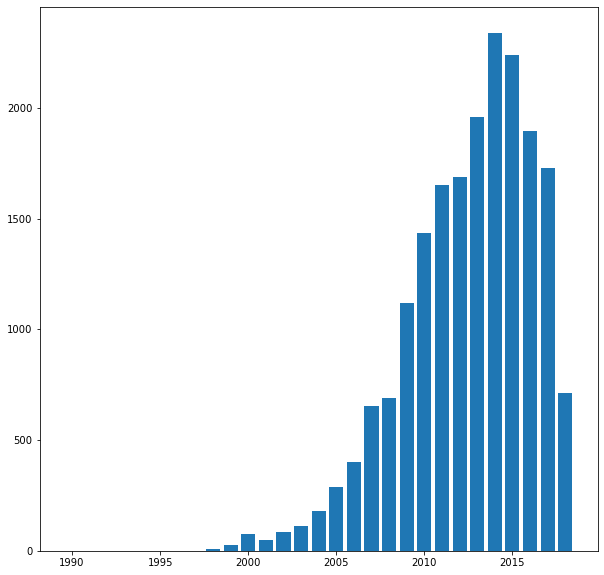

In [101]:
test_data = filtered_rounds.groupby(filtered_rounds['announced_on'].dt.year).size().reset_index(name = 'count')
plt.figure(figsize=(10,10))
plt.bar(test_data['announced_on'], test_data['count'])

In [102]:
filtered_rounds.groupby(['investment_type']).size().reset_index(name = 'count')

,investment_type,count
0,angel,161
1,convertible_note,165
2,corporate_round,43
3,debt_financing,1741
4,equity_crowdfunding,12
5,grant,349
6,initial_coin_offering,35
7,non_equity_assistance,23
8,post_ipo_debt,52
9,post_ipo_equity,171


In [103]:
pd.crosstab(index = filtered_rounds['investment_type'], columns = filtered_rounds['announced_on'].dt.year, dropna = False, margins = True)

announced_on,1990,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,All
investment_type,,,,,,,,,,,,,,,,,,,,,,,
angel,0,0,1,0,0,0,1,2,4,4,14,12,16,23,15,19,16,17,9,5,2,1,161
convertible_note,0,0,0,0,0,0,0,0,1,2,3,6,8,7,14,12,14,28,28,23,15,4,165
corporate_round,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,3,13,25,43
debt_financing,0,0,0,0,0,2,0,1,4,8,13,31,126,144,153,155,229,256,213,204,128,74,1741
equity_crowdfunding,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,3,2,2,2,0,12
grant,0,0,0,0,1,0,2,1,1,2,8,6,26,23,23,14,37,50,33,47,46,29,349
initial_coin_offering,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,10,35
non_equity_assistance,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,4,5,6,4,2,0,23
post_ipo_debt,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,4,13,5,19,8,1,52


То же самое в разрезе числа компаний

In [104]:
pd.crosstab(index = filtered_rounds['investment_type'], columns = filtered_rounds['announced_on'].dt.year, values = filtered_rounds['company_uuid'], aggfunc='count', dropna = False, margins = True)

announced_on,1990,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,All
investment_type,,,,,,,,,,,,,,,,,,,,,,,
angel,NaN,NaN,1.0,NaN,NaN,NaN,1.0,2.0,4.0,4.0,14.0,12.0,16.0,23.0,15.0,19.0,16.0,17.0,9.0,5.0,2.0,1.0,161
convertible_note,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,3.0,6.0,8.0,7.0,14.0,12.0,14.0,28.0,28.0,23.0,15.0,4.0,165
corporate_round,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,13.0,25.0,43
debt_financing,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,4.0,8.0,13.0,31.0,126.0,144.0,153.0,155.0,229.0,256.0,213.0,204.0,128.0,74.0,1741
equity_crowdfunding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,3.0,2.0,2.0,2.0,NaN,12
grant,NaN,NaN,NaN,NaN,1.0,NaN,2.0,1.0,1.0,2.0,8.0,6.0,26.0,23.0,23.0,14.0,37.0,50.0,33.0,47.0,46.0,29.0,349
initial_coin_offering,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,10.0,35
non_equity_assistance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,6.0,4.0,2.0,NaN,23
post_ipo_debt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,4.0,13.0,5.0,19.0,8.0,1.0,52


Суммарная привлеченная сумма для каждого типа раунда в год

In [105]:
fil_rounds = filtered_rounds.copy()
fil_rounds['raised_amount_usd'] = fil_rounds['raised_amount_usd'].replace(np.nan, 0)
pd.crosstab(index = fil_rounds['investment_type'], columns = fil_rounds['announced_on'].dt.year, values = fil_rounds['raised_amount_usd'], aggfunc='sum', dropna = False, margins = True)

announced_on,1990,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,All
investment_type,,,,,,,,,,,,,,,,,,,,,,,
angel,NaN,NaN,0.0,NaN,NaN,NaN,7.000000e+05,8.000000e+05,2.550000e+06,1.135000e+07,1.693000e+07,1.200000e+07,2.337924e+07,3.281986e+07,2.604300e+07,2.602175e+07,1.634900e+07,2.785000e+07,1.650610e+07,1.906366e+07,7.600000e+05,5.000000e+07,2.831226e+08
convertible_note,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.940000e+06,1.025040e+07,1.675000e+07,1.075616e+07,1.397628e+07,5.535709e+07,6.161234e+07,8.860569e+07,2.867100e+07,1.197219e+08,3.535341e+08,2.692990e+08,2.598288e+08,2.720000e+08,1.563303e+09
corporate_round,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.888300e+08,NaN,3.000000e+08,1.580000e+08,1.976806e+09,2.923636e+09
debt_financing,NaN,NaN,NaN,NaN,NaN,78352000.0,NaN,1.062500e+06,2.711600e+07,1.125260e+08,1.943100e+08,7.386626e+08,4.970832e+09,3.830553e+09,3.013482e+09,2.874377e+09,8.946934e+09,1.106177e+10,1.003766e+10,1.293776e+10,2.122508e+10,9.200384e+09,8.925085e+10
equity_crowdfunding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,0.000000e+00,NaN,NaN,0.000000e+00,2.598500e+07,4.500000e+07,1.700000e+07,3.450000e+07,NaN,1.224850e+08
grant,NaN,NaN,NaN,NaN,238000.0,NaN,3.722500e+07,7.000000e+05,1.000000e+06,3.580000e+07,1.139000e+08,3.120000e+07,7.825265e+08,5.468792e+08,1.663482e+08,5.772647e+07,6.350030e+08,8.287927e+08,2.118207e+08,1.096308e+09,1.627815e+09,1.015214e+09,7.188497e+09
initial_coin_offering,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.167598e+09,4.770000e+08,1.644598e+09
non_equity_assistance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,0.000000e+00,5.000000e+05,0.000000e+00,1.000000e+06,5.500000e+05,NaN,2.050000e+06
post_ipo_debt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000e+08,2.083999e+07,NaN,1.271500e+09,2.982200e+09,2.750000e+08,1.693689e+09,2.371000e+09,1.000000e+08,9.114229e+09


In [106]:
fil_rounds.loc[(fil_rounds['investment_type'] == 'seed') & (fil_rounds['announced_on'].dt.year == 1998)]

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag


In [107]:
fil_rounds.loc[(fil_rounds['investment_type'] == 'seed') & (fil_rounds['announced_on'].dt.year == 1999)]

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag
20891,Deem,USA,CA,SF Bay Area,San Francisco,seed,1999-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/deem,4116ff46-60f4-f305-242f-8d9c0c167469,18d6d1f0-2e21-6953-9079-139f1d77ee15,2017-02-03 13:39:21,2018-02-12 23:34:59,{},{},-
69216,IronPlanet,USA,CA,SF Bay Area,Pleasanton,seed,1999-01-01,3072680.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/ironplanet,aad40833-2091-0900-d28a-ea3fc13e162a,51bcddf9-3ead-e235-3887-055eb43668ad,2010-08-09 08:57:15,2018-02-12 23:16:08,{},{},-
110513,SquareTrade,USA,CA,SF Bay Area,San Francisco,seed,1999-10-01,400000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/squaretrade,621f95ae-3606-4dc7-5fdb-2ebb8e7c736b,834b7775-17d1-1491-f249-38d5c5df3568,2008-04-11 03:48:37,2018-02-12 23:50:04,{},{},-
116173,NeuroPace,USA,CA,SF Bay Area,Mountain View,seed,1999-12-22,0.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/neuropace,3ac8f944-1278-635a-50ef-93ba0ce9bb29,8a0adb02-5786-705d-e917-647a0e0e3f8f,2015-11-30 09:44:15,2018-02-13 00:25:52,{},{},-
147846,Connecture,USA,GA,Atlanta,Atlanta,seed,1999-11-08,2000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/connecture,4a34f22a-0b0e-9b99-2963-6c9aa3a1cf8d,afb0f152-d065-9d46-b75a-9adf66e6d65d,2017-03-10 06:54:52,2018-02-12 23:28:28,{},{},acq_err
194218,Cvent,USA,VA,"Washington, D.C.",Mclean,seed,1999-11-01,0.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/cvent,30be31c8-67a8-2cb5-2668-2e988f0130f8,e66184b9-55cb-46eb-9846-f02a78d4f208,2018-02-20 23:39:42,2018-02-21 00:10:09,{},{},-


Судя по всему отличие NaN от 0 заключается в том, что 0 соответствует наличию одного проведенного раунда с неуказанной привлеченной суммой. Если же раундов не было вовсе, то пишется NaN

Медианные привлеченные суммы

In [108]:
fil_rounds = filtered_rounds.copy()
pd.crosstab(index = fil_rounds['investment_type'], columns = fil_rounds['announced_on'].dt.year, values = fil_rounds['raised_amount_usd'], aggfunc='median', margins = True)

announced_on,1990,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,All
investment_type,,,,,,,,,,,,,,,,,,,,,,,
angel,NaN,NaN,NaN,NaN,NaN,NaN,700000.0,400000.0,600000.0,2500000.0,875000.0,725000.0,1100000.0,1200000.0,1300000.0,1000000.0,1094500.0,1550000.0,900000.0,2000000.0,380000.0,50000000.0,1000000.0
convertible_note,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2940000.0,5125200.0,5250000.0,1884359.5,1240000.0,2500000.0,1400000.0,5000000.0,1475000.0,2001997.0,1000000.0,8452500.0,8307500.0,114000000.0,2702460.0
corporate_round,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,244415000.0,NaN,100000000.0,20000000.0,60000000.0,45000000.0
debt_financing,NaN,NaN,NaN,NaN,NaN,39176000.0,NaN,1062500.0,2100000.0,5000000.0,10000000.0,11250000.0,3250000.0,5000000.0,4800000.0,3550176.5,8000000.0,10000000.0,12000000.0,23200000.0,60000000.0,55000000.0,10000000.0
equity_crowdfunding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12992500.0,22500000.0,8500000.0,17250000.0,NaN,18000000.0
grant,NaN,NaN,NaN,NaN,238000.0,NaN,18612500.0,700000.0,1000000.0,17900000.0,2500000.0,2350000.5,8775650.0,3000000.0,1875000.0,715734.0,4000000.0,3975000.0,1950000.0,10000000.0,21250000.0,23000000.0,5450000.0
initial_coin_offering,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32000000.0,39000000.0,32000000.0
non_equity_assistance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500000.0,NaN,1000000.0,275000.0,NaN,500000.0
post_ipo_debt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400000000.0,20839994.0,NaN,325500000.0,25000000.0,40000000.0,33000000.0,201500000.0,100000000.0,34000000.0


Теперь квартили

Оставим раунды с типом из списка, составленного на основе вычислений выше

In [109]:
fil_rounds = filtered_rounds.loc[filtered_rounds['investment_type'].isin(quattro_types)]
fil_rounds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17972 entries, 13 to 215596
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   company_name                 17972 non-null  object        
 1   country_code                 17972 non-null  object        
 2   state_code                   17967 non-null  object        
 3   region                       17931 non-null  object        
 4   city                         17931 non-null  object        
 5   investment_type              17972 non-null  object        
 6   announced_on                 17972 non-null  datetime64[ns]
 7   raised_amount_usd            16758 non-null  float64       
 8   raised_amount                102 non-null    float64       
 9   raised_amount_currency_code  102 non-null    object        
 10  post_money_valuation_usd     692 non-null    float64       
 11  post_money_valuation         6 non-null

Для дальнейших подсчетов нам нужен всюду заполенный параметр привлеченной суммы в раунде (raised_amount_usd). В некоторых случаях он равен нулю, но известна капитализация (post_money_valuation_usd), что странно. Ручная проверка MongoDB и Razer показала, что упоминаемые в этой таблице раунды - сомнительной природы. MongoDB - предположительно вторичная транзакция на маркетплейсе EquityZen. Razer - сомнительная ссылка на внутренний документ о неизвестном раунде, возможно с крупным китайским техом (Tencent или др.)

In [110]:
emp = [np.nan, 0]
team_7 = fil_rounds.loc[(fil_rounds['raised_amount_usd'].isin(emp)) & (~fil_rounds['post_money_valuation_usd'].isin(emp))].reset_index(drop=True)
team_7

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag
0,H.I.G. Capital,USA,FL,Miami,Miami,private_equity,2016-08-03,NaN,NaN,NaN,4.500000e+09,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/hig-capital,0d2ee297-1265-5001-4fd8-e9b890cecbdc,194aaa3b-67c2-2a78-6f26-6cd0f4ff8f3f,2016-08-04 06:02:47,2018-02-12 23:42:46,"{""Dyal Capital Partners""}",{5488f111-39f2-7a15-ea39-6a010f0f57f3},-
1,gofundme,USA,CA,San Diego,San Diego,series_a,2015-07-02,NaN,NaN,NaN,6.000000e+08,NaN,NaN,6.0,https://www.crunchbase.com/funding-round/gofundme,7c098e32-687c-a1c2-f31f-d752869b104b,1e4aee3c-1f2c-fd2f-0434-eb855b0b0f2e,2015-06-19 04:32:54,2018-02-12 23:54:20,"{Accel,TCV}","{b08efc27-da40-505a-6f9d-c9e14247bf36,b915e540-3377-6a2a-651e-6fd7c0787e26}",-
2,MongoDB,USA,NY,New York City,New York,series_unknown,2015-08-18,NaN,NaN,NaN,1.600000e+09,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/mongodb-inc,5abbe513-4087-df21-143b-8f8b012c8377,2e1d877a-6a6a-4cc3-b3bc-3e89c29c5d23,2016-07-27 07:58:55,2018-02-12 23:26:57,{EquityZen},{06428031-1279-bf59-482a-d0e3a52a821f},-
3,Nerd Junkie Inc,USA,FL,Tampa,Tampa,seed,2018-04-17,NaN,NaN,NaN,2.125000e+08,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/nerd-junkie-inc,cac9b8c4-f2cf-4431-f0f8-1680678a36f0,3b2778bf-3c18-4021-82aa-0b76b459cf8d,2018-04-06 14:47:01,2018-04-13 02:45:40,{},{},-
4,Razer,USA,CA,Anaheim,Irvine,series_unknown,2014-10-15,NaN,NaN,NaN,1.000000e+09,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/razer,58422cc5-4dcc-5775-694b-017b2e45de42,4e7f6e6a-1a30-9be3-3c88-1f98b6fc1030,2014-10-16 02:31:50,2018-02-12 23:44:10,"{""Intel Capital""}",{f3716725-552d-b9b5-59ad-de4ec64b1751},-
5,Kendra Scott Design,USA,TX,Austin,Austin,private_equity,2016-12-21,NaN,NaN,NaN,1.000000e+09,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/kendra-scott-design,56c50daf-2d3a-4e79-bd89-509e8aa9b211,ad408604-de32-1308-0935-79db7ccda576,2016-12-22 07:17:35,2018-02-12 23:52:06,"{""Berkshire Partners""}",{0985504e-3a27-d695-e945-c878c2270895},-
6,ALPHAEON Corporation,USA,CA,Anaheim,Irvine,series_unknown,2015-01-12,NaN,NaN,NaN,5.000000e+08,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/alphaeon,01816c87-1fcb-c823-75ab-c67735887aad,d99140ca-970b-55b8-80e8-7c3eeaabc90d,2017-05-06 14:11:51,2018-02-12 23:30:26,"{""Longitude Capital""}",{91a911e7-5379-296b-db12-ef9996af1010},-


На этом основании приняли решение не интерполировать и дропнуть подобные раунды (7 штук)  
P.S. Вскоре после данного исследования мы разработали более совершенный метод интерполяции, используя в том числе данные из MongoDB и Razer

In [111]:
#for ind in team_7.index:
#    team_7.at[ind, 'raised_amount_usd'] = team_7.at[ind, 'post_money_valuation_usd'] / 5
#team_7

In [112]:
fil_rounds = fil_rounds.loc[~fil_rounds['raised_amount_usd'].isin(emp)]
fil_rounds

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag
13,Factual,USA,CA,Los Angeles,Los Angeles,seed,2010-02-03,2000000.0,NaN,NaN,NaN,NaN,NaN,13.0,https://www.crunchbase.com/funding-round/factual,c6eda1e4-c526-037a-c556-8af22254f01f,00043331-9b35-507f-990e-72e376cdf7b8,2010-02-04 19:14:31,2018-02-12 22:23:14,{},{},-
28,Integral Ad Science,USA,NY,New York City,New York,series_e,2015-07-29,27000070.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/integralads,05ac5fd9-bea2-4a12-c94c-4887dc48bb1b,0008d7cd-2233-7ac0-499f-d6bd79322751,2015-07-30 09:18:17,2018-02-12 22:34:20,"{""Sapphire Ventures""}",{ea5de28f-7493-f605-c3fd-51965a5b5aba},-
67,NJOY,USA,AZ,Phoenix,Scottsdale,private_equity,2014-02-28,70000000.0,NaN,NaN,1.070000e+09,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/njoy,b336e7ed-1946-7490-aa84-d0ed4c2fb0e9,00156532-7e61-f671-b148-0b5f72b2fa62,2012-04-10 03:09:05,2018-02-13 00:02:10,{},{},-
77,Soothe,USA,CA,Los Angeles,Los Angeles,seed,2015-02-11,1700000.0,NaN,NaN,NaN,NaN,NaN,10.0,https://www.crunchbase.com/funding-round/soothe,f48a8e9e-988f-4342-dea1-3ead78998827,0017fac0-5511-0f21-812f-d55be2009c04,2015-02-11 18:53:57,2018-02-12 22:37:13,{},{},-
80,Hortonworks,USA,CA,SF Bay Area,Santa Clara,series_d,2014-03-24,100000000.0,NaN,NaN,NaN,NaN,NaN,7.0,https://www.crunchbase.com/funding-round/hortonworks,1b79cac5-3f43-2738-2366-ae4e46e05327,001a35d2-b70a-a954-9c11-774c2cf6dad9,2014-03-25 06:45:06,2018-02-12 22:56:07,"{BlackRock,""Passport Capital""}","{931f7202-91fd-ab26-c07d-06518289ef06,9f926ea7-9969-f5f9-2c4f-a4b0ca712ecf}",-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215523,LOYAL3,USA,CA,SF Bay Area,San Francisco,series_d,2014-07-18,30223650.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/loyal3,d5106e42-c0e3-4bcf-8831-767d0c4e4767,ffe8feaa-0fe3-539a-f7fc-49c1e63606f5,2014-07-18 10:06:31,2018-02-12 22:19:44,{},{},-
215524,Dashlane,USA,NY,New York City,New York,series_a,2012-09-28,3000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/dashlane,cb1d7d46-ca74-c0c3-02f0-576dd57360f1,ffe94e25-3d37-bb8c-7d6d-98cdb7b2b3a7,2014-04-23 12:34:19,2018-02-12 23:40:30,{},{},-
215549,Bitly,USA,NY,New York City,New York,debt_financing,2010-02-18,1500000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/bitly,a1687402-7594-f085-f152-0cca6f958b8f,fff14145-ee2d-1943-8e12-e8762df3afa4,2010-03-01 19:04:50,2018-02-12 23:50:08,{},{},-
215588,Duo Security,USA,MI,Detroit,Ann Arbor,seed,2010-08-17,1000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/duo-security,cba5db21-4689-8106-aa96-5f73a44577cf,fff9f693-0293-25c5-39f5-0cf5d5f30f66,2010-08-18 22:24:05,2018-02-12 22:16:36,{},{},-


In [113]:
#fil_rounds = pd.concat([fil_rounds, team_7]).drop_duplicates().reset_index(drop=True)
#fil_rounds

Далее идет отбор раундов для ручного анализа квартилей.

In [114]:
def quattro(fil_rounds, type_):
    a = fil_rounds.loc[fil_rounds['investment_type'] == type_]
    a['range_type'] = '---'
    c = pd.DataFrame().reindex_like(a)
    for year in year_set:
        b = a.loc[a['announced_on'].dt.year == year]
        b = b.sort_values(by = ['raised_amount_usd'], ascending=False)
        group_a, group_b, group_c, group_d = np.array_split(b, 4)
        group_a['range_type'] = group_a['range_type'].replace(['---'], 'group_a')
        group_b['range_type'] = group_b['range_type'].replace(['---'], 'group_b')
        group_c['range_type'] = group_c['range_type'].replace(['---'], 'group_c')
        group_d['range_type'] = group_d['range_type'].replace(['---'], 'group_d')
        b = pd.concat([group_a, group_b, group_c, group_d]).reset_index(drop=True)
        c = pd.concat([c, b]).reset_index(drop=True)
    return pd.crosstab(index = c['range_type'], columns = c['announced_on'].dt.year, values = c['raised_amount_usd'], aggfunc='sum')

In [115]:
quattro(fil_rounds, 'seed')

announced_on,1990.0,1999.0,2000.0,2001.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0
range_type,,,,,,,,,,,,,,,,,,
group_a,60000.0,3072680.0,3000000.0,24700000.0,2750000.0,5500000.0,22700000.0,80800000.0,20440000.0,27483293.0,42400000.0,81815922.0,98449780.0,205597250.0,164764202.0,211683904.0,175807341.0,119800000.0
group_b,NaN,2000000.0,700000.0,1400000.0,500000.0,3250000.0,5505000.0,7400000.0,6455000.0,13237390.0,17945000.0,37123992.0,49049695.0,97383050.0,77570000.0,75462019.0,43459994.0,34100000.0
group_c,NaN,400000.0,600000.0,1000000.0,500000.0,800000.0,2700000.0,2950000.0,3900000.0,4557499.0,10486000.0,24159999.0,28585619.0,58139130.0,47570000.0,53429480.0,25670001.0,17450000.0
group_d,NaN,NaN,300000.0,930096.0,55000.0,150000.0,672000.0,131450.0,1459193.0,1042000.0,2985002.0,8346013.0,8582706.0,18380504.0,12914096.0,19233002.0,9857000.0,8325000.0


In [116]:
quattro(fil_rounds, 'series_a')

announced_on,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
range_type,,,,,,,,,,,,,,,,,,,,,
group_a,10000000.0,59100000.0,122000000.0,32300000.0,161370000.0,178750000.0,175953000.0,611849000.0,572742503.0,1.358467e+09,1.190584e+09,1.195253e+09,1.534010e+09,1.836705e+09,1.793494e+09,3.061242e+09,2.989461e+09,4.122931e+09,3.232565e+09,2.565200e+09,2.288470e+09
group_b,6100000.0,12000000.0,60600000.0,20000000.0,38451000.0,66175637.0,96650000.0,188855000.0,245428859.0,3.671368e+08,3.702787e+08,3.933719e+08,3.752773e+08,5.716909e+08,6.304777e+08,7.096207e+08,1.096685e+09,1.333668e+09,1.351682e+09,1.124055e+09,8.113000e+08
group_c,1500000.0,10800000.0,31700000.0,11010000.0,22750000.0,37280000.0,64743001.0,95241000.0,146858000.0,1.936180e+08,2.100660e+08,2.133557e+08,2.069389e+08,3.086764e+08,3.419667e+08,4.473690e+08,6.817135e+08,7.654830e+08,7.101300e+08,8.066070e+08,5.350999e+08
group_d,NaN,3072756.0,7500000.0,4500000.0,10106000.0,12780583.0,19155000.0,33237000.0,52248000.0,8.650506e+07,8.127180e+07,7.929156e+07,8.005968e+07,1.371004e+08,1.468911e+08,2.343419e+08,3.596135e+08,4.085526e+08,3.547351e+08,2.868185e+08,2.794000e+08


In [117]:
quattro(fil_rounds, 'series_b')

announced_on,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
range_type,,,,,,,,,,,,,,,,,,,,
group_a,14000000.0,207000000.0,74000000.0,108030000.0,222700000.0,237670000.0,487789938.0,768700000.0,1.560989e+09,1.457312e+09,1.293505e+09,2.416088e+09,2.688472e+09,1.758133e+09,2.483900e+09,4.702521e+09,6.544914e+09,4.359902e+09,6.440755e+09,2.474500e+09
group_b,NaN,120000000.0,56500000.0,53740000.0,93662542.0,133898624.0,226453999.0,266802859.0,5.644690e+08,5.536224e+08,6.388870e+08,8.281494e+08,1.118246e+09,8.443304e+08,1.121766e+09,1.850791e+09,2.669399e+09,1.982582e+09,2.161150e+09,1.139200e+09
group_c,NaN,86800000.0,32600000.0,39000000.0,56190000.0,74529000.0,139804999.0,153259000.0,3.115215e+08,3.477250e+08,3.134462e+08,4.709880e+08,7.111023e+08,5.198250e+08,7.022864e+08,1.248388e+09,1.850806e+09,1.416049e+09,1.569100e+09,7.860000e+08
group_d,NaN,32600000.0,10800000.0,16452723.0,13783640.0,38976000.0,53817707.0,67529000.0,1.463845e+08,1.572290e+08,1.467879e+08,2.489688e+08,3.025771e+08,2.374629e+08,3.587690e+08,6.713920e+08,1.045350e+09,7.650521e+08,1.029157e+09,5.374500e+08


In [118]:
quattro(fil_rounds, 'series_c')

announced_on,1998.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
range_type,,,,,,,,,,,,,,,,,,,,
group_a,9000000.0,20000000.0,195000000.0,140000000.0,66773000.0,150000000.0,198670000.0,529985116.0,1.164400e+09,1.240272e+09,1.027458e+09,1.845483e+09,2.473795e+09,2.358591e+09,2.766461e+09,3.976935e+09,4.805596e+09,5.261373e+09,5.106200e+09,2.418750e+09
group_b,NaN,3000000.0,72000000.0,46000000.0,39549000.0,69800000.0,102259000.0,292320000.0,4.832890e+08,5.836842e+08,4.785500e+08,9.177301e+08,1.006827e+09,1.115957e+09,1.187874e+09,1.832060e+09,2.158102e+09,2.049073e+09,2.406300e+09,1.172900e+09
group_c,NaN,NaN,25500000.0,19350000.0,24550000.0,53300000.0,67470000.0,166082000.0,2.812550e+08,3.730030e+08,2.691000e+08,6.020836e+08,6.708000e+08,7.767000e+08,7.770000e+08,1.207010e+09,1.430500e+09,1.403884e+09,1.631283e+09,7.831009e+08
group_d,NaN,NaN,NaN,8443000.0,6992000.0,18038334.0,24297000.0,71800000.0,1.214600e+08,2.089610e+08,1.438418e+08,2.964907e+08,3.183618e+08,3.497501e+08,3.709277e+08,5.401500e+08,7.975232e+08,8.066250e+08,9.248328e+08,4.846500e+08


In [119]:
quattro(fil_rounds, 'series_d')

announced_on,1999.0,2000.0,2001.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
range_type,,,,,,,,,,,,,,,,,,,
group_a,31000000.0,33900000.0,40000000.0,47000000.0,132100000.0,180600000.0,202500000.0,535100000.0,984500000.0,1.271284e+09,1.238265e+09,2.211101e+09,2.006800e+09,1.717278e+09,5.798000e+09,4.077227e+09,2.581530e+09,4.818811e+09,3.021000e+09
group_b,NaN,30000000.0,2000000.0,43000000.0,47500000.0,62536000.0,99700000.0,318906948.0,302793000.0,5.355450e+08,4.943600e+08,6.472172e+08,8.353298e+08,7.923499e+08,1.305955e+09,1.611550e+09,1.209900e+09,1.694700e+09,8.540000e+08
group_c,NaN,16500000.0,NaN,12480000.0,33040000.0,43291888.0,64500000.0,204600000.0,199600000.0,3.381262e+08,3.086603e+08,4.720618e+08,5.725028e+08,5.146136e+08,8.326182e+08,1.020697e+09,7.710000e+08,9.586766e+08,5.573000e+08
group_d,NaN,8000000.0,NaN,2800000.0,12098000.0,23999000.0,25392000.0,108334563.0,124514000.0,1.346450e+08,1.184055e+08,2.585000e+08,3.036000e+08,2.487098e+08,3.848789e+08,4.917737e+08,3.880866e+08,5.286062e+08,2.882606e+08


In [120]:
quattro(fil_rounds, 'series_e')

announced_on,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
range_type,,,,,,,,,,,,,,,,,,
group_a,100000000.0,21495000.0,50000000.0,85000000.0,69000000.0,100870000.0,78029000.0,675500000.0,489000000.0,299000000.0,1.268500e+09,865490000.0,1.169300e+09,3.461000e+09,6.935434e+09,1.419100e+09,2.639650e+09,963000000.0
group_b,31000000.0,7000000.0,NaN,30000000.0,15000000.0,45000000.0,59000000.0,173000000.0,253135000.0,144900000.0,3.755000e+08,374700000.0,5.276000e+08,8.573814e+08,1.119000e+09,5.555000e+08,7.563467e+08,395000000.0
group_c,NaN,NaN,NaN,10000000.0,5000000.0,33000000.0,21380000.0,95320000.0,140600000.0,87000000.0,2.110000e+08,224800000.0,3.492367e+08,4.652000e+08,6.490001e+08,4.155000e+08,4.020000e+08,278000000.0
group_d,NaN,NaN,NaN,3300000.0,3000000.0,13000000.0,10000000.0,42363000.0,46774999.0,41866511.0,1.311000e+08,86755336.0,1.737564e+08,2.353438e+08,2.606283e+08,2.175632e+08,2.316229e+08,111287898.0


In [121]:
quattro(fil_rounds, 'series_unknown')

announced_on,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
range_type,,,,,,,,,,,,,,,,,,,,
group_a,45000000.0,208400000.0,94000000.0,68400000.0,122500000.0,85116000.0,302000000.0,335500000.0,609689200.0,781490000.0,3.539000e+09,4.393017e+09,5.170592e+09,3.668828e+09,3.403141e+09,4.715358e+09,5.493618e+09,3.485869e+09,6.765497e+09,2.785387e+09
group_b,10000000.0,66000000.0,31000000.0,22502000.0,72402000.0,46382000.0,47700000.0,95059000.0,175324320.0,234119000.0,1.038997e+09,1.316339e+09,1.783282e+09,1.336807e+09,1.182294e+09,1.943630e+09,1.993940e+09,1.572821e+09,2.130031e+09,1.014810e+09
group_c,10000000.0,30000000.0,7000000.0,10525000.0,24400000.0,15300000.0,20250000.0,44500000.0,47599000.0,101385000.0,3.245879e+08,4.728227e+08,6.789011e+08,5.064463e+08,3.947383e+08,7.592514e+08,8.191994e+08,8.025025e+08,1.202842e+09,6.638005e+08
group_d,6500000.0,11226167.0,1000000.0,2125000.0,9623000.0,4600000.0,7570000.0,12150000.0,14522573.0,26822818.0,6.933537e+07,1.130897e+08,1.797732e+08,1.322205e+08,1.095019e+08,1.952641e+08,2.019137e+08,2.417836e+08,3.270060e+08,3.285134e+08


На основе этих выкладок решили, что самые "ценные" для нашей задачи раунды (primary_series): angel, convertible_note, corporate_round, seed, series_a, series_b, series_c, series_d, series_e, series_f, series_g, series_h, series_i, series_unknown.  
Кроме того, в primary_series будут входить раунды 'private_equity' и 'equity_crowdfunding'

### Первоначальные списки IPO и Acquisitions (выходов)

Соответствующий список IPO

In [122]:
filtered_ipos = ipos.loc[ipos['company_uuid'].isin(distinct_uuid)]
filtered_ipos

,name,country_code,company_state_code,region,city,stock_exchange_symbol,stock_symbol,went_public_on,price_usd,price,price_currency_code,money_raised_usd,cb_url,ipo_uuid,company_uuid,created_at,updated_at
0,Pluralsight,USA,UT,UT - Other,Farmington,nasdaq,PS,2018-05-17,NaN,NaN,NaN,310000000.0,https://www.crunchbase.com/organization/pluralsight,55cf20be-d2c2-466b-af4f-d11bf291361c,29870a7c-07ed-5748-2ef2-87c26fa8eb3c,2018-05-17 00:51:40,2018-05-17 00:51:40
6,Evelo Biosciences,USA,MA,Boston,Cambridge,nasdaq,EVLO,2018-05-09,509000000.0,NaN,NaN,85000000.0,https://www.crunchbase.com/organization/evelo-therapeutics,20b73b54-cc5d-4def-8849-68680fa21b4b,9adf33a2-cfc3-167a-dab8-751d40d637e5,2018-05-10 04:16:00,2018-05-10 06:57:14
8,Origin Bank,USA,LA,Monroe,Ruston,nasdaq,OBNK,2018-05-08,748000000.0,NaN,NaN,123000000.0,https://www.crunchbase.com/organization/origin-bank,701d2351-5672-4a20-9976-7a776bc6911c,e9a855d1-9c63-4ff4-9566-dedf6d98f23b,2018-05-10 06:54:48,2018-05-10 06:54:48
13,Inspire Medical Systems,USA,MN,Minneapolis,Maple Grove,nyse,INSP,2018-05-03,NaN,NaN,NaN,108000000.0,https://www.crunchbase.com/organization/inspire-medical-systems,bdd4ffbb-c772-4141-9f76-2d02c390d4e7,fa122557-f1f1-b2ff-748d-32120bb0840e,2018-05-03 06:27:29,2018-05-04 04:52:21
17,UNITY Biotechnology,USA,CA,SF Bay Area,Brisbane,nasdaq,UBX,2018-05-02,NaN,NaN,NaN,85000000.0,https://www.crunchbase.com/organization/unity-biotechnology,e2c14e92-6aa9-49dd-a426-85711f993b30,a9486742-c473-1ff2-185d-74bf75f8ff50,2018-05-03 06:24:44,2018-05-03 06:24:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5641,A123 Systems,USA,MA,Worcester,Westborough,nasdaq,AONE,2009-09-24,380436764.0,NaN,NaN,NaN,https://www.crunchbase.com/organization/a123systems,f1fa9a1f-633b-ff49-b32d-323dd6338421,03e7a926-1e8a-f3e2-b693-d79b14809f50,2009-09-25 00:23:09,2018-02-12 23:56:46
5653,Acme Packet,USA,MA,Boston,Bedford,nasdaq,APKT,2009-09-09,NaN,NaN,NaN,109000000.0,https://www.crunchbase.com/organization/acme-packet,2a3930c7-9a2a-8549-3a7d-d13beb49c725,d807b22c-328f-0aec-a29a-4d74adc9d504,2011-02-03 06:07:02,2018-02-12 23:44:56
5725,MVB Bank,USA,WV,WV - Other,Fairmont,otcqb,MVBF,2009-07-17,NaN,NaN,NaN,NaN,https://www.crunchbase.com/organization/mvb-bank,be30af70-b997-d843-e028-614fd17cf91e,46bfcc3f-1196-aa90-3086-5ab80c24a3d4,2014-07-01 09:38:39,2018-02-12 23:35:56
5832,HeartWare International,USA,MA,Boston,Framingham,nasdaq,HTWR,2009-03-06,NaN,NaN,NaN,NaN,https://www.crunchbase.com/organization/heartware-international,18ea7152-3f0e-2e8a-f448-48f050fecfc1,6922e53e-fad4-440c-9755-5bb959b9414f,2014-07-21 09:47:54,2018-02-12 23:34:09


In [123]:
len(set(filtered_ipos['company_uuid'].values))

410

Опять не сходится

In [124]:
a = filtered_ipos.groupby(['company_uuid']).size().reset_index(name = 'count')
b = a.loc[a['count'] > 1]
b

,company_uuid,count
25,10aa5886-be22-8943-0901-fe07ae067367,2
347,db41732f-f15e-b4e3-edcf-a5b6788184ac,2
388,f4d41be3-a0eb-8bd5-af50-485c75bbb414,2


Для следующих компаний имеется по 2 записи об IPO

In [125]:
filtered_ipos.loc[filtered_ipos['company_uuid'].isin(b['company_uuid'])]

,name,country_code,company_state_code,region,city,stock_exchange_symbol,stock_symbol,went_public_on,price_usd,price,price_currency_code,money_raised_usd,cb_url,ipo_uuid,company_uuid,created_at,updated_at
1455,aTyr Pharma,USA,CA,San Diego,San Diego,nasdaq,LIFE,2015-05-15,NaN,NaN,NaN,NaN,https://www.crunchbase.com/organization/atyr-pharma,78661dee-2311-22d5-097f-e86638bfc419,10aa5886-be22-8943-0901-fe07ae067367,2016-11-14 10:01:18,2018-02-12 23:42:46
1480,aTyr Pharma,USA,CA,San Diego,San Diego,nasdaq,LIFE,2015-05-06,316000000.0,NaN,NaN,75000000.0,https://www.crunchbase.com/organization/atyr-pharma,e0733460-2902-cbff-4856-f1fb4d06cbf8,10aa5886-be22-8943-0901-fe07ae067367,2015-04-28 06:20:48,2018-02-12 22:26:32
1844,Atara Biotherapeutics,USA,CA,SF Bay Area,South San Francisco,nasdaq,ATRA,2014-10-24,NaN,NaN,NaN,NaN,https://www.crunchbase.com/organization/atara-biotherapeutics,b4636bcd-d740-4ed6-d167-e3e7cd692fb6,f4d41be3-a0eb-8bd5-af50-485c75bbb414,2016-11-14 09:16:21,2018-02-12 22:22:52
1879,Atara Biotherapeutics,USA,CA,SF Bay Area,South San Francisco,nasdaq,ATRA,2014-10-07,NaN,NaN,NaN,55000000.0,https://www.crunchbase.com/organization/atara-biotherapeutics,934ec50e-25f8-aeee-d654-602cf342fab2,f4d41be3-a0eb-8bd5-af50-485c75bbb414,2014-10-08 06:04:14,2018-02-12 23:25:46
2298,Everyday Health,USA,NY,New York City,New York,nyse,EVDY,2014-04-04,414400000.0,NaN,NaN,100000000.0,https://www.crunchbase.com/organization/everyday-health,419df78b-5a16-9355-560c-0c90f4e17681,db41732f-f15e-b4e3-edcf-a5b6788184ac,2014-06-05 08:04:15,2018-02-12 23:54:31
2299,Everyday Health,USA,NY,New York City,New York,nyse,EVDY,2014-04-04,NaN,NaN,NaN,NaN,https://www.crunchbase.com/organization/everyday-health,dec69efa-2c13-7e14-290f-06caf1d248c1,db41732f-f15e-b4e3-edcf-a5b6788184ac,2016-11-16 10:41:42,2018-02-12 23:50:02


Похоже, ошибки в базе. Удалим записи, в которых отсутствуют численные данные о сумме привлеченных средств

In [126]:
filtered_ipos = filtered_ipos.drop(filtered_ipos[filtered_ipos['ipo_uuid'] == '78661dee-2311-22d5-097f-e86638bfc419'].index)
filtered_ipos = filtered_ipos.drop(filtered_ipos[filtered_ipos['ipo_uuid'] == 'b4636bcd-d740-4ed6-d167-e3e7cd692fb6'].index)
filtered_ipos = filtered_ipos.drop(filtered_ipos[filtered_ipos['ipo_uuid'] == 'dec69efa-2c13-7e14-290f-06caf1d248c1'].index)
filtered_ipos

,name,country_code,company_state_code,region,city,stock_exchange_symbol,stock_symbol,went_public_on,price_usd,price,price_currency_code,money_raised_usd,cb_url,ipo_uuid,company_uuid,created_at,updated_at
0,Pluralsight,USA,UT,UT - Other,Farmington,nasdaq,PS,2018-05-17,NaN,NaN,NaN,310000000.0,https://www.crunchbase.com/organization/pluralsight,55cf20be-d2c2-466b-af4f-d11bf291361c,29870a7c-07ed-5748-2ef2-87c26fa8eb3c,2018-05-17 00:51:40,2018-05-17 00:51:40
6,Evelo Biosciences,USA,MA,Boston,Cambridge,nasdaq,EVLO,2018-05-09,509000000.0,NaN,NaN,85000000.0,https://www.crunchbase.com/organization/evelo-therapeutics,20b73b54-cc5d-4def-8849-68680fa21b4b,9adf33a2-cfc3-167a-dab8-751d40d637e5,2018-05-10 04:16:00,2018-05-10 06:57:14
8,Origin Bank,USA,LA,Monroe,Ruston,nasdaq,OBNK,2018-05-08,748000000.0,NaN,NaN,123000000.0,https://www.crunchbase.com/organization/origin-bank,701d2351-5672-4a20-9976-7a776bc6911c,e9a855d1-9c63-4ff4-9566-dedf6d98f23b,2018-05-10 06:54:48,2018-05-10 06:54:48
13,Inspire Medical Systems,USA,MN,Minneapolis,Maple Grove,nyse,INSP,2018-05-03,NaN,NaN,NaN,108000000.0,https://www.crunchbase.com/organization/inspire-medical-systems,bdd4ffbb-c772-4141-9f76-2d02c390d4e7,fa122557-f1f1-b2ff-748d-32120bb0840e,2018-05-03 06:27:29,2018-05-04 04:52:21
17,UNITY Biotechnology,USA,CA,SF Bay Area,Brisbane,nasdaq,UBX,2018-05-02,NaN,NaN,NaN,85000000.0,https://www.crunchbase.com/organization/unity-biotechnology,e2c14e92-6aa9-49dd-a426-85711f993b30,a9486742-c473-1ff2-185d-74bf75f8ff50,2018-05-03 06:24:44,2018-05-03 06:24:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5641,A123 Systems,USA,MA,Worcester,Westborough,nasdaq,AONE,2009-09-24,380436764.0,NaN,NaN,NaN,https://www.crunchbase.com/organization/a123systems,f1fa9a1f-633b-ff49-b32d-323dd6338421,03e7a926-1e8a-f3e2-b693-d79b14809f50,2009-09-25 00:23:09,2018-02-12 23:56:46
5653,Acme Packet,USA,MA,Boston,Bedford,nasdaq,APKT,2009-09-09,NaN,NaN,NaN,109000000.0,https://www.crunchbase.com/organization/acme-packet,2a3930c7-9a2a-8549-3a7d-d13beb49c725,d807b22c-328f-0aec-a29a-4d74adc9d504,2011-02-03 06:07:02,2018-02-12 23:44:56
5725,MVB Bank,USA,WV,WV - Other,Fairmont,otcqb,MVBF,2009-07-17,NaN,NaN,NaN,NaN,https://www.crunchbase.com/organization/mvb-bank,be30af70-b997-d843-e028-614fd17cf91e,46bfcc3f-1196-aa90-3086-5ab80c24a3d4,2014-07-01 09:38:39,2018-02-12 23:35:56
5832,HeartWare International,USA,MA,Boston,Framingham,nasdaq,HTWR,2009-03-06,NaN,NaN,NaN,NaN,https://www.crunchbase.com/organization/heartware-international,18ea7152-3f0e-2e8a-f448-48f050fecfc1,6922e53e-fad4-440c-9755-5bb959b9414f,2014-07-21 09:47:54,2018-02-12 23:34:09


Теперь список покупок компаниями из нашего датасета

In [127]:
filtered_merged = acquisitions.loc[acquisitions['acquirer_uuid'].isin(distinct_uuid)]
filtered_merged

,acquiree_name,acquiree_country_code,state_code,acquiree_region,acquiree_city,acquirer_name,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquisition_type,acquired_on,price_usd,price,price_currency_code,acquiree_cb_url,acquirer_cb_url,acquiree_uuid,acquirer_uuid,acquisition_uuid,created_at,updated_at
23,Farm Hill,USA,CA,SF Bay Area,Redwood City,EAT Club,USA,CA,SF Bay Area,Redwood City,acquisition,2018-05-17,NaN,NaN,NaN,https://www.crunchbase.com/organization/farm-hill,https://www.crunchbase.com/organization/eat-club,5ab1937d-f5e6-f76c-0be9-36451eeee0aa,801ca06e-8a99-731e-db14-a8f53fd47644,7e6cb725-7611-4713-a7d3-04913ed2f9be,2018-05-17 19:14:20,2018-05-17 19:14:20
53,MissionU,USA,CA,SF Bay Area,San Francisco,WeWork,USA,NY,New York City,New York,acquisition,2018-05-16,NaN,NaN,NaN,https://www.crunchbase.com/organization/missionu,https://www.crunchbase.com/organization/wework,e2bd1222-b402-3434-86b0-da60dfb7bf3f,eeacbc1a-04f3-48a8-dae7-3fc0aa8e9485,180f10b8-4bd7-4fd3-a1e9-7b838dc25da4,2018-05-17 07:10:19,2018-05-17 07:10:19
62,TalkIQ,USA,CA,SF Bay Area,San Francisco,Dialpad,USA,CA,SF Bay Area,San Francisco,acquihire,2018-05-16,NaN,NaN,NaN,https://www.crunchbase.com/organization/talkiq,https://www.crunchbase.com/organization/dialpad,f3e158a5-2666-d0cb-d504-8adae5c39ea7,c2750511-2ce2-6588-58e5-b761f56b5160,036b8eee-0a02-4667-84ce-555c0ad86cf0,2018-05-16 14:44:55,2018-05-16 14:44:55
65,WriteLab,USA,CA,SF Bay Area,Berkeley,Chegg,USA,CA,SF Bay Area,Santa Clara,acquisition,2018-05-16,15000000.0,NaN,NaN,https://www.crunchbase.com/organization/writelab,https://www.crunchbase.com/organization/chegg,ab776f08-83fe-4a4f-41e3-a2b7d954094f,9bcbd28c-d50b-41cd-357a-29bd1f2193c4,ffc03bef-e333-49dd-95e8-e2227adccae2,2018-05-17 07:26:20,2018-05-17 07:26:20
124,Server Density,GBR,NaN,London,London,StackPath,USA,TX,Dallas,Dallas,merge,2018-05-14,NaN,NaN,NaN,https://www.crunchbase.com/organization/server-density,https://www.crunchbase.com/organization/stackpath,27439e8b-4bd4-d9d2-6940-d142a2ac7143,1b8a007d-8808-f9fc-e96e-fce34601faae,946faa21-d501-48f8-a482-a01a2726dfbf,2018-05-14 20:54:32,2018-05-15 05:28:20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72209,Wyvern,USA,NJ,Trenton,Trenton,AirCharter.com & FlightTime,USA,MA,Boston,Boston,acquisition,2000-02-02,NaN,NaN,NaN,https://www.crunchbase.com/organization/wyvern,https://www.crunchbase.com/organization/flighttime,31f5f476-e030-23cb-99ff-05ca764f4eeb,1f0eb0c3-7751-b8f4-b782-3325d996fa27,e6e9ccb8-067d-b535-dbab-b9169d7c356f,2015-11-28 14:13:56,2018-02-12 23:43:57
73070,OSHAP Technologies,NaN,NaN,NaN,NaN,SunGard,USA,PA,Philadelphia,Wayne,acquisition,1999-03-10,210000000.0,NaN,NaN,https://www.crunchbase.com/organization/oshap-technologies-ltd,https://www.crunchbase.com/organization/sungard,7b5cc804-3056-80c2-f36d-7da53f6ce51a,0b596b2d-44b6-8f5c-4181-5ffa3f2ad78a,1190bb07-f120-ab7c-92ac-64f6a149d8d3,2014-07-27 14:32:20,2018-02-12 23:35:44
73392,First Financial Bancorp,USA,IL,Rockford,Belvidere,Blackhawk Bank,USA,WI,Milwaukee,Beloit,acquisition,1998-09-01,NaN,NaN,NaN,https://www.crunchbase.com/organization/first-financial-bancorp,https://www.crunchbase.com/organization/blackhawk-bank,65f1d882-df3e-bca6-e25b-aa286dadf480,83f8f283-84e5-bdf4-e4a4-d49162ad75d7,fad5ac82-b4d4-b73c-95a4-a83ddd37d7cf,2017-09-18 05:08:34,2018-02-12 23:35:08
74112,Future Domain,USA,CA,Anaheim,Irvine,Adamas Pharmaceuticals,USA,CA,SF Bay Area,Emeryville,NaN,1996-07-30,NaN,NaN,NaN,https://www.crunchbase.com/organization/future-domain,https://www.crunchbase.com/organization/adamas-pharmaceuticals,681a8d2f-51f9-92ab-317c-355fcfcf99c4,9abf3a7b-e86d-a110-196f-72f424fcbdd9,5a6fc2ad-8401-97e6-0956-f647a6333992,2014-03-14 22:57:03,2018-02-12 23:28:29


In [128]:
len(set(filtered_merged['acquirer_name'].values))

1181

Найдем в базе acquisitions все сделки с компаниями из списка выбранных на настоящий момент

In [129]:
filtered_acquisitions = acquisitions.loc[acquisitions['acquiree_uuid'].isin(distinct_uuid)]
filtered_acquisitions

,acquiree_name,acquiree_country_code,state_code,acquiree_region,acquiree_city,acquirer_name,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquisition_type,acquired_on,price_usd,price,price_currency_code,acquiree_cb_url,acquirer_cb_url,acquiree_uuid,acquirer_uuid,acquisition_uuid,created_at,updated_at
37,Symphony Commerce,USA,CA,SF Bay Area,San Francisco,Quantum Retail,USA,MN,Minneapolis,Minneapolis,acquisition,2018-05-17,NaN,NaN,NaN,https://www.crunchbase.com/organization/health-beauty-professional,https://www.crunchbase.com/organization/quantum-retail,9ef346c3-5861-c8d2-acca-9ef71dd7105d,e1acd426-8236-8b69-4ca5-c170eb43147b,c6488b67-c094-4baf-b983-6a9b7730ac40,2018-05-21 04:59:38,2018-05-21 04:59:38
47,DataScience.com,USA,CA,Los Angeles,Culver City,Oracle,USA,CA,SF Bay Area,Redwood Shores,acquisition,2018-05-16,NaN,NaN,NaN,https://www.crunchbase.com/organization/datascience-inc-,https://www.crunchbase.com/organization/oracle,03a22135-b920-bf3f-f11a-4874a0f332d5,bef5bd4b-72c6-7877-d7ab-8bbe43f7bda7,7d6445e0-18fd-48e2-a0af-bb2c53ada873,2018-05-17 05:30:26,2018-05-17 05:30:26
72,Cask,USA,CA,SF Bay Area,Palo Alto,Google,USA,CA,SF Bay Area,Mountain View,acquisition,2018-05-15,NaN,NaN,NaN,https://www.crunchbase.com/organization/cask,https://www.crunchbase.com/organization/google,cd6a3637-f0ae-9523-a111-ff18ba64c9cb,6acfa7da-1dbd-936e-d985-cf07a1b27711,fffbc565-d65a-4520-b705-689ed5e2753b,2018-05-16 05:54:37,2018-05-16 05:54:37
78,Edico Genome,USA,CA,San Diego,La Jolla,Illumina,USA,CA,San Diego,San Diego,acquisition,2018-05-15,NaN,NaN,NaN,https://www.crunchbase.com/organization/edico-genome,https://www.crunchbase.com/organization/illumina,c6983d04-7d59-4118-929e-d6cbfb917bb2,d1b0e72f-2d10-2f9a-2c54-c567775e38f6,d59d7e95-9efd-486a-9db0-f6783977e668,2018-05-16 05:55:07,2018-05-16 05:55:07
89,Plexxi,USA,NH,"Manchester, New Hampshire",Nashua,Hewlett Packard Enterprise,USA,CA,Bakersfield,California City,acquisition,2018-05-15,NaN,NaN,NaN,https://www.crunchbase.com/organization/plexxi,https://www.crunchbase.com/organization/hewlett-packard-enterprise,4bbb8e2e-c862-10fc-a211-e2f8618b70f1,0eb819a3-efb2-137b-57de-6e5f4b613772,dab1a79b-63c5-4d1f-ac6e-580d9bd98c82,2018-05-15 18:59:59,2018-05-15 18:59:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53787,Visiogen,USA,CA,Anaheim,Irvine,Abbott,USA,IL,Chicago,Des Plaines,acquisition,2009-09-03,400000000.0,NaN,NaN,https://www.crunchbase.com/organization/visiogen,https://www.crunchbase.com/organization/abbott,4c0197fc-a4d0-62b9-fb8f-f9f6f69f5b94,2e1af00d-10be-4958-2cde-8c7d2566b52f,ebc59ba3-74d6-7f90-b153-2f4b66b50c05,2009-09-25 00:33:41,2018-02-12 23:35:04
54121,iZumi Bio,USA,CA,SF Bay Area,South San Francisco,iPierian,USA,CA,SF Bay Area,South San Francisco,NaN,2009-07-08,NaN,NaN,NaN,https://www.crunchbase.com/organization/izumi-bio,https://www.crunchbase.com/organization/ipierian,da449354-7f17-be65-2896-61112d8f659b,f7c15817-e97d-8d54-2482-72c103258e68,1ebf2585-e73b-cad8-362a-c5c03c237876,2009-09-28 10:11:35,2018-02-12 23:57:59
54155,PacketVideo,USA,CA,San Diego,San Diego,NTT DoCoMo,JPN,NaN,Tokyo,Tokyo,acquisition,2009-07-05,157100000.0,NaN,NaN,https://www.crunchbase.com/organization/packetvideo,https://www.crunchbase.com/organization/ntt-docomo,afa37735-3019-5e41-fced-c01f7d8195f4,3abdd26b-df6d-573a-5900-bd62a174e007,d6652cd8-ed1f-eb87-288a-e1fb782de528,2010-08-02 21:15:11,2018-02-12 23:36:59
54625,BiPar Sciences,USA,CA,SF Bay Area,Brisbane,Sanofi Aventis,FRA,NaN,Paris,Paris,acquisition,2009-04-15,500000000.0,NaN,NaN,https://www.crunchbase.com/organization/bipar-sciences,https://www.crunchbase.com/organization/sanofi-aventis,97637888-5c69-da25-76ee-7172f0c630e5,1b9c97f0-c15e-d9cb-5606-c2fd31f0892c,f1d09467-432a-2658-8c2f-c918ce70c594,2009-07-28 22:43:29,2018-02-12 23:50:56


In [130]:
len(set(filtered_acquisitions['acquiree_name'].values))

881

Похоже, некоторые компании были куплены несколько раз

In [131]:
a = filtered_acquisitions.groupby(['acquiree_uuid']).size().reset_index(name = 'count')
b = a.loc[a['count'] > 1]
len(b)

31

In [132]:
oversold = filtered_acquisitions.loc[filtered_acquisitions['acquiree_uuid'].isin(b['acquiree_uuid'])]
oversold

,acquiree_name,acquiree_country_code,state_code,acquiree_region,acquiree_city,acquirer_name,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquisition_type,acquired_on,price_usd,price,price_currency_code,acquiree_cb_url,acquirer_cb_url,acquiree_uuid,acquirer_uuid,acquisition_uuid,created_at,updated_at
311,Renaissance,USA,WI,WI - Other,Wisconsin Rapids,Francisco Partners,USA,CA,SF Bay Area,San Francisco,acquisition,2018-05-03,NaN,NaN,NaN,https://www.crunchbase.com/organization/renaissance-learning,https://www.crunchbase.com/organization/francisco-partners,0d793132-fe09-a79e-97b2-87d101fa1692,581c3a95-25e3-6c0c-4b5e-6e303e8df605,c0593233-930a-4714-934f-2e8d5c26c09d,2018-05-05 03:58:43,2018-05-05 03:58:43
882,AveXis,USA,TX,Dallas,Dallas,Novartis,CHE,NaN,Basel,Basel,acquisition,2018-04-09,8.700000e+09,NaN,NaN,https://www.crunchbase.com/organization/avexis,https://www.crunchbase.com/organization/novartis,b09be91c-91a9-632e-870d-c5ed83c46717,70e9297e-c40a-5679-edcf-5287d6577ca2,7d52bca6-b735-4cc0-a2c9-a50fc5b4adf4,2018-04-10 04:43:52,2018-04-10 04:43:52
2653,MyBuys,USA,CA,SF Bay Area,San Mateo,Evergage,USA,MA,Boston,Somerville,acquisition,2018-01-30,NaN,NaN,NaN,https://www.crunchbase.com/organization/mybuys,https://www.crunchbase.com/organization/evergage,62179fd3-5583-258c-a4c5-fa0c9b1caa27,5e9f9dba-293d-f3b9-3fe5-91ea9501442a,4323534c-dcb0-4f8e-a61a-d5f29acf29d6,2018-01-30 06:31:35,2018-02-12 23:50:54
3303,Grindr,USA,CA,Los Angeles,West Hollywood,Kunlun,CHN,NaN,Beijing,Beijing,acquisition,2018-01-05,NaN,NaN,NaN,https://www.crunchbase.com/organization/grindr,https://www.crunchbase.com/organization/kunlun,30fe4020-7448-40b1-1372-de209588ae4b,9b8dec44-6fa4-cebc-e248-e4f92fce629e,18386cfb-1fb0-410f-9e0f-99af1ee0df66,2018-01-15 09:39:54,2018-02-12 23:53:09
5419,Paradigm,USA,TX,Houston,Houston,Emerson,USA,MO,MO - Other,Louisiana,acquisition,2017-10-16,5.100000e+08,NaN,NaN,https://www.crunchbase.com/organization/paradigm,https://www.crunchbase.com/organization/emerson,bd2cf7ca-4d61-76ad-ba75-503da8832dc0,1880003e-1787-d414-f0a7-20ee85f4df2c,b4c526d0-6e8e-4ea8-830f-b274393f9f2b,2017-10-17 07:50:09,2018-02-12 23:56:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47436,Magento Commerce,USA,CA,SF Bay Area,Campbell,eBay,USA,CA,SF Bay Area,San Jose,acquisition,2011-06-06,1.800000e+08,NaN,NaN,https://www.crunchbase.com/organization/magento,https://www.crunchbase.com/organization/ebay,dad3047e-4880-32fa-f654-0794e701dd39,e56b0ceb-bb30-bbec-805e-d5dc7412dcb1,0d27fbaf-7a01-d061-1759-727dad39aaa8,2011-06-07 02:16:52,2018-02-12 23:44:13
47673,Teads,USA,NY,New York City,New York,Wikio,FRA,NaN,Paris,Paris,NaN,2011-05-17,NaN,NaN,NaN,https://www.crunchbase.com/organization/teads,https://www.crunchbase.com/organization/wikio,1cad0bbc-26df-19d0-58a4-eda7759af8a1,5aa926ad-db4e-34b4-ea99-8247b3041eb3,0e5585fe-ea27-afc9-6b60-43292e63dc47,2014-11-05 06:02:23,2018-02-12 23:36:57
49764,Roadnet,USA,MD,Baltimore,Towson,Thoma Bravo,USA,IL,Chicago,Chicago,acquisition,2010-11-19,NaN,NaN,NaN,https://www.crunchbase.com/organization/roadnet,https://www.crunchbase.com/organization/thoma-bravo,26b751ac-3cb1-5b1a-9bb6-87c0a87c191c,c081862a-cbaa-8db3-4be1-2094e153f35a,d081946f-c82f-d94b-318c-5210aaa8a300,2014-08-12 06:16:02,2018-02-12 23:46:33
51643,inVentiv Health,USA,MA,Boston,Burlington,Thomas H. Lee Partners,USA,MA,Boston,Boston,lbo,2010-05-06,1.100000e+09,NaN,NaN,https://www.crunchbase.com/organization/inventiv-health,https://www.crunchbase.com/organization/thomash-lee-partners,7b67b9dc-87d1-462d-8852-c5ec5ba13d27,944156af-7d67-3c18-bea7-fa00740f04d8,1eb1bc8b-2103-09ff-0cb4-bbbca908cd8d,2016-08-16 08:48:04,2018-02-12 23:34:02


In [133]:
oversold[['acquiree_name', 'acquirer_name', 'acquired_on', 'price_usd']].sort_values(by = ['acquiree_name'])

,acquiree_name,acquirer_name,acquired_on,price_usd
22566,Alere,Abbott,2016-02-02,5.300000e+09
31482,Alere,Optum,2014-10-28,6.000000e+08
10227,Angie's List,IAC,2017-05-02,NaN
5786,Angie's List,ANGI Homeservices,2017-10-02,NaN
882,AveXis,Novartis,2018-04-09,8.700000e+09
...,...,...,...,...
9043,ViaWest,Peak 10 Data Center Solutions,2017-06-13,1.675000e+09
45907,Xand,ABRY Partners,2011-10-13,NaN
31558,Xand,TierPoint,2014-10-23,NaN
9984,inVentiv Health,INC Research,2017-05-10,4.600000e+09


Тогда уберем вторые-третьи сделки, оставив только первые выходы для каждой компании

In [134]:
filtered_acquisitions['acquired_on'] = pd.to_datetime(filtered_acquisitions['acquired_on'])
filtered_acquisitions = filtered_acquisitions.loc[filtered_acquisitions.groupby(['acquiree_uuid'])['acquired_on'].idxmin()]
filtered_acquisitions

,acquiree_name,acquiree_country_code,state_code,acquiree_region,acquiree_city,acquirer_name,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquisition_type,acquired_on,price_usd,price,price_currency_code,acquiree_cb_url,acquirer_cb_url,acquiree_uuid,acquirer_uuid,acquisition_uuid,created_at,updated_at
47593,Prometheus Laboratories,USA,CA,San Diego,San Diego,Nestlé Health Science,CHE,NaN,Vevey,Vevey,NaN,2011-05-24,NaN,NaN,NaN,https://www.crunchbase.com/organization/prometheus-laboratories,https://www.crunchbase.com/organization/nestl-health-science,003b7da7-7e0a-1ebe-c32c-19210e9dcbdd,d088e291-eeea-4339-154a-03a8abb18393,436a970b-44e8-3add-6759-5ca9c55e57f5,2011-05-24 11:40:28,2018-02-12 23:56:16
26957,CardiAQ Valve Technologies,USA,CA,Anaheim,Irvine,Edwards Lifesciences,USA,CA,Anaheim,Irvine,acquisition,2015-07-10,3.500000e+08,NaN,NaN,https://www.crunchbase.com/organization/cardiaq,https://www.crunchbase.com/organization/edwards-lifesciences,009e8957-d102-c674-6c9c-98eb11ac8e32,78b4ab2e-7045-0f95-44b5-4a9ef45a347a,b8c15077-c879-01d1-4610-33467c361e5d,2015-07-14 04:33:49,2018-02-12 22:42:20
33662,CellBiosciences,USA,CA,SF Bay Area,Santa Clara,Bio-Techne,USA,MN,Minneapolis,Minneapolis,acquisition,2014-06-17,3.000000e+08,NaN,NaN,https://www.crunchbase.com/organization/cell-biosciences,https://www.crunchbase.com/organization/techne-corporation,00e12273-bfa7-d0ac-25e2-c870ab22c474,814f986c-de6d-9f3c-a26a-acf93a375df5,0bb8d55b-e218-90e9-77f2-ce75292ef19c,2014-09-17 12:11:00,2018-02-12 23:53:15
18922,Eye-Fi,USA,CA,SF Bay Area,Mountain View,Ricoh Innovations,USA,CA,SF Bay Area,Menlo Park,acquisition,2016-06-20,NaN,NaN,NaN,https://www.crunchbase.com/organization/eye-fi,https://www.crunchbase.com/organization/ricoh-innovations,012ca5f9-258e-3c21-6386-f0cb06ab2bcd,f4cc619e-2445-8da6-c18d-f9e9d3d26222,0b8752e3-03c0-cd17-c838-a9855caaa316,2016-06-21 07:33:20,2018-02-12 23:52:34
10997,2Checkout,USA,OH,"Columbus, Ohio",Columbus,Avangate,NLD,NaN,Amsterdam,Amsterdam,acquisition,2017-04-03,NaN,NaN,NaN,https://www.crunchbase.com/organization/2checkout-com,https://www.crunchbase.com/organization/avangate-bv,018d73c8-de1c-de16-686b-c596a5401a87,1d881c0d-9785-68b0-c4ed-e8178ca41f68,4dc1d548-71df-56af-c547-185869f2a866,2017-04-04 08:26:37,2018-02-12 23:53:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,Juno Therapeutics,USA,WA,Seattle,Seattle,Celgene,USA,NJ,Newark,Summit,acquisition,2018-01-22,9.000000e+09,NaN,NaN,https://www.crunchbase.com/organization/juno-therapeutics,https://www.crunchbase.com/organization/celgene,ff429091-2166-c3b5-409d-6e779fee09f5,5f6b3568-a8a8-e215-fda7-80d13d8f91ca,7bc7011c-2356-440b-b054-0bff53290b19,2018-01-23 10:04:36,2018-03-07 07:26:38
22850,Sendachi,USA,WA,Seattle,Seattle,Contino,GBR,NaN,London,London,acquisition,2016-01-21,NaN,NaN,NaN,https://www.crunchbase.com/organization/sendachi,https://www.crunchbase.com/organization/contino,ff50b33a-5cda-630c-8fa8-a6eb646c2a48,02272cb6-efca-671b-5411-70bfeddc2526,a091e872-679b-4340-2fa0-e459329856cb,2017-07-27 11:48:46,2018-02-12 23:33:35
48503,Aster Data Systems,USA,CA,SF Bay Area,San Carlos,Teradata,USA,OH,Dayton,Miamisburg,acquisition,2011-03-03,2.630000e+08,NaN,NaN,https://www.crunchbase.com/organization/aster-data-systems,https://www.crunchbase.com/organization/teradata,ff65b5a2-e2f4-1557-b091-e93dfe88873e,e4f6f1b4-c191-8bc2-5585-7781907b73fc,ccaaff4e-63e2-8c16-b82c-e001b8c2f814,2011-03-03 14:07:27,2018-02-12 23:35:58
10031,etouches,USA,CT,Hartford,Norwalk,HGGC,USA,CA,SF Bay Area,Palo Alto,lbo,2017-05-09,NaN,NaN,NaN,https://www.crunchbase.com/organization/etouches,https://www.crunchbase.com/organization/hggc,ffbf5c36-2967-7d41-3a8c-89d03e0101dc,101d74ca-6b9d-11ba-6647-648e5767f6a3,850b17df-641a-2c34-b4ed-22cb3d882e75,2017-05-10 05:05:18,2018-02-12 23:42:16


Дополним датасеты с IPO и acquisitions двумя столбцами - exit_date и exit_type ('ipo' для IPO и 'sold' для любых типов acquisition). Для этого создадим таблицу экзитов

In [135]:
filtered_ipos['went_public_on'] = pd.to_datetime(filtered_ipos['went_public_on'])
filtered_ipos['exit_type'] = 'ipo'
filtered_acquisitions['exit_type'] = 'sold'
exits = pd.concat([filtered_ipos[['company_uuid', 'went_public_on', 'exit_type', 'price_usd', 'money_raised_usd']].rename(columns={'went_public_on':'exit_date'}), filtered_acquisitions[['acquiree_uuid', 'acquired_on', 'exit_type', 'price_usd']].rename(columns={'acquiree_uuid':'company_uuid', 'acquired_on':'exit_date'})], axis=0, ignore_index=True)
exits

,company_uuid,exit_date,exit_type,price_usd,money_raised_usd
0,29870a7c-07ed-5748-2ef2-87c26fa8eb3c,2018-05-17,ipo,NaN,310000000.0
1,9adf33a2-cfc3-167a-dab8-751d40d637e5,2018-05-09,ipo,5.090000e+08,85000000.0
2,e9a855d1-9c63-4ff4-9566-dedf6d98f23b,2018-05-08,ipo,7.480000e+08,123000000.0
3,fa122557-f1f1-b2ff-748d-32120bb0840e,2018-05-03,ipo,NaN,108000000.0
4,a9486742-c473-1ff2-185d-74bf75f8ff50,2018-05-02,ipo,NaN,85000000.0
...,...,...,...,...,...
1286,ff429091-2166-c3b5-409d-6e779fee09f5,2018-01-22,sold,9.000000e+09,NaN
1287,ff50b33a-5cda-630c-8fa8-a6eb646c2a48,2016-01-21,sold,NaN,NaN
1288,ff65b5a2-e2f4-1557-b091-e93dfe88873e,2011-03-03,sold,2.630000e+08,NaN
1289,ffbf5c36-2967-7d41-3a8c-89d03e0101dc,2017-05-09,sold,NaN,NaN


Проверим наличие двух и более сделок разного типа (и ipo, и sold) для одной компании

In [136]:
a = exits.groupby(['company_uuid']).size().reset_index(name = 'count')
a = a.loc[a['count']>1]
exits.loc[exits['company_uuid'].isin(a['company_uuid'].values)].sort_values(by = ['company_uuid', 'exit_date'])

,company_uuid,exit_date,exit_type,price_usd,money_raised_usd
427,070609b8-7582-5913-62c9-b44fcb257bcd,2011-01-04,sold,NaN,NaN
105,070609b8-7582-5913-62c9-b44fcb257bcd,2016-04-22,ipo,NaN,114000000.0
120,09265c6b-1120-1fa9-b758-6cccdb34c232,2015-10-22,ipo,NaN,NaN
438,09265c6b-1120-1fa9-b758-6cccdb34c232,2017-08-25,sold,NaN,NaN
244,09ec29c0-d3d7-991e-0d4d-a3d8158e69e7,2014-04-01,ipo,NaN,NaN
...,...,...,...,...,...
1284,fef181ac-2e1a-a041-8ac3-387a89571a7f,2012-09-18,sold,1.176000e+08,NaN
177,ff429091-2166-c3b5-409d-6e779fee09f5,2014-12-19,ipo,1.675700e+09,264600000.0
1286,ff429091-2166-c3b5-409d-6e779fee09f5,2018-01-22,sold,9.000000e+09,NaN
221,ffd3e2ec-f764-6135-4b41-9a861965223d,2014-06-19,ipo,3.000000e+08,112000000.0


In [137]:
len(set(a['company_uuid'].values))

81

То есть 81 компания имела сразу два экзита - продажа и IPO. Выясним, что произошло раньше, и оставим только это

In [138]:
exits = exits.loc[exits.groupby(['company_uuid'])['exit_date'].idxmin()]
exits

,company_uuid,exit_date,exit_type,price_usd,money_raised_usd
410,003b7da7-7e0a-1ebe-c32c-19210e9dcbdd,2011-05-24,sold,NaN,NaN
141,00945541-5e19-7e6d-7540-dcd0c149942e,2015-06-25,ipo,NaN,210000000.0
411,009e8957-d102-c674-6c9c-98eb11ac8e32,2015-07-10,sold,3.500000e+08,NaN
412,00e12273-bfa7-d0ac-25e2-c870ab22c474,2014-06-17,sold,3.000000e+08,NaN
413,012ca5f9-258e-3c21-6386-f0cb06ab2bcd,2016-06-20,sold,NaN,NaN
...,...,...,...,...,...
177,ff429091-2166-c3b5-409d-6e779fee09f5,2014-12-19,ipo,1.675700e+09,264600000.0
1287,ff50b33a-5cda-630c-8fa8-a6eb646c2a48,2016-01-21,sold,NaN,NaN
1288,ff65b5a2-e2f4-1557-b091-e93dfe88873e,2011-03-03,sold,2.630000e+08,NaN
1289,ffbf5c36-2967-7d41-3a8c-89d03e0101dc,2017-05-09,sold,NaN,NaN


### Удалим все раунды, которые были совершены после экзита, если таковой был

In [139]:
filtered_rounds_with_exits = filtered_rounds.merge(exits, how = 'left', on = 'company_uuid')
filtered_rounds_with_exits

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd
0,Factual,USA,CA,Los Angeles,Los Angeles,seed,2010-02-03,2000000.0,NaN,NaN,NaN,NaN,NaN,13.0,https://www.crunchbase.com/funding-round/factual,c6eda1e4-c526-037a-c556-8af22254f01f,00043331-9b35-507f-990e-72e376cdf7b8,2010-02-04 19:14:31,2018-02-12 22:23:14,{},{},-,NaT,NaN,NaN,NaN
1,Tandem Diabetes Care,USA,CA,San Diego,San Diego,post_ipo_equity,2017-03-29,23100000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/tandem-diabetes-care,1d737422-4985-7901-4aec-8c8af63f3570,00044f9f-512a-a9f5-de44-a74f665c8bc1,2017-03-30 04:42:40,2018-02-12 23:51:56,{},{},-,2013-11-22,ipo,320670000.0,120000000.0
2,Integral Ad Science,USA,NY,New York City,New York,series_e,2015-07-29,27000070.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/integralads,05ac5fd9-bea2-4a12-c94c-4887dc48bb1b,0008d7cd-2233-7ac0-499f-d6bd79322751,2015-07-30 09:18:17,2018-02-12 22:34:20,"{""Sapphire Ventures""}",{ea5de28f-7493-f605-c3fd-51965a5b5aba},-,NaT,NaN,NaN,NaN
3,NJOY,USA,AZ,Phoenix,Scottsdale,private_equity,2014-02-28,70000000.0,NaN,NaN,1.070000e+09,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/njoy,b336e7ed-1946-7490-aa84-d0ed4c2fb0e9,00156532-7e61-f671-b148-0b5f72b2fa62,2012-04-10 03:09:05,2018-02-13 00:02:10,{},{},-,NaT,NaN,NaN,NaN
4,Soothe,USA,CA,Los Angeles,Los Angeles,seed,2015-02-11,1700000.0,NaN,NaN,NaN,NaN,NaN,10.0,https://www.crunchbase.com/funding-round/soothe,f48a8e9e-988f-4342-dea1-3ead78998827,0017fac0-5511-0f21-812f-d55be2009c04,2015-02-11 18:53:57,2018-02-12 22:37:13,{},{},-,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19356,LOYAL3,USA,CA,SF Bay Area,San Francisco,series_d,2014-07-18,30223650.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/loyal3,d5106e42-c0e3-4bcf-8831-767d0c4e4767,ffe8feaa-0fe3-539a-f7fc-49c1e63606f5,2014-07-18 10:06:31,2018-02-12 22:19:44,{},{},-,NaT,NaN,NaN,NaN
19357,Dashlane,USA,NY,New York City,New York,series_a,2012-09-28,3000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/dashlane,cb1d7d46-ca74-c0c3-02f0-576dd57360f1,ffe94e25-3d37-bb8c-7d6d-98cdb7b2b3a7,2014-04-23 12:34:19,2018-02-12 23:40:30,{},{},-,NaT,NaN,NaN,NaN
19358,Bitly,USA,NY,New York City,New York,debt_financing,2010-02-18,1500000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/bitly,a1687402-7594-f085-f152-0cca6f958b8f,fff14145-ee2d-1943-8e12-e8762df3afa4,2010-03-01 19:04:50,2018-02-12 23:50:08,{},{},-,2017-07-10,sold,63000000.0,NaN
19359,Duo Security,USA,MI,Detroit,Ann Arbor,seed,2010-08-17,1000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/duo-security,cba5db21-4689-8106-aa96-5f73a44577cf,fff9f693-0293-25c5-39f5-0cf5d5f30f66,2010-08-18 22:24:05,2018-02-12 22:16:36,{},{},-,NaT,NaN,NaN,NaN


Посмотрим на раунды, которые были совершены позже IPO

In [140]:
rounds_after_ipo = filtered_rounds_with_exits.loc[((filtered_rounds_with_exits['exit_type'] == 'ipo') & (filtered_rounds_with_exits['announced_on'] > filtered_rounds_with_exits['exit_date']))]
rounds_after_ipo

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd
1,Tandem Diabetes Care,USA,CA,San Diego,San Diego,post_ipo_equity,2017-03-29,23100000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/tandem-diabetes-care,1d737422-4985-7901-4aec-8c8af63f3570,00044f9f-512a-a9f5-de44-a74f665c8bc1,2017-03-30 04:42:40,2018-02-12 23:51:56,{},{},-,2013-11-22,ipo,3.206700e+08,120000000.0
64,Tesla,USA,CA,SF Bay Area,Palo Alto,debt_financing,2018-02-02,546000000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/tesla-motors,a367b036-5952-5435-7541-ad7ee8869e24,00d937e8-eb73-413f-a2d4-feec8d973e16,2018-02-02 13:30:27,2018-02-12 22:16:32,{},{},-,2010-06-29,ipo,NaN,226000000.0
145,LifeLock,USA,AZ,Phoenix,Tempe,post_ipo_equity,2016-05-21,NaN,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/lifelock,b93d25ff-cf38-929e-57a6-b40bf77db9ca,0209a5b1-dded-4693-5b00-9df524271737,2016-09-14 23:41:01,2018-02-12 23:48:51,"{""Elliott Management Corp.""}",{b140b494-efd0-e89a-fb3e-bf277f599b3a},-,2013-10-03,ipo,7.767753e+08,141300000.0
161,ViewRay,USA,OH,Cleveland,Cleveland,post_ipo_equity,2018-02-26,59000000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/viewray,4c155c63-deea-502d-2f00-269d693a8111,0236e9e7-02f8-4ec5-a84c-b1db40d090a5,2018-02-27 04:15:47,2018-02-27 04:15:47,{},{},-,2015-08-18,ipo,NaN,NaN
170,SolarCity,USA,CA,SF Bay Area,San Mateo,post_ipo_debt,2013-06-18,201000000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/solarcity,ce93370c-a90f-fb56-d1db-2a7800a59154,024ba473-27f7-248a-4c29-5ceee0917d96,2013-06-20 03:34:32,2018-02-12 23:02:44,{},{},-,2012-12-21,ipo,5.840000e+08,92000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18977,Axilogix Education,USA,NJ,Atlantic City,Egg Harbor Township,undisclosed,2011-09-12,47539739.0,30000000.0,GBP,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/axilogix-education,182b773b-c47d-0b2d-3ae9-823e09509268,fb0be499-3924-7e27-b2bd-e71423a24fca,2011-10-28 15:17:18,2018-02-12 22:12:07,{},{},-,2010-07-23,ipo,NaN,NaN
19108,Envestnet,USA,IL,Chicago,Chicago Heights,series_unknown,2011-02-01,NaN,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/envestnet,21cd5da6-4f2f-2154-aa16-1b4d585cda57,fcc31581-cac6-bff6-db9d-1524ff1d658a,2016-01-26 23:29:21,2018-02-12 22:15:28,{},{},-,2010-07-28,ipo,NaN,63000000.0
19126,Cerulean Pharma,USA,MA,Boston,Cambridge,debt_financing,2015-01-09,25000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/cerulean,fb8743d8-bdfb-e9c9-bd5f-f1d328c496d2,fd036885-a2d7-9c2e-aa26-320a1aedb89f,2015-01-12 10:13:49,2018-02-13 00:39:28,"{""Hercules Capital, Inc.""}",{a5fb3edb-a429-eed0-52f2-5913fd4bd141},-,2014-04-10,ipo,1.331019e+08,60000000.0
19209,MongoDB,USA,NY,New York City,New York,post_ipo_equity,2018-03-06,NaN,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/mongodb-inc,5abbe513-4087-df21-143b-8f8b012c8377,fe1fc2fd-daa3-40bd-bc4e-8b232ee800cb,2018-03-08 04:08:32,2018-03-08 04:08:32,{Salesforce},{f5c477fa-6e8c-3d64-4f2d-3603e5cc3340},-,2017-10-19,ipo,1.570000e+09,256000000.0


In [141]:
set(rounds_after_ipo['investment_type'].values)

{'convertible_note',
 'corporate_round',
 'debt_financing',
 'grant',
 'post_ipo_debt',
 'post_ipo_equity',
 'private_equity',
 'secondary_market',
 'series_unknown',
 'undisclosed'}

In [142]:
len(set(rounds_after_ipo['company_uuid'].values))

162

In [143]:
rounds_after_acq = filtered_rounds_with_exits.loc[((filtered_rounds_with_exits['exit_type'] == 'sold') & (filtered_rounds_with_exits['announced_on'] > filtered_rounds_with_exits['exit_date']))]
rounds_after_acq

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd
120,Vivint Solar,USA,UT,Salt Lake City,Lehi,post_ipo_debt,2017-01-11,303000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/vivint-solar,82592946-b07d-970b-09cd-69cd87b97bcb,01a89ef2-1cd6-b09c-7281-962467065c3d,2017-01-12 04:08:35,2018-02-12 23:39:31,{},{},-,2012-09-18,sold,NaN,NaN
454,Barstool Sports,USA,MA,Boston,Milton,series_unknown,2018-01-23,15000000.0,NaN,NaN,100000000.0,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/barstool-sports,aeb2c735-e0bc-0019-19b6-06a6ce442182,05f1dbcb-ef6a-4103-b69a-2ffca92fe758,2018-01-24 03:56:18,2018-02-12 23:48:59,"{""The Chernin Group""}",{e590dd8d-fbdf-3e7d-73fa-23039a57b5b2},-,2016-01-08,sold,NaN,NaN
650,Vivint Solar,USA,UT,Salt Lake City,Lehi,post_ipo_debt,2016-08-04,313000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/vivint-solar,82592946-b07d-970b-09cd-69cd87b97bcb,0869b348-da3c-f97c-afd2-d66788c905b8,2016-08-05 05:10:31,2018-02-12 23:34:44,{Investec},{a900d938-3275-9c89-882b-27ca054d031a},-,2012-09-18,sold,NaN,NaN
690,Teads,USA,NY,New York City,New York,private_equity,2011-08-31,25000000.0,NaN,NaN,NaN,NaN,NaN,5.0,https://www.crunchbase.com/funding-round/teads,1cad0bbc-26df-19d0-58a4-eda7759af8a1,08dc0bb7-4806-affe-e690-2e19f9d438ca,2014-11-05 05:50:54,2018-02-12 22:20:28,{},{},acq_err,2011-05-17,sold,NaN,NaN
721,Beacon Partners,USA,MA,Boston,Weymouth,debt_financing,2015-05-28,58000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/beacon-partners,0f149030-f6a1-1eb5-e1a1-98afc89f2b69,095e69f8-1904-968c-75b8-494cc3169356,2015-05-29 05:18:58,2018-02-12 23:53:53,{TIAA},{bf0c8076-ae01-181e-2a0b-5c9b0313fca1},-,2015-04-15,sold,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17984,WuXi NextCODE,USA,MA,Boston,Cambridge,series_b,2017-09-05,165000000.0,NaN,NaN,NaN,NaN,NaN,4.0,https://www.crunchbase.com/funding-round/nextcode-health,f3f06a43-6e36-c006-386c-6a5eb91fa8a4,edf6d00f-d69e-2bf7-7868-22685c01a128,2017-09-07 11:14:51,2018-02-12 23:23:25,"{""Sequoia Capital""}",{0c867fde-2b9a-df10-fdb9-66b74f355f91},-,2015-01-09,sold,NaN,NaN
18022,Transactis,USA,NY,New York City,New York,series_unknown,2010-08-17,NaN,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/transactis,540ffb16-ca23-7c2a-d25c-b65d3b97ca7f,ee7d5090-0c1a-e0e7-9bf1-d3f5b3e51b9e,2017-07-25 12:33:22,2018-02-12 23:27:12,{},{},-,2009-01-13,sold,NaN,NaN
18257,Transactis,USA,NY,New York City,New York,series_b,2010-11-29,7000000.0,NaN,NaN,NaN,NaN,NaN,4.0,https://www.crunchbase.com/funding-round/transactis,540ffb16-ca23-7c2a-d25c-b65d3b97ca7f,f14c07b9-816c-9d60-813d-ca27c0bd98ae,2010-12-01 02:36:40,2018-02-12 22:21:13,"{""StarVest Partners""}",{a6f37bb8-6154-f734-e44d-e96f1d8ce740},-,2009-01-13,sold,NaN,NaN
19080,Savara Pharmaceuticals,USA,TX,Austin,Austin,grant,2017-11-29,5000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/savara-pharmaceuticals,99181d27-d731-cc47-0ad7-4bf0425e0239,fc7a4395-c1b4-4263-8e4f-5093c8ebc79b,2017-12-04 03:44:03,2018-02-12 23:13:51,"{""Cystic Fibrosis Foundation""}",{d7479388-c139-eec3-8bba-55f11b472d8a},-,2017-01-09,sold,NaN,NaN


In [144]:
len(set(rounds_after_acq['company_uuid'].values))

77

In [145]:
suspect_acq_uuid = set(rounds_after_acq['company_uuid'].values)

In [146]:
filtered_rounds_with_exits = filtered_rounds_with_exits.loc[~((filtered_rounds_with_exits['exit_type'] == 'ipo') & (filtered_rounds_with_exits['announced_on'] > filtered_rounds_with_exits['exit_date']))]
filtered_rounds_with_exits = filtered_rounds_with_exits.loc[~((filtered_rounds_with_exits['exit_type'] == 'sold') & (filtered_rounds_with_exits['announced_on'] > filtered_rounds_with_exits['exit_date']))]
filtered_rounds_with_exits

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd
0,Factual,USA,CA,Los Angeles,Los Angeles,seed,2010-02-03,2000000.0,NaN,NaN,NaN,NaN,NaN,13.0,https://www.crunchbase.com/funding-round/factual,c6eda1e4-c526-037a-c556-8af22254f01f,00043331-9b35-507f-990e-72e376cdf7b8,2010-02-04 19:14:31,2018-02-12 22:23:14,{},{},-,NaT,NaN,NaN,NaN
2,Integral Ad Science,USA,NY,New York City,New York,series_e,2015-07-29,27000070.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/integralads,05ac5fd9-bea2-4a12-c94c-4887dc48bb1b,0008d7cd-2233-7ac0-499f-d6bd79322751,2015-07-30 09:18:17,2018-02-12 22:34:20,"{""Sapphire Ventures""}",{ea5de28f-7493-f605-c3fd-51965a5b5aba},-,NaT,NaN,NaN,NaN
3,NJOY,USA,AZ,Phoenix,Scottsdale,private_equity,2014-02-28,70000000.0,NaN,NaN,1.070000e+09,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/njoy,b336e7ed-1946-7490-aa84-d0ed4c2fb0e9,00156532-7e61-f671-b148-0b5f72b2fa62,2012-04-10 03:09:05,2018-02-13 00:02:10,{},{},-,NaT,NaN,NaN,NaN
4,Soothe,USA,CA,Los Angeles,Los Angeles,seed,2015-02-11,1700000.0,NaN,NaN,NaN,NaN,NaN,10.0,https://www.crunchbase.com/funding-round/soothe,f48a8e9e-988f-4342-dea1-3ead78998827,0017fac0-5511-0f21-812f-d55be2009c04,2015-02-11 18:53:57,2018-02-12 22:37:13,{},{},-,NaT,NaN,NaN,NaN
5,Hortonworks,USA,CA,SF Bay Area,Santa Clara,series_d,2014-03-24,100000000.0,NaN,NaN,NaN,NaN,NaN,7.0,https://www.crunchbase.com/funding-round/hortonworks,1b79cac5-3f43-2738-2366-ae4e46e05327,001a35d2-b70a-a954-9c11-774c2cf6dad9,2014-03-25 06:45:06,2018-02-12 22:56:07,"{BlackRock,""Passport Capital""}","{931f7202-91fd-ab26-c07d-06518289ef06,9f926ea7-9969-f5f9-2c4f-a4b0ca712ecf}",-,2014-12-11,ipo,659000000.0,100000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19356,LOYAL3,USA,CA,SF Bay Area,San Francisco,series_d,2014-07-18,30223650.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/loyal3,d5106e42-c0e3-4bcf-8831-767d0c4e4767,ffe8feaa-0fe3-539a-f7fc-49c1e63606f5,2014-07-18 10:06:31,2018-02-12 22:19:44,{},{},-,NaT,NaN,NaN,NaN
19357,Dashlane,USA,NY,New York City,New York,series_a,2012-09-28,3000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/dashlane,cb1d7d46-ca74-c0c3-02f0-576dd57360f1,ffe94e25-3d37-bb8c-7d6d-98cdb7b2b3a7,2014-04-23 12:34:19,2018-02-12 23:40:30,{},{},-,NaT,NaN,NaN,NaN
19358,Bitly,USA,NY,New York City,New York,debt_financing,2010-02-18,1500000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/bitly,a1687402-7594-f085-f152-0cca6f958b8f,fff14145-ee2d-1943-8e12-e8762df3afa4,2010-03-01 19:04:50,2018-02-12 23:50:08,{},{},-,2017-07-10,sold,63000000.0,NaN
19359,Duo Security,USA,MI,Detroit,Ann Arbor,seed,2010-08-17,1000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/duo-security,cba5db21-4689-8106-aa96-5f73a44577cf,fff9f693-0293-25c5-39f5-0cf5d5f30f66,2010-08-18 22:24:05,2018-02-12 22:16:36,{},{},-,NaT,NaN,NaN,NaN


Вот все подходящие нам раунды, которые были осуществлены ДО выхода

In [147]:
len(set(filtered_rounds_with_exits['company_uuid'].values))

4786

### Флаг наличия раундов после продажи

In [148]:
filtered_rounds_with_exits['suspect_acq_flag'] = '-'
filtered_rounds_with_exits.loc[filtered_rounds_with_exits['company_uuid'].isin(suspect_acq_uuid), 'suspect_acq_flag'] = 'round_after'

### Флаг наличия раунда с привлеченной суммой в отличной от доллара валюте

Пометим все компании, у которых в каком-либо из раундов фигурировала отличная от доллара валюта (подозрение на неамериканскую компанию)

In [149]:
j = [np.nan]
foreign_rounds = filtered_rounds_with_exits.loc[(~filtered_rounds_with_exits['raised_amount_currency_code'].isin(j)) | (~filtered_rounds_with_exits['post_money_currency_code'].isin(j))]
foreign_rounds

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd,suspect_acq_flag
100,Teads,USA,NY,New York City,New York,series_a,2010-12-06,5319148.0,4000000.0,EUR,NaN,NaN,NaN,4.0,https://www.crunchbase.com/funding-round/teads,1cad0bbc-26df-19d0-58a4-eda7759af8a1,01681494-9e92-cfc8-c852-09b00506314e,2014-11-05 05:53:42,2018-02-12 23:45:55,{},{},acq_err,2011-05-17,sold,NaN,NaN,round_after
375,MTM Laboratories,USA,AZ,Tucson,Tucson,series_a,1999-08-30,1672756.0,1600000.0,EUR,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/mtm-laboratories,ca9021c6-2113-a2b8-7244-e72b92a183b8,04d8cc28-6aaa-1ea1-1b6a-9c79d7d93293,2010-01-23 00:20:48,2018-02-12 23:47:44,{},{},-,2011-07-19,sold,183937970.0,NaN,-
426,AlphaSense,USA,NY,New York City,New York,seed,2013-01-13,2000346.0,1500000.0,EUR,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/alphasense,952a1924-e54d-db73-b979-4badd89df946,059c8fb8-a231-2e07-9b96-619d63baf2c4,2016-10-02 11:50:34,2018-02-12 23:57:58,{},{},-,NaT,NaN,NaN,NaN,-
1077,Synthesio,USA,NY,New York City,New York,series_a,2011-09-14,2060694.0,1500000.0,EUR,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/synthesio,ceaadb16-7a41-3323-39bc-8a5da9716c6d,0e0ae341-05e8-b74b-5d65-dd4bace43817,2011-09-15 07:31:46,2018-02-12 23:55:55,"{""Entrepreneur Venture""}",{ab69f0e5-2b31-9be2-510e-45ee8362e053},-,NaT,NaN,NaN,NaN,-
1503,OutSystems,USA,GA,Atlanta,Atlanta,seed,2001-03-01,930096.0,1000000.0,EUR,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/outsystems,c72e3008-7f83-a497-2640-027702a4410e,1392be98-959a-b05b-005d-569bd3405a5d,2017-02-06 04:58:06,2018-02-12 23:54:18,{},{},-,NaT,NaN,NaN,NaN,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18095,Vizada,USA,MD,"Washington, D.C.",Rockville,private_equity,2010-05-25,142715481.0,116000000.0,EUR,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/vizada,210d4c4c-7d69-6b7b-0409-092c485bf7b5,ef54aac5-6e2d-4178-9d4a-34ba2e8843dc,2018-05-14 10:52:43,2018-05-14 10:52:43,"{""Hutton Collins Partners""}",{0e158872-9828-530a-8595-afd17d5b9838},acq_err,2011-08-03,sold,NaN,NaN,-
18727,Kaseya,USA,MA,Boston,Waltham,series_unknown,2017-11-17,22402886.0,19000000.0,EUR,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/kaseya,2246da71-cc8c-4774-8059-331c39343ee4,f7b58c3b-1119-4e64-a080-fe327120ad91,2017-11-20 05:37:12,2018-03-09 06:00:01,"{""Ireland Strategic Investment Fund""}",{54344e14-34df-8ccc-44ed-24d662d63f3a},-,NaT,NaN,NaN,NaN,-
18769,OutSystems,USA,GA,Atlanta,Atlanta,series_b,2005-03-08,2931707.0,2200000.0,EUR,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/outsystems,c72e3008-7f83-a497-2640-027702a4410e,f85a8133-aea5-c47d-7d43-a1dbc808cc81,2015-10-04 06:59:32,2018-02-12 23:38:47,{},{},-,NaT,NaN,NaN,NaN,-
18844,Aperion Biologics,USA,TX,San Antonio,San Antonio,series_d,2013-02-13,941433.0,700000.0,EUR,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/aperion-biologics,ab7d195a-33d0-8b0c-0769-10cf9146f73c,f9686279-4161-c6bb-86d5-d7273ebc6a75,2015-09-01 05:27:50,2018-02-12 23:42:04,{},{},-,NaT,NaN,NaN,NaN,-


In [150]:
foreign_uuid = set(foreign_rounds['company_uuid'].values)
len(foreign_uuid)

74

Компаний вот столько

In [151]:
filtered_rounds_with_exits['foreign_currency_flag'] = '-'
filtered_rounds_with_exits.loc[filtered_rounds_with_exits['company_uuid'].isin(foreign_uuid), 'foreign_currency_flag'] = 'foreign_currency'

### Фильтрация по типу раундов (primary_series), а также их количеству и наличию extended_series

Раундами класса primary_series, исходя из исследования квартилей, являются следующие типы раундов: 'angel', 'convertible_note', 'corporate_round', 'seed', 'series_a', 'series_b', 'series_c', 'series_d', 'series_e', 'series_f', 'series_g', 'series_h', 'series_i', 'series_unknown'. Кроме того, к ним мы добавили раунды 'equity_crowdfunding' и 'private_equity', как изменяющие состав акционеров и структуру акционерного капитала до первого события ликвидности.  
Таким образом раундами extended_series являются типы: 'debt_financing', 'grant', 'initial_coin_offering', 'non_equity_assistance', 'post_ipo_debt', 'post_ipo_equity', 'post_ipo_secondary', 'product_crowdfunding', 'secondary_market', 'undisclosed'

In [152]:
len(set(filtered_rounds_with_exits['company_uuid'].values))

4786

In [153]:
filtered_rounds_with_exits.groupby(['investment_type']).size().reset_index(name = 'count')

,investment_type,count
0,angel,161
1,convertible_note,162
2,corporate_round,42
3,debt_financing,1688
4,equity_crowdfunding,12
5,grant,333
6,initial_coin_offering,35
7,non_equity_assistance,23
8,post_ipo_debt,1
9,post_ipo_equity,14


Изначально планировалось удалить все компании, имеющие хотя бы один раунд с типом из списка extended_series. Так как 2 раунда из этого списка были перенесены в primary_series, 'debt_financing' рассмотрен ниже, а остальные раунды имеют незначительное влияние на инвестиционную историю, было решено отказаться от такого жесткого фильтра и просто удалить раунды из списка extended_series без удаления компаний.  
Кроме того, фильтр на 2 и более "хороших раунда" так же теряет актуальность, в дальнейшем не удовлетворяющие этому условию компанию и так будут удалены из датасета

In [154]:
extended_series.pop(0)

'debt_financing'

In [155]:
extended_series

['grant',
 'initial_coin_offering',
 'non_equity_assistance',
 'post_ipo_debt',
 'post_ipo_equity',
 'post_ipo_secondary',
 'product_crowdfunding',
 'secondary_market',
 'undisclosed']

In [156]:
filtered_rounds_with_exits = filtered_rounds_with_exits.loc[~filtered_rounds_with_exits['investment_type'].isin(extended_series)]
filtered_rounds_with_exits

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd,suspect_acq_flag,foreign_currency_flag
0,Factual,USA,CA,Los Angeles,Los Angeles,seed,2010-02-03,2000000.0,NaN,NaN,NaN,NaN,NaN,13.0,https://www.crunchbase.com/funding-round/factual,c6eda1e4-c526-037a-c556-8af22254f01f,00043331-9b35-507f-990e-72e376cdf7b8,2010-02-04 19:14:31,2018-02-12 22:23:14,{},{},-,NaT,NaN,NaN,NaN,-,-
2,Integral Ad Science,USA,NY,New York City,New York,series_e,2015-07-29,27000070.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/integralads,05ac5fd9-bea2-4a12-c94c-4887dc48bb1b,0008d7cd-2233-7ac0-499f-d6bd79322751,2015-07-30 09:18:17,2018-02-12 22:34:20,"{""Sapphire Ventures""}",{ea5de28f-7493-f605-c3fd-51965a5b5aba},-,NaT,NaN,NaN,NaN,-,-
3,NJOY,USA,AZ,Phoenix,Scottsdale,private_equity,2014-02-28,70000000.0,NaN,NaN,1.070000e+09,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/njoy,b336e7ed-1946-7490-aa84-d0ed4c2fb0e9,00156532-7e61-f671-b148-0b5f72b2fa62,2012-04-10 03:09:05,2018-02-13 00:02:10,{},{},-,NaT,NaN,NaN,NaN,-,-
4,Soothe,USA,CA,Los Angeles,Los Angeles,seed,2015-02-11,1700000.0,NaN,NaN,NaN,NaN,NaN,10.0,https://www.crunchbase.com/funding-round/soothe,f48a8e9e-988f-4342-dea1-3ead78998827,0017fac0-5511-0f21-812f-d55be2009c04,2015-02-11 18:53:57,2018-02-12 22:37:13,{},{},-,NaT,NaN,NaN,NaN,-,-
5,Hortonworks,USA,CA,SF Bay Area,Santa Clara,series_d,2014-03-24,100000000.0,NaN,NaN,NaN,NaN,NaN,7.0,https://www.crunchbase.com/funding-round/hortonworks,1b79cac5-3f43-2738-2366-ae4e46e05327,001a35d2-b70a-a954-9c11-774c2cf6dad9,2014-03-25 06:45:06,2018-02-12 22:56:07,"{BlackRock,""Passport Capital""}","{931f7202-91fd-ab26-c07d-06518289ef06,9f926ea7-9969-f5f9-2c4f-a4b0ca712ecf}",-,2014-12-11,ipo,659000000.0,100000000.0,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19356,LOYAL3,USA,CA,SF Bay Area,San Francisco,series_d,2014-07-18,30223650.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/loyal3,d5106e42-c0e3-4bcf-8831-767d0c4e4767,ffe8feaa-0fe3-539a-f7fc-49c1e63606f5,2014-07-18 10:06:31,2018-02-12 22:19:44,{},{},-,NaT,NaN,NaN,NaN,-,-
19357,Dashlane,USA,NY,New York City,New York,series_a,2012-09-28,3000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/dashlane,cb1d7d46-ca74-c0c3-02f0-576dd57360f1,ffe94e25-3d37-bb8c-7d6d-98cdb7b2b3a7,2014-04-23 12:34:19,2018-02-12 23:40:30,{},{},-,NaT,NaN,NaN,NaN,-,-
19358,Bitly,USA,NY,New York City,New York,debt_financing,2010-02-18,1500000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/bitly,a1687402-7594-f085-f152-0cca6f958b8f,fff14145-ee2d-1943-8e12-e8762df3afa4,2010-03-01 19:04:50,2018-02-12 23:50:08,{},{},-,2017-07-10,sold,63000000.0,NaN,round_after,-
19359,Duo Security,USA,MI,Detroit,Ann Arbor,seed,2010-08-17,1000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/duo-security,cba5db21-4689-8106-aa96-5f73a44577cf,fff9f693-0293-25c5-39f5-0cf5d5f30f66,2010-08-18 22:24:05,2018-02-12 22:16:36,{},{},-,NaT,NaN,NaN,NaN,-,-


Раунды 'debt_financing' составляют довольно большую долю в общем количестве раундов, поэтому исследуем их глубже. Для компаний, имеющих этот тип раунда в своей инвестиционной истории, посчитаем отношение суммы средств, привлеченной в качестве долга, к сумме средств в остальных раундах помимо долговых (primary_series).  
По полученному значению расставляем для каждой компании флаг: 1 - долг меньше, чем сумма привлеченных средств в других раундах, 2 - долг больше. Для остальных компаний (у которых нет долговых раундов) флаг 0 - долга нет. Получив эти флаги, дропаем долговые раунды.

In [157]:
a = filtered_rounds_with_exits.loc[filtered_rounds_with_exits['investment_type'] == 'debt_financing']
b = a.groupby(['company_uuid', 'company_name'])['raised_amount_usd'].agg(['sum']).reset_index()
a = filtered_rounds_with_exits.loc[filtered_rounds_with_exits['company_uuid'].isin(a['company_uuid'].values)].sort_values(by = ['company_name', 'announced_on'])
a = a.groupby(['company_uuid', 'company_name'])['raised_amount_usd'].agg(['sum']).reset_index()
a.rename(columns = {'sum' : 'total_raised_amount'}, inplace = True)
b.rename(columns = {'sum' : 'debt_raised_amount'}, inplace = True)
a = a.merge(b, how = 'inner', on = ['company_uuid', 'company_name'])
a['debt_percentage'] = a['debt_raised_amount'] / a['total_raised_amount']
a['debt_multiple_percentage'] = a['debt_raised_amount'] / (a['total_raised_amount'] - a['debt_raised_amount'])
a.loc[a['debt_multiple_percentage'] >= 1, 'debt_multiple_percentage'] = 2
a.loc[a['debt_multiple_percentage'] < 1, 'debt_multiple_percentage'] = 1
a['debt_percentage'].value_counts(bins=20).sort_index()

(-0.002, 0.05]    272
(0.05, 0.1]       169
(0.1, 0.15]        94
(0.15, 0.2]        70
(0.2, 0.25]        58
(0.25, 0.3]        37
(0.3, 0.35]        26
(0.35, 0.4]        37
(0.4, 0.45]        12
(0.45, 0.5]        20
(0.5, 0.55]         9
(0.55, 0.6]        14
(0.6, 0.65]        15
(0.65, 0.7]        10
(0.7, 0.75]        10
(0.75, 0.8]        12
(0.8, 0.85]        11
(0.85, 0.9]        15
(0.9, 0.95]        10
(0.95, 1.0]       216
Name: debt_percentage, dtype: int64

In [158]:
a.groupby(['debt_multiple_percentage']).size().reset_index()

,debt_multiple_percentage,0
0,1.0,795
1,2.0,322


In [159]:
nan = [np.nan]
filtered_rounds_with_exits = filtered_rounds_with_exits.merge(a[['company_uuid', 'debt_multiple_percentage']], how = 'left', on = ['company_uuid'])
filtered_rounds_with_exits.loc[filtered_rounds_with_exits['debt_multiple_percentage'].isin(nan), 'debt_multiple_percentage'] = 0
filtered_rounds_with_exits = filtered_rounds_with_exits.loc[filtered_rounds_with_exits['investment_type'] != 'debt_financing']
filtered_rounds_with_exits

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd,suspect_acq_flag,foreign_currency_flag,debt_multiple_percentage
0,Factual,USA,CA,Los Angeles,Los Angeles,seed,2010-02-03,2000000.0,NaN,NaN,NaN,NaN,NaN,13.0,https://www.crunchbase.com/funding-round/factual,c6eda1e4-c526-037a-c556-8af22254f01f,00043331-9b35-507f-990e-72e376cdf7b8,2010-02-04 19:14:31,2018-02-12 22:23:14,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0
1,Integral Ad Science,USA,NY,New York City,New York,series_e,2015-07-29,27000070.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/integralads,05ac5fd9-bea2-4a12-c94c-4887dc48bb1b,0008d7cd-2233-7ac0-499f-d6bd79322751,2015-07-30 09:18:17,2018-02-12 22:34:20,"{""Sapphire Ventures""}",{ea5de28f-7493-f605-c3fd-51965a5b5aba},-,NaT,NaN,NaN,NaN,-,-,1.0
2,NJOY,USA,AZ,Phoenix,Scottsdale,private_equity,2014-02-28,70000000.0,NaN,NaN,1.070000e+09,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/njoy,b336e7ed-1946-7490-aa84-d0ed4c2fb0e9,00156532-7e61-f671-b148-0b5f72b2fa62,2012-04-10 03:09:05,2018-02-13 00:02:10,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0
3,Soothe,USA,CA,Los Angeles,Los Angeles,seed,2015-02-11,1700000.0,NaN,NaN,NaN,NaN,NaN,10.0,https://www.crunchbase.com/funding-round/soothe,f48a8e9e-988f-4342-dea1-3ead78998827,0017fac0-5511-0f21-812f-d55be2009c04,2015-02-11 18:53:57,2018-02-12 22:37:13,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0
4,Hortonworks,USA,CA,SF Bay Area,Santa Clara,series_d,2014-03-24,100000000.0,NaN,NaN,NaN,NaN,NaN,7.0,https://www.crunchbase.com/funding-round/hortonworks,1b79cac5-3f43-2738-2366-ae4e46e05327,001a35d2-b70a-a954-9c11-774c2cf6dad9,2014-03-25 06:45:06,2018-02-12 22:56:07,"{BlackRock,""Passport Capital""}","{931f7202-91fd-ab26-c07d-06518289ef06,9f926ea7-9969-f5f9-2c4f-a4b0ca712ecf}",-,2014-12-11,ipo,659000000.0,100000000.0,-,-,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18133,Satellogic,USA,CA,SF Bay Area,Palo Alto,series_a,2015-03-15,NaN,NaN,NaN,NaN,NaN,NaN,4.0,https://www.crunchbase.com/funding-round/satellogic,667968bf-30df-f62a-8809-015c00310117,ffe85943-df5a-3c78-e3d3-554502b2dd59,2015-03-12 16:40:12,2018-02-12 23:50:45,"{""Tencent Holdings"",""Valor Capital Group""}","{3cae090b-ed2d-95f8-79a9-e32ca480258f,eabee8b0-79dd-6637-a2d9-53b0db78784f}",-,NaT,NaN,NaN,NaN,-,-,0.0
18134,SpotHero,USA,IL,Chicago,Chicago,series_unknown,2012-12-13,2500000.0,NaN,NaN,NaN,NaN,NaN,8.0,https://www.crunchbase.com/funding-round/spothero,df8aee9a-9774-acd0-c320-1e72f863c1c0,ffe8ae02-394b-297a-1c9a-0c774b5ce9cf,2014-06-04 14:35:40,2018-02-13 00:28:18,"{""Battery Ventures""}",{7a42b564-4bb6-5864-6cdb-a0100008f3b3},-,NaT,NaN,NaN,NaN,-,-,0.0
18135,LOYAL3,USA,CA,SF Bay Area,San Francisco,series_d,2014-07-18,30223650.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/loyal3,d5106e42-c0e3-4bcf-8831-767d0c4e4767,ffe8feaa-0fe3-539a-f7fc-49c1e63606f5,2014-07-18 10:06:31,2018-02-12 22:19:44,{},{},-,NaT,NaN,NaN,NaN,-,-,1.0
18136,Dashlane,USA,NY,New York City,New York,series_a,2012-09-28,3000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/dashlane,cb1d7d46-ca74-c0c3-02f0-576dd57360f1,ffe94e25-3d37-bb8c-7d6d-98cdb7b2b3a7,2014-04-23 12:34:19,2018-02-12 23:40:30,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0


Кроме этого, нам не подходят компании, у которых помимо раундов 'equity_crowdfunding' и 'private_equity' нет других. Найдем такие компании, если они имеются в датасете, и удалим

In [160]:
a = set(filtered_rounds_with_exits['company_uuid'].values)
len(a)

4476

In [161]:
aa = filtered_rounds_with_exits.loc[~filtered_rounds_with_exits['investment_type'].isin(['equity_crowdfunding', 'private_equity'])]
b = set(aa['company_uuid'].values)
len(b)

4175

In [162]:
differ = a.difference(b)
len(differ)

301

Вот столько компаний оказалось лишних

In [163]:
filtered_rounds_with_exits = filtered_rounds_with_exits.loc[~filtered_rounds_with_exits['company_uuid'].isin(differ)]
filtered_rounds_with_exits

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd,suspect_acq_flag,foreign_currency_flag,debt_multiple_percentage
0,Factual,USA,CA,Los Angeles,Los Angeles,seed,2010-02-03,2000000.0,NaN,NaN,NaN,NaN,NaN,13.0,https://www.crunchbase.com/funding-round/factual,c6eda1e4-c526-037a-c556-8af22254f01f,00043331-9b35-507f-990e-72e376cdf7b8,2010-02-04 19:14:31,2018-02-12 22:23:14,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0
1,Integral Ad Science,USA,NY,New York City,New York,series_e,2015-07-29,27000070.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/integralads,05ac5fd9-bea2-4a12-c94c-4887dc48bb1b,0008d7cd-2233-7ac0-499f-d6bd79322751,2015-07-30 09:18:17,2018-02-12 22:34:20,"{""Sapphire Ventures""}",{ea5de28f-7493-f605-c3fd-51965a5b5aba},-,NaT,NaN,NaN,NaN,-,-,1.0
3,Soothe,USA,CA,Los Angeles,Los Angeles,seed,2015-02-11,1700000.0,NaN,NaN,NaN,NaN,NaN,10.0,https://www.crunchbase.com/funding-round/soothe,f48a8e9e-988f-4342-dea1-3ead78998827,0017fac0-5511-0f21-812f-d55be2009c04,2015-02-11 18:53:57,2018-02-12 22:37:13,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0
4,Hortonworks,USA,CA,SF Bay Area,Santa Clara,series_d,2014-03-24,100000000.0,NaN,NaN,NaN,NaN,NaN,7.0,https://www.crunchbase.com/funding-round/hortonworks,1b79cac5-3f43-2738-2366-ae4e46e05327,001a35d2-b70a-a954-9c11-774c2cf6dad9,2014-03-25 06:45:06,2018-02-12 22:56:07,"{BlackRock,""Passport Capital""}","{931f7202-91fd-ab26-c07d-06518289ef06,9f926ea7-9969-f5f9-2c4f-a4b0ca712ecf}",-,2014-12-11,ipo,659000000.0,100000000.0,-,-,0.0
5,TPx Communications,USA,CA,Los Angeles,Los Angeles,private_equity,2011-07-26,125000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/telepacific-communications,55ff2cc3-d603-560d-2098-c8783752c6bd,001b577f-05b7-b820-b314-5ac62d33baf8,2011-07-26 08:58:19,2018-02-12 23:24:43,{Investcorp},{2f09a625-dfd1-bea9-d16b-0a45158c80c9},-,NaT,NaN,NaN,NaN,-,-,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18133,Satellogic,USA,CA,SF Bay Area,Palo Alto,series_a,2015-03-15,NaN,NaN,NaN,NaN,NaN,NaN,4.0,https://www.crunchbase.com/funding-round/satellogic,667968bf-30df-f62a-8809-015c00310117,ffe85943-df5a-3c78-e3d3-554502b2dd59,2015-03-12 16:40:12,2018-02-12 23:50:45,"{""Tencent Holdings"",""Valor Capital Group""}","{3cae090b-ed2d-95f8-79a9-e32ca480258f,eabee8b0-79dd-6637-a2d9-53b0db78784f}",-,NaT,NaN,NaN,NaN,-,-,0.0
18134,SpotHero,USA,IL,Chicago,Chicago,series_unknown,2012-12-13,2500000.0,NaN,NaN,NaN,NaN,NaN,8.0,https://www.crunchbase.com/funding-round/spothero,df8aee9a-9774-acd0-c320-1e72f863c1c0,ffe8ae02-394b-297a-1c9a-0c774b5ce9cf,2014-06-04 14:35:40,2018-02-13 00:28:18,"{""Battery Ventures""}",{7a42b564-4bb6-5864-6cdb-a0100008f3b3},-,NaT,NaN,NaN,NaN,-,-,0.0
18135,LOYAL3,USA,CA,SF Bay Area,San Francisco,series_d,2014-07-18,30223650.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/loyal3,d5106e42-c0e3-4bcf-8831-767d0c4e4767,ffe8feaa-0fe3-539a-f7fc-49c1e63606f5,2014-07-18 10:06:31,2018-02-12 22:19:44,{},{},-,NaT,NaN,NaN,NaN,-,-,1.0
18136,Dashlane,USA,NY,New York City,New York,series_a,2012-09-28,3000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/dashlane,cb1d7d46-ca74-c0c3-02f0-576dd57360f1,ffe94e25-3d37-bb8c-7d6d-98cdb7b2b3a7,2014-04-23 12:34:19,2018-02-12 23:40:30,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0


Как было упомянуто выше, убираем фильтры на 2+ хороших раунда и на отсутствие плохих

In [164]:
# series_rounds = filtered_rounds_with_exits.loc[filtered_rounds_with_exits['investment_type'].isin(primary_series)]
# series_rounds = series_rounds.groupby(['company_uuid']).size().reset_index(name = 'count')
# series_rounds = series_rounds.loc[series_rounds['count'] > 1]
# series_uuid = set(series_rounds['company_uuid'].values)
# len(series_uuid)

Столько компаний имеют 2 и более "хороших" раундов

In [165]:
filtered_rounds_with_exits['poor_series_flag'] = '-'
#filtered_rounds_with_exits.loc[~filtered_rounds_with_exits['company_uuid'].isin(series_uuid), 'poor_series_flag'] = 'series_err'

Поставили соответствующий флаг

In [166]:
# bad_rounds = filtered_rounds_with_exits.loc[filtered_rounds_with_exits['investment_type'].isin(extended_series)]
# bad_uuid = set(bad_rounds['company_uuid'].values)
# len(bad_uuid)

А столько имеют хотя бы один плохой раунд

In [167]:
filtered_rounds_with_exits['bad_round_flag'] = '-'
#filtered_rounds_with_exits.loc[filtered_rounds_with_exits['company_uuid'].isin(bad_uuid), 'bad_round_flag'] = 'bad_round_err'

In [168]:
# differ = series_uuid.difference(bad_uuid)
# len(differ)

Число компаний, у которых нет "плохих раундов" и есть минимум 2 "хороших" (другие фильтры отключены)

### Окончательная фильтрация по флагам и удаление Pivotal

Посмотрим распределение по флагам

In [169]:
filtered_rounds_with_exits.groupby(['suspect_flag', 'poor_series_flag', 'bad_round_flag', 'foreign_currency_flag', 'suspect_acq_flag']).size().reset_index(name = 'count')

,suspect_flag,poor_series_flag,bad_round_flag,foreign_currency_flag,suspect_acq_flag,count
0,-,-,-,-,-,15432
1,-,-,-,-,round_after,94
2,-,-,-,foreign_currency,-,193
3,-,-,-,foreign_currency,round_after,1
4,acq_err,-,-,-,-,334
5,acq_err,-,-,-,round_after,28
6,acq_err,-,-,foreign_currency,-,1
7,acq_err,-,-,foreign_currency,round_after,2
8,ipo_err,-,-,-,-,2


Удалим так же компанию Pivotal

In [170]:
filtered_rounds_with_exits_flags = filtered_rounds_with_exits.loc[(filtered_rounds_with_exits['suspect_flag'] == '-') & (filtered_rounds_with_exits['poor_series_flag'] == '-') & (filtered_rounds_with_exits['bad_round_flag'] == '-') & (filtered_rounds_with_exits['foreign_currency_flag'] == '-') & (filtered_rounds_with_exits['suspect_acq_flag'] == '-')]
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['company_uuid'] != '2f58b12d-645f-99db-374d-fc5972d34a9c']
distinct_uuid = set(filtered_rounds_with_exits_flags['company_uuid'].values)
len(distinct_uuid)

3980

Столько компаний всего с учетом всех фильтров (раньше было 2051)

In [171]:
len(filtered_rounds_with_exits_flags)

15429

И столько раундов

In [172]:
len(filtered_rounds_with_exits_flags.loc[(filtered_rounds_with_exits_flags['raised_amount_usd'].isin([np.nan, 0])) & (filtered_rounds_with_exits_flags['post_money_valuation_usd'].isin([np.nan, 0]))])

1142

In [173]:
len(filtered_rounds_with_exits_flags.loc[(~filtered_rounds_with_exits_flags['raised_amount_usd'].isin([np.nan, 0])) & (~filtered_rounds_with_exits_flags['post_money_valuation_usd'].isin([np.nan, 0]))])

717

In [174]:
len(filtered_rounds_with_exits_flags.loc[(~filtered_rounds_with_exits_flags['raised_amount_usd'].isin([np.nan, 0])) & (filtered_rounds_with_exits_flags['post_money_valuation_usd'].isin([np.nan, 0]))])

13563

In [175]:
len(filtered_rounds_with_exits_flags.loc[(filtered_rounds_with_exits_flags['raised_amount_usd'].isin([np.nan, 0])) & (~filtered_rounds_with_exits_flags['post_money_valuation_usd'].isin([np.nan, 0]))])

7

In [176]:
inv_types_wave2 = filtered_rounds_with_exits_flags.groupby(['investment_type']).size().reset_index(name = 'count')
inv_types_wave2.to_csv('inv_types_wave2.csv', index=False, encoding = 'utf-8-sig')
inv_types_wave2

,investment_type,count
0,angel,150
1,convertible_note,159
2,corporate_round,42
3,equity_crowdfunding,8
4,private_equity,456
5,seed,1180
6,series_a,3109
7,series_b,2945
8,series_c,2026
9,series_d,1107


### Анализ прошедшего времени от последнего раунда до выхода

Рассматриваем только компании, имеющие выход, и их самый последний раунд перед ним

In [177]:
rounds_with_exits = filtered_rounds_with_exits_flags.loc[(filtered_rounds_with_exits_flags['exit_type'] == 'ipo') | (filtered_rounds_with_exits_flags['exit_type'] == 'sold')]
rounds_with_exits = rounds_with_exits.loc[rounds_with_exits.groupby(['company_uuid'])['announced_on'].idxmax()]
rounds_with_exits

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd,suspect_acq_flag,foreign_currency_flag,debt_multiple_percentage,poor_series_flag,bad_round_flag
12023,CardiAQ Valve Technologies,USA,CA,Anaheim,Irvine,series_b,2012-11-29,37300000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/cardiaq,009e8957-d102-c674-6c9c-98eb11ac8e32,a9a651a1-7849-9329-e97a-8ce957637b71,2012-11-30 05:06:42,2018-02-12 23:42:01,{OrbiMed},{01b78c00-b6e2-7cbc-8286-8d14d09d441e},-,2015-07-10,sold,3.500000e+08,NaN,-,-,1.0,-,-
10557,CellBiosciences,USA,CA,SF Bay Area,Santa Clara,series_f,2010-10-14,20000000.0,NaN,NaN,NaN,NaN,NaN,8.0,https://www.crunchbase.com/funding-round/cell-biosciences,00e12273-bfa7-d0ac-25e2-c870ab22c474,951e44e7-27c6-b933-eb05-160c03705497,2010-10-22 12:00:05,2018-02-12 23:43:47,"{""Essex Woodlands Health Ventures""}",{61322e62-bd31-5d01-96da-2d78b513bdea},-,2014-06-17,sold,3.000000e+08,NaN,-,-,0.0,-,-
15282,2Checkout,USA,OH,"Columbus, Ohio",Columbus,series_a,2014-07-16,60000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/2checkout-com,018d73c8-de1c-de16-686b-c596a5401a87,d7ec9262-5f17-f1c7-c416-3ac30e8f6da3,2014-04-24 12:10:52,2018-02-12 23:57:20,"{""Chicago Growth Partners"",""Trident Capital""}","{81ca3ab0-ddb5-2ad5-6d0f-0ca278d43ddf,28d3ff99-0fcb-dce0-8c56-f6d2678c66a1}",-,2017-04-03,sold,NaN,NaN,-,-,1.0,-,-
7903,Box,USA,CA,SF Bay Area,Redwood City,series_g,2014-07-01,150000000.0,NaN,NaN,2.400000e+09,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/box,022bddcc-e01a-a6de-91e9-b93cfcc5a9ee,6eca3823-4c26-250a-b7e5-c82666deadb2,2014-07-07 22:56:31,2018-02-12 23:54:57,{},{},-,2015-01-23,ipo,1.670000e+09,175000000.0,-,-,0.0,-,-
10601,Kala Pharmaceuticals,USA,MA,Boston,Waltham,series_c,2016-04-13,68000000.0,NaN,NaN,NaN,NaN,NaN,7.0,https://www.crunchbase.com/funding-round/kala-pharmaceuticals,022e9e39-e769-9229-7e1e-f6bd4e6c0241,95c9eb70-3e80-a4f0-0cc3-18d8358455d2,2015-08-21 11:39:32,2018-02-12 23:49:44,"{""Longitude Capital""}",{91a911e7-5379-296b-db12-ef9996af1010},-,2017-07-20,ipo,3.490000e+08,90000000.0,-,-,0.0,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17160,Birst,USA,CA,SF Bay Area,San Francisco,series_f,2015-03-17,65000000.0,NaN,NaN,NaN,NaN,NaN,5.0,https://www.crunchbase.com/funding-round/birst,ff2e8a28-8be7-75a4-1355-d76aed738bf9,f2262d4c-ee5a-8a98-4369-e68df76ebe17,2015-03-17 12:13:47,2018-02-12 23:42:59,"{""Wellington Management""}",{1545bff2-fe20-6dfc-5f9e-04f978fa96e0},-,2017-04-25,sold,NaN,NaN,-,-,0.0,-,-
14245,Juno Therapeutics,USA,WA,Seattle,Seattle,series_b,2014-08-05,134000000.0,NaN,NaN,NaN,NaN,NaN,4.0,https://www.crunchbase.com/funding-round/juno-therapeutics,ff429091-2166-c3b5-409d-6e779fee09f5,c9114172-7a01-695f-7c32-2807c58cd8a7,2014-08-05 12:23:45,2018-02-12 23:09:20,{},{},-,2014-12-19,ipo,1.675700e+09,264600000.0,-,-,0.0,-,-
17208,Sendachi,USA,WA,Seattle,Seattle,series_unknown,2016-01-21,30000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/sendachi,ff50b33a-5cda-630c-8fa8-a6eb646c2a48,f2d56196-97b6-4c61-93a7-a9cff64fa6e2,2016-01-21 12:49:42,2018-02-13 01:18:09,"{""Columbia Capital""}",{86aace17-c860-1f72-d272-94999baad33b},-,2016-01-21,sold,NaN,NaN,-,-,0.0,-,-
3683,Aster Data Systems,USA,CA,SF Bay Area,San Carlos,series_c,2010-09-22,30000000.0,NaN,NaN,NaN,NaN,NaN,5.0,https://www.crunchbase.com/funding-round/aster-data-systems,ff65b5a2-e2f4-1557-b091-e93dfe88873e,32ea83d9-9fe1-c480-c503-25eece562607,2010-09-23 02:38:28,2018-02-12 23:16:54,{},{},-,2011-03-03,sold,2.630000e+08,NaN,-,-,0.0,-,-


То есть из нашего списка 3980 (раньше 2051) компаний состоявшийся выход имеют 924 (раньше 461)

In [178]:
rounds_with_exits['date_dif'] = rounds_with_exits['exit_date'] - rounds_with_exits['announced_on']
rounds_with_exits.to_csv('wave2_time_from_prev.csv', index=False, encoding = 'utf-8-sig')
rounds_with_exits

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd,suspect_acq_flag,foreign_currency_flag,debt_multiple_percentage,poor_series_flag,bad_round_flag,date_dif
12023,CardiAQ Valve Technologies,USA,CA,Anaheim,Irvine,series_b,2012-11-29,37300000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/cardiaq,009e8957-d102-c674-6c9c-98eb11ac8e32,a9a651a1-7849-9329-e97a-8ce957637b71,2012-11-30 05:06:42,2018-02-12 23:42:01,{OrbiMed},{01b78c00-b6e2-7cbc-8286-8d14d09d441e},-,2015-07-10,sold,3.500000e+08,NaN,-,-,1.0,-,-,953 days
10557,CellBiosciences,USA,CA,SF Bay Area,Santa Clara,series_f,2010-10-14,20000000.0,NaN,NaN,NaN,NaN,NaN,8.0,https://www.crunchbase.com/funding-round/cell-biosciences,00e12273-bfa7-d0ac-25e2-c870ab22c474,951e44e7-27c6-b933-eb05-160c03705497,2010-10-22 12:00:05,2018-02-12 23:43:47,"{""Essex Woodlands Health Ventures""}",{61322e62-bd31-5d01-96da-2d78b513bdea},-,2014-06-17,sold,3.000000e+08,NaN,-,-,0.0,-,-,1342 days
15282,2Checkout,USA,OH,"Columbus, Ohio",Columbus,series_a,2014-07-16,60000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/2checkout-com,018d73c8-de1c-de16-686b-c596a5401a87,d7ec9262-5f17-f1c7-c416-3ac30e8f6da3,2014-04-24 12:10:52,2018-02-12 23:57:20,"{""Chicago Growth Partners"",""Trident Capital""}","{81ca3ab0-ddb5-2ad5-6d0f-0ca278d43ddf,28d3ff99-0fcb-dce0-8c56-f6d2678c66a1}",-,2017-04-03,sold,NaN,NaN,-,-,1.0,-,-,992 days
7903,Box,USA,CA,SF Bay Area,Redwood City,series_g,2014-07-01,150000000.0,NaN,NaN,2.400000e+09,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/box,022bddcc-e01a-a6de-91e9-b93cfcc5a9ee,6eca3823-4c26-250a-b7e5-c82666deadb2,2014-07-07 22:56:31,2018-02-12 23:54:57,{},{},-,2015-01-23,ipo,1.670000e+09,175000000.0,-,-,0.0,-,-,206 days
10601,Kala Pharmaceuticals,USA,MA,Boston,Waltham,series_c,2016-04-13,68000000.0,NaN,NaN,NaN,NaN,NaN,7.0,https://www.crunchbase.com/funding-round/kala-pharmaceuticals,022e9e39-e769-9229-7e1e-f6bd4e6c0241,95c9eb70-3e80-a4f0-0cc3-18d8358455d2,2015-08-21 11:39:32,2018-02-12 23:49:44,"{""Longitude Capital""}",{91a911e7-5379-296b-db12-ef9996af1010},-,2017-07-20,ipo,3.490000e+08,90000000.0,-,-,0.0,-,-,463 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17160,Birst,USA,CA,SF Bay Area,San Francisco,series_f,2015-03-17,65000000.0,NaN,NaN,NaN,NaN,NaN,5.0,https://www.crunchbase.com/funding-round/birst,ff2e8a28-8be7-75a4-1355-d76aed738bf9,f2262d4c-ee5a-8a98-4369-e68df76ebe17,2015-03-17 12:13:47,2018-02-12 23:42:59,"{""Wellington Management""}",{1545bff2-fe20-6dfc-5f9e-04f978fa96e0},-,2017-04-25,sold,NaN,NaN,-,-,0.0,-,-,770 days
14245,Juno Therapeutics,USA,WA,Seattle,Seattle,series_b,2014-08-05,134000000.0,NaN,NaN,NaN,NaN,NaN,4.0,https://www.crunchbase.com/funding-round/juno-therapeutics,ff429091-2166-c3b5-409d-6e779fee09f5,c9114172-7a01-695f-7c32-2807c58cd8a7,2014-08-05 12:23:45,2018-02-12 23:09:20,{},{},-,2014-12-19,ipo,1.675700e+09,264600000.0,-,-,0.0,-,-,136 days
17208,Sendachi,USA,WA,Seattle,Seattle,series_unknown,2016-01-21,30000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/sendachi,ff50b33a-5cda-630c-8fa8-a6eb646c2a48,f2d56196-97b6-4c61-93a7-a9cff64fa6e2,2016-01-21 12:49:42,2018-02-13 01:18:09,"{""Columbia Capital""}",{86aace17-c860-1f72-d272-94999baad33b},-,2016-01-21,sold,NaN,NaN,-,-,0.0,-,-,0 days
3683,Aster Data Systems,USA,CA,SF Bay Area,San Carlos,series_c,2010-09-22,30000000.0,NaN,NaN,NaN,NaN,NaN,5.0,https://www.crunchbase.com/funding-round/aster-data-systems,ff65b5a2-e2f4-1557-b091-e93dfe88873e,32ea83d9-9fe1-c480-c503-25eece562607,2010-09-23 02:38:28,2018-02-12 23:16:54,{},{},-,2011-03-03,sold,2

In [179]:
rounds_with_exits['date_dif'].describe([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99])

count                             924
mean      629 days 08:06:14.025974024
std       544 days 11:36:12.902020376
min                   0 days 00:00:00
1%                    2 days 11:02:24
10%                 101 days 00:00:00
20%                 182 days 00:00:00
30%                 260 days 00:00:00
40%       373 days 14:24:00.000000012
50%                 478 days 12:00:00
60%       621 days 23:59:59.999999984
70%       788 days 04:47:59.999999984
80%      1019 days 09:36:00.000000048
90%                1358 days 00:00:00
99%                2286 days 12:57:36
max                4764 days 00:00:00
Name: date_dif, dtype: object

std + mean = 1173 дня (было 1012 дней)

Разделим по кварталам, для этого найдем количество бинов, разделив максимальное количество дней на 91 (размер квартала). Получается 52 (раньше было 32)

In [180]:
rounds_with_exits['date_dif'].value_counts(bins=52).sort_index()

(-5 days +05:39:50.399999999, 91 days 14:46:09.230769231]        81
(91 days 14:46:09.230769231, 183 days 05:32:18.461538462]       107
(183 days 05:32:18.461538462, 274 days 20:18:27.692307692]      105
(274 days 20:18:27.692307692, 366 days 11:04:36.923076924]       71
(366 days 11:04:36.923076924, 458 days 01:50:46.153846152]       80
(458 days 01:50:46.153846152, 549 days 16:36:55.384615384]       60
(549 days 16:36:55.384615384, 641 days 07:23:04.615384616]       63
(641 days 07:23:04.615384616, 732 days 22:09:13.846153848]       51
(732 days 22:09:13.846153848, 824 days 12:55:23.076923080]       45
(824 days 12:55:23.076923080, 916 days 03:41:32.307692304]       35
(916 days 03:41:32.307692304, 1007 days 18:27:41.538461536]      36
(1007 days 18:27:41.538461536, 1099 days 09:13:50.769230768]     38
(1099 days 09:13:50.769230768, 1191 days 00:00:00]               21
(1191 days 00:00:00, 1282 days 14:46:09.230769232]               27
(1282 days 14:46:09.230769232, 1374 days 05:32:1

In [186]:
aaa = list(np.cumsum(rounds_with_exits['date_dif'].value_counts(bins=52).sort_index()))
newList = [x / 9.24 for x in aaa]
distrib_plot_percent = pd.DataFrame({'quartal': list(range(1, 53)), 'percent': newList})
distrib_plot_percent.to_csv('tableau_plot1.csv', index=False, encoding = 'utf-8-sig')

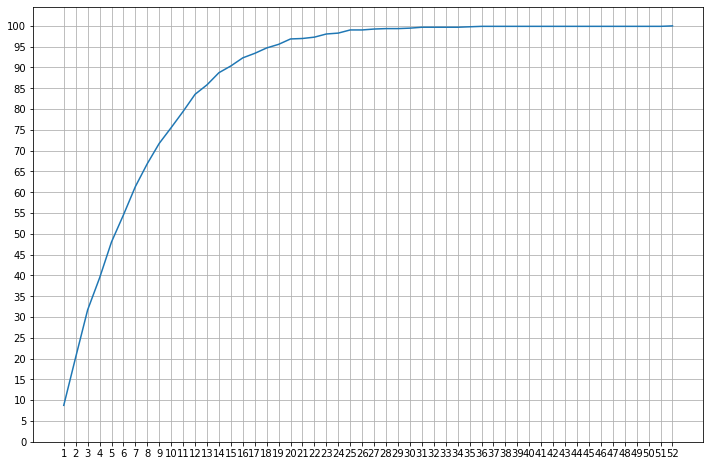

In [187]:
aaa = list(np.cumsum(rounds_with_exits['date_dif'].value_counts(bins=52).sort_index()))
newList = [x / 9.24 for x in aaa]
plt.figure(figsize=(12,8))
plt.plot(list(range(1, 53)), newList)
plt.yticks(np.arange(0,105,5))
plt.xticks(np.arange(1,53,1))
plt.grid(which='both')

In [188]:
a = list(rounds_with_exits['date_dif'].value_counts(bins=52).sort_index())
b = diff(a)
b

array([ 26,  -2, -34,   9, -20,   3, -12,  -6, -10,   1,   2, -17,   6,
       -12,   3,  -8,   2,  -4,   4, -11,   2,   4,  -5,   5,  -7,   2,
        -1,  -1,   1,   1,  -2,   0,   0,   1,   0,  -1,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1])

<BarContainer object of 52 artists>

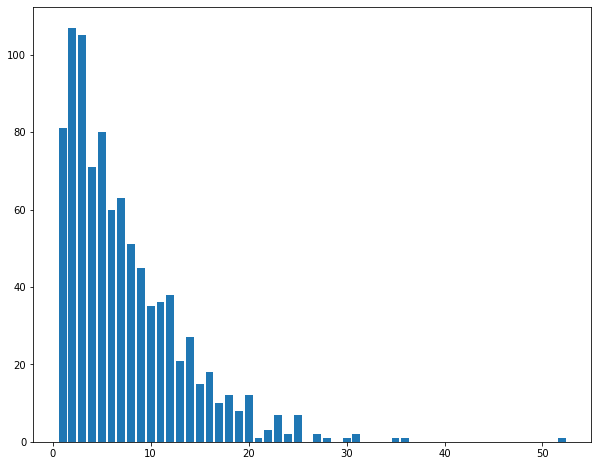

In [189]:
plt.figure(figsize=(10,8))
plt.bar(list(range(1, 53)), a)

In [190]:
distrib_plot_count = pd.DataFrame({'quartal': list(range(1, 53)), 'count': a})
distrib_plot_count.to_csv('tableau_plot2.csv', index=False, encoding = 'utf-8-sig')

Пик приходится на 14 квартал, то есть с 1191 по 1282 день (было на рубеже 1145 дней, то есть 13 квартал). После этого срока количество серьезно убывает и уже не восстанавливается. Отсюда получаем переменную для определения времени смерти стартапа - 91 * 14 + 1 = 1275 дней

### То же самое, но разница между всеми раундами

In [185]:
testing = filtered_rounds_with_exits_flags.sort_values(by=['company_uuid', 'announced_on'])
testing['time_between_round'] = testing.groupby(['company_uuid'])['announced_on'].diff()
testing

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd,suspect_acq_flag,foreign_currency_flag,debt_multiple_percentage,poor_series_flag,bad_round_flag,time_between_round
8741,Eligible,USA,NY,New York City,Brooklyn,seed,2015-01-14,NaN,NaN,NaN,NaN,NaN,NaN,43.0,https://www.crunchbase.com/funding-round/eligible-api,000ad7a8-b868-f301-5f00-2a3361288fc9,7a703ded-1829-90af-2368-ac0f9f628c61,2013-02-08 05:33:41,2018-02-12 23:39:22,"{""Y Combinator""}",{73633ee4-ea65-2967-6c5d-9b5fec7d2d5e},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,NaT
3053,Eligible,USA,NY,New York City,Brooklyn,series_unknown,2016-04-14,25200000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/eligible-api,000ad7a8-b868-f301-5f00-2a3361288fc9,2a40b289-8995-cde4-c370-81591ddf2015,2016-04-14 15:52:49,2018-02-12 23:46:27,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,456 days
15333,BioAtla LLC,USA,CA,San Diego,San Diego,series_unknown,2015-06-11,30000000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/bioatla,002e0b73-ab4e-bfd5-0d9a-e6df8fede446,d8bc42ee-f94f-3125-5b65-2e179ef4167a,2015-06-12 03:43:22,2018-02-12 23:46:10,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,NaT
10174,BioAtla LLC,USA,CA,San Diego,San Diego,series_unknown,2015-07-21,39000001.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/bioatla,002e0b73-ab4e-bfd5-0d9a-e6df8fede446,8fd125e6-2601-2209-5b57-db64444813ee,2015-07-22 12:30:53,2018-02-12 23:43:39,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,40 days
2007,BioAtla LLC,USA,CA,San Diego,San Diego,series_unknown,2016-01-11,45000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/bioatla,002e0b73-ab4e-bfd5-0d9a-e6df8fede446,1bf41f3a-f77a-67f6-2b7f-e132c5991a51,2016-01-12 03:56:16,2018-02-12 23:49:58,"{""Global BIO Impact Fund""}",{85004e7b-df75-cd69-b408-ce54613d064c},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,174 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4206,One Medical,USA,CA,SF Bay Area,San Francisco,series_e,2011-09-02,20000000.0,NaN,NaN,NaN,NaN,NaN,4.0,https://www.crunchbase.com/funding-round/one-medical-group,ffe74ad7-43eb-bd06-32ad-19de354a67bd,3a018605-49ae-0613-8526-554b9be1cf3f,2011-09-05 13:55:32,2018-02-12 23:52:55,"{Benchmark,""Maverick Capital"",""Oak Investment Partners""}","{fe2d1e8b-f607-3c9f-fad7-98fb8412f77e,cf3a40e6-920e-edfd-569e-371f84e0a4e4,36feed26-9375-138b-3eef-e1e00faa858f}",-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,974 days
9364,One Medical,USA,CA,SF Bay Area,San Francisco,series_unknown,2013-03-23,30000000.0,NaN,NaN,NaN,NaN,NaN,4.0,https://www.crunchbase.com/funding-round/one-medical-group,ffe74ad7-43eb-bd06-32ad-19de354a67bd,83b7cf13-190f-d5e5-1f71-70c51e6fb603,2013-10-23 07:50:31,2018-02-12 23:32:45,{GV},{3c62db15-4db8-016a-145e-dd1a06d168e2},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,568 days
17120,One Medical,USA,CA,SF Bay Area,San Francisco,private_equity,2014-04-17,40000000.0,NaN,NaN,NaN,NaN,NaN,6.0,https://www.crunchbase.com/funding-round/one-medical-group,ffe74ad7-43eb-bd06-32ad-19de354a67bd,f18be630-90e5-00e9-a91f-cef9732b3f86,2014-04-17 11:33:40,2018-02-13 00:50:09,"{""Redmile Group""}",{c391e6b7-32ae-2e64-cbb6-7d4c7d471b17},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,390 days
7719,One Medical,USA,CA,SF Bay Area,San Francisco,private_equity,2015-12-08,65000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/one-medical-group,ffe74ad7-43eb-bd06-32ad-19de354a67bd,6c1cc509-c026-9398-ddf8-bc25c3535bbe,2015-12-08 12:32:34,2018-02-12 23:34:43,"{""J.P. Morgan Asset Management""}",{d89fcb1f-9807-57aa-0526-08c11f3184ff},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,600 days


In [186]:
testing['time_between_round'].describe([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99])

count                           11449
mean      518 days 03:41:06.765656392
std       436 days 13:08:31.263585640
min                   0 days 00:00:00
1%                    2 days 00:00:00
10%                 113 days 00:00:00
20%                 204 days 00:00:00
30%                 279 days 00:00:00
40%                 351 days 00:00:00
50%                 422 days 00:00:00
60%                 503 days 00:00:00
70%                 606 days 00:00:00
80%                 741 days 00:00:00
90%                1001 days 00:00:00
99%      2134 days 12:28:48.000000032
max                6665 days 00:00:00
Name: time_between_round, dtype: object

In [187]:
testing['time_between_round'].value_counts(bins=64).sort_index()

(-7 days +08:02:23.999999999, 104 days 03:22:30]    1041
(104 days 03:22:30, 208 days 06:45:00]              1318
(208 days 06:45:00, 312 days 10:07:30]              1591
(312 days 10:07:30, 416 days 13:30:00]              1680
(416 days 13:30:00, 520 days 16:52:30]              1453
                                                    ... 
(6144 days 07:07:30, 6248 days 10:30:00]               0
(6248 days 10:30:00, 6352 days 13:52:30]               0
(6352 days 13:52:30, 6456 days 17:15:00]               0
(6456 days 17:15:00, 6560 days 20:37:30]               0
(6560 days 20:37:30, 6665 days 00:00:00]               1
Name: time_between_round, Length: 64, dtype: int64

In [188]:
a = list(testing['time_between_round'].value_counts(bins=64).sort_index())
b = diff(a)
b

array([ 277,  273,   89, -227, -310, -320, -215, -157, -137, -101,  -45,
        -29,  -32,  -32,   -9,  -31,    9,  -13,   -9,   -1,   -6,    1,
        -11,    7,   -3,   -3,   -1,    1,   -3,    0,    0,    2,   -4,
          5,   -6,    1,    0,    0,    0,   -1,    2,   -2,    0,    0,
          1,   -1,    0,    1,   -1,    0,    1,   -1,    0,    0,    1,
         -1,    0,    0,    0,    0,    0,    0,    1])

<BarContainer object of 64 artists>

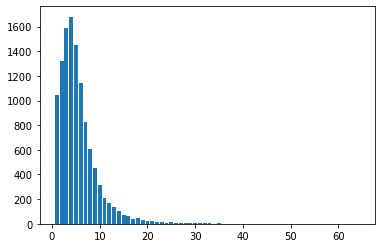

In [189]:
plt.bar(list(range(1, 65)), a)

Гэп между раундами - значительно меньше, чем до выхода (на год)

### Списки IPO и Acquisitions

In [190]:
filtered_ipos = filtered_ipos.loc[filtered_ipos['company_uuid'].isin(distinct_uuid)]
len(set(filtered_ipos['company_uuid'].values))

361

In [191]:
filtered_acquisitions = filtered_acquisitions.loc[filtered_acquisitions['acquiree_uuid'].isin(distinct_uuid)]
len(set(filtered_acquisitions['acquiree_uuid'].values))

629

In [192]:
exits = exits.loc[exits['company_uuid'].isin(distinct_uuid)]
len(set(exits['company_uuid'].values))

924

### Анализ раундов компаний, не имеющих выхода

In [193]:
len(set(filtered_rounds_with_exits_flags['company_uuid'].values))

3980

Эти компании можно считать финансируемыми из венчурных фондов - некоей аппроксимацией коллективного венчурного портфеля США за 2009-2018гг. Дальнейшие исследования будут производиться над этим датасетом.  
Сохраним все выбранные раунды для этих 3980 компаний для анализа регрессии доли привлеченных средств в капитале, которой в дальнейшем будем интерполировать капитализацию.

In [194]:
#filtered_rounds_with_exits_flags.to_csv('venture_funded_companies_09_18.csv', index=False, encoding = 'utf-8-sig')

In [195]:
len(set(exits['company_uuid'].values))

924

In [196]:
rounds_without_exit = filtered_rounds_with_exits_flags.loc[~filtered_rounds_with_exits_flags['company_uuid'].isin(exits['company_uuid'])]
len(set(rounds_without_exit['company_uuid'].values))

3056

Столько компаний не вышли на IPO и не были проданы до мая 2018 года. Рассмотрим даты их последних раундов в серии. По исследованию, проведенному выше, считаем компании мертвыми спустя 1275 (раньше 1145) дней без раундов

In [197]:
death_days

1366

In [198]:
suspect_exit = rounds_without_exit.groupby(['company_uuid'])['announced_on'].agg(['max','count']).reset_index()
dead_company = suspect_exit.loc[suspect_exit['max'] < pd.Timestamp(cb_database_enddate) - pd.Timedelta(days=death_days)]
dead_company

,company_uuid,max,count
2,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,2011-11-04,5
9,0133e167-b2b5-b665-c76c-e2a65203263d,2014-03-28,9
23,028f2da1-4fe1-1a99-e15c-852f2fb37700,2010-04-21,2
24,02949cbc-288a-4c1a-73e8-d16f29f4071a,2011-07-12,1
30,03167706-289e-d981-ffb1-cce8e422b9fd,2011-01-07,3
...,...,...,...
3033,fdc4d4da-b8e1-5ae1-48b9-6c355a25b4e3,2012-09-18,1
3039,fee326fb-eecb-7b06-f041-73671f5612d7,2010-02-02,1
3046,ff78c74d-d49c-6818-efc0-55c369535526,2012-09-19,1
3047,ff7cac81-4ec2-eace-bcb4-faea16a8cf84,2014-04-01,6


Столько компаний - мертвы

Итого в нашей выборке 924 (461) компании, дожившие до экзита, 641 (278) умершая компания и 2415 (1312) предположительно живые. Таким образом для обучения модели нас будет интересовать 1565 (739) компаний (39% от общего числа подпадающих под наши критерии на данном этапе). Создадим соответствующий датасет с раундами таких компаний.

In [199]:
solved_rounds = filtered_rounds_with_exits_flags.loc[(filtered_rounds_with_exits_flags['company_uuid'].isin(exits['company_uuid'])) | (filtered_rounds_with_exits_flags['company_uuid'].isin(dead_company['company_uuid']))]
len(solved_rounds)

5811

Это количество раундов для компаний с известным исходом

In [200]:
solved_distinct_uuid = set(solved_rounds['company_uuid'].values)
len(solved_distinct_uuid)

1501

### Анализ гэпов в раундах и проставление соответствующих флагов

In [201]:
solved_rounds['day_of_week'] = solved_rounds['announced_on'].dt.day_name()
solved_rounds.groupby(['day_of_week']).size().reset_index(name = 'count')

,day_of_week,count
0,Friday,720
1,Monday,1083
2,Saturday,159
3,Sunday,208
4,Thursday,1145
5,Tuesday,1260
6,Wednesday,1236


Это распределение инвестсобытий по дням недели (для всех компаний внезависимости от выхода)

In [202]:
solved_rounds['month'] = solved_rounds['announced_on'].dt.month
a = solved_rounds.groupby(['investment_type', 'month']).size().reset_index(name = 'count')
a.loc[a['investment_type'] == 'series_unknown']
#['angel', 'convertible_note', 'corporate_round', 'seed', 'series_a', 'series_b', 'series_c', 'series_d', 'series_e', 'series_f', 'series_g', 'series_h', 'series_i', 'series_unknown']

,investment_type,month,count
138,series_unknown,1,158
139,series_unknown,2,98
140,series_unknown,3,104
141,series_unknown,4,139
142,series_unknown,5,108
143,series_unknown,6,125
144,series_unknown,7,133
145,series_unknown,8,113
146,series_unknown,9,128
147,series_unknown,10,129


А это по месяцам

Расставим флаги различных гэпов

In [203]:
#solved_rounds['money_gap'] = '-'
#solved_rounds['time_gap'] = '-'
#solved_rounds['round_gap'] = '-'

In [204]:
#a = [0, np.nan]
#solved_rounds.loc[(solved_rounds['raised_amount_usd'].isin(a)) & (solved_rounds['post_money_valuation_usd'].isin(a)), 'money_gap'] = 'Zero_Sum'

Это флаг раунда с пустой суммой средств

In [205]:
#solved_rounds = solved_rounds.sort_values(by=['company_uuid', 'announced_on'])
#solved_rounds['time_gap'] = solved_rounds.groupby(['company_uuid'])['announced_on'].diff()
#solved_rounds.loc[solved_rounds['time_gap'] > pd.Timedelta("947 days 00:00:00"), 'time_gap'] = 'Time_gap'
#solved_rounds.loc[solved_rounds['time_gap'] != 'Time_gap', 'time_gap'] = '-'

Это флаг гэпа в 947 дней между каким-либо раундами

In [206]:
#filtered_rounds_with_flags[filtered_rounds_with_flags['investment_type'] == 'angel', 'investment_type_code'] == '-'
#filtered_rounds_with_flags[filtered_rounds_with_flags['investment_type'] == 'convertible_note', 'investment_type_code'] == '-'
#filtered_rounds_with_flags[filtered_rounds_with_flags['investment_type'] == 'corporate_round', 'investment_type_code'] == '-'
#filtered_rounds_with_flags[filtered_rounds_with_flags['investment_type'] == 'series_unknown', 'investment_type_code'] == '-'

# a = ['seed', 'series_a', 'series_b', 'series_c', 'series_d', 'series_e', 'series_f', 'series_g', 'series_h']
# testing = solved_rounds.loc[solved_rounds['investment_type'].isin(a)]
# testing.loc[testing['investment_type'] == 'seed', 'investment_type_code'] = 1
# testing.loc[testing['investment_type'] == 'series_a', 'investment_type_code'] = 2
# testing.loc[testing['investment_type'] == 'series_b', 'investment_type_code'] = 3
# testing.loc[testing['investment_type'] == 'series_c', 'investment_type_code'] = 4
# testing.loc[testing['investment_type'] == 'series_d', 'investment_type_code'] = 5
# testing.loc[testing['investment_type'] == 'series_e', 'investment_type_code'] = 6
# testing.loc[testing['investment_type'] == 'series_f', 'investment_type_code'] = 7
# testing.loc[testing['investment_type'] == 'series_g', 'investment_type_code'] = 8
# testing.loc[testing['investment_type'] == 'series_h', 'investment_type_code'] = 9

# testing = testing.sort_values(by=['company_uuid', 'announced_on'])
# testing['round_gap'] = testing.groupby(['company_uuid'])['investment_type_code'].diff()

# solved_rounds['round_gap'] = solved_rounds['funding_round_uuid'].map(testing.set_index('funding_round_uuid')['round_gap'])

Есть несколько возможных случаев расставляемых чисел:  
    1) NaN - ни о чем нам не говорит, это либо первый раунд в серии, либо нерассматриваемый в качестве индикатора гэпа  
    2) <0 - неправильная последовательность раундов (series_a -> seed -> series_b) - ТАКИЕ СЛУЧАИ ПРОВЕРЯЕМ ВРУЧНУЮ  
    3) 0  - два одинаковых раунда подряд (series_a -> series_a) - НЕ ПРОВЕРЯЕМ, БУДЕМ СХЛОПЫВАТЬ ВМЕСТЕ И АГРЕРИРОВАТЬ СУММЫ  
    4) 1 - все в порядке (series_a -> series_b)  
    5) >1 - существует гэп, то есть пропущенная буква в серии (series_a -> series_c) - ПОКА НЕ РЕШИЛИ

Компании из пункта 2 с нарушенной последовательностью раундов проверим вручную и удалим лишние

In [207]:
# error_rounds = solved_rounds.loc[solved_rounds['round_gap'] < 0]
# error_rounds

In [208]:
# error_rounds_uuid = error_rounds.groupby(['company_name', 'company_uuid']).size().reset_index(name = 'count')
# error_rounds_uuid

In [209]:
#rounds.loc[rounds['company_uuid'] == 'b8f03775-5295-01cb-7a9f-ae802066a9c8'].sort_values(by=['announced_on'])

Centric Software - оставляем

In [210]:
#rounds.loc[rounds['company_uuid'] == '8d7e907e-a7b8-14a4-47d4-4fa9ed5bb014'].sort_values(by=['announced_on'])

ICON Aircraft - китайцы и много сложностей, убираем

In [211]:
#solved_rounds = solved_rounds.loc[solved_rounds['company_uuid'] != '8d7e907e-a7b8-14a4-47d4-4fa9ed5bb014']

In [212]:
#rounds.loc[rounds['company_uuid'] == '78dd4c59-9c6d-00a7-35d3-e4fc65e45727'].sort_values(by=['announced_on'])

Liaison Technologies - оставляем

In [213]:
#rounds.loc[rounds['company_uuid'] == '66074e0b-5c4e-e064-f9e7-29c53804d9ae'].sort_values(by=['announced_on'])

Ring - пока непонятно, найти инвесторов отсутствующих раундов

In [214]:
#rounds.loc[rounds['company_uuid'] == 'a4032bb5-baca-d5ca-cc23-145255e7c6ba'].sort_values(by=['announced_on'])

Ruckus Wireless - согласно S-1 работа началась в 2004 году, до этого псевдораунд-опцион - оставляем

In [215]:
#rounds.loc[rounds['company_uuid'] == '17f0e76e-ad8d-09b2-7f7c-3db8bfbac85d'].sort_values(by=['announced_on'])

Upwork - merger, выкидываем

In [216]:
#solved_rounds = solved_rounds.loc[solved_rounds['company_uuid'] != '17f0e76e-ad8d-09b2-7f7c-3db8bfbac85d']

In [217]:
#rounds.loc[rounds['company_uuid'] == '212aeae8-df26-b768-33d1-b18c45998f65'].sort_values(by=['announced_on'])

Xanodyne - это очередной merger. Ставим флаг merger и выкидываем.

In [218]:
#solved_rounds = solved_rounds.loc[solved_rounds['company_uuid'] != '212aeae8-df26-b768-33d1-b18c45998f65']

In [219]:
solved_distinct_uuid = set(solved_rounds['company_uuid'].values)
len(solved_distinct_uuid)

1501

### Создание списка компаний

In [220]:
solved_rounds['region'] = solved_rounds['region'].replace(np.nan, '-')
solved_rounds['city'] = solved_rounds['city'].replace(np.nan, '-')
company_list = solved_rounds.groupby(['company_name', 'region', 'city', 'company_uuid']).size().reset_index(name = 'number_of_rounds')
company_list['exit_type'] = '-'
company_list['exit_type'] = company_list['company_uuid'].map(exits.set_index('company_uuid')['exit_type'])
company_list.loc[(company_list['exit_type'] != 'ipo') & (company_list['exit_type'] != 'sold'), 'exit_type'] = 'dead'
a = organizations[['uuid', 'homepage_url', 'linkedin_url', 'cb_url']]
a.rename(columns = {'uuid' : 'company_uuid'}, inplace = True)
company_list = company_list.merge(a, how = 'left', on = 'company_uuid')
company_list

,company_name,region,city,company_uuid,number_of_rounds,exit_type,homepage_url,linkedin_url,cb_url
0,1010data,New York City,New York,4d243500-064f-cad3-42cc-da711cff9966,1,sold,http://www.1010data.com,http://www.linkedin.com/company/1010data_2,https://www.crunchbase.com/organization/1010data
1,1Life Healthcare,SF Bay Area,San Francisco,bc6b1ba7-78e3-f3bd-a42d-be7394d41f90,6,dead,http://www.1life.com,NaN,https://www.crunchbase.com/organization/1life-healthcare
2,1stdibs,New York City,New York,f6a755de-ebe8-8d24-407b-a14b5c36f072,3,dead,http://www.1stdibs.com,http://www.linkedin.com/company/1stdibs.com,https://www.crunchbase.com/organization/1stdibs
3,2Checkout,"Columbus, Ohio",Columbus,018d73c8-de1c-de16-686b-c596a5401a87,1,sold,http://www.2checkout.com,http://www.linkedin.com/company/2checkout.com,https://www.crunchbase.com/organization/2checkout-com
4,2U Inc.,MD - Other,Hyattsville,da9c5e38-35ef-54e8-7ca7-72494f0d9f72,6,ipo,http://2u.com,https://www.linkedin.com/company/2u,https://www.crunchbase.com/organization/2u
...,...,...,...,...,...,...,...,...,...
1496,sezmi,SF Bay Area,Belmont,f65b1a25-260d-fe24-c3bc-d94a50565cbf,5,sold,http://www.sezmi.com,NaN,https://www.crunchbase.com/organization/sezmi
1497,tastytrade,Chicago,Chicago,b76c2546-667f-b787-f9e5-dcd7ab4a823d,1,dead,http://www.tastytrade.com,NaN,https://www.crunchbase.com/organization/tastytrade
1498,theAudience,Los Angeles,Los Angeles,a8c81ca5-8e38-e6b6-82a4-172c65b4661f,1,sold,http://theaudience.com,https://www.linkedin.com/company/theaudience,https://www.crunchbase.com/organization/theaudience
1499,true[x],Los Angeles,Los Angeles,ba4b66a7-8f23-2690-e04e-c435ae09178c,5,sold,http://www.truex.com,http://www.linkedin.com/company/truex,https://www.crunchbase.com/organization/truex-media


Это список компаний, удовлетворяющих всем фильтрам

Ниже - список "живых" (активных) компаний, не имеющих выхода на последнюю дату датасета (2018 год)

In [221]:
rounds_without_exit['region'] = rounds_without_exit['region'].replace(np.nan, '-')
rounds_without_exit['city'] = rounds_without_exit['city'].replace(np.nan, '-')
active_company_list = rounds_without_exit.loc[~rounds_without_exit['company_uuid'].isin(dead_company['company_uuid'].values)]
active_company_list = active_company_list.groupby(['company_name', 'region', 'city', 'company_uuid']).size().reset_index(name = 'number_of_rounds')
active_company_list

,company_name,region,city,company_uuid,number_of_rounds
0,HIG Holdings,Dallas,Fort Worth,4eed04fb-9c94-4619-b2d0-5bbc6c769758,2
1,Harbor,SF Bay Area,San Francisco,f3554295-24e9-4f97-86b6-b185fefc42d2,2
2,NimbleRx,SF Bay Area,Menlo Park,64a09e0d-bd35-4dad-ae57-43874efb1220,4
3,Renew Energy Partners,Boston,Boston,2d7937a4-d765-40b4-b007-1210beb15755,1
4,Spruce Biosciences,SF Bay Area,San Francisco,0be3da03-077f-4813-8128-eee2c2f1c70a,1
...,...,...,...,...,...
2474,vArmour,SF Bay Area,Mountain View,8adc81f0-fa39-3726-bb1e-73a6165dd9fe,4
2475,x.ai,New York City,New York,d2e42e38-102c-f242-56c2-d50e950188d8,4
2476,xMatters,SF Bay Area,San Ramon,9790e497-a7cf-52dc-c852-f7770c0ad4b7,4
2477,yello,Chicago,Chicago,299f536c-1891-239b-7052-69d44e421e4c,4


In [222]:
DEMO_SET = rounds_without_exit.loc[rounds_without_exit['company_name'].isin(['JFrog',
'Snowflake Computing',
'Asana',
'Unity Technologies',
'Sumo Logic',
'Roblox Corporation',
'Lemonade',
'DoorDash',
'Airbnb',
'Palantir Technologies'])].sort_values(by=['company_name', 'announced_on'])
DEMO_SET

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd,suspect_acq_flag,foreign_currency_flag,debt_multiple_percentage,poor_series_flag,bad_round_flag
987,Airbnb,USA,CA,SF Bay Area,San Francisco,seed,2009-01-01,20000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/airbnb,bcb617c3-9e43-d5b0-1d14-82b795f2642f,0ddb5b94-0c36-6a61-3194-00490c89804a,2009-03-04 10:06:23,2018-02-12 23:38:27,"{""Y Combinator""}",{73633ee4-ea65-2967-6c5d-9b5fec7d2d5e},-,NaT,NaN,NaN,NaN,-,-,1.0,-,-
13188,Airbnb,USA,CA,SF Bay Area,San Francisco,seed,2009-04-01,600000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/airbnb,bcb617c3-9e43-d5b0-1d14-82b795f2642f,ba7b61b6-33ca-1b0d-7d91-2fed65efc5ec,2010-03-30 01:19:36,2018-02-12 23:44:13,"{""Sequoia Capital""}",{0c867fde-2b9a-df10-fdb9-66b74f355f91},-,NaT,NaN,NaN,NaN,-,-,1.0,-,-
3034,Airbnb,USA,CA,SF Bay Area,San Francisco,series_a,2010-11-10,NaN,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/airbnb,bcb617c3-9e43-d5b0-1d14-82b795f2642f,29fa936e-0ddc-404e-b09e-d8e00d40c7ee,2018-03-25 14:28:03,2018-03-25 14:28:03,{},{},-,NaT,NaN,NaN,NaN,-,-,1.0,-,-
16276,Airbnb,USA,CA,SF Bay Area,San Francisco,series_a,2010-11-10,7200000.0,NaN,NaN,NaN,NaN,NaN,8.0,https://www.crunchbase.com/funding-round/airbnb,bcb617c3-9e43-d5b0-1d14-82b795f2642f,e5e53009-a100-e579-0c07-4f44416c959a,2010-11-11 02:20:56,2018-02-12 23:38:20,"{""Greylock Partners""}",{e2006571-6b7a-e477-002a-f7014f48a7e3},-,NaT,NaN,NaN,NaN,-,-,1.0,-,-
14926,Airbnb,USA,CA,SF Bay Area,San Francisco,series_b,2011-07-25,112000000.0,NaN,NaN,1.312000e+09,NaN,NaN,8.0,https://www.crunchbase.com/funding-round/airbnb,bcb617c3-9e43-d5b0-1d14-82b795f2642f,d2e9a4b6-3710-e2ea-a5c1-0ec849bde45f,2011-05-31 01:22:38,2018-02-12 23:35:30,"{""Andreessen Horowitz""}",{ce91bad7-b6d8-e56e-0f45-4763c6c5ca29},-,NaT,NaN,NaN,NaN,-,-,1.0,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11049,Unity Technologies,USA,CA,SF Bay Area,San Francisco,series_b,2011-07-20,15000000.0,NaN,NaN,NaN,NaN,NaN,3.0,https://www.crunchbase.com/funding-round/unity-technologies,8bb8f294-4617-2031-5d2e-8ca53ffb71dd,9bed1cb1-d7fe-62b4-c2ed-c86390443ab6,2011-07-20 23:57:51,2018-02-12 23:34:10,"{""iGlobe Partners"",""WestSummit Capital""}","{b979f83e-ff8f-e91a-669f-dd33a71d4106,b1ed048d-c887-788c-9742-2b3b26bdc780}",-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
16731,Unity Technologies,USA,CA,SF Bay Area,San Francisco,series_unknown,2015-09-24,25000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/unity-technologies,8bb8f294-4617-2031-5d2e-8ca53ffb71dd,ec316956-f985-9753-56ad-0e1a9d755ed1,2016-09-19 05:53:17,2018-02-12 23:40:21,"{""Sequoia Capital""}",{0c867fde-2b9a-df10-fdb9-66b74f355f91},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
15726,Unity Technologies,USA,CA,SF Bay Area,San Francisco,series_unknown,2015-12-09,62696700.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/unity-technologies,8bb8f294-4617-2031-5d2e-8ca53ffb71dd,de331f48-481c-6bb2-a1b3-ef438475040d,2016-09-19 05:49:23,2018-02-12 23:24:45,"{""Sequoia Capital""}",{0c867fde-2b9a-df10-fdb9-66b74f355f91},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
5386,Unity Technologies,USA,CA,SF Bay Area,San Francisco,series_c,2016-07-13,181000000.0,NaN,NaN,1.500000e+09,NaN,NaN,8.0,https://www.crunchbase.com/funding-round/unity-technologies,8bb8f294-4617-2031-5d2e-8ca53ffb71dd,4a87f25b-480c-d60f-d74b-5d2988f1ca46,2016-07-13 22:45:06,2018-02-12 22:28:38,"{""DFJ Growth""}",{ca770ff6-5fec-0c77-4785-8b0fa96832e1},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-


In [223]:
DEMO_SET2 = rounds_without_exit.loc[rounds_without_exit['company_uuid'].isin(['c33875ec-72a5-5518-09d8-ad3e9ae5480b',
'1ae98351-ff50-d20a-974f-512021e0bbe9',
'058a5313-ec27-d591-e912-2931b98e99ed',
'26b73ae3-6949-3e88-04d2-cde471284234',
'94a87fdd-143f-5b2d-2c35-3a02cde56b29',
'1dd40007-baeb-2b39-4c03-1115e1a6d519',
'e928b9b4-eabd-29df-1182-1c5d86b45286',
'7743d741-de58-63ec-04ba-ff7165d77543',
'2ad4aea2-6c34-1f31-066d-fabc0ce51875',
'be6be32e-ceca-7f4e-0863-fac1a33ef3d7',
'1942485b-4e5f-ca5d-767f-db23a8fbc817',
'99b341b4-8a9f-f175-d747-dd1d914d462e',
'8a29ad3a-0a61-5c2e-44e7-d6c38f02d851',
'280b0592-98a6-2820-ba49-a6c630eb71fb',
'61637e8a-c007-fe89-a95d-169e7553c586',
'd3e27717-7cb2-adcb-38b9-975a6c385524',
'0d897713-b7fe-c5af-5d8f-cac62ddbef5c',
'6f634196-2eb0-132c-9169-87dabfec047e',
'2efa962d-8d12-b0d1-2ab7-7be1b2269863',
'a9b6dedd-d269-ca3e-4a91-425fd89cf326',
'caf5688e-5d13-a413-f90c-71ff764a4c2f'])].sort_values(by=['company_uuid', 'announced_on'])
DEMO_SET2

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd,suspect_acq_flag,foreign_currency_flag,debt_multiple_percentage,poor_series_flag,bad_round_flag
5539,VertiFlex,USA,CA,Anaheim,San Clemente,series_a,2005-07-07,6330000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/vertiflex,058a5313-ec27-d591-e912-2931b98e99ed,4cb76778-cc8c-f4dd-18bf-3d06780a495c,2017-03-20 13:32:45,2018-02-12 23:49:40,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
13683,VertiFlex,USA,CA,Anaheim,San Clemente,series_b,2007-01-22,20000000.0,NaN,NaN,NaN,NaN,NaN,3.0,https://www.crunchbase.com/funding-round/vertiflex,058a5313-ec27-d591-e912-2931b98e99ed,c1920c7e-4a62-3275-a1a7-7387c6348a99,2015-11-11 09:43:58,2018-02-12 23:51:59,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
350,VertiFlex,USA,CA,Anaheim,San Clemente,series_c,2008-06-25,28280000.0,NaN,NaN,NaN,NaN,NaN,4.0,https://www.crunchbase.com/funding-round/vertiflex,058a5313-ec27-d591-e912-2931b98e99ed,04c77602-7878-8e0c-3e8a-5598a82ac0e9,2017-03-20 12:53:55,2018-02-12 23:11:55,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
14689,VertiFlex,USA,CA,Anaheim,San Clemente,series_unknown,2009-07-30,8000000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/vertiflex,058a5313-ec27-d591-e912-2931b98e99ed,cf92817c-9369-d8c4-a836-5ffc239de485,2017-03-20 13:02:19,2018-02-12 23:48:24,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
11211,VertiFlex,USA,CA,Anaheim,San Clemente,series_unknown,2010-07-02,2000000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/vertiflex,058a5313-ec27-d591-e912-2931b98e99ed,9e838a61-e07a-1d2b-6b2a-77ebc739914a,2017-03-20 13:06:13,2018-02-12 23:54:05,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5529,Airware,USA,CA,SF Bay Area,San Francisco,series_unknown,2015-04-16,NaN,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/airware,e928b9b4-eabd-29df-1182-1c5d86b45286,4c9555f0-45d6-f525-a8f4-b41a51896ec1,2015-06-27 05:06:34,2018-02-12 23:43:01,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
8457,Airware,USA,CA,SF Bay Area,San Francisco,series_c,2016-03-31,30000000.0,NaN,NaN,NaN,NaN,NaN,5.0,https://www.crunchbase.com/funding-round/airware,e928b9b4-eabd-29df-1182-1c5d86b45286,7664eaf3-c095-5068-843f-88ca44702351,2016-03-31 08:19:45,2018-02-12 23:42:34,"{""NextWorld Capital""}",{2ae0bffb-fe0c-326b-1510-514d0cca0233},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
10370,Airware,USA,CA,SF Bay Area,San Francisco,series_unknown,2016-05-26,39130000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/airware,e928b9b4-eabd-29df-1182-1c5d86b45286,92b108f5-58f8-aef3-cfd9-fa8d67381002,2016-10-06 10:48:37,2018-02-12 23:51:19,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
14307,Airware,USA,CA,SF Bay Area,San Francisco,series_unknown,2017-02-02,NaN,NaN,NaN,NaN,NaN,NaN,9.0,https://www.crunchbase.com/funding-round/airware,e928b9b4-eabd-29df-1182-1c5d86b45286,ca02dceb-dd40-4bca-8420-4ad506d4b1d6,2017-02-02 17:13:26,2018-02-12 22:36:09,"{""Caterpillar, Inc""}",{201e94e7-a1a0-9330-76a4-467f3c0fd29c},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-


In [224]:
DEMO_SET_ALL = rounds_without_exit.sort_values(by=['company_uuid', 'announced_on'])
DEMO_SET_ALL

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd,suspect_acq_flag,foreign_currency_flag,debt_multiple_percentage,poor_series_flag,bad_round_flag
8741,Eligible,USA,NY,New York City,Brooklyn,seed,2015-01-14,NaN,NaN,NaN,NaN,NaN,NaN,43.0,https://www.crunchbase.com/funding-round/eligible-api,000ad7a8-b868-f301-5f00-2a3361288fc9,7a703ded-1829-90af-2368-ac0f9f628c61,2013-02-08 05:33:41,2018-02-12 23:39:22,"{""Y Combinator""}",{73633ee4-ea65-2967-6c5d-9b5fec7d2d5e},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
3053,Eligible,USA,NY,New York City,Brooklyn,series_unknown,2016-04-14,25200000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/eligible-api,000ad7a8-b868-f301-5f00-2a3361288fc9,2a40b289-8995-cde4-c370-81591ddf2015,2016-04-14 15:52:49,2018-02-12 23:46:27,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
15333,BioAtla LLC,USA,CA,San Diego,San Diego,series_unknown,2015-06-11,30000000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/bioatla,002e0b73-ab4e-bfd5-0d9a-e6df8fede446,d8bc42ee-f94f-3125-5b65-2e179ef4167a,2015-06-12 03:43:22,2018-02-12 23:46:10,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
10174,BioAtla LLC,USA,CA,San Diego,San Diego,series_unknown,2015-07-21,39000001.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/bioatla,002e0b73-ab4e-bfd5-0d9a-e6df8fede446,8fd125e6-2601-2209-5b57-db64444813ee,2015-07-22 12:30:53,2018-02-12 23:43:39,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
2007,BioAtla LLC,USA,CA,San Diego,San Diego,series_unknown,2016-01-11,45000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/bioatla,002e0b73-ab4e-bfd5-0d9a-e6df8fede446,1bf41f3a-f77a-67f6-2b7f-e132c5991a51,2016-01-12 03:56:16,2018-02-12 23:49:58,"{""Global BIO Impact Fund""}",{85004e7b-df75-cd69-b408-ce54613d064c},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4206,One Medical,USA,CA,SF Bay Area,San Francisco,series_e,2011-09-02,20000000.0,NaN,NaN,NaN,NaN,NaN,4.0,https://www.crunchbase.com/funding-round/one-medical-group,ffe74ad7-43eb-bd06-32ad-19de354a67bd,3a018605-49ae-0613-8526-554b9be1cf3f,2011-09-05 13:55:32,2018-02-12 23:52:55,"{Benchmark,""Maverick Capital"",""Oak Investment Partners""}","{fe2d1e8b-f607-3c9f-fad7-98fb8412f77e,cf3a40e6-920e-edfd-569e-371f84e0a4e4,36feed26-9375-138b-3eef-e1e00faa858f}",-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
9364,One Medical,USA,CA,SF Bay Area,San Francisco,series_unknown,2013-03-23,30000000.0,NaN,NaN,NaN,NaN,NaN,4.0,https://www.crunchbase.com/funding-round/one-medical-group,ffe74ad7-43eb-bd06-32ad-19de354a67bd,83b7cf13-190f-d5e5-1f71-70c51e6fb603,2013-10-23 07:50:31,2018-02-12 23:32:45,{GV},{3c62db15-4db8-016a-145e-dd1a06d168e2},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
17120,One Medical,USA,CA,SF Bay Area,San Francisco,private_equity,2014-04-17,40000000.0,NaN,NaN,NaN,NaN,NaN,6.0,https://www.crunchbase.com/funding-round/one-medical-group,ffe74ad7-43eb-bd06-32ad-19de354a67bd,f18be630-90e5-00e9-a91f-cef9732b3f86,2014-04-17 11:33:40,2018-02-13 00:50:09,"{""Redmile Group""}",{c391e6b7-32ae-2e64-cbb6-7d4c7d471b17},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
7719,One Medical,USA,CA,SF Bay Area,San Francisco,private_equity,2015-12-08,65000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/one-medical-group,ffe74ad7-43eb-bd06-32ad-19de354a67bd,6c1cc509-c026-9398-ddf8-bc25c3535bbe,2015-12-08 12:32:34,2018-02-12 23:34:43,"{""J.P. Morgan Asset Management""}",{d89fcb1f-9807-57aa-0526-08c11f3184ff},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-


In [225]:
active_company_list.to_csv('active_company_list.csv', index=False, encoding = 'utf-8-sig')

In [226]:
filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['company_uuid'].isin(active_company_list['company_uuid'])]

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd,suspect_acq_flag,foreign_currency_flag,debt_multiple_percentage,poor_series_flag,bad_round_flag
0,Factual,USA,CA,Los Angeles,Los Angeles,seed,2010-02-03,2000000.0,NaN,NaN,NaN,NaN,NaN,13.0,https://www.crunchbase.com/funding-round/factual,c6eda1e4-c526-037a-c556-8af22254f01f,00043331-9b35-507f-990e-72e376cdf7b8,2010-02-04 19:14:31,2018-02-12 22:23:14,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
1,Integral Ad Science,USA,NY,New York City,New York,series_e,2015-07-29,27000070.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/integralads,05ac5fd9-bea2-4a12-c94c-4887dc48bb1b,0008d7cd-2233-7ac0-499f-d6bd79322751,2015-07-30 09:18:17,2018-02-12 22:34:20,"{""Sapphire Ventures""}",{ea5de28f-7493-f605-c3fd-51965a5b5aba},-,NaT,NaN,NaN,NaN,-,-,1.0,-,-
3,Soothe,USA,CA,Los Angeles,Los Angeles,seed,2015-02-11,1700000.0,NaN,NaN,NaN,NaN,NaN,10.0,https://www.crunchbase.com/funding-round/soothe,f48a8e9e-988f-4342-dea1-3ead78998827,0017fac0-5511-0f21-812f-d55be2009c04,2015-02-11 18:53:57,2018-02-12 22:37:13,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
7,Gynesonics,USA,CA,SF Bay Area,Redwood City,private_equity,2015-07-22,43000000.0,NaN,NaN,NaN,NaN,NaN,6.0,https://www.crunchbase.com/funding-round/gynesonics,bbf7caed-cb22-fbb7-8c6a-049e54ac3d41,0027d536-24f1-9847-ae6e-18fdf2e57602,2015-07-22 11:18:22,2018-02-12 23:56:09,"{""Endeavour Vision""}",{738284b4-4aae-46ed-ca7c-776ab1552257},-,NaT,NaN,NaN,NaN,-,-,1.0,-,-
8,ImaginAb,USA,CA,Los Angeles,Inglewood,series_a,2012-03-27,12500000.0,NaN,NaN,NaN,NaN,NaN,3.0,https://www.crunchbase.com/funding-round/imaginab,ec938d33-9a06-9a7b-6c47-92437c42d6e3,00292f78-b23d-d0c1-23c8-f058a4f54d43,2012-03-28 01:23:56,2018-02-12 23:10:42,"{""Novartis Venture Fund""}",{1eb5764e-21ca-9b3a-7e62-ffa6bd38b35d},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18131,ProsperWorks,USA,CA,SF Bay Area,San Francisco,series_c,2017-09-26,53000000.0,NaN,NaN,NaN,NaN,NaN,3.0,https://www.crunchbase.com/funding-round/prosperworks,a3c47f33-8995-ed45-a48f-8a91ab847dbf,ffe5c70f-4f4c-42d9-36fa-c65a713fdde7,2017-09-26 11:48:10,2018-02-12 23:52:18,"{""Norwest Venture Partners""}",{4ab1b039-d9ce-f96a-06e7-f737e37eee08},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
18133,Satellogic,USA,CA,SF Bay Area,Palo Alto,series_a,2015-03-15,NaN,NaN,NaN,NaN,NaN,NaN,4.0,https://www.crunchbase.com/funding-round/satellogic,667968bf-30df-f62a-8809-015c00310117,ffe85943-df5a-3c78-e3d3-554502b2dd59,2015-03-12 16:40:12,2018-02-12 23:50:45,"{""Tencent Holdings"",""Valor Capital Group""}","{3cae090b-ed2d-95f8-79a9-e32ca480258f,eabee8b0-79dd-6637-a2d9-53b0db78784f}",-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
18134,SpotHero,USA,IL,Chicago,Chicago,series_unknown,2012-12-13,2500000.0,NaN,NaN,NaN,NaN,NaN,8.0,https://www.crunchbase.com/funding-round/spothero,df8aee9a-9774-acd0-c320-1e72f863c1c0,ffe8ae02-394b-297a-1c9a-0c774b5ce9cf,2014-06-04 14:35:40,2018-02-13 00:28:18,"{""Battery Ventures""}",{7a42b564-4bb6-5864-6cdb-a0100008f3b3},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
18136,Dashlane,USA,NY,New York City,New York,series_a,2012-09-28,3000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/dashlane,cb1d7d46-ca74-c0c3-02f0-576dd57360f1,ffe94e25-3d37-bb8c-7d6d-98cdb7b2b3a7,2014-04-23 12:34:19,2018-02-12 23:40:30,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-


Добавим экзиты и смерти как отдельные раунды в инвестиционные истории для выбранных компаний

In [227]:
exits = exits.loc[exits['company_uuid'].isin(solved_rounds['company_uuid'].values)]
exits = exits.drop(['exit_date', 'exit_type', 'price_usd', 'money_raised_usd'], axis=1)
exits = exits.merge(solved_rounds, how = 'left', on = 'company_uuid').drop_duplicates(subset='company_uuid').reset_index(drop=True)
exits['investment_type'] = exits['exit_type']
exits['announced_on'] = exits['exit_date']
exits['raised_amount_usd'] = exits['money_raised_usd']
exits['post_money_valuation_usd'] = exits['price_usd']
exits['funding_round_uuid'] = '-'
exits

,company_uuid,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd,suspect_acq_flag,foreign_currency_flag,debt_multiple_percentage,poor_series_flag,bad_round_flag,day_of_week,month
0,009e8957-d102-c674-6c9c-98eb11ac8e32,CardiAQ Valve Technologies,USA,CA,Anaheim,Irvine,sold,2015-07-10,NaN,NaN,NaN,3.500000e+08,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/cardiaq,-,2012-11-30 05:06:42,2018-02-12 23:42:01,{OrbiMed},{01b78c00-b6e2-7cbc-8286-8d14d09d441e},-,2015-07-10,sold,3.500000e+08,NaN,-,-,1.0,-,-,Thursday,11
1,00e12273-bfa7-d0ac-25e2-c870ab22c474,CellBiosciences,USA,CA,SF Bay Area,Santa Clara,sold,2014-06-17,NaN,NaN,NaN,3.000000e+08,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/cell-biosciences,-,2009-12-21 18:48:01,2018-02-12 23:50:29,{},{},-,2014-06-17,sold,3.000000e+08,NaN,-,-,0.0,-,-,Monday,12
2,018d73c8-de1c-de16-686b-c596a5401a87,2Checkout,USA,OH,"Columbus, Ohio",Columbus,sold,2017-04-03,NaN,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/2checkout-com,-,2014-04-24 12:10:52,2018-02-12 23:57:20,"{""Chicago Growth Partners"",""Trident Capital""}","{81ca3ab0-ddb5-2ad5-6d0f-0ca278d43ddf,28d3ff99-0fcb-dce0-8c56-f6d2678c66a1}",-,2017-04-03,sold,NaN,NaN,-,-,1.0,-,-,Wednesday,7
3,022bddcc-e01a-a6de-91e9-b93cfcc5a9ee,Box,USA,CA,SF Bay Area,Redwood City,ipo,2015-01-23,175000000.0,NaN,NaN,1.670000e+09,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/box,-,2007-07-18 02:00:52,2018-02-12 23:53:45,{DFJ},{ac53f2c3-4fd6-45c3-3a21-966c4d950f8f},-,2015-01-23,ipo,1.670000e+09,175000000.0,-,-,0.0,-,-,Sunday,10
4,022e9e39-e769-9229-7e1e-f6bd4e6c0241,Kala Pharmaceuticals,USA,MA,Boston,Waltham,ipo,2017-07-20,90000000.0,NaN,NaN,3.490000e+08,NaN,NaN,6.0,https://www.crunchbase.com/funding-round/kala-pharmaceuticals,-,2014-04-23 10:57:30,2018-02-12 23:43:02,"{""Ysios Capital""}",{3328ebbd-d05a-2fe3-6a75-0eaff4808af7},-,2017-07-20,ipo,3.490000e+08,90000000.0,-,-,0.0,-,-,Wednesday,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,ff2e8a28-8be7-75a4-1355-d76aed738bf9,Birst,USA,CA,SF Bay Area,San Francisco,sold,2017-04-25,NaN,NaN,NaN,NaN,NaN,NaN,3.0,https://www.crunchbase.com/funding-round/birst,-,2012-05-02 13:19:00,2018-02-12 23:42:00,"{""Sequoia Capital""}",{0c867fde-2b9a-df10-fdb9-66b74f355f91},-,2017-04-25,sold,NaN,NaN,-,-,0.0,-,-,Tuesday,5
920,ff429091-2166-c3b5-409d-6e779fee09f5,Juno Therapeutics,USA,WA,Seattle,Seattle,ipo,2014-12-19,264600000.0,NaN,NaN,1.675700e+09,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/juno-therapeutics,-,2014-04-24 12:44:18,2018-02-12 23:54:53,"{""Bezos Expeditions"",Venrock}","{3f84af76-a812-49c0-a05f-e45db4b2ef53,ed24f9ce-2313-cb8c-8ff2-9de6899ea992}",-,2014-12-19,ipo,1.675700e+09,264600000.0,-,-,0.0,-,-,Thursday,4
921,ff50b33a-5cda-630c-8fa8-a6eb646c2a48,Sendachi,USA,WA,Seattle,Seattle,sold,2016-01-21,NaN,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/sendachi,-,2016-01-21 12:49:42,2018-02-13 01:18:09,"{""Columbia Capital""}",{86aace17-c860-1f72-d272-94999baad33b},-,2016-01-21,sold,NaN,NaN,-,-,0.0,-,-,Thursday,1
922,ff65b5a2-e2f4-1557-b091-e93dfe88873e,Aster Data Systems,USA,CA,SF Bay Area,San Carlos,sold,2011-03-03,NaN,NaN,NaN,2.630000e+08,NaN,NaN,5.0,https://www.crunchbase.com/funding-round/aster-data-systems,-,2008-05-20 05:51:52,2018-02-12 23:45:21,{},{},-,2011-03-03,sold,2.630000e+08,NaN,-,-,0.0,-,-,Tuesday,11


In [228]:
dead_company = dead_company.loc[dead_company['company_uuid'].isin(solved_rounds['company_uuid'].values)]
dead_company = dead_company.drop(['max', 'count'], axis=1)
solved_rounds['announced_on'] = pd.to_datetime(solved_rounds['announced_on'])
a = solved_rounds.loc[solved_rounds.groupby(['company_uuid'])['announced_on'].idxmax()]
dead_company = dead_company.merge(a, how = 'left', on = 'company_uuid').drop_duplicates(subset='company_uuid').reset_index(drop=True)
dead_company['funding_round_uuid'] = '-'
dead_company['investment_type'] = 'death'
dead_company['announced_on'] = dead_company['announced_on'] + pd.Timedelta(days=death_days)
dead_company['raised_amount_usd'] = 0
dead_company['post_money_valuation_usd'] = 0
dead_company

,company_uuid,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd,suspect_acq_flag,foreign_currency_flag,debt_multiple_percentage,poor_series_flag,bad_round_flag,day_of_week,month
0,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,Lot18,USA,NY,New York City,New York,death,2015-08-01,0,NaN,NaN,0,NaN,NaN,3.0,https://www.crunchbase.com/funding-round/lot18,-,2011-11-04 12:36:41,2018-02-12 23:34:52,{Accel},{b08efc27-da40-505a-6f9d-c9e14247bf36},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Friday,11
1,0133e167-b2b5-b665-c76c-e2a65203263d,Verdezyne,USA,CA,San Diego,Carlsbad,death,2017-12-23,0,NaN,NaN,0,NaN,NaN,7.0,https://www.crunchbase.com/funding-round/verdezyne,-,2014-04-29 03:19:13,2018-02-12 23:38:51,"{""Sime Darby""}",{833d51ae-574b-f669-b836-85b68b581917},-,NaT,NaN,NaN,NaN,-,-,1.0,-,-,Friday,3
2,028f2da1-4fe1-1a99-e15c-852f2fb37700,Amonix,USA,CA,Los Angeles,Torrance,death,2014-01-16,0,NaN,NaN,0,NaN,NaN,8.0,https://www.crunchbase.com/funding-round/amonix,-,2010-04-21 21:57:41,2018-02-12 23:44:55,"{""Kleiner Perkins Caufield & Byers""}",{2d0a5bf0-e53e-9a07-2243-9bcd561421ec},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Wednesday,4
3,02949cbc-288a-4c1a-73e8-d16f29f4071a,eCullet,USA,CA,SF Bay Area,Milpitas,death,2015-04-08,0,NaN,NaN,0,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/ecullet,-,2011-07-19 05:36:57,2018-02-12 23:36:56,"{""Masdar Capital""}",{6277c63a-1dc8-a7b5-f900-5c392c026afd},-,NaT,NaN,NaN,NaN,-,-,1.0,-,-,Tuesday,7
4,03167706-289e-d981-ffb1-cce8e422b9fd,GestureTek,USA,CA,SF Bay Area,Sunnyvale,death,2014-10-04,0,NaN,NaN,0,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/gesturetek,-,2013-11-28 10:09:27,2018-02-12 23:55:25,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Friday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,fdc4d4da-b8e1-5ae1-48b9-6c355a25b4e3,Disys,USA,VA,"Washington, D.C.",Mclean,death,2016-06-15,0,NaN,NaN,0,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/disys,-,2012-09-19 04:27:02,2018-02-13 00:58:14,"{""Weston Presidio Capital""}",{56ecd5c5-c6a8-ad1d-534e-60dec3604cd3},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Tuesday,9
573,fee326fb-eecb-7b06-f041-73671f5612d7,U.S. Healthworks,USA,CA,Los Angeles,Valencia,death,2013-10-30,0,NaN,NaN,0,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/u-s-healthworks,-,2013-12-12 11:39:36,2018-02-12 23:54:38,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Tuesday,2
574,ff78c74d-d49c-6818-efc0-55c369535526,RGM Group,USA,CA,Los Angeles,Santa Monica,death,2016-06-16,0,NaN,NaN,0,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/rgm-group,-,2012-09-19 12:39:46,2018-02-12 22:16:48,"{""Riordan, Lewis & Haden Equity Partners""}",{04a31a51-156a-12d4-6921-10409116c486},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Wednesday,9
575,ff7cac81-4ec2-eace-bcb4-faea16a8cf84,Fisoc,USA,TX,Austin,Austin,death,2017-12-27,0,NaN,NaN,0,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/fisoc,-,2014-09-24 21:23:08,2018-02-12 23:40:24,{},{},-,NaT,NaN,NaN,NaN,-,-,1.0,-,-,Tuesday,4


In [229]:
solved_rounds = pd.concat([solved_rounds, exits], axis=0, ignore_index=True).sort_values(by=['company_uuid', 'announced_on'])
solved_rounds = pd.concat([solved_rounds, dead_company], axis=0, ignore_index=True).sort_values(by=['company_uuid', 'announced_on'])
solved_rounds

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd,suspect_acq_flag,foreign_currency_flag,debt_multiple_percentage,poor_series_flag,bad_round_flag,day_of_week,month
0,Lot18,USA,NY,New York City,New York,seed,2010-01-01,500000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,778db45f-e9d1-3f73-86f4-ae4cc79c48ff,2010-11-10 13:06:39,2018-02-12 23:41:30,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Friday,1
1,Lot18,USA,NY,New York City,New York,series_a,2010-11-10,3000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,fc2c2560-8bb0-90d1-b048-ee9cfc3f301d,2010-11-10 12:55:36,2018-02-12 23:33:44,{FirstMark},{86742bac-1934-8ad1-2190-3a1cca668505},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Wednesday,11
2,Lot18,USA,NY,New York City,New York,series_b,2011-05-02,10000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,d863a1b9-dda0-284e-3258-fa43a20d305c,2011-05-03 02:23:17,2018-02-12 23:40:34,"{""New Enterprise Associates""}",{47b84763-9727-7cdf-b194-2742e3963147},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Monday,5
3,Lot18,USA,NY,New York City,New York,series_unknown,2011-08-24,1000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,4c9cb685-ec9a-92ed-64c0-062040d9573e,2011-08-25 02:28:57,2018-02-12 23:52:20,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Wednesday,8
4,Lot18,USA,NY,New York City,New York,series_c,2011-11-04,30000000.0,NaN,NaN,NaN,NaN,NaN,3.0,https://www.crunchbase.com/funding-round/lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,1006ef75-d2f2-bac4-5737-dae2075cf616,2011-11-04 12:36:41,2018-02-12 23:34:52,{Accel},{b08efc27-da40-505a-6f9d-c9e14247bf36},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Friday,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6731,ZS Pharma,USA,TX,Dallas,Coppell,series_c,2012-10-23,46000000.0,NaN,NaN,NaN,NaN,NaN,6.0,https://www.crunchbase.com/funding-round/zs-pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,2067db69-a274-7914-0207-5fb1af6cc7ca,2012-10-26 03:16:38,2018-02-12 23:44:55,"{""Alta Partners""}",{989c5834-ecda-9c9e-50f8-33b69e253d47},-,2014-06-19,ipo,300000000.0,112000000.0,-,-,0.0,-,-,Tuesday,10
6732,ZS Pharma,USA,TX,Dallas,Coppell,series_d,2014-03-05,55000000.0,NaN,NaN,NaN,NaN,NaN,9.0,https://www.crunchbase.com/funding-round/zs-pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,602347ee-2d81-7ad3-7f85-d68ea1fb8967,2014-03-06 03:35:14,2018-02-12 23:37:41,"{""Novo Holdings""}",{876284dc-393b-55ec-50bb-f85579d8e7c3},-,2014-06-19,ipo,300000000.0,112000000.0,-,-,0.0,-,-,Wednesday,3
6733,ZS Pharma,USA,TX,Dallas,Coppell,ipo,2014-06-19,112000000.0,NaN,NaN,300000000.0,NaN,NaN,6.0,https://www.crunchbase.com/funding-round/zs-pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,-,2012-10-26 03:16:38,2018-02-12 23:44:55,"{""Alta Partners""}",{989c5834-ecda-9c9e-50f8-33b69e253d47},-,2014-06-19,ipo,300000000.0,112000000.0,-,-,0.0,-,-,Tuesday,10
6734,Powermat Technologies,USA,CA,SF Bay Area,San Francisco,series_c,2011-10-06,80000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/powermat,fff473e3-0f7d-b475-1da2-c9496721f49f,7792bf54-78d8-7159-329b-41e71e1c8f6b,2013-06-18 13:00:17,2018-02-12 23:37:10,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Thursday,10


Дополнительно проверим те раунды, которые имеют одну и ту же дату, но явлются разными согласно базе Кранчбейз

In [230]:
a = solved_rounds.groupby(['company_uuid', 'announced_on']).size().reset_index(name = 'count')
a = a.loc[a['count']>1]
solved_rounds.loc[(solved_rounds['company_uuid'].isin(a['company_uuid'].values)) & (solved_rounds['announced_on'].isin(a['announced_on'].values))].sort_values(by=['company_uuid', 'announced_on'])

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd,suspect_acq_flag,foreign_currency_flag,debt_multiple_percentage,poor_series_flag,bad_round_flag,day_of_week,month
151,"Novus Therapeutics, Inc.",USA,CA,Anaheim,Irvine,series_e,2013-05-15,35500000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/tokai-pharmaceuticals,07e8b8c0-ce43-9bbc-b7d7-72d323bde656,43897ea9-20fc-3080-6627-e7c8c611c8e1,2013-05-16 06:46:57,2018-02-12 23:56:35,{},{},-,2014-09-26,ipo,NaN,NaN,-,-,0.0,-,-,Wednesday,5
152,"Novus Therapeutics, Inc.",USA,CA,Anaheim,Irvine,series_unknown,2013-05-15,19999993.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/tokai-pharmaceuticals,07e8b8c0-ce43-9bbc-b7d7-72d323bde656,80fe5160-de0b-57a6-0236-bfb4b9b32e50,2013-05-27 11:20:17,2018-02-12 23:11:34,{},{},-,2014-09-26,ipo,NaN,NaN,-,-,0.0,-,-,Wednesday,5
158,Cleversafe,USA,IL,Chicago,Chicago,series_d,2013-08-20,NaN,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/cleversafe,07ebc05c-4ec1-7319-8b39-3823ac5ae8e2,de1f5632-7772-46dc-9770-3884bc8ffe56,2018-02-08 20:44:13,2018-02-12 23:52:15,{},{},-,2015-10-05,sold,1.300000e+09,NaN,-,-,0.0,-,-,Tuesday,8
159,Cleversafe,USA,IL,Chicago,Chicago,series_d,2013-08-20,55000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/cleversafe,07ebc05c-4ec1-7319-8b39-3823ac5ae8e2,fa32aa3f-873b-bb8a-e52c-092536d4ff94,2013-08-20 11:57:06,2018-02-12 23:27:55,"{""New Enterprise Associates""}",{47b84763-9727-7cdf-b194-2742e3963147},-,2015-10-05,sold,1.300000e+09,NaN,-,-,0.0,-,-,Tuesday,8
265,Updater,USA,NY,New York City,New York,series_b,2015-12-07,20000000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/updater,0bebb924-6295-c9fb-5f54-39696bf8aa04,78c80189-d746-00d8-9b29-47267c3b0c37,2016-04-11 17:17:23,2018-02-12 23:41:40,{},{},-,2015-12-07,ipo,NaN,NaN,-,-,0.0,-,-,Monday,12
266,Updater,USA,NY,New York City,New York,ipo,2015-12-07,NaN,NaN,NaN,NaN,NaN,NaN,4.0,https://www.crunchbase.com/funding-round/updater,0bebb924-6295-c9fb-5f54-39696bf8aa04,-,2013-05-16 02:45:28,2018-02-12 23:40:36,{},{},-,2015-12-07,ipo,NaN,NaN,-,-,0.0,-,-,Tuesday,4
341,Whisper,USA,CA,Los Angeles,Venice,series_a,2013-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/whisper,10c22cb0-6c96-c186-dfaf-9d8baf27d6aa,7c5cba20-8407-413a-81db-3da067e2ebe5,2017-10-09 03:47:17,2018-02-12 23:34:55,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Thursday,4
342,Whisper,USA,CA,Los Angeles,Venice,series_a,2013-04-04,3000000.0,NaN,NaN,NaN,NaN,NaN,7.0,https://www.crunchbase.com/funding-round/whisper,10c22cb0-6c96-c186-dfaf-9d8baf27d6aa,90911d37-dc44-5a89-6b72-97a75e73766b,2013-04-10 21:59:14,2018-02-12 23:33:16,"{""Lightspeed Venture Partners""}",{d5df3873-7871-c608-0284-c74d0b555ccd},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Thursday,4
645,Trucker Path,USA,CA,SF Bay Area,Mountain View,seed,2014-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/trucker-path,1cf18c1b-e3e6-d968-b6fc-ed63e91756ec,14117e11-a383-5fd6-fd6a-145b194abc98,2015-01-18 11:24:01,2018-02-12 23:29:39,{},{},-,2017-12-29,sold,NaN,NaN,-,-,2.0,-,-,Monday,9
646,Trucker Path,USA,CA,SF Bay Area,Mountain View,seed,2014-09-01,1500000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/trucker-path,1cf18c1b-e3e6-d968-b6fc-ed63e91756ec,947b1504-37db-3ff4-44dd-3edf00055d2b,2015-03-05 19:56:49,2018-02-12 23:16:23,"{""Renren Inc.""}",{c7420cf5-8369-0c9f-1483-c111c04fa1c7},-,2017-12-29,sold,NaN,NaN,-,-,2.0,-,-,Monday,9


In [231]:
solved_rounds = solved_rounds.loc[solved_rounds['funding_round_uuid'] != '7c5cba20-8407-413a-81db-3da067e2ebe5']

In [232]:
solved_rounds = solved_rounds.loc[solved_rounds['funding_round_uuid'] != '14117e11-a383-5fd6-fd6a-145b194abc98']

In [233]:
solved_rounds = solved_rounds.loc[solved_rounds['funding_round_uuid'] != 'ecb8a3b2-bb73-fe42-c70d-e3e922f486b1']

In [234]:
solved_rounds = solved_rounds.loc[solved_rounds['funding_round_uuid'] != '7068e9cf-68ea-415f-8c4f-f7542bbe839e']

In [235]:
solved_rounds = solved_rounds.loc[solved_rounds['funding_round_uuid'] != '9d14fe37-3edb-4f44-b124-f4604c14395c']

In [236]:
solved_rounds = solved_rounds.loc[solved_rounds['funding_round_uuid'] != 'd480a4d3-d927-cb91-f304-8e306126a369']

In [237]:
solved_rounds.loc[solved_rounds['funding_round_uuid'] == 'f49df640-0e17-402c-6369-2cae6ec9c2d0', 'announced_on'] = '2009-03-30'

In [238]:
solved_rounds = solved_rounds.loc[solved_rounds['funding_round_uuid'] != 'e40dd6e4-acd8-4d32-bf5e-65cccc2121b0']

In [239]:
solved_rounds.loc[solved_rounds['funding_round_uuid'] == 'cd6c951b-4861-50c1-7792-d2a234e4c60f', 'announced_on'] = '2013-12-31'

In [240]:
solved_rounds = solved_rounds.loc[solved_rounds['funding_round_uuid'] != '889111c6-5069-9111-ee55-c9d1e22bdcc4']

In [241]:
solved_rounds = solved_rounds.loc[solved_rounds['company_uuid'] != 'ff50b33a-5cda-630c-8fa8-a6eb646c2a48']

Novus Therapeutics, Inc. series_unknown (80fe5160-de0b-57a6-0236-bfb4b9b32e50) - или несуществующий раунд (tokai-pharmaceuticals), или первый транш раунда series_e (35/105).  
Ссылки: http://ir.novustherapeutics.com/node/6506/html , https://startup-map.berlin/companies/novus_therapeutics/ , https://pitchbook.com/newsletter/tokai-pharmaceuticals-files-for-75m-ipo

In [242]:
solved_rounds = solved_rounds.loc[solved_rounds['funding_round_uuid'] != '80fe5160-de0b-57a6-0236-bfb4b9b32e50']

In [243]:
solved_rounds = solved_rounds.loc[solved_rounds['funding_round_uuid'] != 'de1f5632-7772-46dc-9770-3884bc8ffe56']

Updater - австралийское IPO, бизнес с США с большим количеством post-ipo раундов, удаляем компанию целиком как слишком атипичную историю

In [244]:
solved_rounds = solved_rounds.loc[solved_rounds['company_uuid'] != '0bebb924-6295-c9fb-5f54-39696bf8aa04']

In [245]:
solved_rounds = solved_rounds.loc[solved_rounds['funding_round_uuid'] != '1f9cbd2c-2cea-4c6c-9269-c3faf149da05']

Kingsoft Office - удаляем раунд 585d9a86-8e81-4da8-9690-cf335844ab1d

In [246]:
solved_rounds = solved_rounds.loc[solved_rounds['funding_round_uuid'] != '585d9a86-8e81-4da8-9690-cf335844ab1d']

OncoVista Innovative Therapies - предположительно PIPE Chicago Venture Partners, удаляем всю компанию

In [247]:
solved_rounds = solved_rounds.loc[solved_rounds['company_uuid'] != '5ac39b96-0675-5689-ab4e-df8ba996955b']

Solix Algredients - дропаем раунд на 500к как предположительно первую часть раунда на 2.5м (79d047e4-8fd4-096d-799d-047ef6ffbf36)

In [248]:
solved_rounds = solved_rounds.loc[solved_rounds['funding_round_uuid'] != '79d047e4-8fd4-096d-799d-047ef6ffbf36']

In [249]:
solved_rounds = solved_rounds.loc[solved_rounds['funding_round_uuid'] != '2a3af2d3-9e73-4251-96c3-0e5e77652d9f']

In [250]:
solved_rounds = solved_rounds.loc[solved_rounds['funding_round_uuid'] != '1fc709f8-ccf2-4b37-9116-b93f63bcbfac']

In [251]:
solved_rounds = solved_rounds.loc[solved_rounds['funding_round_uuid'] != '1fe66477-4c67-455e-b5d1-37de123f5308']

Synlogic - последний по времени раунд 2015 года - фактически pre-ipo в связи со слиянием с Mirna Therapeutics. Убираем обе компании полностью, так как это merger, которые мы пока не умеем обрабатывать. Новая задача - алгоритмизировать поиск mergers в базе

In [252]:
solved_rounds = solved_rounds.loc[solved_rounds['company_uuid'] != '9422cda1-067a-501d-a68d-f5acd4a7ff20']

In [253]:
solved_rounds = solved_rounds.loc[solved_rounds['funding_round_uuid'] != '5076bc42-4ae5-487a-9ad9-e90237be9937']

In [254]:
solved_rounds = solved_rounds.loc[solved_rounds['funding_round_uuid'] != '6a304809-cf1f-43d1-a200-b36fa9e14267']

Zenprise - дропаем series_f, поскольку series_unknown является чем-то вроде исполнения опциона от более ранних раундов

In [255]:
solved_rounds = solved_rounds.loc[solved_rounds['funding_round_uuid'] != 'e24ff1a5-59b5-4a22-b09b-01444c0807ec']

Ruckus Wireless	- ошибка в базе, меняем дату у раунда seed на Jan 1, 2002 (https://www.wing.vc/companies/ruckus-wireless)

In [256]:
solved_rounds.loc[solved_rounds['funding_round_uuid'] == '9aa4f2fa-647b-6291-b220-ebd2d9da07fa', 'announced_on'] = '2002-01-01'

UNITY Biotechnology - удаляем раунд на 500к

In [257]:
solved_rounds = solved_rounds.loc[solved_rounds['funding_round_uuid'] != 'f86abe95-1f9e-0d5e-641b-8718736e753e']

In [258]:
solved_rounds = solved_rounds.loc[solved_rounds['funding_round_uuid'] != '56f00cb8-6391-4b88-962e-cfe4cd77fbc0']

SendGrid - удаляем раунд series_unknown (возможно связан с благотворительной деятельностью, организация "Pledge 1%")

In [259]:
solved_rounds = solved_rounds.loc[solved_rounds['funding_round_uuid'] != '79f0ef5e-3f4f-42c4-b287-9b402ed1bffc']

Для ДЕМО то же самое

In [260]:
a = DEMO_SET.groupby(['company_uuid', 'announced_on']).size().reset_index(name = 'count')
a = a.loc[a['count']>1]
DEMO_SET.loc[(DEMO_SET['company_uuid'].isin(a['company_uuid'].values)) & (DEMO_SET['announced_on'].isin(a['announced_on'].values))].sort_values(by=['company_uuid', 'announced_on'])

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd,suspect_acq_flag,foreign_currency_flag,debt_multiple_percentage,poor_series_flag,bad_round_flag
3034,Airbnb,USA,CA,SF Bay Area,San Francisco,series_a,2010-11-10,NaN,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/airbnb,bcb617c3-9e43-d5b0-1d14-82b795f2642f,29fa936e-0ddc-404e-b09e-d8e00d40c7ee,2018-03-25 14:28:03,2018-03-25 14:28:03,{},{},-,NaT,NaN,NaN,NaN,-,-,1.0,-,-
16276,Airbnb,USA,CA,SF Bay Area,San Francisco,series_a,2010-11-10,7200000.0,NaN,NaN,NaN,NaN,NaN,8.0,https://www.crunchbase.com/funding-round/airbnb,bcb617c3-9e43-d5b0-1d14-82b795f2642f,e5e53009-a100-e579-0c07-4f44416c959a,2010-11-11 02:20:56,2018-02-12 23:38:20,"{""Greylock Partners""}",{e2006571-6b7a-e477-002a-f7014f48a7e3},-,NaT,NaN,NaN,NaN,-,-,1.0,-,-


In [261]:
DEMO_SET = DEMO_SET.loc[DEMO_SET['funding_round_uuid'] != '29fa936e-0ddc-404e-b09e-d8e00d40c7ee']

In [262]:
a = DEMO_SET2.groupby(['company_uuid', 'announced_on']).size().reset_index(name = 'count')
a = a.loc[a['count']>1]
DEMO_SET2.loc[(DEMO_SET2['company_uuid'].isin(a['company_uuid'].values)) & (DEMO_SET2['announced_on'].isin(a['announced_on'].values))].sort_values(by=['company_uuid', 'announced_on'])

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd,suspect_acq_flag,foreign_currency_flag,debt_multiple_percentage,poor_series_flag,bad_round_flag


In [263]:
a = DEMO_SET_ALL.groupby(['company_uuid', 'announced_on']).size().reset_index(name = 'count')
a = a.loc[a['count']>1]
DEMO_SET_ALL.loc[(DEMO_SET_ALL['company_uuid'].isin(a['company_uuid'].values)) & (DEMO_SET_ALL['announced_on'].isin(a['announced_on'].values))].sort_values(by=['company_uuid', 'announced_on'])

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd,suspect_acq_flag,foreign_currency_flag,debt_multiple_percentage,poor_series_flag,bad_round_flag
10187,RealSelf,USA,WA,Seattle,Seattle,seed,2007-04-23,NaN,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/realself,0131c0b9-f013-50f6-e33e-7d0067e80f71,8ff6c72f-12f7-45ec-b8ad-f0ef348ff522,2018-05-01 21:52:07,2018-05-01 21:52:07,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
12147,RealSelf,USA,WA,Seattle,Seattle,angel,2007-04-23,750000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/realself,0131c0b9-f013-50f6-e33e-7d0067e80f71,ab2f9450-8717-14e1-e54b-2e87303d5841,2007-11-14 18:10:31,2018-02-12 22:26:32,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
4003,Veem,USA,CA,SF Bay Area,San Francisco,seed,2015-04-29,NaN,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/goveem,05e943e5-235e-4e22-ab7b-2811311491a4,3754e74b-6e5e-49d8-a26f-064f6d267b24,2017-10-19 04:15:16,2018-02-12 23:49:09,"{""Pantera Capital""}",{201d334c-4463-d56c-7737-435df78ae283},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
12210,Veem,USA,CA,SF Bay Area,San Francisco,seed,2015-04-29,1500000.0,NaN,NaN,NaN,NaN,NaN,7.0,https://www.crunchbase.com/funding-round/goveem,05e943e5-235e-4e22-ab7b-2811311491a4,ac2f8e5c-a69f-7d67-a888-53e211fe136f,2015-04-30 06:06:46,2018-02-13 00:11:19,"{""Pantera Capital""}",{201d334c-4463-d56c-7737-435df78ae283},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
4113,Veem,USA,CA,SF Bay Area,San Francisco,series_b,2017-03-08,24000000.0,NaN,NaN,NaN,NaN,NaN,5.0,https://www.crunchbase.com/funding-round/goveem,05e943e5-235e-4e22-ab7b-2811311491a4,38bff696-1e26-f80e-614a-3c9a8daee61c,2017-03-08 16:36:08,2018-02-12 23:54:54,"{""NAB Ventures""}",{0cdf7e1e-f2e0-95e5-9dbf-01947e850a09},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12243,ZPower,USA,CA,Santa Barbara,Camarillo,series_unknown,2004-10-12,11000000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/zpower,f462fd66-dae8-8b7e-5791-58970aadc3b2,ac94821d-b38a-aadb-8306-fdff1b6d99b3,2010-01-13 01:53:46,2018-02-12 23:56:51,{},{},-,NaT,NaN,NaN,NaN,-,-,1.0,-,-
9076,LimeBike,USA,CA,SF Bay Area,San Mateo,series_a,2017-03-15,12000000.0,NaN,NaN,NaN,NaN,NaN,10.0,https://www.crunchbase.com/funding-round/limebike,ff9936d8-4d83-cb80-0196-809aa51a0e41,7f8ae7e7-0ac5-c808-ba5d-86ebabab879d,2017-03-15 19:50:59,2018-02-12 23:45:12,"{""Andreessen Horowitz""}",{ce91bad7-b6d8-e56e-0f45-4763c6c5ca29},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
17057,LimeBike,USA,CA,SF Bay Area,San Mateo,seed,2017-03-15,NaN,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/limebike,ff9936d8-4d83-cb80-0196-809aa51a0e41,f080056f-0476-cb34-3ced-598e1e860df1,2017-03-27 14:49:19,2018-02-12 23:46:00,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
15517,LimeBike,USA,CA,SF Bay Area,San Mateo,series_b,2017-10-16,50000000.0,NaN,NaN,225000000.0,NaN,NaN,6.0,https://www.crunchbase.com/funding-round/limebike,ff9936d8-4d83-cb80-0196-809aa51a0e41,db46bd0b-baad-408d-adbc-e4511feebaf9,2017-10-16 16:06:42,2018-02-16 17:28:03,"{""Coatue Management""}",{d41a176d-2d63-8120-abdd-09962ffac419},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-


In [264]:
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '8ff6c72f-12f7-45ec-b8ad-f0ef348ff522']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '3754e74b-6e5e-49d8-a26f-064f6d267b24']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '1451a474-8fc3-a5fa-1304-cece27bc0ef9']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '2b404634-6c56-401b-af7c-b7af81accd51']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '7c5cba20-8407-413a-81db-3da067e2ebe5']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '6b5a8b2a-46b6-46c9-b36d-1e72be6181aa']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '1b32b29f-a400-99df-5319-0c8b85681313']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != 'c33e8bc8-c813-47e7-afd7-6a4bac8e6312']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '65e75c2d-5bd3-41c1-9ec4-8790fc317346']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '31ef7ece-26fd-457b-ba90-6d59bfd1e430']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '3b353a40-01de-4413-9085-2d059dd6ed3f']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '1f9cbd2c-2cea-4c6c-9269-c3faf149da05']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != 'b932c75a-a5dc-4f2e-b80e-cc90dfb7c764']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '8647bcba-78c8-4302-9df0-f9ce3e851003']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '588a1587-3232-4686-bd64-844aff1ce20b']
DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] == '8a877a4f-05f6-41dd-6120-f17af85744d5', 'announced_on'] = '2014-05-24'
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '585d9a86-8e81-4da8-9690-cf335844ab1d']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '8412d713-1225-473d-b759-4699eea71dda']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != 'e6dfde0e-d0f8-3491-7438-d254e0e0662e']
DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] == 'cf1a11ce-b235-d96d-309f-99c4ef92b228', 'announced_on'] = '2016-02-21'
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != 'e6031ba2-93d2-4230-a28a-5d30abfd0eee']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != 'a0cdb96c-3bfe-44ad-9223-4561187dcaca']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '20efe210-a00d-4567-b1f5-3ec29b638e95']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '323280f9-3afa-4ad2-b5c7-469517322442']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '53273e8a-7c1c-48ff-8dd9-33cf66acd2a7']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '3369f6d1-2303-40ef-8eba-9476399ad71e']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '9d14fe37-3edb-4f44-b124-f4604c14395c']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != 'd7a5c67c-51f1-4335-892d-2d60922fc9d8']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '33b8cb69-ae13-45cf-adfb-48987686c41c']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != 'ee7c4e01-469b-42e7-85c0-ee15ef46cb14']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '6a48b238-521e-4fec-9e1e-39a15a269832']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '79d047e4-8fd4-096d-799d-047ef6ffbf36']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != 'b0844043-66c9-4c9c-b789-a2e1399909ce']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '26a9246f-958c-4192-9a95-a3b20a71cc3b']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '20285a6d-8f30-44c3-b848-7e5727aa6526']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '0f694f0e-6110-449c-8059-89c787380eb5']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '3a5c888c-bf16-4a86-8cab-093ba3433218']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '81523735-0e65-4f9d-bd4e-0264c187df22']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != 'b2eb41b0-cd34-9429-8b44-96b8d96b4c25']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '1fe66477-4c67-455e-b5d1-37de123f5308']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '6320eb24-2fcc-4fd9-aba5-18c0848d6825']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '63c6764e-c051-4918-bc0b-9a0f41c8f9d0']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != 'b934fa9e-93ed-49f9-b317-fa4105f7d142']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != 'cc5d5116-bd32-47c4-a7df-5f34cf7c2898']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '5076bc42-4ae5-487a-9ad9-e90237be9937']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '6a304809-cf1f-43d1-a200-b36fa9e14267']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '54875057-0e92-4c8b-8896-502112c926db']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '9936e7c0-c37e-4ca0-8b39-e4d7128d4175']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '82f78c97-fbcb-4a61-a322-d16e97da4809']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '20a4f1ad-48b2-46c9-9dc0-166064bf3508']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != 'b595b596-d843-44bd-8197-9c6e6f43612d']
DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] == 'db33771d-3cbc-4bbf-b9e6-654a8a57aec6', 'announced_on'] = '2017-10-20'
DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] == '42422263-eafd-f4a4-0fa8-c1a16fae2e5f', 'announced_on'] = '2014-11-30'
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '31755b64-aa32-8606-6356-2e5399405dd1']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '29fa936e-0ddc-404e-b09e-d8e00d40c7ee']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '2625aff9-31e2-46d3-a3be-5fb802f2f219']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != 'edd3c7ff-5f33-45de-a2b2-6b429f1d12c1']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != 'a07129da-abae-4dfa-b1b7-20bee027a492']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != 'd7c13a88-ff67-4869-811e-b52f2fbb3ce1']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '1b082e79-aea4-4c31-9b17-920faf47dd59']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '2ba677cd-c0ea-4ee4-ac86-92d647d96fbc']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '56f00cb8-6391-4b88-962e-cfe4cd77fbc0']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '9cb1a2e3-59b8-a82b-e009-cef004dc391e']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != 'a49d86a2-2fd8-4b57-8265-3c97f3095599']
DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] == '2cb4c784-ac91-d5ae-d67f-0a3a0bc52e83', 'announced_on'] = '2015-12-01'
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '58bdb4dd-28f5-4212-8e1f-b7372f147081']
DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] == 'aed1c293-0693-0600-7c2b-78b4c99ade60', 'announced_on'] = '2014-03-02'
DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] == '3250487f-2066-42fe-a6e8-97f13014b618', 'announced_on'] = '2018-05-10'
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '0a06ed95-f87a-4d07-9821-f1fad35d0acc']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != 'cc861014-e70d-4bc8-92e8-5f89eb022fc3']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != 'a287ca03-2221-45da-a984-093b5627026e']
DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] == '5c78abc4-87b3-4cd4-ab96-9d693aff6d78', 'announced_on'] = '2016-01-01'
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != '889111c6-5069-9111-ee55-c9d1e22bdcc4']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != 'f080056f-0476-cb34-3ced-598e1e860df1']
DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL['funding_round_uuid'] != 'e1fe714b-26b1-4391-8707-cf18ea497d45']

DEMO_SET_ALL['announced_on'] = pd.to_datetime(DEMO_SET_ALL['announced_on'])

### Добавление тэгов сферы деятельности

In [265]:
bbb = pd.read_csv('C:/Users/Barca/Desktop/GitHub/IPO_Analysis/crunchbase_2019/categories/bbb.csv')
bbb

,company_name,uuid,tag,final,if_same_count
0,Intel,1e4f199c-363b-451b-a164-f94571075ee5,"Semiconductor,Product Design,Science and Engineering,Manufacturing,Design,Hardware",1,0
1,Intercomp,6681b1b0-0cea-6a4a-820d-60b15793fa66,"Software,Hardware",1,0
2,Gruppo Editoriale L'Espresso Spa,e74463f7-94a8-ab7b-ba31-f4cd57a16570,"Publishing,News,Content and Publishing,Media and Entertainment",1,0
3,Microsoft,fd80725f-53fc-7009-9878-aeecf1e9ffbb,"Operating Systems,Platforms,Consumer Electronics,Software,Cloud Computing,Internet Services,Enterprise Software,Developer Tools,Collaboration,Hardware",1,0
4,Compaq,10a3b2fd-b142-046b-7d8f-3b1aa4877aca,"Information Technology,Software,Hardware",1,0
...,...,...,...,...,...
423275,ZΛDΛTΛ,59b6d00f-0b2c-105c-c4a9-e4a6ace65859,"Data and Analytics,Internet,Big Data,Internet Services",1,0
423276,μ-Tec,1dd12077-65b2-ecc3-3337-5a382bb037dd,"3D Printing,Software,3D Technology,Manufacturing,Hardware",1,0
423277,РRР,320be370-005e-4229-bf4c-600086137f94,"Health Care,Medical",2,0
423278,TiCKPAY\n,22092b62-c80c-4a5b-9c52-32fcfa314252,"Mobile,Payments,Financial Services,Software,Finance,Mobile Payments",4,0


In [266]:
solved_rounds = solved_rounds.merge(bbb[['uuid', 'final', 'if_same_count']], how = 'left', left_on = 'company_uuid', right_on = 'uuid')
solved_rounds = solved_rounds.drop(['uuid'], axis=1)
solved_rounds = solved_rounds.loc[~solved_rounds['if_same_count'].isin([np.nan])]
#solved_rounds.loc[solved_rounds['if_same_count']!=0]
solved_rounds.rename(columns = {'final' : 'industry'}, inplace = True)
solved_rounds

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd,suspect_acq_flag,foreign_currency_flag,debt_multiple_percentage,poor_series_flag,bad_round_flag,day_of_week,month,industry,if_same_count
0,Lot18,USA,NY,New York City,New York,seed,2010-01-01 00:00:00,500000.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,778db45f-e9d1-3f73-86f4-ae4cc79c48ff,2010-11-10 13:06:39,2018-02-12 23:41:30,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Friday,1,1.0,0.0
1,Lot18,USA,NY,New York City,New York,series_a,2010-11-10 00:00:00,3000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,fc2c2560-8bb0-90d1-b048-ee9cfc3f301d,2010-11-10 12:55:36,2018-02-12 23:33:44,{FirstMark},{86742bac-1934-8ad1-2190-3a1cca668505},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Wednesday,11,1.0,0.0
2,Lot18,USA,NY,New York City,New York,series_b,2011-05-02 00:00:00,10000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,d863a1b9-dda0-284e-3258-fa43a20d305c,2011-05-03 02:23:17,2018-02-12 23:40:34,"{""New Enterprise Associates""}",{47b84763-9727-7cdf-b194-2742e3963147},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Monday,5,1.0,0.0
3,Lot18,USA,NY,New York City,New York,series_unknown,2011-08-24 00:00:00,1000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,4c9cb685-ec9a-92ed-64c0-062040d9573e,2011-08-25 02:28:57,2018-02-12 23:52:20,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Wednesday,8,1.0,0.0
4,Lot18,USA,NY,New York City,New York,series_c,2011-11-04 00:00:00,30000000.0,NaN,NaN,NaN,NaN,NaN,3.0,https://www.crunchbase.com/funding-round/lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,1006ef75-d2f2-bac4-5737-dae2075cf616,2011-11-04 12:36:41,2018-02-12 23:34:52,{Accel},{b08efc27-da40-505a-6f9d-c9e14247bf36},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Friday,11,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7272,ZS Pharma,USA,TX,Dallas,Coppell,series_c,2012-10-23 00:00:00,46000000.0,NaN,NaN,NaN,NaN,NaN,6.0,https://www.crunchbase.com/funding-round/zs-pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,2067db69-a274-7914-0207-5fb1af6cc7ca,2012-10-26 03:16:38,2018-02-12 23:44:55,"{""Alta Partners""}",{989c5834-ecda-9c9e-50f8-33b69e253d47},-,2014-06-19,ipo,300000000.0,112000000.0,-,-,0.0,-,-,Tuesday,10,2.0,0.0
7273,ZS Pharma,USA,TX,Dallas,Coppell,series_d,2014-03-05 00:00:00,55000000.0,NaN,NaN,NaN,NaN,NaN,9.0,https://www.crunchbase.com/funding-round/zs-pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,602347ee-2d81-7ad3-7f85-d68ea1fb8967,2014-03-06 03:35:14,2018-02-12 23:37:41,"{""Novo Holdings""}",{876284dc-393b-55ec-50bb-f85579d8e7c3},-,2014-06-19,ipo,300000000.0,112000000.0,-,-,0.0,-,-,Wednesday,3,2.0,0.0
7274,ZS Pharma,USA,TX,Dallas,Coppell,ipo,2014-06-19 00:00:00,112000000.0,NaN,NaN,300000000.0,NaN,NaN,6.0,https://www.crunchbase.com/funding-round/zs-pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,-,2012-10-26 03:16:38,2018-02-12 23:44:55,"{""Alta Partners""}",{989c5834-ecda-9c9e-50f8-33b69e253d47},-,2014-06-19,ipo,300000000.0,112000000.0,-,-,0.0,-,-,Tuesday,10,2.0,0.0
7275,Powermat Technologies,USA,CA,SF Bay Area,San Francisco,series_c,2011-10-06 00:00:00,80000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/powermat,fff473e3-0f7d-b475-1da2-c9496721f49f,7792bf54-78d8-7159-329b-41e71e1c8f6b,2013-06-18 13:00:17,2018-02-12 23:37:10,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Thursday,10,1.0,0.0


ОБНОВИМ ВСЕ ДАТАСЕТЫ

In [267]:
solved_rounds['region'] = solved_rounds['region'].replace(np.nan, '-')
solved_rounds['city'] = solved_rounds['city'].replace(np.nan, '-')
company_list = solved_rounds.groupby(['company_name', 'region', 'city', 'company_uuid']).size().reset_index(name = 'number_of_rounds')
company_list['exit_type'] = '-'
company_list['exit_type'] = company_list['company_uuid'].map(exits.set_index('company_uuid')['exit_type'])
company_list.loc[(company_list['exit_type'] != 'ipo') & (company_list['exit_type'] != 'sold'), 'exit_type'] = 'dead'
a = organizations[['uuid', 'homepage_url', 'linkedin_url', 'cb_url']]
a.rename(columns = {'uuid' : 'company_uuid'}, inplace = True)
company_list = company_list.merge(a, how = 'left', on = 'company_uuid')
company_list.to_csv('company_list.csv', index=False, encoding = 'utf-8-sig')
company_list

,company_name,region,city,company_uuid,number_of_rounds,exit_type,homepage_url,linkedin_url,cb_url
0,1010data,New York City,New York,4d243500-064f-cad3-42cc-da711cff9966,2,sold,http://www.1010data.com,http://www.linkedin.com/company/1010data_2,https://www.crunchbase.com/organization/1010data
1,1Life Healthcare,SF Bay Area,San Francisco,bc6b1ba7-78e3-f3bd-a42d-be7394d41f90,7,dead,http://www.1life.com,NaN,https://www.crunchbase.com/organization/1life-healthcare
2,1stdibs,New York City,New York,f6a755de-ebe8-8d24-407b-a14b5c36f072,4,dead,http://www.1stdibs.com,http://www.linkedin.com/company/1stdibs.com,https://www.crunchbase.com/organization/1stdibs
3,2Checkout,"Columbus, Ohio",Columbus,018d73c8-de1c-de16-686b-c596a5401a87,2,sold,http://www.2checkout.com,http://www.linkedin.com/company/2checkout.com,https://www.crunchbase.com/organization/2checkout-com
4,2U Inc.,MD - Other,Hyattsville,da9c5e38-35ef-54e8-7ca7-72494f0d9f72,7,ipo,http://2u.com,https://www.linkedin.com/company/2u,https://www.crunchbase.com/organization/2u
...,...,...,...,...,...,...,...,...,...
1491,sezmi,SF Bay Area,Belmont,f65b1a25-260d-fe24-c3bc-d94a50565cbf,6,sold,http://www.sezmi.com,NaN,https://www.crunchbase.com/organization/sezmi
1492,tastytrade,Chicago,Chicago,b76c2546-667f-b787-f9e5-dcd7ab4a823d,2,dead,http://www.tastytrade.com,NaN,https://www.crunchbase.com/organization/tastytrade
1493,theAudience,Los Angeles,Los Angeles,a8c81ca5-8e38-e6b6-82a4-172c65b4661f,2,sold,http://theaudience.com,https://www.linkedin.com/company/theaudience,https://www.crunchbase.com/organization/theaudience
1494,true[x],Los Angeles,Los Angeles,ba4b66a7-8f23-2690-e04e-c435ae09178c,6,sold,http://www.truex.com,http://www.linkedin.com/company/truex,https://www.crunchbase.com/organization/truex-media


In [268]:
exits = exits.loc[exits['company_uuid'].isin(solved_rounds['company_uuid'].values)]
exits

,company_uuid,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd,suspect_acq_flag,foreign_currency_flag,debt_multiple_percentage,poor_series_flag,bad_round_flag,day_of_week,month
0,009e8957-d102-c674-6c9c-98eb11ac8e32,CardiAQ Valve Technologies,USA,CA,Anaheim,Irvine,sold,2015-07-10,NaN,NaN,NaN,3.500000e+08,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/cardiaq,-,2012-11-30 05:06:42,2018-02-12 23:42:01,{OrbiMed},{01b78c00-b6e2-7cbc-8286-8d14d09d441e},-,2015-07-10,sold,3.500000e+08,NaN,-,-,1.0,-,-,Thursday,11
1,00e12273-bfa7-d0ac-25e2-c870ab22c474,CellBiosciences,USA,CA,SF Bay Area,Santa Clara,sold,2014-06-17,NaN,NaN,NaN,3.000000e+08,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/cell-biosciences,-,2009-12-21 18:48:01,2018-02-12 23:50:29,{},{},-,2014-06-17,sold,3.000000e+08,NaN,-,-,0.0,-,-,Monday,12
2,018d73c8-de1c-de16-686b-c596a5401a87,2Checkout,USA,OH,"Columbus, Ohio",Columbus,sold,2017-04-03,NaN,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/2checkout-com,-,2014-04-24 12:10:52,2018-02-12 23:57:20,"{""Chicago Growth Partners"",""Trident Capital""}","{81ca3ab0-ddb5-2ad5-6d0f-0ca278d43ddf,28d3ff99-0fcb-dce0-8c56-f6d2678c66a1}",-,2017-04-03,sold,NaN,NaN,-,-,1.0,-,-,Wednesday,7
3,022bddcc-e01a-a6de-91e9-b93cfcc5a9ee,Box,USA,CA,SF Bay Area,Redwood City,ipo,2015-01-23,175000000.0,NaN,NaN,1.670000e+09,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/box,-,2007-07-18 02:00:52,2018-02-12 23:53:45,{DFJ},{ac53f2c3-4fd6-45c3-3a21-966c4d950f8f},-,2015-01-23,ipo,1.670000e+09,175000000.0,-,-,0.0,-,-,Sunday,10
4,022e9e39-e769-9229-7e1e-f6bd4e6c0241,Kala Pharmaceuticals,USA,MA,Boston,Waltham,ipo,2017-07-20,90000000.0,NaN,NaN,3.490000e+08,NaN,NaN,6.0,https://www.crunchbase.com/funding-round/kala-pharmaceuticals,-,2014-04-23 10:57:30,2018-02-12 23:43:02,"{""Ysios Capital""}",{3328ebbd-d05a-2fe3-6a75-0eaff4808af7},-,2017-07-20,ipo,3.490000e+08,90000000.0,-,-,0.0,-,-,Wednesday,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,fef5652d-6288-6be7-4351-924b5be79b7a,Rhythm Pharmaceuticals,USA,MA,Boston,Boston,ipo,2017-10-05,120000000.0,NaN,NaN,4.432400e+08,NaN,NaN,7.0,https://www.crunchbase.com/funding-round/rhythm-pharmaceuticals-2,-,2017-02-17 04:02:16,2018-02-12 23:26:43,{},{},-,2017-10-05,ipo,4.432400e+08,120000000.0,-,-,0.0,-,-,Thursday,2
919,ff2e8a28-8be7-75a4-1355-d76aed738bf9,Birst,USA,CA,SF Bay Area,San Francisco,sold,2017-04-25,NaN,NaN,NaN,NaN,NaN,NaN,3.0,https://www.crunchbase.com/funding-round/birst,-,2012-05-02 13:19:00,2018-02-12 23:42:00,"{""Sequoia Capital""}",{0c867fde-2b9a-df10-fdb9-66b74f355f91},-,2017-04-25,sold,NaN,NaN,-,-,0.0,-,-,Tuesday,5
920,ff429091-2166-c3b5-409d-6e779fee09f5,Juno Therapeutics,USA,WA,Seattle,Seattle,ipo,2014-12-19,264600000.0,NaN,NaN,1.675700e+09,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/juno-therapeutics,-,2014-04-24 12:44:18,2018-02-12 23:54:53,"{""Bezos Expeditions"",Venrock}","{3f84af76-a812-49c0-a05f-e45db4b2ef53,ed24f9ce-2313-cb8c-8ff2-9de6899ea992}",-,2014-12-19,ipo,1.675700e+09,264600000.0,-,-,0.0,-,-,Thursday,4
922,ff65b5a2-e2f4-1557-b091-e93dfe88873e,Aster Data Systems,USA,CA,SF Bay Area,San Carlos,sold,2011-03-03,NaN,NaN,NaN,2.630000e+08,NaN,NaN,5.0,https://www.crunchbase.com/funding-round/aster-data-systems,-,2008-05-20 05:51:52,2018-02-12 23:45:21,{},{},-,2011-03-03,sold,2.630000e+08,NaN,-,-,0.0,-,-,Tuesday,11


In [269]:
exits.groupby(['investment_type']).size().reset_index(name='count')

,investment_type,count
0,ipo,359
1,sold,561


In [270]:
# ipos = exits.loc[exits['investment_type'] == 'ipo']
# ipos.to_csv('ipos.csv', index=False, encoding = 'utf-8-sig')
# ipos

In [271]:
dead_company = dead_company.loc[dead_company['company_uuid'].isin(solved_rounds['company_uuid'].values)]
dead_company

,company_uuid,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd,suspect_acq_flag,foreign_currency_flag,debt_multiple_percentage,poor_series_flag,bad_round_flag,day_of_week,month
0,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,Lot18,USA,NY,New York City,New York,death,2015-08-01,0,NaN,NaN,0,NaN,NaN,3.0,https://www.crunchbase.com/funding-round/lot18,-,2011-11-04 12:36:41,2018-02-12 23:34:52,{Accel},{b08efc27-da40-505a-6f9d-c9e14247bf36},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Friday,11
1,0133e167-b2b5-b665-c76c-e2a65203263d,Verdezyne,USA,CA,San Diego,Carlsbad,death,2017-12-23,0,NaN,NaN,0,NaN,NaN,7.0,https://www.crunchbase.com/funding-round/verdezyne,-,2014-04-29 03:19:13,2018-02-12 23:38:51,"{""Sime Darby""}",{833d51ae-574b-f669-b836-85b68b581917},-,NaT,NaN,NaN,NaN,-,-,1.0,-,-,Friday,3
2,028f2da1-4fe1-1a99-e15c-852f2fb37700,Amonix,USA,CA,Los Angeles,Torrance,death,2014-01-16,0,NaN,NaN,0,NaN,NaN,8.0,https://www.crunchbase.com/funding-round/amonix,-,2010-04-21 21:57:41,2018-02-12 23:44:55,"{""Kleiner Perkins Caufield & Byers""}",{2d0a5bf0-e53e-9a07-2243-9bcd561421ec},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Wednesday,4
3,02949cbc-288a-4c1a-73e8-d16f29f4071a,eCullet,USA,CA,SF Bay Area,Milpitas,death,2015-04-08,0,NaN,NaN,0,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/ecullet,-,2011-07-19 05:36:57,2018-02-12 23:36:56,"{""Masdar Capital""}",{6277c63a-1dc8-a7b5-f900-5c392c026afd},-,NaT,NaN,NaN,NaN,-,-,1.0,-,-,Tuesday,7
4,03167706-289e-d981-ffb1-cce8e422b9fd,GestureTek,USA,CA,SF Bay Area,Sunnyvale,death,2014-10-04,0,NaN,NaN,0,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/gesturetek,-,2013-11-28 10:09:27,2018-02-12 23:55:25,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Friday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,fdc4d4da-b8e1-5ae1-48b9-6c355a25b4e3,Disys,USA,VA,"Washington, D.C.",Mclean,death,2016-06-15,0,NaN,NaN,0,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/disys,-,2012-09-19 04:27:02,2018-02-13 00:58:14,"{""Weston Presidio Capital""}",{56ecd5c5-c6a8-ad1d-534e-60dec3604cd3},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Tuesday,9
573,fee326fb-eecb-7b06-f041-73671f5612d7,U.S. Healthworks,USA,CA,Los Angeles,Valencia,death,2013-10-30,0,NaN,NaN,0,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/u-s-healthworks,-,2013-12-12 11:39:36,2018-02-12 23:54:38,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Tuesday,2
574,ff78c74d-d49c-6818-efc0-55c369535526,RGM Group,USA,CA,Los Angeles,Santa Monica,death,2016-06-16,0,NaN,NaN,0,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/rgm-group,-,2012-09-19 12:39:46,2018-02-12 22:16:48,"{""Riordan, Lewis & Haden Equity Partners""}",{04a31a51-156a-12d4-6921-10409116c486},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-,Wednesday,9
575,ff7cac81-4ec2-eace-bcb4-faea16a8cf84,Fisoc,USA,TX,Austin,Austin,death,2017-12-27,0,NaN,NaN,0,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/fisoc,-,2014-09-24 21:23:08,2018-02-12 23:40:24,{},{},-,NaT,NaN,NaN,NaN,-,-,1.0,-,-,Tuesday,4


### Добавление различных признаков времени

In [272]:
solved_rounds['announced_on'] = pd.to_datetime(solved_rounds['announced_on'])
solved_rounds['first_round_date'] = solved_rounds.groupby(['company_uuid'])['announced_on'].transform('min')
solved_rounds['last_round_date'] = solved_rounds.groupby(['company_uuid'])['announced_on'].transform('max')

#solved_rounds['time_from_2009'] = solved_rounds['announced_on'] - pd.Timestamp('2009-01-01')
solved_rounds['time_from_start'] = solved_rounds['announced_on'] - solved_rounds['first_round_date']
solved_rounds['time_from_previous'] = solved_rounds['announced_on'] - solved_rounds.groupby('company_uuid')['announced_on'].shift(1)
#solved_rounds['first_last_dif'] = solved_rounds['last_round_date'] - solved_rounds['first_round_date']
#solved_rounds['stadia'] = solved_rounds['time_from_start'] / solved_rounds['first_last_dif']

#solved_rounds['time_from_2009'] = solved_rounds['time_from_2009'] / np.timedelta64(1, 'D')
solved_rounds['time_from_start'] = solved_rounds['time_from_start'] / np.timedelta64(1, 'D')
solved_rounds['time_from_previous'] = solved_rounds['time_from_previous'] / np.timedelta64(1, 'D')
#solved_rounds['first_last_dif'] = solved_rounds['first_last_dif'] / np.timedelta64(1, 'D')

solved_rounds = solved_rounds[['funding_round_uuid', 'company_name', 'company_uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'exit_date', 'exit_type', 'price_usd', 'money_raised_usd', 'time_from_start', 'time_from_previous', 'industry']]
solved_rounds

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_start,time_from_previous,industry
0,778db45f-e9d1-3f73-86f4-ae4cc79c48ff,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,seed,2010-01-01,500000.0,NaN,NaT,NaN,NaN,NaN,0.0,NaN,1.0
1,fc2c2560-8bb0-90d1-b048-ee9cfc3f301d,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_a,2010-11-10,3000000.0,NaN,NaT,NaN,NaN,NaN,313.0,313.0,1.0
2,d863a1b9-dda0-284e-3258-fa43a20d305c,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_b,2011-05-02,10000000.0,NaN,NaT,NaN,NaN,NaN,486.0,173.0,1.0
3,4c9cb685-ec9a-92ed-64c0-062040d9573e,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_unknown,2011-08-24,1000000.0,NaN,NaT,NaN,NaN,NaN,600.0,114.0,1.0
4,1006ef75-d2f2-bac4-5737-dae2075cf616,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_c,2011-11-04,30000000.0,NaN,NaT,NaN,NaN,NaN,672.0,72.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7272,2067db69-a274-7914-0207-5fb1af6cc7ca,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_c,2012-10-23,46000000.0,NaN,2014-06-19,ipo,300000000.0,112000000.0,679.0,673.0,2.0
7273,602347ee-2d81-7ad3-7f85-d68ea1fb8967,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_d,2014-03-05,55000000.0,NaN,2014-06-19,ipo,300000000.0,112000000.0,1177.0,498.0,2.0
7274,-,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,ipo,2014-06-19,112000000.0,300000000.0,2014-06-19,ipo,300000000.0,112000000.0,1283.0,106.0,2.0
7275,7792bf54-78d8-7159-329b-41e71e1c8f6b,Powermat Technologies,fff473e3-0f7d-b475-1da2-c9496721f49f,series_c,2011-10-06,80000000.0,NaN,NaT,NaN,NaN,NaN,0.0,NaN,1.0


In [273]:
DEMO_SET['announced_on'] = pd.to_datetime(DEMO_SET['announced_on'])
DEMO_SET['first_round_date'] = DEMO_SET.groupby(['company_uuid'])['announced_on'].transform('min')
DEMO_SET['last_round_date'] = DEMO_SET.groupby(['company_uuid'])['announced_on'].transform('max')

#DEMO_SET['time_from_2009'] = DEMO_SET['announced_on'] - pd.Timestamp('2009-01-01')
DEMO_SET['time_from_start'] = DEMO_SET['announced_on'] - DEMO_SET['first_round_date']
DEMO_SET['time_from_previous'] = DEMO_SET['announced_on'] - DEMO_SET.groupby('company_uuid')['announced_on'].shift(1)
#DEMO_SET['first_last_dif'] = DEMO_SET['last_round_date'] - DEMO_SET['first_round_date']
#DEMO_SET['stadia'] = DEMO_SET['time_from_start'] / DEMO_SET['first_last_dif']

#DEMO_SET['time_from_2009'] = DEMO_SET['time_from_2009'] / np.timedelta64(1, 'D')
DEMO_SET['time_from_start'] = DEMO_SET['time_from_start'] / np.timedelta64(1, 'D')
DEMO_SET['time_from_previous'] = DEMO_SET['time_from_previous'] / np.timedelta64(1, 'D')
#DEMO_SET['first_last_dif'] = DEMO_SET['first_last_dif'] / np.timedelta64(1, 'D')

DEMO_SET = DEMO_SET[['funding_round_uuid', 'company_name', 'company_uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'exit_date', 'exit_type', 'price_usd', 'money_raised_usd', 'time_from_start', 'time_from_previous']]
DEMO_SET

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_start,time_from_previous
987,0ddb5b94-0c36-6a61-3194-00490c89804a,Airbnb,bcb617c3-9e43-d5b0-1d14-82b795f2642f,seed,2009-01-01,20000.0,NaN,NaT,NaN,NaN,NaN,0.0,NaN
13188,ba7b61b6-33ca-1b0d-7d91-2fed65efc5ec,Airbnb,bcb617c3-9e43-d5b0-1d14-82b795f2642f,seed,2009-04-01,600000.0,NaN,NaT,NaN,NaN,NaN,90.0,90.0
16276,e5e53009-a100-e579-0c07-4f44416c959a,Airbnb,bcb617c3-9e43-d5b0-1d14-82b795f2642f,series_a,2010-11-10,7200000.0,NaN,NaT,NaN,NaN,NaN,678.0,588.0
14926,d2e9a4b6-3710-e2ea-a5c1-0ec849bde45f,Airbnb,bcb617c3-9e43-d5b0-1d14-82b795f2642f,series_b,2011-07-25,112000000.0,1.312000e+09,NaT,NaN,NaN,NaN,935.0,257.0
17810,fb9e4d00-991e-5bb8-4d0e-2406239b50f9,Airbnb,bcb617c3-9e43-d5b0-1d14-82b795f2642f,series_c,2013-10-28,200000000.0,2.500000e+09,NaT,NaN,NaN,NaN,1761.0,826.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11049,9bed1cb1-d7fe-62b4-c2ed-c86390443ab6,Unity Technologies,8bb8f294-4617-2031-5d2e-8ca53ffb71dd,series_b,2011-07-20,15000000.0,NaN,NaT,NaN,NaN,NaN,632.0,632.0
16731,ec316956-f985-9753-56ad-0e1a9d755ed1,Unity Technologies,8bb8f294-4617-2031-5d2e-8ca53ffb71dd,series_unknown,2015-09-24,25000000.0,NaN,NaT,NaN,NaN,NaN,2159.0,1527.0
15726,de331f48-481c-6bb2-a1b3-ef438475040d,Unity Technologies,8bb8f294-4617-2031-5d2e-8ca53ffb71dd,series_unknown,2015-12-09,62696700.0,NaN,NaT,NaN,NaN,NaN,2235.0,76.0
5386,4a87f25b-480c-d60f-d74b-5d2988f1ca46,Unity Technologies,8bb8f294-4617-2031-5d2e-8ca53ffb71dd,series_c,2016-07-13,181000000.0,1.500000e+09,NaT,NaN,NaN,NaN,2452.0,217.0


In [274]:
DEMO_SET2['announced_on'] = pd.to_datetime(DEMO_SET2['announced_on'])
DEMO_SET2['first_round_date'] = DEMO_SET2.groupby(['company_uuid'])['announced_on'].transform('min')
DEMO_SET2['last_round_date'] = DEMO_SET2.groupby(['company_uuid'])['announced_on'].transform('max')

#DEMO_SET2['time_from_2009'] = DEMO_SET2['announced_on'] - pd.Timestamp('2009-01-01')
DEMO_SET2['time_from_start'] = DEMO_SET2['announced_on'] - DEMO_SET2['first_round_date']
DEMO_SET2['time_from_previous'] = DEMO_SET2['announced_on'] - DEMO_SET2.groupby('company_uuid')['announced_on'].shift(1)
#DEMO_SET2['first_last_dif'] = DEMO_SET2['last_round_date'] - DEMO_SET2['first_round_date']
#DEMO_SET2['stadia'] = DEMO_SET2['time_from_start'] / DEMO_SET2['first_last_dif']

#DEMO_SET2['time_from_2009'] = DEMO_SET2['time_from_2009'] / np.timedelta64(1, 'D')
DEMO_SET2['time_from_start'] = DEMO_SET2['time_from_start'] / np.timedelta64(1, 'D')
DEMO_SET2['time_from_previous'] = DEMO_SET2['time_from_previous'] / np.timedelta64(1, 'D')
#DEMO_SET2['first_last_dif'] = DEMO_SET2['first_last_dif'] / np.timedelta64(1, 'D')

DEMO_SET2 = DEMO_SET2[['funding_round_uuid', 'company_name', 'company_uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'exit_date', 'exit_type', 'price_usd', 'money_raised_usd', 'time_from_start', 'time_from_previous']]
DEMO_SET2

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_start,time_from_previous
5539,4cb76778-cc8c-f4dd-18bf-3d06780a495c,VertiFlex,058a5313-ec27-d591-e912-2931b98e99ed,series_a,2005-07-07,6330000.0,NaN,NaT,NaN,NaN,NaN,0.0,NaN
13683,c1920c7e-4a62-3275-a1a7-7387c6348a99,VertiFlex,058a5313-ec27-d591-e912-2931b98e99ed,series_b,2007-01-22,20000000.0,NaN,NaT,NaN,NaN,NaN,564.0,564.0
350,04c77602-7878-8e0c-3e8a-5598a82ac0e9,VertiFlex,058a5313-ec27-d591-e912-2931b98e99ed,series_c,2008-06-25,28280000.0,NaN,NaT,NaN,NaN,NaN,1084.0,520.0
14689,cf92817c-9369-d8c4-a836-5ffc239de485,VertiFlex,058a5313-ec27-d591-e912-2931b98e99ed,series_unknown,2009-07-30,8000000.0,NaN,NaT,NaN,NaN,NaN,1484.0,400.0
11211,9e838a61-e07a-1d2b-6b2a-77ebc739914a,VertiFlex,058a5313-ec27-d591-e912-2931b98e99ed,series_unknown,2010-07-02,2000000.0,NaN,NaT,NaN,NaN,NaN,1821.0,337.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5529,4c9555f0-45d6-f525-a8f4-b41a51896ec1,Airware,e928b9b4-eabd-29df-1182-1c5d86b45286,series_unknown,2015-04-16,NaN,NaN,NaT,NaN,NaN,NaN,1080.0,149.0
8457,7664eaf3-c095-5068-843f-88ca44702351,Airware,e928b9b4-eabd-29df-1182-1c5d86b45286,series_c,2016-03-31,30000000.0,NaN,NaT,NaN,NaN,NaN,1430.0,350.0
10370,92b108f5-58f8-aef3-cfd9-fa8d67381002,Airware,e928b9b4-eabd-29df-1182-1c5d86b45286,series_unknown,2016-05-26,39130000.0,NaN,NaT,NaN,NaN,NaN,1486.0,56.0
14307,ca02dceb-dd40-4bca-8420-4ad506d4b1d6,Airware,e928b9b4-eabd-29df-1182-1c5d86b45286,series_unknown,2017-02-02,NaN,NaN,NaT,NaN,NaN,NaN,1738.0,252.0


In [275]:
DEMO_SET_ALL['announced_on'] = pd.to_datetime(DEMO_SET_ALL['announced_on'])
DEMO_SET_ALL['first_round_date'] = DEMO_SET_ALL.groupby(['company_uuid'])['announced_on'].transform('min')
DEMO_SET_ALL['last_round_date'] = DEMO_SET_ALL.groupby(['company_uuid'])['announced_on'].transform('max')

#DEMO_SET_ALL['time_from_2009'] = DEMO_SET_ALL['announced_on'] - pd.Timestamp('2009-01-01')
DEMO_SET_ALL['time_from_start'] = DEMO_SET_ALL['announced_on'] - DEMO_SET_ALL['first_round_date']
DEMO_SET_ALL['time_from_previous'] = DEMO_SET_ALL['announced_on'] - DEMO_SET_ALL.groupby('company_uuid')['announced_on'].shift(1)
#DEMO_SET_ALL['first_last_dif'] = DEMO_SET_ALL['last_round_date'] - DEMO_SET_ALL['first_round_date']
#DEMO_SET_ALL['stadia'] = DEMO_SET_ALL['time_from_start'] / DEMO_SET_ALL['first_last_dif']

#DEMO_SET_ALL['time_from_2009'] = DEMO_SET_ALL['time_from_2009'] / np.timedelta64(1, 'D')
DEMO_SET_ALL['time_from_start'] = DEMO_SET_ALL['time_from_start'] / np.timedelta64(1, 'D')
DEMO_SET_ALL['time_from_previous'] = DEMO_SET_ALL['time_from_previous'] / np.timedelta64(1, 'D')
#DEMO_SET_ALL['first_last_dif'] = DEMO_SET_ALL['first_last_dif'] / np.timedelta64(1, 'D')

DEMO_SET_ALL = DEMO_SET_ALL[['funding_round_uuid', 'company_name', 'company_uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'exit_date', 'exit_type', 'price_usd', 'money_raised_usd', 'time_from_start', 'time_from_previous']]
DEMO_SET_ALL

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_start,time_from_previous
8741,7a703ded-1829-90af-2368-ac0f9f628c61,Eligible,000ad7a8-b868-f301-5f00-2a3361288fc9,seed,2015-01-14,NaN,NaN,NaT,NaN,NaN,NaN,0.0,NaN
3053,2a40b289-8995-cde4-c370-81591ddf2015,Eligible,000ad7a8-b868-f301-5f00-2a3361288fc9,series_unknown,2016-04-14,25200000.0,NaN,NaT,NaN,NaN,NaN,456.0,456.0
15333,d8bc42ee-f94f-3125-5b65-2e179ef4167a,BioAtla LLC,002e0b73-ab4e-bfd5-0d9a-e6df8fede446,series_unknown,2015-06-11,30000000.0,NaN,NaT,NaN,NaN,NaN,0.0,NaN
10174,8fd125e6-2601-2209-5b57-db64444813ee,BioAtla LLC,002e0b73-ab4e-bfd5-0d9a-e6df8fede446,series_unknown,2015-07-21,39000001.0,NaN,NaT,NaN,NaN,NaN,40.0,40.0
2007,1bf41f3a-f77a-67f6-2b7f-e132c5991a51,BioAtla LLC,002e0b73-ab4e-bfd5-0d9a-e6df8fede446,series_unknown,2016-01-11,45000000.0,NaN,NaT,NaN,NaN,NaN,214.0,174.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4206,3a018605-49ae-0613-8526-554b9be1cf3f,One Medical,ffe74ad7-43eb-bd06-32ad-19de354a67bd,series_e,2011-09-02,20000000.0,NaN,NaT,NaN,NaN,NaN,1705.0,974.0
9364,83b7cf13-190f-d5e5-1f71-70c51e6fb603,One Medical,ffe74ad7-43eb-bd06-32ad-19de354a67bd,series_unknown,2013-03-23,30000000.0,NaN,NaT,NaN,NaN,NaN,2273.0,568.0
17120,f18be630-90e5-00e9-a91f-cef9732b3f86,One Medical,ffe74ad7-43eb-bd06-32ad-19de354a67bd,private_equity,2014-04-17,40000000.0,NaN,NaT,NaN,NaN,NaN,2663.0,390.0
7719,6c1cc509-c026-9398-ddf8-bc25c3535bbe,One Medical,ffe74ad7-43eb-bd06-32ad-19de354a67bd,private_equity,2015-12-08,65000000.0,NaN,NaT,NaN,NaN,NaN,3263.0,600.0


### Создание списка инвесторов

Список уникальных инвесторов, поучаствовавших в раундах из нашего датасета

In [276]:
filtered_investments = investments.loc[investments['funding_round_uuid'].isin(solved_rounds['funding_round_uuid'])]
invlist = set(filtered_investments['investor_uuid'].values)
len(invlist)

3224

In [277]:
filtered_investments.groupby(['funding_round_uuid']).size().reset_index(name = 'count')

,funding_round_uuid,count
0,001a35d2-b70a-a954-9c11-774c2cf6dad9,7
1,001b577f-05b7-b820-b314-5ac62d33baf8,1
2,001ff15b-e93c-6980-f4a3-d6b304b9220d,2
3,003bcbb2-00b1-9b05-644a-d9f523c98602,2
4,0042061d-35b4-c92f-abd0-f28ad4a13496,1
...,...,...
4551,ff9ea823-7f15-18ce-4240-d5812149853d,1
4552,ffa554c9-9e15-9d25-edc6-b703f5afc8c5,2
4553,ffaa0b41-6956-2d82-b0dd-8ab8221753e9,4
4554,ffcea59d-493a-ab3d-e696-691d7ee8b71d,1


Таким образом из 7606-1565=6041 имеющегося раунда у нас есть информация об инвесторах 4757 из них. В остальных пусто.

Теперь из списка с партнерами:

In [278]:
filtered_investment_partners = investment_partners.loc[investment_partners['funding_round_uuid'].isin(solved_rounds['funding_round_uuid'])]
invelist = set(filtered_investment_partners['investor_uuid'].values)
len(invelist)

853

In [279]:
invlist = invlist.union(invelist)
len(invlist)

3224

Оказалось, уникальных данных в списке с партнерами нет. Теперь найдем все эти айдишники в датасете с инвесторами

In [280]:
filtered_investors = investors.loc[investors['uuid'].isin(invlist)]
filtered_investors['country_code'] = filtered_investors['country_code'].replace(np.nan, '-')
filtered_investors['region'] = filtered_investors['region'].replace(np.nan, '-')
filtered_investors['city'] = filtered_investors['city'].replace(np.nan, '-')
filtered_investors.rename(columns = {'uuid' : 'investor_uuid'}, inplace = True)
investor_list = filtered_investors[['investor_name', 'country_code', 'region', 'city', 'investor_uuid']]

a = filtered_investments.groupby(['investor_uuid']).size().reset_index(name = 'number_of_rounds')
investor_list = investor_list.merge(a, how = 'left', on = 'investor_uuid')
investor_list.sort_values(by = ['number_of_rounds'], ascending = False)

,investor_name,country_code,region,city,investor_uuid,number_of_rounds
6,Kleiner Perkins Caufield & Byers,USA,CA,Menlo Park,2d0a5bf0-e53e-9a07-2243-9bcd561421ec,230
3,New Enterprise Associates,USA,CA,Menlo Park,47b84763-9727-7cdf-b194-2742e3963147,224
2,Sequoia Capital,USA,CA,Menlo Park,0c867fde-2b9a-df10-fdb9-66b74f355f91,168
5,Accel,USA,CA,Palo Alto,b08efc27-da40-505a-6f9d-c9e14247bf36,126
8,DFJ,USA,CA,Menlo Park,ac53f2c3-4fd6-45c3-3a21-966c4d950f8f,122
...,...,...,...,...,...,...
1901,BlackBerry,CAN,ON,Waterloo,c13fc3f5-6944-d73a-5ffe-b458060dac4e,1
1899,BankInvest Biomedical Venture,DNK,-,-,5d042efc-5bc9-1d95-28b9-293fa8950e44,1
1897,Asahi Kasei,JPN,40,Tokyo,50f25ca0-65a7-f98c-5610-a403fbf6ee8c,1
1895,Andy Payne,-,-,-,b185f9e8-0c2b-fe7d-bf0c-604da2db503e,1


Это список уникальных инвесторов. Теперь выделим из них наиболее важных

Посмотрим распределение инвестиций фондами по годам:

In [281]:
distrib1 = filtered_investments[['funding_round_uuid', 'investor_uuid']].merge(solved_rounds[['funding_round_uuid', 'announced_on']], how = 'left', on = 'funding_round_uuid')
distrib1 = distrib1.merge(investor_list[['investor_name', 'investor_uuid']], how = 'left', on = 'investor_uuid')
distrib1['announced_on'] = distrib1['announced_on'].dt.year
tab = pd.crosstab(index = distrib1['investor_name'], columns = distrib1['announced_on'], dropna = False, margins = True).sort_values('All', ascending=False)
#tab.to_csv('fund_activity_distribution.csv', index=False, encoding = 'utf-8-sig')
tab

announced_on,1990,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,All
investor_name,,,,,,,,,,,,,,,,,,,,,,,
All,1,4,13,105,58,101,162,262,493,672,1161,1098,1423,1674,1942,1783,1623,1640,1023,333,204,12,15787
Kleiner Perkins Caufield & Byers,0,0,1,2,0,0,0,3,8,10,14,20,22,24,35,30,23,22,9,6,1,0,230
New Enterprise Associates,0,1,0,1,0,1,3,4,5,12,18,13,24,21,33,29,14,25,13,5,2,0,224
Sequoia Capital,0,0,0,0,0,1,1,3,7,7,14,9,10,18,21,22,17,20,12,5,1,0,168
Accel,0,1,0,3,1,1,0,1,7,3,5,8,8,17,17,17,15,14,6,2,0,0,126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Johnson & Johnson,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
John W. Childs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
John Tan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


Посредством анализа этих данных выяснили, что наиболее значимые для нас фонды - те, что в период с 2009 по 2014 год имели хотя бы один год с 4 и более инвестициями в выбранный список стартапов.

In [282]:
tab = distrib1.groupby(['investor_uuid', 'announced_on']).size().reset_index(name = 'number_of_rounds')
tab = tab.loc[(tab['announced_on'].isin(years)) & (tab['number_of_rounds'] >= round_num)]
investor_list = investor_list.loc[investor_list['investor_uuid'].isin(tab['investor_uuid'])]
a = organizations[['uuid', 'homepage_url', 'linkedin_url', 'cb_url']]
a.rename(columns = {'uuid' : 'investor_uuid'}, inplace = True)
investor_list = investor_list.merge(a, how = 'left', on = 'investor_uuid')
investor_list.sort_values(by = ['number_of_rounds'], ascending = False)

,investor_name,country_code,region,city,investor_uuid,number_of_rounds,homepage_url,linkedin_url,cb_url
4,Kleiner Perkins Caufield & Byers,USA,CA,Menlo Park,2d0a5bf0-e53e-9a07-2243-9bcd561421ec,230,http://www.kpcb.com/,http://www.linkedin.com/company/36213,https://www.crunchbase.com/organization/kleiner-perkins-caufield-byers
1,New Enterprise Associates,USA,CA,Menlo Park,47b84763-9727-7cdf-b194-2742e3963147,224,http://www.nea.com,http://www.linkedin.com/company/new-enterprise-associates,https://www.crunchbase.com/organization/new-enterprise-associates
0,Sequoia Capital,USA,CA,Menlo Park,0c867fde-2b9a-df10-fdb9-66b74f355f91,168,http://www.sequoiacap.com,http://www.linkedin.com/company/sequoia,https://www.crunchbase.com/organization/sequoia-capital
3,Accel,USA,CA,Palo Alto,b08efc27-da40-505a-6f9d-c9e14247bf36,126,http://www.accel.com,http://www.linkedin.com/company/accel-partners,https://www.crunchbase.com/organization/accel-partners
6,DFJ,USA,CA,Menlo Park,ac53f2c3-4fd6-45c3-3a21-966c4d950f8f,122,http://www.dfj.com,http://www.linkedin.com/company/24415,https://www.crunchbase.com/organization/draper-fisher-jurvetson
...,...,...,...,...,...,...,...,...,...
179,Zelkova Ventures,USA,NY,New York,2e21ac6d-506d-b044-f7d9-f8d05e4f7ac3,8,http://www.zelkovavc.com,NaN,https://www.crunchbase.com/organization/zelkova-ventures
122,Formation 8,USA,CA,San Francisco,f0eee17e-37ce-f2f8-fd6d-4f836d2ee8e0,7,http://formation8.com,NaN,https://www.crunchbase.com/organization/formation8
218,Sabby Capital,USA,NJ,Upper Saddle River,20b4b042-5a47-965a-26f7-f85a59fc68de,7,NaN,NaN,https://www.crunchbase.com/organization/sabby-capital
219,US Renewables,USA,CA,Santa Monica,72bbc563-4a62-b6e2-c276-b9a91b13c985,6,http://www.usregroup.com,https://www.linkedin.com/company/us-renewables-group,https://www.crunchbase.com/organization/us-renewables


Получилось, что их 228 штук

In [283]:
investor_list.to_csv('investor_list.csv', index=False, encoding = 'utf-8-sig')

Добавим информацию об инвесторах в раунды

In [284]:
investments = pd.read_csv(source_dir + 'investments.csv')
nan = [np.nan]
investments = investments.merge(investor_list[['investor_name', 'investor_uuid', 'number_of_rounds']], how = 'left', on = 'investor_uuid')
investments = investments.merge(DEMO_SET[['funding_round_uuid', 'company_uuid']], how = 'left', on = 'funding_round_uuid')
investments = investments.loc[~investments['company_uuid'].isin(nan)]

##Чтобы не делать one-hot инвесторов, делаем два флага

#investments = investments.loc[~investments['investor_name'].isin(nan)]
#investments = investments.groupby('funding_round_uuid').agg(lambda x: '|'.join(list(x.dropna()))).reset_index()
#investments = investments[['funding_round_uuid', 'investor_name']]

zzz = investments.loc[~investments['investor_name'].isin(nan)]
zzz = set(zzz['funding_round_uuid'].values)
investments.loc[investments['funding_round_uuid'].isin(zzz), 'top_investor'] = 1
investments.loc[investments['top_investor'].isin(nan), 'top_investor'] = 0
zzz = investments.loc[investments['investor_name'].isin(nan)]
zzz = set(zzz['funding_round_uuid'].values)
investments.loc[investments['funding_round_uuid'].isin(zzz), 'other_investor'] = 1
investments.loc[investments['other_investor'].isin(nan), 'other_investor'] = 0

c = investments.loc[~investments['investor_name'].isin(nan)]
c = c.groupby(['company_uuid']).size().reset_index(name='top_investor_sum')
d = investments.loc[investments['investor_name'].isin(nan)]
d = d.groupby(['company_uuid']).size().reset_index(name='other_investor_sum')
investments = investments.merge(c, how = 'left', on = 'company_uuid')
investments = investments.merge(d, how = 'left', on = 'company_uuid')

a = investments.loc[~investments['investor_name'].isin(nan)].drop_duplicates(subset=['company_uuid', 'investor_uuid']).reset_index(drop=True)
a = a.groupby(['company_uuid']).size().reset_index(name='top_investor_count')
b = investments.loc[investments['investor_name'].isin(nan)].drop_duplicates(subset=['company_uuid', 'investor_uuid']).reset_index(drop=True)
b = b.groupby(['company_uuid']).size().reset_index(name='other_investor_count')
investments = investments.merge(a, how = 'left', on = 'company_uuid')
investments = investments.merge(b, how = 'left', on = 'company_uuid')

investments = investments.drop_duplicates(subset=['funding_round_uuid', 'top_investor', 'other_investor', 'top_investor_count', 'other_investor_count', 'top_investor_sum', 'other_investor_sum']).reset_index(drop=True)
investments = investments[['funding_round_uuid', 'top_investor', 'other_investor', 'top_investor_count', 'other_investor_count', 'top_investor_sum', 'other_investor_sum']]

DEMO_SET = DEMO_SET.merge(investments, how = 'left', on = 'funding_round_uuid')

DEMO_SET.loc[DEMO_SET['top_investor'].isin(nan), 'top_investor'] = 0
DEMO_SET.loc[DEMO_SET['other_investor'].isin(nan), 'other_investor'] = 0
DEMO_SET.loc[DEMO_SET['top_investor_count'].isin(nan), 'top_investor_count'] = 0
DEMO_SET.loc[DEMO_SET['other_investor_count'].isin(nan), 'other_investor_count'] = 0
DEMO_SET.loc[DEMO_SET['top_investor_sum'].isin(nan), 'top_investor_sum'] = 0
DEMO_SET.loc[DEMO_SET['other_investor_sum'].isin(nan), 'other_investor_sum'] = 0
DEMO_SET['top_investor_rounds'] = DEMO_SET.groupby(['company_uuid'])['top_investor'].transform('sum')
DEMO_SET['other_investor_rounds'] = DEMO_SET.groupby(['company_uuid'])['other_investor'].transform('sum')
DEMO_SET

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_start,time_from_previous,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds
0,0ddb5b94-0c36-6a61-3194-00490c89804a,Airbnb,bcb617c3-9e43-d5b0-1d14-82b795f2642f,seed,2009-01-01,20000.0,NaN,NaT,NaN,NaN,NaN,0.0,NaN,0.0,1.0,17.0,26.0,29.0,29.0,9.0,10.0
1,ba7b61b6-33ca-1b0d-7d91-2fed65efc5ec,Airbnb,bcb617c3-9e43-d5b0-1d14-82b795f2642f,seed,2009-04-01,600000.0,NaN,NaT,NaN,NaN,NaN,90.0,90.0,1.0,1.0,17.0,26.0,29.0,29.0,9.0,10.0
2,e5e53009-a100-e579-0c07-4f44416c959a,Airbnb,bcb617c3-9e43-d5b0-1d14-82b795f2642f,series_a,2010-11-10,7200000.0,NaN,NaT,NaN,NaN,NaN,678.0,588.0,1.0,1.0,17.0,26.0,29.0,29.0,9.0,10.0
3,d2e9a4b6-3710-e2ea-a5c1-0ec849bde45f,Airbnb,bcb617c3-9e43-d5b0-1d14-82b795f2642f,series_b,2011-07-25,112000000.0,1.312000e+09,NaT,NaN,NaN,NaN,935.0,257.0,1.0,1.0,17.0,26.0,29.0,29.0,9.0,10.0
4,fb9e4d00-991e-5bb8-4d0e-2406239b50f9,Airbnb,bcb617c3-9e43-d5b0-1d14-82b795f2642f,series_c,2013-10-28,200000000.0,2.500000e+09,NaT,NaN,NaN,NaN,1761.0,826.0,1.0,1.0,17.0,26.0,29.0,29.0,9.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,9bed1cb1-d7fe-62b4-c2ed-c86390443ab6,Unity Technologies,8bb8f294-4617-2031-5d2e-8ca53ffb71dd,series_b,2011-07-20,15000000.0,NaN,NaT,NaN,NaN,NaN,632.0,632.0,1.0,1.0,3.0,9.0,7.0,13.0,5.0,6.0
61,ec316956-f985-9753-56ad-0e1a9d755ed1,Unity Technologies,8bb8f294-4617-2031-5d2e-8ca53ffb71dd,series_unknown,2015-09-24,25000000.0,NaN,NaT,NaN,NaN,NaN,2159.0,1527.0,1.0,1.0,3.0,9.0,7.0,13.0,5.0,6.0
62,de331f48-481c-6bb2-a1b3-ef438475040d,Unity Technologies,8bb8f294-4617-2031-5d2e-8ca53ffb71dd,series_unknown,2015-12-09,62696700.0,NaN,NaT,NaN,NaN,NaN,2235.0,76.0,1.0,1.0,3.0,9.0,7.0,13.0,5.0,6.0
63,4a87f25b-480c-d60f-d74b-5d2988f1ca46,Unity Technologies,8bb8f294-4617-2031-5d2e-8ca53ffb71dd,series_c,2016-07-13,181000000.0,1.500000e+09,NaT,NaN,NaN,NaN,2452.0,217.0,1.0,1.0,3.0,9.0,7.0,13.0,5.0,6.0


In [285]:
investments = pd.read_csv(source_dir + 'investments.csv')
nan = [np.nan]
investments = investments.merge(investor_list[['investor_name', 'investor_uuid', 'number_of_rounds']], how = 'left', on = 'investor_uuid')
investments = investments.merge(DEMO_SET2[['funding_round_uuid', 'company_uuid']], how = 'left', on = 'funding_round_uuid')
investments = investments.loc[~investments['company_uuid'].isin(nan)]

##Чтобы не делать one-hot инвесторов, делаем два флага

#investments = investments.loc[~investments['investor_name'].isin(nan)]
#investments = investments.groupby('funding_round_uuid').agg(lambda x: '|'.join(list(x.dropna()))).reset_index()
#investments = investments[['funding_round_uuid', 'investor_name']]

zzz = investments.loc[~investments['investor_name'].isin(nan)]
zzz = set(zzz['funding_round_uuid'].values)
investments.loc[investments['funding_round_uuid'].isin(zzz), 'top_investor'] = 1
investments.loc[investments['top_investor'].isin(nan), 'top_investor'] = 0
zzz = investments.loc[investments['investor_name'].isin(nan)]
zzz = set(zzz['funding_round_uuid'].values)
investments.loc[investments['funding_round_uuid'].isin(zzz), 'other_investor'] = 1
investments.loc[investments['other_investor'].isin(nan), 'other_investor'] = 0

c = investments.loc[~investments['investor_name'].isin(nan)]
c = c.groupby(['company_uuid']).size().reset_index(name='top_investor_sum')
d = investments.loc[investments['investor_name'].isin(nan)]
d = d.groupby(['company_uuid']).size().reset_index(name='other_investor_sum')
investments = investments.merge(c, how = 'left', on = 'company_uuid')
investments = investments.merge(d, how = 'left', on = 'company_uuid')

a = investments.loc[~investments['investor_name'].isin(nan)].drop_duplicates(subset=['company_uuid', 'investor_uuid']).reset_index(drop=True)
a = a.groupby(['company_uuid']).size().reset_index(name='top_investor_count')
b = investments.loc[investments['investor_name'].isin(nan)].drop_duplicates(subset=['company_uuid', 'investor_uuid']).reset_index(drop=True)
b = b.groupby(['company_uuid']).size().reset_index(name='other_investor_count')
investments = investments.merge(a, how = 'left', on = 'company_uuid')
investments = investments.merge(b, how = 'left', on = 'company_uuid')

investments = investments.drop_duplicates(subset=['funding_round_uuid', 'top_investor', 'other_investor', 'top_investor_count', 'other_investor_count', 'top_investor_sum', 'other_investor_sum']).reset_index(drop=True)
investments = investments[['funding_round_uuid', 'top_investor', 'other_investor', 'top_investor_count', 'other_investor_count', 'top_investor_sum', 'other_investor_sum']]

DEMO_SET2 = DEMO_SET2.merge(investments, how = 'left', on = 'funding_round_uuid')

DEMO_SET2.loc[DEMO_SET2['top_investor'].isin(nan), 'top_investor'] = 0
DEMO_SET2.loc[DEMO_SET2['other_investor'].isin(nan), 'other_investor'] = 0
DEMO_SET2.loc[DEMO_SET2['top_investor_count'].isin(nan), 'top_investor_count'] = 0
DEMO_SET2.loc[DEMO_SET2['other_investor_count'].isin(nan), 'other_investor_count'] = 0
DEMO_SET2.loc[DEMO_SET2['top_investor_sum'].isin(nan), 'top_investor_sum'] = 0
DEMO_SET2.loc[DEMO_SET2['other_investor_sum'].isin(nan), 'other_investor_sum'] = 0
DEMO_SET2['top_investor_rounds'] = DEMO_SET2.groupby(['company_uuid'])['top_investor'].transform('sum')
DEMO_SET2['other_investor_rounds'] = DEMO_SET2.groupby(['company_uuid'])['other_investor'].transform('sum')
DEMO_SET2

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_start,time_from_previous,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds
0,4cb76778-cc8c-f4dd-18bf-3d06780a495c,VertiFlex,058a5313-ec27-d591-e912-2931b98e99ed,series_a,2005-07-07,6330000.0,NaN,NaT,NaN,NaN,NaN,0.0,NaN,1.0,1.0,4.0,3.0,12.0,6.0,5.0,5.0
1,c1920c7e-4a62-3275-a1a7-7387c6348a99,VertiFlex,058a5313-ec27-d591-e912-2931b98e99ed,series_b,2007-01-22,20000000.0,NaN,NaT,NaN,NaN,NaN,564.0,564.0,1.0,1.0,4.0,3.0,12.0,6.0,5.0,5.0
2,04c77602-7878-8e0c-3e8a-5598a82ac0e9,VertiFlex,058a5313-ec27-d591-e912-2931b98e99ed,series_c,2008-06-25,28280000.0,NaN,NaT,NaN,NaN,NaN,1084.0,520.0,1.0,1.0,4.0,3.0,12.0,6.0,5.0,5.0
3,cf92817c-9369-d8c4-a836-5ffc239de485,VertiFlex,058a5313-ec27-d591-e912-2931b98e99ed,series_unknown,2009-07-30,8000000.0,NaN,NaT,NaN,NaN,NaN,1484.0,400.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
4,9e838a61-e07a-1d2b-6b2a-77ebc739914a,VertiFlex,058a5313-ec27-d591-e912-2931b98e99ed,series_unknown,2010-07-02,2000000.0,NaN,NaT,NaN,NaN,NaN,1821.0,337.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,4c9555f0-45d6-f525-a8f4-b41a51896ec1,Airware,e928b9b4-eabd-29df-1182-1c5d86b45286,series_unknown,2015-04-16,NaN,NaN,NaT,NaN,NaN,NaN,1080.0,149.0,1.0,0.0,8.0,12.0,18.0,16.0,6.0,6.0
162,7664eaf3-c095-5068-843f-88ca44702351,Airware,e928b9b4-eabd-29df-1182-1c5d86b45286,series_c,2016-03-31,30000000.0,NaN,NaT,NaN,NaN,NaN,1430.0,350.0,1.0,1.0,8.0,12.0,18.0,16.0,6.0,6.0
163,92b108f5-58f8-aef3-cfd9-fa8d67381002,Airware,e928b9b4-eabd-29df-1182-1c5d86b45286,series_unknown,2016-05-26,39130000.0,NaN,NaT,NaN,NaN,NaN,1486.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0
164,ca02dceb-dd40-4bca-8420-4ad506d4b1d6,Airware,e928b9b4-eabd-29df-1182-1c5d86b45286,series_unknown,2017-02-02,NaN,NaN,NaT,NaN,NaN,NaN,1738.0,252.0,1.0,1.0,8.0,12.0,18.0,16.0,6.0,6.0


In [286]:
investments = pd.read_csv(source_dir + 'investments.csv')
nan = [np.nan]
investments = investments.merge(investor_list[['investor_name', 'investor_uuid', 'number_of_rounds']], how = 'left', on = 'investor_uuid')
investments = investments.merge(DEMO_SET_ALL[['funding_round_uuid', 'company_uuid']], how = 'left', on = 'funding_round_uuid')
investments = investments.loc[~investments['company_uuid'].isin(nan)]

##Чтобы не делать one-hot инвесторов, делаем два флага

#investments = investments.loc[~investments['investor_name'].isin(nan)]
#investments = investments.groupby('funding_round_uuid').agg(lambda x: '|'.join(list(x.dropna()))).reset_index()
#investments = investments[['funding_round_uuid', 'investor_name']]

zzz = investments.loc[~investments['investor_name'].isin(nan)]
zzz = set(zzz['funding_round_uuid'].values)
investments.loc[investments['funding_round_uuid'].isin(zzz), 'top_investor'] = 1
investments.loc[investments['top_investor'].isin(nan), 'top_investor'] = 0
zzz = investments.loc[investments['investor_name'].isin(nan)]
zzz = set(zzz['funding_round_uuid'].values)
investments.loc[investments['funding_round_uuid'].isin(zzz), 'other_investor'] = 1
investments.loc[investments['other_investor'].isin(nan), 'other_investor'] = 0

c = investments.loc[~investments['investor_name'].isin(nan)]
c = c.groupby(['company_uuid']).size().reset_index(name='top_investor_sum')
d = investments.loc[investments['investor_name'].isin(nan)]
d = d.groupby(['company_uuid']).size().reset_index(name='other_investor_sum')
investments = investments.merge(c, how = 'left', on = 'company_uuid')
investments = investments.merge(d, how = 'left', on = 'company_uuid')

a = investments.loc[~investments['investor_name'].isin(nan)].drop_duplicates(subset=['company_uuid', 'investor_uuid']).reset_index(drop=True)
a = a.groupby(['company_uuid']).size().reset_index(name='top_investor_count')
b = investments.loc[investments['investor_name'].isin(nan)].drop_duplicates(subset=['company_uuid', 'investor_uuid']).reset_index(drop=True)
b = b.groupby(['company_uuid']).size().reset_index(name='other_investor_count')
investments = investments.merge(a, how = 'left', on = 'company_uuid')
investments = investments.merge(b, how = 'left', on = 'company_uuid')

investments = investments.drop_duplicates(subset=['funding_round_uuid', 'top_investor', 'other_investor', 'top_investor_count', 'other_investor_count', 'top_investor_sum', 'other_investor_sum']).reset_index(drop=True)
investments = investments[['funding_round_uuid', 'top_investor', 'other_investor', 'top_investor_count', 'other_investor_count', 'top_investor_sum', 'other_investor_sum']]

DEMO_SET_ALL = DEMO_SET_ALL.merge(investments, how = 'left', on = 'funding_round_uuid')

DEMO_SET_ALL.loc[DEMO_SET_ALL['top_investor'].isin(nan), 'top_investor'] = 0
DEMO_SET_ALL.loc[DEMO_SET_ALL['other_investor'].isin(nan), 'other_investor'] = 0
DEMO_SET_ALL.loc[DEMO_SET_ALL['top_investor_count'].isin(nan), 'top_investor_count'] = 0
DEMO_SET_ALL.loc[DEMO_SET_ALL['other_investor_count'].isin(nan), 'other_investor_count'] = 0
DEMO_SET_ALL.loc[DEMO_SET_ALL['top_investor_sum'].isin(nan), 'top_investor_sum'] = 0
DEMO_SET_ALL.loc[DEMO_SET_ALL['other_investor_sum'].isin(nan), 'other_investor_sum'] = 0
DEMO_SET_ALL['top_investor_rounds'] = DEMO_SET_ALL.groupby(['company_uuid'])['top_investor'].transform('sum')
DEMO_SET_ALL['other_investor_rounds'] = DEMO_SET_ALL.groupby(['company_uuid'])['other_investor'].transform('sum')
DEMO_SET_ALL

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_start,time_from_previous,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds
0,7a703ded-1829-90af-2368-ac0f9f628c61,Eligible,000ad7a8-b868-f301-5f00-2a3361288fc9,seed,2015-01-14,NaN,NaN,NaT,NaN,NaN,NaN,0.0,NaN,1.0,1.0,1.0,42.0,1.0,42.0,1.0,1.0
1,2a40b289-8995-cde4-c370-81591ddf2015,Eligible,000ad7a8-b868-f301-5f00-2a3361288fc9,series_unknown,2016-04-14,25200000.0,NaN,NaT,NaN,NaN,NaN,456.0,456.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,d8bc42ee-f94f-3125-5b65-2e179ef4167a,BioAtla LLC,002e0b73-ab4e-bfd5-0d9a-e6df8fede446,series_unknown,2015-06-11,30000000.0,NaN,NaT,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,8fd125e6-2601-2209-5b57-db64444813ee,BioAtla LLC,002e0b73-ab4e-bfd5-0d9a-e6df8fede446,series_unknown,2015-07-21,39000001.0,NaN,NaT,NaN,NaN,NaN,40.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1bf41f3a-f77a-67f6-2b7f-e132c5991a51,BioAtla LLC,002e0b73-ab4e-bfd5-0d9a-e6df8fede446,series_unknown,2016-01-11,45000000.0,NaN,NaT,NaN,NaN,NaN,214.0,174.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11319,3a018605-49ae-0613-8526-554b9be1cf3f,One Medical,ffe74ad7-43eb-bd06-32ad-19de354a67bd,series_e,2011-09-02,20000000.0,NaN,NaT,NaN,NaN,NaN,1705.0,974.0,1.0,0.0,6.0,2.0,21.0,2.0,7.0,2.0
11320,83b7cf13-190f-d5e5-1f71-70c51e6fb603,One Medical,ffe74ad7-43eb-bd06-32ad-19de354a67bd,series_unknown,2013-03-23,30000000.0,NaN,NaT,NaN,NaN,NaN,2273.0,568.0,1.0,0.0,6.0,2.0,21.0,2.0,7.0,2.0
11321,f18be630-90e5-00e9-a91f-cef9732b3f86,One Medical,ffe74ad7-43eb-bd06-32ad-19de354a67bd,private_equity,2014-04-17,40000000.0,NaN,NaT,NaN,NaN,NaN,2663.0,390.0,1.0,0.0,6.0,2.0,21.0,2.0,7.0,2.0
11322,6c1cc509-c026-9398-ddf8-bc25c3535bbe,One Medical,ffe74ad7-43eb-bd06-32ad-19de354a67bd,private_equity,2015-12-08,65000000.0,NaN,NaT,NaN,NaN,NaN,3263.0,600.0,1.0,1.0,6.0,2.0,21.0,2.0,7.0,2.0


In [287]:
investments = pd.read_csv(source_dir + 'investments.csv')
nan = [np.nan]
investments = investments.merge(investor_list[['investor_name', 'investor_uuid', 'number_of_rounds']], how = 'left', on = 'investor_uuid')
investments = investments.merge(solved_rounds[['funding_round_uuid', 'company_uuid']], how = 'left', on = 'funding_round_uuid')
investments = investments.loc[~investments['company_uuid'].isin(nan)]

##Чтобы не делать one-hot инвесторов, делаем два флага

#investments = investments.loc[~investments['investor_name'].isin(nan)]
#investments = investments.groupby('funding_round_uuid').agg(lambda x: '|'.join(list(x.dropna()))).reset_index()
#investments = investments[['funding_round_uuid', 'investor_name']]

zzz = investments.loc[~investments['investor_name'].isin(nan)]
zzz = set(zzz['funding_round_uuid'].values)
investments.loc[investments['funding_round_uuid'].isin(zzz), 'top_investor'] = 1
investments.loc[investments['top_investor'].isin(nan), 'top_investor'] = 0
zzz = investments.loc[investments['investor_name'].isin(nan)]
zzz = set(zzz['funding_round_uuid'].values)
investments.loc[investments['funding_round_uuid'].isin(zzz), 'other_investor'] = 1
investments.loc[investments['other_investor'].isin(nan), 'other_investor'] = 0

c = investments.loc[~investments['investor_name'].isin(nan)]
c = c.groupby(['company_uuid']).size().reset_index(name='top_investor_sum')
d = investments.loc[investments['investor_name'].isin(nan)]
d = d.groupby(['company_uuid']).size().reset_index(name='other_investor_sum')
investments = investments.merge(c, how = 'left', on = 'company_uuid')
investments = investments.merge(d, how = 'left', on = 'company_uuid')

a = investments.loc[~investments['investor_name'].isin(nan)].drop_duplicates(subset=['company_uuid', 'investor_uuid']).reset_index(drop=True)
a = a.groupby(['company_uuid']).size().reset_index(name='top_investor_count')
b = investments.loc[investments['investor_name'].isin(nan)].drop_duplicates(subset=['company_uuid', 'investor_uuid']).reset_index(drop=True)
b = b.groupby(['company_uuid']).size().reset_index(name='other_investor_count')
investments = investments.merge(a, how = 'left', on = 'company_uuid')
investments = investments.merge(b, how = 'left', on = 'company_uuid')

investments = investments.drop_duplicates(subset=['funding_round_uuid', 'top_investor', 'other_investor', 'top_investor_count', 'other_investor_count', 'top_investor_sum', 'other_investor_sum']).reset_index(drop=True)
investments = investments[['funding_round_uuid', 'top_investor', 'other_investor', 'top_investor_count', 'other_investor_count', 'top_investor_sum', 'other_investor_sum']]

solved_rounds = solved_rounds.merge(investments, how = 'left', on = 'funding_round_uuid')
solved_rounds.loc[solved_rounds['top_investor'].isin(nan), 'top_investor'] = 0
solved_rounds.loc[solved_rounds['other_investor'].isin(nan), 'other_investor'] = 0
solved_rounds.loc[solved_rounds['top_investor_count'].isin(nan), 'top_investor_count'] = 0
solved_rounds.loc[solved_rounds['other_investor_count'].isin(nan), 'other_investor_count'] = 0
solved_rounds.loc[solved_rounds['top_investor_sum'].isin(nan), 'top_investor_sum'] = 0
solved_rounds.loc[solved_rounds['other_investor_sum'].isin(nan), 'other_investor_sum'] = 0
solved_rounds['top_investor_rounds'] = solved_rounds.groupby(['company_uuid'])['top_investor'].transform('sum')
solved_rounds['other_investor_rounds'] = solved_rounds.groupby(['company_uuid'])['other_investor'].transform('sum')
solved_rounds

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_start,time_from_previous,industry,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds
0,778db45f-e9d1-3f73-86f4-ae4cc79c48ff,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,seed,2010-01-01,500000.0,NaN,NaT,NaN,NaN,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0
1,fc2c2560-8bb0-90d1-b048-ee9cfc3f301d,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_a,2010-11-10,3000000.0,NaN,NaT,NaN,NaN,NaN,313.0,313.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0
2,d863a1b9-dda0-284e-3258-fa43a20d305c,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_b,2011-05-02,10000000.0,NaN,NaT,NaN,NaN,NaN,486.0,173.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0
3,4c9cb685-ec9a-92ed-64c0-062040d9573e,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_unknown,2011-08-24,1000000.0,NaN,NaT,NaN,NaN,NaN,600.0,114.0,1.0,0.0,1.0,3.0,2.0,6.0,2.0,3.0,1.0
4,1006ef75-d2f2-bac4-5737-dae2075cf616,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_c,2011-11-04,30000000.0,NaN,NaT,NaN,NaN,NaN,672.0,72.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7269,2067db69-a274-7914-0207-5fb1af6cc7ca,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_c,2012-10-23,46000000.0,NaN,2014-06-19,ipo,300000000.0,112000000.0,679.0,673.0,2.0,1.0,1.0,5.0,5.0,6.0,10.0,2.0,3.0
7270,602347ee-2d81-7ad3-7f85-d68ea1fb8967,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_d,2014-03-05,55000000.0,NaN,2014-06-19,ipo,300000000.0,112000000.0,1177.0,498.0,2.0,1.0,1.0,5.0,5.0,6.0,10.0,2.0,3.0
7271,-,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,ipo,2014-06-19,112000000.0,300000000.0,2014-06-19,ipo,300000000.0,112000000.0,1283.0,106.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0
7272,7792bf54-78d8-7159-329b-41e71e1c8f6b,Powermat Technologies,fff473e3-0f7d-b475-1da2-c9496721f49f,series_c,2011-10-06,80000000.0,NaN,NaT,NaN,NaN,NaN,0.0,NaN,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,1.0


In [288]:
solved_rounds.to_csv('funding_rounds_with_exits.csv', index=False, encoding = 'utf-8-sig')

In [289]:
DEMO_SET.to_csv('DEMO_SET.csv', index=False, encoding = 'utf-8-sig')

In [290]:
DEMO_SET2.to_csv('DEMO_SET2.csv', index=False, encoding = 'utf-8-sig')

In [291]:
DEMO_SET_ALL.to_csv('DEMO_SET_ALL.csv', index=False, encoding = 'utf-8-sig')

In [292]:
death = solved_rounds.loc[solved_rounds['investment_type'].isin(['death'])]
solved_rounds.loc[solved_rounds['company_uuid'].isin(death['company_uuid'])]

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_start,time_from_previous,industry,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds
0,778db45f-e9d1-3f73-86f4-ae4cc79c48ff,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,seed,2010-01-01,500000.0,NaN,NaT,NaN,NaN,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0
1,fc2c2560-8bb0-90d1-b048-ee9cfc3f301d,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_a,2010-11-10,3000000.0,NaN,NaT,NaN,NaN,NaN,313.0,313.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0
2,d863a1b9-dda0-284e-3258-fa43a20d305c,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_b,2011-05-02,10000000.0,NaN,NaT,NaN,NaN,NaN,486.0,173.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0
3,4c9cb685-ec9a-92ed-64c0-062040d9573e,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_unknown,2011-08-24,1000000.0,NaN,NaT,NaN,NaN,NaN,600.0,114.0,1.0,0.0,1.0,3.0,2.0,6.0,2.0,3.0,1.0
4,1006ef75-d2f2-bac4-5737-dae2075cf616,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_c,2011-11-04,30000000.0,NaN,NaT,NaN,NaN,NaN,672.0,72.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7264,a9bee46c-ed70-3f02-35b4-ccf80f0d6fda,Fisoc,ff7cac81-4ec2-eace-bcb4-faea16a8cf84,series_d,2013-09-27,21000000.0,NaN,NaT,NaN,NaN,NaN,1205.0,280.0,4.0,1.0,1.0,2.0,2.0,6.0,5.0,4.0,4.0
7265,f46a723f-9820-3fbe-e97f-f5919b2f4a7f,Fisoc,ff7cac81-4ec2-eace-bcb4-faea16a8cf84,series_unknown,2014-04-01,19000000.0,NaN,NaT,NaN,NaN,NaN,1391.0,186.0,4.0,1.0,1.0,2.0,2.0,6.0,5.0,4.0,4.0
7266,-,Fisoc,ff7cac81-4ec2-eace-bcb4-faea16a8cf84,death,2017-12-27,0.0,0.0,NaT,NaN,NaN,NaN,2757.0,1366.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0
7272,7792bf54-78d8-7159-329b-41e71e1c8f6b,Powermat Technologies,fff473e3-0f7d-b475-1da2-c9496721f49f,series_c,2011-10-06,80000000.0,NaN,NaT,NaN,NaN,NaN,0.0,NaN,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,1.0


In [293]:
ipo = solved_rounds.loc[solved_rounds['investment_type'].isin(['ipo'])]
solved_rounds.loc[solved_rounds['company_uuid'].isin(ipo['company_uuid'])]

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_start,time_from_previous,industry,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds
29,cca70160-9cd2-0c5b-9af2-a9e521fb0ed6,Box,022bddcc-e01a-a6de-91e9-b93cfcc5a9ee,angel,2005-09-01,350000.0,NaN,2015-01-23,ipo,1.670000e+09,175000000.0,0.0,NaN,1.0,0.0,1.0,11.0,13.0,29.0,15.0,9.0,5.0
30,0d7dac7e-f03d-bc3c-24de-ed23711d3234,Box,022bddcc-e01a-a6de-91e9-b93cfcc5a9ee,series_a,2006-10-01,1500000.0,NaN,2015-01-23,ipo,1.670000e+09,175000000.0,395.0,395.0,1.0,1.0,0.0,11.0,13.0,29.0,15.0,9.0,5.0
31,ff879556-c9e1-930d-d8d6-f1bc38406774,Box,022bddcc-e01a-a6de-91e9-b93cfcc5a9ee,series_b,2008-01-23,6000000.0,NaN,2015-01-23,ipo,1.670000e+09,175000000.0,874.0,479.0,1.0,1.0,0.0,11.0,13.0,29.0,15.0,9.0,5.0
32,3a4fd96e-9663-ba14-fb55-365e32f66f26,Box,022bddcc-e01a-a6de-91e9-b93cfcc5a9ee,series_b,2009-10-15,7100000.0,NaN,2015-01-23,ipo,1.670000e+09,175000000.0,1505.0,631.0,1.0,1.0,0.0,11.0,13.0,29.0,15.0,9.0,5.0
33,dca4064b-cbc4-3e16-002b-445101df6bca,Box,022bddcc-e01a-a6de-91e9-b93cfcc5a9ee,series_c,2010-04-07,15000000.0,NaN,2015-01-23,ipo,1.670000e+09,175000000.0,1679.0,174.0,1.0,1.0,0.0,11.0,13.0,29.0,15.0,9.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7267,80f5449a-2b38-f3eb-dc4f-d5b581e636ec,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_unknown,2010-12-14,1195972.0,NaN,2014-06-19,ipo,3.000000e+08,112000000.0,0.0,NaN,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0
7268,e79c29e1-b5a7-db70-014d-36c2ba16338b,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_unknown,2010-12-20,792000.0,NaN,2014-06-19,ipo,3.000000e+08,112000000.0,6.0,6.0,2.0,0.0,1.0,5.0,5.0,6.0,10.0,2.0,3.0
7269,2067db69-a274-7914-0207-5fb1af6cc7ca,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_c,2012-10-23,46000000.0,NaN,2014-06-19,ipo,3.000000e+08,112000000.0,679.0,673.0,2.0,1.0,1.0,5.0,5.0,6.0,10.0,2.0,3.0
7270,602347ee-2d81-7ad3-7f85-d68ea1fb8967,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_d,2014-03-05,55000000.0,NaN,2014-06-19,ipo,3.000000e+08,112000000.0,1177.0,498.0,2.0,1.0,1.0,5.0,5.0,6.0,10.0,2.0,3.0


In [294]:
sold = solved_rounds.loc[solved_rounds['investment_type'].isin(['sold'])]
solved_rounds.loc[solved_rounds['company_uuid'].isin(sold['company_uuid'])]

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_start,time_from_previous,industry,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds
6,f92e5076-a285-cf58-fa7f-1e0fda5eb166,CardiAQ Valve Technologies,009e8957-d102-c674-6c9c-98eb11ac8e32,seed,2009-05-13,750000.0,NaN,2015-07-10,sold,350000000.0,NaN,0.0,NaN,2.0,0.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0
7,e0e9d781-4d70-974a-35fb-9763b5a9ff1f,CardiAQ Valve Technologies,009e8957-d102-c674-6c9c-98eb11ac8e32,series_a,2010-01-12,6500000.0,NaN,2015-07-10,sold,350000000.0,NaN,244.0,244.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
8,a9a651a1-7849-9329-e97a-8ce957637b71,CardiAQ Valve Technologies,009e8957-d102-c674-6c9c-98eb11ac8e32,series_b,2012-11-29,37300000.0,NaN,2015-07-10,sold,350000000.0,NaN,1296.0,1052.0,2.0,1.0,0.0,2.0,1.0,2.0,1.0,1.0,1.0
9,-,CardiAQ Valve Technologies,009e8957-d102-c674-6c9c-98eb11ac8e32,sold,2015-07-10,NaN,350000000.0,2015-07-10,sold,350000000.0,NaN,2249.0,953.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
10,dcb19b03-e8a1-b6c0-afb7-4e1f71a086c4,CellBiosciences,00e12273-bfa7-d0ac-25e2-c870ab22c474,series_b,2006-01-01,27000000.0,NaN,2014-06-17,sold,300000000.0,NaN,0.0,NaN,2.0,1.0,1.0,6.0,5.0,14.0,10.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7253,1038834a-b221-b7f5-fb18-c3fcba221886,Aster Data Systems,ff65b5a2-e2f4-1557-b091-e93dfe88873e,angel,2005-11-01,1000000.0,NaN,2011-03-03,sold,263000000.0,NaN,0.0,NaN,1.0,1.0,1.0,5.0,4.0,11.0,7.0,4.0,4.0
7254,13dc5b7c-6776-b822-f334-dfb0f37de75e,Aster Data Systems,ff65b5a2-e2f4-1557-b091-e93dfe88873e,series_a,2007-05-01,5000000.0,NaN,2011-03-03,sold,263000000.0,NaN,546.0,546.0,1.0,1.0,1.0,5.0,4.0,11.0,7.0,4.0,4.0
7255,70a64ad6-b5a6-2a6c-5b61-8ebe229a9767,Aster Data Systems,ff65b5a2-e2f4-1557-b091-e93dfe88873e,series_b,2009-02-25,17000000.0,NaN,2011-03-03,sold,263000000.0,NaN,1212.0,666.0,1.0,1.0,1.0,5.0,4.0,11.0,7.0,4.0,4.0
7256,32ea83d9-9fe1-c480-c503-25eece562607,Aster Data Systems,ff65b5a2-e2f4-1557-b091-e93dfe88873e,series_c,2010-09-22,30000000.0,NaN,2011-03-03,sold,263000000.0,NaN,1786.0,574.0,1.0,1.0,1.0,5.0,4.0,11.0,7.0,4.0,4.0


### Аналитика для слайдов

In [295]:
filtered_rounds_with_exits_flags

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd,suspect_acq_flag,foreign_currency_flag,debt_multiple_percentage,poor_series_flag,bad_round_flag
0,Factual,USA,CA,Los Angeles,Los Angeles,seed,2010-02-03,2000000.0,NaN,NaN,NaN,NaN,NaN,13.0,https://www.crunchbase.com/funding-round/factual,c6eda1e4-c526-037a-c556-8af22254f01f,00043331-9b35-507f-990e-72e376cdf7b8,2010-02-04 19:14:31,2018-02-12 22:23:14,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
1,Integral Ad Science,USA,NY,New York City,New York,series_e,2015-07-29,27000070.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/integralads,05ac5fd9-bea2-4a12-c94c-4887dc48bb1b,0008d7cd-2233-7ac0-499f-d6bd79322751,2015-07-30 09:18:17,2018-02-12 22:34:20,"{""Sapphire Ventures""}",{ea5de28f-7493-f605-c3fd-51965a5b5aba},-,NaT,NaN,NaN,NaN,-,-,1.0,-,-
3,Soothe,USA,CA,Los Angeles,Los Angeles,seed,2015-02-11,1700000.0,NaN,NaN,NaN,NaN,NaN,10.0,https://www.crunchbase.com/funding-round/soothe,f48a8e9e-988f-4342-dea1-3ead78998827,0017fac0-5511-0f21-812f-d55be2009c04,2015-02-11 18:53:57,2018-02-12 22:37:13,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
4,Hortonworks,USA,CA,SF Bay Area,Santa Clara,series_d,2014-03-24,100000000.0,NaN,NaN,NaN,NaN,NaN,7.0,https://www.crunchbase.com/funding-round/hortonworks,1b79cac5-3f43-2738-2366-ae4e46e05327,001a35d2-b70a-a954-9c11-774c2cf6dad9,2014-03-25 06:45:06,2018-02-12 22:56:07,"{BlackRock,""Passport Capital""}","{931f7202-91fd-ab26-c07d-06518289ef06,9f926ea7-9969-f5f9-2c4f-a4b0ca712ecf}",-,2014-12-11,ipo,659000000.0,100000000.0,-,-,0.0,-,-
5,TPx Communications,USA,CA,Los Angeles,Los Angeles,private_equity,2011-07-26,125000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/telepacific-communications,55ff2cc3-d603-560d-2098-c8783752c6bd,001b577f-05b7-b820-b314-5ac62d33baf8,2011-07-26 08:58:19,2018-02-12 23:24:43,{Investcorp},{2f09a625-dfd1-bea9-d16b-0a45158c80c9},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18133,Satellogic,USA,CA,SF Bay Area,Palo Alto,series_a,2015-03-15,NaN,NaN,NaN,NaN,NaN,NaN,4.0,https://www.crunchbase.com/funding-round/satellogic,667968bf-30df-f62a-8809-015c00310117,ffe85943-df5a-3c78-e3d3-554502b2dd59,2015-03-12 16:40:12,2018-02-12 23:50:45,"{""Tencent Holdings"",""Valor Capital Group""}","{3cae090b-ed2d-95f8-79a9-e32ca480258f,eabee8b0-79dd-6637-a2d9-53b0db78784f}",-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
18134,SpotHero,USA,IL,Chicago,Chicago,series_unknown,2012-12-13,2500000.0,NaN,NaN,NaN,NaN,NaN,8.0,https://www.crunchbase.com/funding-round/spothero,df8aee9a-9774-acd0-c320-1e72f863c1c0,ffe8ae02-394b-297a-1c9a-0c774b5ce9cf,2014-06-04 14:35:40,2018-02-13 00:28:18,"{""Battery Ventures""}",{7a42b564-4bb6-5864-6cdb-a0100008f3b3},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
18135,LOYAL3,USA,CA,SF Bay Area,San Francisco,series_d,2014-07-18,30223650.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/loyal3,d5106e42-c0e3-4bcf-8831-767d0c4e4767,ffe8feaa-0fe3-539a-f7fc-49c1e63606f5,2014-07-18 10:06:31,2018-02-12 22:19:44,{},{},-,NaT,NaN,NaN,NaN,-,-,1.0,-,-
18136,Dashlane,USA,NY,New York City,New York,series_a,2012-09-28,3000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/dashlane,cb1d7d46-ca74-c0c3-02f0-576dd57360f1,ffe94e25-3d37-bb8c-7d6d-98cdb7b2b3a7,2014-04-23 12:34:19,2018-02-12 23:40:30,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-


Удаляем лишние раунды и компании

In [296]:
#Удаляем merger и китайцев с нарушенной последовательностью в букве раунда
#filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['company_uuid'] != '8d7e907e-a7b8-14a4-47d4-4fa9ed5bb014']
#filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['company_uuid'] != '17f0e76e-ad8d-09b2-7f7c-3db8bfbac85d']
#filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['company_uuid'] != '212aeae8-df26-b768-33d1-b18c45998f65']

#Удаляем дубликаты (и найденные левые компании)
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] != '7c5cba20-8407-413a-81db-3da067e2ebe5']
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] != '14117e11-a383-5fd6-fd6a-145b194abc98']
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] != 'ecb8a3b2-bb73-fe42-c70d-e3e922f486b1']
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] != '7068e9cf-68ea-415f-8c4f-f7542bbe839e']
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] != '9d14fe37-3edb-4f44-b124-f4604c14395c']
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] != 'd480a4d3-d927-cb91-f304-8e306126a369']
filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] == 'f49df640-0e17-402c-6369-2cae6ec9c2d0', 'announced_on'] = '2009-03-30'
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] != 'e40dd6e4-acd8-4d32-bf5e-65cccc2121b0']
filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] == 'cd6c951b-4861-50c1-7792-d2a234e4c60f', 'announced_on'] = '2013-12-31'
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] != '889111c6-5069-9111-ee55-c9d1e22bdcc4']
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['company_uuid'] != 'ff50b33a-5cda-630c-8fa8-a6eb646c2a48']

filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] != '80fe5160-de0b-57a6-0236-bfb4b9b32e50']
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] != 'de1f5632-7772-46dc-9770-3884bc8ffe56']
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['company_uuid'] != '0bebb924-6295-c9fb-5f54-39696bf8aa04']
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] != '1f9cbd2c-2cea-4c6c-9269-c3faf149da05']
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] != '585d9a86-8e81-4da8-9690-cf335844ab1d']
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['company_uuid'] != '5ac39b96-0675-5689-ab4e-df8ba996955b']
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] != '79d047e4-8fd4-096d-799d-047ef6ffbf36']
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] != '2a3af2d3-9e73-4251-96c3-0e5e77652d9f']
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] != '1fc709f8-ccf2-4b37-9116-b93f63bcbfac']
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] != '1fe66477-4c67-455e-b5d1-37de123f5308']
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['company_uuid'] != '9422cda1-067a-501d-a68d-f5acd4a7ff20']
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] != '5076bc42-4ae5-487a-9ad9-e90237be9937']
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] != '6a304809-cf1f-43d1-a200-b36fa9e14267']
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] != 'e24ff1a5-59b5-4a22-b09b-01444c0807ec']
filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] == '9aa4f2fa-647b-6291-b220-ebd2d9da07fa', 'announced_on'] = '2002-01-01'
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] != 'f86abe95-1f9e-0d5e-641b-8718736e753e']
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] != '56f00cb8-6391-4b88-962e-cfe4cd77fbc0']
filtered_rounds_with_exits_flags = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['funding_round_uuid'] != '79f0ef5e-3f4f-42c4-b287-9b402ed1bffc']
filtered_rounds_with_exits_flags

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd,suspect_acq_flag,foreign_currency_flag,debt_multiple_percentage,poor_series_flag,bad_round_flag
0,Factual,USA,CA,Los Angeles,Los Angeles,seed,2010-02-03 00:00:00,2000000.0,NaN,NaN,NaN,NaN,NaN,13.0,https://www.crunchbase.com/funding-round/factual,c6eda1e4-c526-037a-c556-8af22254f01f,00043331-9b35-507f-990e-72e376cdf7b8,2010-02-04 19:14:31,2018-02-12 22:23:14,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
1,Integral Ad Science,USA,NY,New York City,New York,series_e,2015-07-29 00:00:00,27000070.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/integralads,05ac5fd9-bea2-4a12-c94c-4887dc48bb1b,0008d7cd-2233-7ac0-499f-d6bd79322751,2015-07-30 09:18:17,2018-02-12 22:34:20,"{""Sapphire Ventures""}",{ea5de28f-7493-f605-c3fd-51965a5b5aba},-,NaT,NaN,NaN,NaN,-,-,1.0,-,-
3,Soothe,USA,CA,Los Angeles,Los Angeles,seed,2015-02-11 00:00:00,1700000.0,NaN,NaN,NaN,NaN,NaN,10.0,https://www.crunchbase.com/funding-round/soothe,f48a8e9e-988f-4342-dea1-3ead78998827,0017fac0-5511-0f21-812f-d55be2009c04,2015-02-11 18:53:57,2018-02-12 22:37:13,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
4,Hortonworks,USA,CA,SF Bay Area,Santa Clara,series_d,2014-03-24 00:00:00,100000000.0,NaN,NaN,NaN,NaN,NaN,7.0,https://www.crunchbase.com/funding-round/hortonworks,1b79cac5-3f43-2738-2366-ae4e46e05327,001a35d2-b70a-a954-9c11-774c2cf6dad9,2014-03-25 06:45:06,2018-02-12 22:56:07,"{BlackRock,""Passport Capital""}","{931f7202-91fd-ab26-c07d-06518289ef06,9f926ea7-9969-f5f9-2c4f-a4b0ca712ecf}",-,2014-12-11,ipo,659000000.0,100000000.0,-,-,0.0,-,-
5,TPx Communications,USA,CA,Los Angeles,Los Angeles,private_equity,2011-07-26 00:00:00,125000000.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/telepacific-communications,55ff2cc3-d603-560d-2098-c8783752c6bd,001b577f-05b7-b820-b314-5ac62d33baf8,2011-07-26 08:58:19,2018-02-12 23:24:43,{Investcorp},{2f09a625-dfd1-bea9-d16b-0a45158c80c9},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18133,Satellogic,USA,CA,SF Bay Area,Palo Alto,series_a,2015-03-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,4.0,https://www.crunchbase.com/funding-round/satellogic,667968bf-30df-f62a-8809-015c00310117,ffe85943-df5a-3c78-e3d3-554502b2dd59,2015-03-12 16:40:12,2018-02-12 23:50:45,"{""Tencent Holdings"",""Valor Capital Group""}","{3cae090b-ed2d-95f8-79a9-e32ca480258f,eabee8b0-79dd-6637-a2d9-53b0db78784f}",-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
18134,SpotHero,USA,IL,Chicago,Chicago,series_unknown,2012-12-13 00:00:00,2500000.0,NaN,NaN,NaN,NaN,NaN,8.0,https://www.crunchbase.com/funding-round/spothero,df8aee9a-9774-acd0-c320-1e72f863c1c0,ffe8ae02-394b-297a-1c9a-0c774b5ce9cf,2014-06-04 14:35:40,2018-02-13 00:28:18,"{""Battery Ventures""}",{7a42b564-4bb6-5864-6cdb-a0100008f3b3},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
18135,LOYAL3,USA,CA,SF Bay Area,San Francisco,series_d,2014-07-18 00:00:00,30223650.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/funding-round/loyal3,d5106e42-c0e3-4bcf-8831-767d0c4e4767,ffe8feaa-0fe3-539a-f7fc-49c1e63606f5,2014-07-18 10:06:31,2018-02-12 22:19:44,{},{},-,NaT,NaN,NaN,NaN,-,-,1.0,-,-
18136,Dashlane,USA,NY,New York City,New York,series_a,2012-09-28 00:00:00,3000000.0,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/dashlane,cb1d7d46-ca74-c0c3-02f0-576dd57360f1,ffe94e25-3d37-bb8c-7d6d-98cdb7b2b3a7,2014-04-23 12:34:19,2018-02-12 23:40:30,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-


In [297]:
filtered_rounds_with_exits_flags.loc[(filtered_rounds_with_exits_flags['raised_amount_usd'].isin([np.nan, 0])) & (filtered_rounds_with_exits_flags['post_money_valuation_usd'].isin([np.nan, 0]))]

,company_name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code,post_money_valuation_usd,post_money_valuation,post_money_currency_code,investor_count,cb_url,company_uuid,funding_round_uuid,created_at,updated_at,investor_names,investor_uuids,suspect_flag,exit_date,exit_type,price_usd,money_raised_usd,suspect_acq_flag,foreign_currency_flag,debt_multiple_percentage,poor_series_flag,bad_round_flag
17,Knowledge Adventure,USA,CA,Los Angeles,Torrance,series_a,2004-09-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2.0,https://www.crunchbase.com/funding-round/knowledge-adventure,cf61a3a0-7e83-1689-046f-19760da79c75,00484202-2b66-c7a3-ae0a-155bab1135e2,2008-08-11 20:05:44,2018-02-12 23:41:32,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
20,Life House,USA,NY,New York City,New York,seed,2017-09-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/the-life-house-group,ec65f75c-f20f-4d42-8ecf-c745c5849ab2,004f7159-e142-4dd8-adc0-6daca6b876d9,2018-05-04 04:26:05,2018-05-11 14:06:47,"{""Comcast Ventures""}",{827b9f49-e324-edb8-e546-8f2f4e69711a},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
24,Zignal Labs,USA,CA,SF Bay Area,San Francisco,series_unknown,2012-01-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/zignal-labs,b1ea7f92-6c16-a5f4-97de-a01aa7fbe46f,005e1119-03f6-f1f0-8a90-6428616d8c99,2014-11-14 13:52:58,2018-02-12 22:59:47,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
27,Tile,USA,CA,SF Bay Area,San Mateo,series_a,2015-06-23 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3.0,https://www.crunchbase.com/funding-round/tile,4b80c7c4-00a1-1199-7d38-36ef7c323f0e,0067cbcc-89cb-41c6-a5a9-9b913379678e,2018-02-25 03:18:16,2018-02-25 03:18:16,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
28,BreatheAmerica,USA,TN,Nashville,Nashville,series_a,2008-06-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/breathe-america,f9265a64-8919-3bdf-eb8c-b4672946f06b,006b11be-3447-a0cb-af95-e13f8274f407,2014-04-03 05:23:33,2018-02-13 00:34:49,{},{},-,NaT,NaN,NaN,NaN,-,-,1.0,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17984,Mblox,USA,CA,SF Bay Area,Campbell,series_unknown,2011-04-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,7.0,https://www.crunchbase.com/funding-round/mblox,7211e6a4-73f2-5283-4557-7e8390b76f93,fdef37e3-ac94-630d-b381-7a76f186f7b8,2011-04-29 01:24:45,2018-02-12 23:24:20,{EDBI},{a4a6207d-568a-bb3c-071f-6aa23250f1e3},-,2016-05-13,sold,117000000.0,NaN,-,-,1.0,-,-
18055,InfraReDx,USA,MA,Boston,Burlington,series_unknown,2012-12-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/infraredx,c5d1b965-34c1-0422-7583-9c73bb878979,fef83c78-e850-ff61-a86a-a9bc56cece43,2016-01-23 05:22:09,2018-02-12 23:42:43,{},{},-,2015-10-01,sold,NaN,NaN,-,-,1.0,-,-
18085,Genius,USA,NY,New York City,Brooklyn,series_unknown,2015-11-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.0,https://www.crunchbase.com/funding-round/genius-com,22034eb9-387e-c9a4-fb6f-2838fe3d1987,ff53c19d-35c6-de49-3d91-177b499c65fc,2015-11-05 01:12:07,2018-02-12 23:35:07,"{""Eminem (Marshall Mathers)""}",{8d61c2e6-2659-32b5-f263-63a728adc4ac},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-
18096,HouseCanary,USA,CA,SF Bay Area,San Francisco,seed,2015-01-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3.0,https://www.crunchbase.com/funding-round/housecanary,2a40c889-08f7-6c8d-a870-0a482e9a8f83,ff60ee89-9bdd-f4c7-e0af-ba6078b1bc47,2015-07-24 20:46:38,2018-02-23 04:57:27,{},{},-,NaT,NaN,NaN,NaN,-,-,0.0,-,-


In [298]:
filtered_rounds_with_exits_flags.groupby(['company_uuid']).size().reset_index()

,company_uuid,0
0,000ad7a8-b868-f301-5f00-2a3361288fc9,2
1,002e0b73-ab4e-bfd5-0d9a-e6df8fede446,3
2,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,5
3,0041fccf-ebbb-48ad-3091-b94350ef4d7c,4
4,0074c110-5dd9-4af1-29a7-cecd2ae1b86c,5
...,...,...
3971,ffd6f48b-1f7a-dd43-b087-a0a1c1521a1b,4
3972,ffdf8540-289a-0084-5ec5-497e5a6c4f99,5
3973,ffe232c5-fcf4-e08e-b43d-c7dd1d5fc32c,4
3974,ffe74ad7-43eb-bd06-32ad-19de354a67bd,7


In [299]:
filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['company_uuid'].isin(active_company_list['company_uuid']), 'exit_type'] = 'active'
filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['company_uuid'].isin(death['company_uuid']), 'exit_type'] = 'death'
filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['company_uuid'].isin(ipo['company_uuid']), 'exit_type'] = 'ipo'
filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['company_uuid'].isin(sold['company_uuid']), 'exit_type'] = 'sold'
filtered_rounds_with_exits_flags['announced_on'] = pd.to_datetime(filtered_rounds_with_exits_flags['announced_on'])
a = pd.crosstab(index = filtered_rounds_with_exits_flags['exit_type'], columns = filtered_rounds_with_exits_flags['announced_on'].dt.year, dropna = False, margins = True).sort_values('All', ascending=False)
a.to_csv('rounds_distrib_wave2.csv', encoding = 'utf-8-sig')
a

announced_on,1990,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,All
exit_type,,,,,,,,,,,,,,,,,,,,,,,
All,1,5,20,65,41,78,106,165,263,363,590,607,882,1140,1346,1378,1544,1786,1786,1401,1299,530,15396
active,0,1,13,18,16,26,36,51,70,103,171,211,276,430,609,739,987,1264,1531,1291,1246,527,9616
sold,0,3,4,22,11,17,21,38,74,89,162,141,231,271,275,272,214,227,153,71,25,0,2321
death,1,1,1,13,7,18,26,32,61,89,125,129,201,245,268,206,192,148,0,0,0,0,1763
ipo,0,0,2,12,7,17,23,44,58,82,132,126,173,193,194,161,151,147,102,39,28,3,1694


In [300]:
a = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['exit_type'] == 'active']
a = a.groupby(['investment_type']).size().reset_index()
a.to_csv('active_distrib_wave2.csv', index=False, encoding = 'utf-8-sig')
a

,investment_type,0
0,angel,109
1,convertible_note,122
2,corporate_round,40
3,equity_crowdfunding,6
4,private_equity,257
5,seed,968
6,series_a,2044
7,series_b,1887
8,series_c,1188
9,series_d,620


In [301]:
a = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['exit_type'] == 'death']
a = a.groupby(['investment_type']).size().reset_index()
a.to_csv('death_distrib_wave2.csv', index=False, encoding = 'utf-8-sig')
a

,investment_type,0
0,angel,9
1,convertible_note,8
2,private_equity,66
3,seed,59
4,series_a,340
5,series_b,285
6,series_c,221
7,series_d,112
8,series_e,48
9,series_f,23


In [302]:
a = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['exit_type'] == 'ipo']
a = a.groupby(['investment_type']).size().reset_index()
a.to_csv('ipo_distrib_wave2.csv', index=False, encoding = 'utf-8-sig')
a

,investment_type,0
0,angel,9
1,convertible_note,12
2,corporate_round,1
3,equity_crowdfunding,1
4,private_equity,66
5,seed,36
6,series_a,291
7,series_b,326
8,series_c,259
9,series_d,182


In [303]:
a = filtered_rounds_with_exits_flags.loc[filtered_rounds_with_exits_flags['exit_type'] == 'sold']
a = a.groupby(['investment_type']).size().reset_index()
a.to_csv('sold_distrib_wave2.csv', index=False, encoding = 'utf-8-sig')
a

,investment_type,0
0,angel,23
1,convertible_note,17
2,corporate_round,1
3,equity_crowdfunding,1
4,private_equity,67
5,seed,111
6,series_a,427
7,series_b,443
8,series_c,355
9,series_d,192


In [304]:
a = solved_rounds.loc[solved_rounds['investment_type'].isin(['sold', 'ipo', 'death'])]
a['announced_on'] = pd.to_datetime(a['announced_on'])
a = pd.crosstab(index = a['investment_type'], columns = a['announced_on'].dt.year, dropna = False, margins = True).sort_values('All', ascending=False)
a.to_csv('exits_distrib_wave2.csv', encoding = 'utf-8-sig')
a

announced_on,2003,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,All
investment_type,,,,,,,,,,,,
All,1,8,33,40,64,156,220,231,245,315,183,1496
death,1,1,0,3,12,65,65,97,86,149,97,576
sold,0,5,21,17,30,36,67,79,124,119,63,561
ipo,0,2,12,20,22,55,88,55,35,47,23,359
